# K Nearest Neighbor with Dynamic Time Warping

Reference : https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping

- K Nearest Neighbor(KNN) is a classification algorithm that takes a unlabeled observation
  and compares it th a population of labeled observations.
- By finding the K nearest circles to the unlabeled observation, 
  the class label can be inferred for that through majority voting.
- KNN can be used in the context of time series data.
- Dynamic Time Warping(DTW) is used to compute the distance between two tim series sequences.
- The DTW algorithm finds the optimum alignment between two sequences of observations 
  by warping the time dimension with certain constraints.
- Because of this time temporal dimension warping, DTW is good for classifying sequences
  that have different frequencies or that are out of phase.

In [1]:
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

In [2]:
plt.style.use('bmh')
%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

In [3]:
class KnnDtw(object):
    # n_neighbors : Number of neighbors to use by default for KNN (default = 5)
    # max_warping_window : It is allowed by DTW dynamic programming function (default = infinity)
    # subsample_step : Step size for the time series array (default = 1)
    
    def __init__(self, n_neighbors = 5, max_warping_window = 10000, subsample_step = 1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    # Fit the model using x as training data and l as class labels
    def fit(self, x, l):
        self.x = x
        self.l = l
    
    # Returns the DTW similarity distance between two 2D time series numpy arrays
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M,N))
        
        # Initialize the first row and column
        cost[0,0] = d(ts_a[0], ts_b[0])
        for i in range(1,M):
            cost[i,0] = cost[i-1,0] + d(ts_a[i], ts_b[0])
        for j in range(1,N):
            cost[0,j] = cost[0,j-1] + d(ts_a[0], ts_b[j])
        
        # Populate rest of cost matrix within window
        for i in range(1,M):
            for j in range(max(1, i - self.max_warping_window),
                          min(N, i + self.max_warping_window)):
                choices  = cost[i-1, j-1], cost[i, j-1], cost[i-1, j]
                cost[i,j] = min(choices) + d(ts_a[i], ts_b[j])
        
        # Returns DTW distance given window
        return cost[-1,-1]
    
    # Compute the M x N distance matrix between the training dataset and testing dataset(y)
    # using the DTW distance measure
    def _dist_matrix(self, x, y):
        dm_count = 0
        
        # Compute condensed distance matrix of pairwise dtw distances when x and y are the same array
        if np.array_equal(x,y):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype = np.double)
            
            P = ProgressBar(shape(dm)[0])
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                y[j, ::self.subsample_step])
                    dm_count += 1
                    p.animate(dm_count)
             
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distance between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0]))
            dm_size = x_s[0] * y_s[0]
            
            p = ProgressBar(dm_size)
            
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i,j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                y[j, ::self.subsample_step])
                    dm_count += 1
                    p.animate(dm_count)
                    
            return dm
        
    # Predict the class labels or probability estimates for the provided data
    def predict(self, x):
        dm = self._dist_matrix(x, self.x)
        
        knn_idx = dm.argsort()[:, :self.n_neighbors]
        knn_labels = self.l[knn_idx]
        
        mode_data = mode(knn_labels, axis=1, keepdims=True)
        mode_label = mode_data[0]
        mode_proba = mode_data[1] / self.n_neighbors
        
        return mode_label.ravel(), mode_proba.ravel()           

In [4]:
class ProgressBar:
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython
            
    def animate_ipython(self, iter):
        print ('\r', self,
        sys.stdout.flush())
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar) 

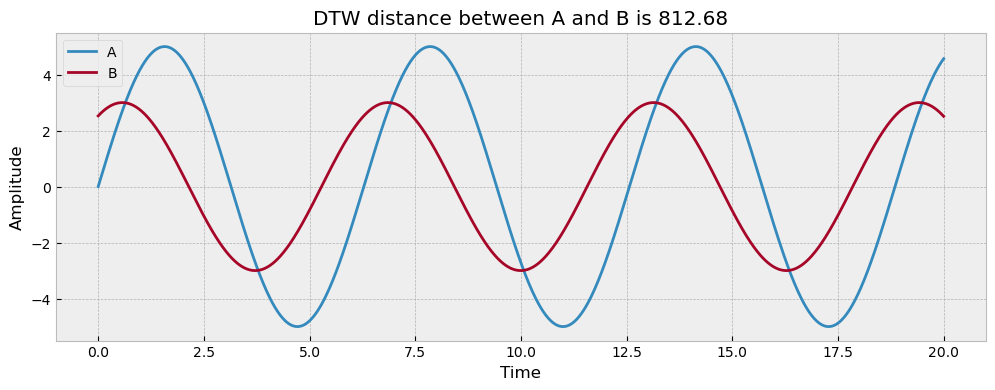

In [5]:
time = np.linspace(0, 20, 1000)
amplitude_a = 5 * np.sin(time)
amplitude_b = 3 * np.sin(time + 1)

m = KnnDtw()
distance = m._dtw_distance(amplitude_a, amplitude_b)

fig = plt.figure(figsize=(12,4))
plt.plot(time, amplitude_a, label = 'A')
plt.plot(time, amplitude_b, label = 'B')
plt.title('DTW distance between A and B is %.2f' % distance)
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.legend()

In [6]:
m._dist_matrix(np.random.randn(4,50), np.random.randn(4,50))

 [                  0%                  ] None
 [*****            12%                  ]  2 of 16 complete None
 [*******          19%                  ]  3 of 16 complete None
 [**********       25%                  ]  4 of 16 complete None
 [************     31%                  ]  5 of 16 complete None
 [**************   38%                  ]  6 of 16 complete None
 [*****************44%                  ]  7 of 16 complete None
 [*****************50%                  ]  8 of 16 complete None
 [*****************56%*                 ]  9 of 16 complete None
 [*****************62%****              ]  10 of 16 complete None
 [*****************69%******            ]  11 of 16 complete None
 [*****************75%********          ]  12 of 16 complete None
 [*****************81%***********       ]  13 of 16 complete None
 [*****************88%*************     ]  14 of 16 complete None
 [*****************94%****************  ]  15 of 16 complete None
 [****************100%***************

array([[38.14904119, 32.76031821, 33.06889416, 33.2320531 ],
       [31.48360501, 34.82139661, 33.8790983 , 33.5522384 ],
       [32.68755083, 33.97923755, 33.33770901, 33.13279305],
       [26.62025215, 37.05059447, 35.48451356, 36.02423734]])

In [7]:
# Import the HAR dataset
x_train_file = open('./Data/train/X_train.txt', 'r')
y_train_file = open('./Data/train/y_train.txt', 'r')

x_test_file = open('./Data/test/X_test.txt', 'r')
y_test_file = open('./Data/test/y_test.txt', 'r')

# Create empty lists
x_train = []
y_train = []
x_test = []
y_test = []

# Mapping table for classes
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

# Loop through datasets
for x in x_train_file:
    x_train.append([float(ts) for ts in x.split()])
    
for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
    
for x in x_test_file:
    x_test.append([float(ts) for ts in x.split()])
    
for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))
    
# Convert to numpy for efficiency
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

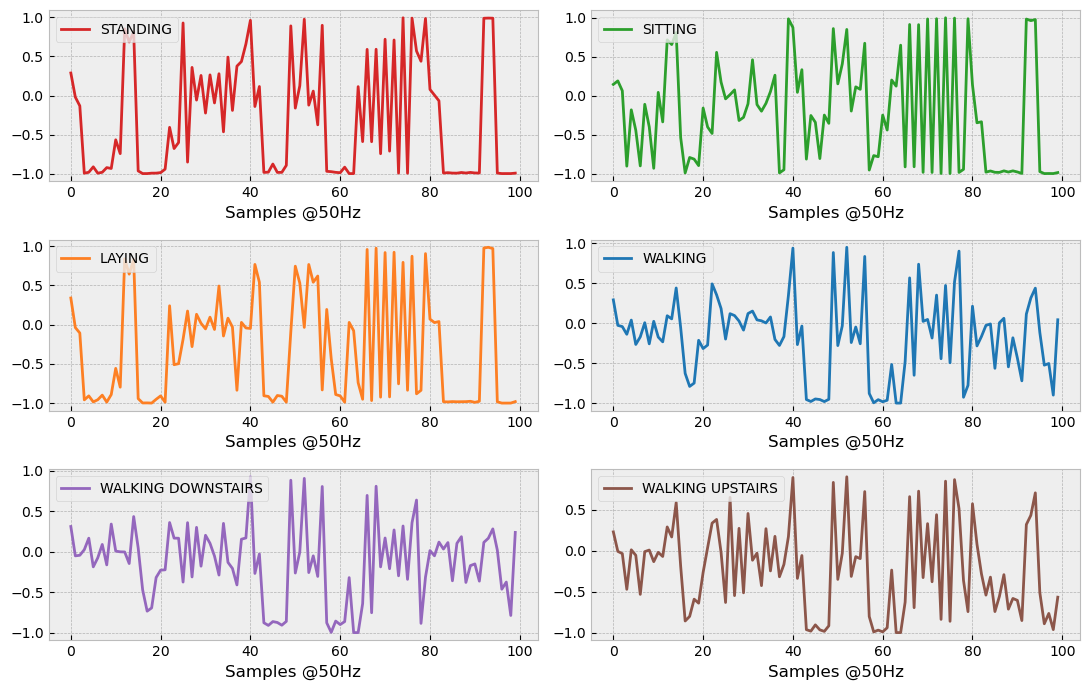

In [8]:
plt.figure(figsize=(11,7))
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']

for i, r in enumerate([0,27,65,100,145,172]):
    plt.subplot(3,2,i+1)
    plt.plot(x_train[r][:100], label=labels[y_train[r]], color=colors[i], linewidth=2)
    plt.xlabel('Samples @50Hz')
    plt.legend(loc='upper left')
    plt.tight_layout()

In [9]:
m = KnnDtw(n_neighbors=1, max_warping_window=10)
m.fit(x_train[::100], y_train[::100])
label, proba = m.predict(x_test[::100])

 [                  0%                  ] None
 [                  0%                  ]  2 of 2220 complete None
 [                  0%                  ]  3 of 2220 complete None
 [                  0%                  ]  4 of 2220 complete None
 [                  0%                  ]  5 of 2220 complete None
 [                  0%                  ]  6 of 2220 complete None
 [                  0%                  ]  7 of 2220 complete None
 [                  0%                  ]  8 of 2220 complete None
 [                  0%                  ]  9 of 2220 complete None
 [                  0%                  ]  10 of 2220 complete None
 [                  0%                  ]  11 of 2220 complete None
 [                  1%                  ]  12 of 2220 complete None
 [                  1%                  ]  13 of 2220 complete None
 [                  1%                  ]  14 of 2220 complete None
 [                  1%                  ]  15 of 2220 complete None
 [       

 [**                5%                  ]  122 of 2220 complete None
 [**                6%                  ]  123 of 2220 complete None
 [**                6%                  ]  124 of 2220 complete None
 [**                6%                  ]  125 of 2220 complete None
 [**                6%                  ]  126 of 2220 complete None
 [**                6%                  ]  127 of 2220 complete None
 [**                6%                  ]  128 of 2220 complete None
 [**                6%                  ]  129 of 2220 complete None
 [**                6%                  ]  130 of 2220 complete None
 [**                6%                  ]  131 of 2220 complete None
 [**                6%                  ]  132 of 2220 complete None
 [**                6%                  ]  133 of 2220 complete None
 [**                6%                  ]  134 of 2220 complete None
 [**                6%                  ]  135 of 2220 complete None
 [**                6%            

 [****             11%                  ]  241 of 2220 complete None
 [****             11%                  ]  242 of 2220 complete None
 [****             11%                  ]  243 of 2220 complete None
 [****             11%                  ]  244 of 2220 complete None
 [****             11%                  ]  245 of 2220 complete None
 [****             11%                  ]  246 of 2220 complete None
 [****             11%                  ]  247 of 2220 complete None
 [****             11%                  ]  248 of 2220 complete None
 [****             11%                  ]  249 of 2220 complete None
 [****             11%                  ]  250 of 2220 complete None
 [****             11%                  ]  251 of 2220 complete None
 [****             11%                  ]  252 of 2220 complete None
 [****             11%                  ]  253 of 2220 complete None
 [****             11%                  ]  254 of 2220 complete None
 [****             11%            

 [******           16%                  ]  360 of 2220 complete None
 [******           16%                  ]  361 of 2220 complete None
 [******           16%                  ]  362 of 2220 complete None
 [******           16%                  ]  363 of 2220 complete None
 [******           16%                  ]  364 of 2220 complete None
 [******           16%                  ]  365 of 2220 complete None
 [******           16%                  ]  366 of 2220 complete None
 [******           17%                  ]  367 of 2220 complete None
 [******           17%                  ]  368 of 2220 complete None
 [******           17%                  ]  369 of 2220 complete None
 [******           17%                  ]  370 of 2220 complete None
 [******           17%                  ]  371 of 2220 complete None
 [******           17%                  ]  372 of 2220 complete None
 [******           17%                  ]  373 of 2220 complete None
 [******           17%            

 [********         22%                  ]  479 of 2220 complete None
 [********         22%                  ]  480 of 2220 complete None
 [********         22%                  ]  481 of 2220 complete None
 [********         22%                  ]  482 of 2220 complete None
 [********         22%                  ]  483 of 2220 complete None
 [********         22%                  ]  484 of 2220 complete None
 [********         22%                  ]  485 of 2220 complete None
 [********         22%                  ]  486 of 2220 complete None
 [********         22%                  ]  487 of 2220 complete None
 [********         22%                  ]  488 of 2220 complete None
 [********         22%                  ]  489 of 2220 complete None
 [********         22%                  ]  490 of 2220 complete None
 [********         22%                  ]  491 of 2220 complete None
 [********         22%                  ]  492 of 2220 complete None
 [********         22%            

 [**********       27%                  ]  598 of 2220 complete None
 [**********       27%                  ]  599 of 2220 complete None
 [**********       27%                  ]  600 of 2220 complete None
 [**********       27%                  ]  601 of 2220 complete None
 [**********       27%                  ]  602 of 2220 complete None
 [**********       27%                  ]  603 of 2220 complete None
 [**********       27%                  ]  604 of 2220 complete None
 [**********       27%                  ]  605 of 2220 complete None
 [**********       27%                  ]  606 of 2220 complete None
 [**********       27%                  ]  607 of 2220 complete None
 [**********       27%                  ]  608 of 2220 complete None
 [**********       27%                  ]  609 of 2220 complete None
 [**********       27%                  ]  610 of 2220 complete None
 [***********      28%                  ]  611 of 2220 complete None
 [***********      28%            

 [************     32%                  ]  717 of 2220 complete None
 [************     32%                  ]  718 of 2220 complete None
 [************     32%                  ]  719 of 2220 complete None
 [************     32%                  ]  720 of 2220 complete None
 [************     32%                  ]  721 of 2220 complete None
 [*************    33%                  ]  722 of 2220 complete None
 [*************    33%                  ]  723 of 2220 complete None
 [*************    33%                  ]  724 of 2220 complete None
 [*************    33%                  ]  725 of 2220 complete None
 [*************    33%                  ]  726 of 2220 complete None
 [*************    33%                  ]  727 of 2220 complete None
 [*************    33%                  ]  728 of 2220 complete None
 [*************    33%                  ]  729 of 2220 complete None
 [*************    33%                  ]  730 of 2220 complete None
 [*************    33%            

 [**************   38%                  ]  836 of 2220 complete None
 [**************   38%                  ]  837 of 2220 complete None
 [**************   38%                  ]  838 of 2220 complete None
 [**************   38%                  ]  839 of 2220 complete None
 [**************   38%                  ]  840 of 2220 complete None
 [**************   38%                  ]  841 of 2220 complete None
 [**************   38%                  ]  842 of 2220 complete None
 [**************   38%                  ]  843 of 2220 complete None
 [**************   38%                  ]  844 of 2220 complete None
 [**************   38%                  ]  845 of 2220 complete None
 [**************   38%                  ]  846 of 2220 complete None
 [**************   38%                  ]  847 of 2220 complete None
 [**************   38%                  ]  848 of 2220 complete None
 [**************   38%                  ]  849 of 2220 complete None
 [**************   38%            

 [**************** 43%                  ]  955 of 2220 complete None
 [**************** 43%                  ]  956 of 2220 complete None
 [**************** 43%                  ]  957 of 2220 complete None
 [**************** 43%                  ]  958 of 2220 complete None
 [**************** 43%                  ]  959 of 2220 complete None
 [**************** 43%                  ]  960 of 2220 complete None
 [**************** 43%                  ]  961 of 2220 complete None
 [**************** 43%                  ]  962 of 2220 complete None
 [**************** 43%                  ]  963 of 2220 complete None
 [**************** 43%                  ]  964 of 2220 complete None
 [**************** 43%                  ]  965 of 2220 complete None
 [*****************44%                  ]  966 of 2220 complete None
 [*****************44%                  ]  967 of 2220 complete None
 [*****************44%                  ]  968 of 2220 complete None
 [*****************44%            

 [*****************48%                  ]  1073 of 2220 complete None
 [*****************48%                  ]  1074 of 2220 complete None
 [*****************48%                  ]  1075 of 2220 complete None
 [*****************48%                  ]  1076 of 2220 complete None
 [*****************49%                  ]  1077 of 2220 complete None
 [*****************49%                  ]  1078 of 2220 complete None
 [*****************49%                  ]  1079 of 2220 complete None
 [*****************49%                  ]  1080 of 2220 complete None
 [*****************49%                  ]  1081 of 2220 complete None
 [*****************49%                  ]  1082 of 2220 complete None
 [*****************49%                  ]  1083 of 2220 complete None
 [*****************49%                  ]  1084 of 2220 complete None
 [*****************49%                  ]  1085 of 2220 complete None
 [*****************49%                  ]  1086 of 2220 complete None
 [*****************4

 [*****************54%*                 ]  1191 of 2220 complete None
 [*****************54%*                 ]  1192 of 2220 complete None
 [*****************54%*                 ]  1193 of 2220 complete None
 [*****************54%*                 ]  1194 of 2220 complete None
 [*****************54%*                 ]  1195 of 2220 complete None
 [*****************54%*                 ]  1196 of 2220 complete None
 [*****************54%*                 ]  1197 of 2220 complete None
 [*****************54%*                 ]  1198 of 2220 complete None
 [*****************54%*                 ]  1199 of 2220 complete None
 [*****************54%*                 ]  1200 of 2220 complete None
 [*****************54%*                 ]  1201 of 2220 complete None
 [*****************54%*                 ]  1202 of 2220 complete None
 [*****************54%*                 ]  1203 of 2220 complete None
 [*****************54%*                 ]  1204 of 2220 complete None
 [*****************5

 [*****************59%**                ]  1309 of 2220 complete None
 [*****************59%**                ]  1310 of 2220 complete None
 [*****************59%**                ]  1311 of 2220 complete None
 [*****************59%**                ]  1312 of 2220 complete None
 [*****************59%**                ]  1313 of 2220 complete None
 [*****************59%**                ]  1314 of 2220 complete None
 [*****************59%**                ]  1315 of 2220 complete None
 [*****************59%**                ]  1316 of 2220 complete None
 [*****************59%**                ]  1317 of 2220 complete None
 [*****************59%**                ]  1318 of 2220 complete None
 [*****************59%**                ]  1319 of 2220 complete None
 [*****************59%**                ]  1320 of 2220 complete None
 [*****************60%***               ]  1321 of 2220 complete None
 [*****************60%***               ]  1322 of 2220 complete None
 [*****************6

 [*****************64%****              ]  1427 of 2220 complete None
 [*****************64%****              ]  1428 of 2220 complete None
 [*****************64%****              ]  1429 of 2220 complete None
 [*****************64%****              ]  1430 of 2220 complete None
 [*****************64%****              ]  1431 of 2220 complete None
 [*****************65%*****             ]  1432 of 2220 complete None
 [*****************65%*****             ]  1433 of 2220 complete None
 [*****************65%*****             ]  1434 of 2220 complete None
 [*****************65%*****             ]  1435 of 2220 complete None
 [*****************65%*****             ]  1436 of 2220 complete None
 [*****************65%*****             ]  1437 of 2220 complete None
 [*****************65%*****             ]  1438 of 2220 complete None
 [*****************65%*****             ]  1439 of 2220 complete None
 [*****************65%*****             ]  1440 of 2220 complete None
 [*****************6

 [*****************70%*******           ]  1545 of 2220 complete None
 [*****************70%*******           ]  1546 of 2220 complete None
 [*****************70%*******           ]  1547 of 2220 complete None
 [*****************70%*******           ]  1548 of 2220 complete None
 [*****************70%*******           ]  1549 of 2220 complete None
 [*****************70%*******           ]  1550 of 2220 complete None
 [*****************70%*******           ]  1551 of 2220 complete None
 [*****************70%*******           ]  1552 of 2220 complete None
 [*****************70%*******           ]  1553 of 2220 complete None
 [*****************70%*******           ]  1554 of 2220 complete None
 [*****************70%*******           ]  1555 of 2220 complete None
 [*****************70%*******           ]  1556 of 2220 complete None
 [*****************70%*******           ]  1557 of 2220 complete None
 [*****************70%*******           ]  1558 of 2220 complete None
 [*****************7

 [*****************75%********          ]  1663 of 2220 complete None
 [*****************75%********          ]  1664 of 2220 complete None
 [*****************75%********          ]  1665 of 2220 complete None
 [*****************75%********          ]  1666 of 2220 complete None
 [*****************75%********          ]  1667 of 2220 complete None
 [*****************75%********          ]  1668 of 2220 complete None
 [*****************75%********          ]  1669 of 2220 complete None
 [*****************75%********          ]  1670 of 2220 complete None
 [*****************75%********          ]  1671 of 2220 complete None
 [*****************75%********          ]  1672 of 2220 complete None
 [*****************75%********          ]  1673 of 2220 complete None
 [*****************75%********          ]  1674 of 2220 complete None
 [*****************75%********          ]  1675 of 2220 complete None
 [*****************75%********          ]  1676 of 2220 complete None
 [*****************7

 [*****************80%**********        ]  1781 of 2220 complete None
 [*****************80%**********        ]  1782 of 2220 complete None
 [*****************80%**********        ]  1783 of 2220 complete None
 [*****************80%**********        ]  1784 of 2220 complete None
 [*****************80%**********        ]  1785 of 2220 complete None
 [*****************80%**********        ]  1786 of 2220 complete None
 [*****************80%**********        ]  1787 of 2220 complete None
 [*****************81%***********       ]  1788 of 2220 complete None
 [*****************81%***********       ]  1789 of 2220 complete None
 [*****************81%***********       ]  1790 of 2220 complete None
 [*****************81%***********       ]  1791 of 2220 complete None
 [*****************81%***********       ]  1792 of 2220 complete None
 [*****************81%***********       ]  1793 of 2220 complete None
 [*****************81%***********       ]  1794 of 2220 complete None
 [*****************8

 [*****************86%*************     ]  1899 of 2220 complete None
 [*****************86%*************     ]  1900 of 2220 complete None
 [*****************86%*************     ]  1901 of 2220 complete None
 [*****************86%*************     ]  1902 of 2220 complete None
 [*****************86%*************     ]  1903 of 2220 complete None
 [*****************86%*************     ]  1904 of 2220 complete None
 [*****************86%*************     ]  1905 of 2220 complete None
 [*****************86%*************     ]  1906 of 2220 complete None
 [*****************86%*************     ]  1907 of 2220 complete None
 [*****************86%*************     ]  1908 of 2220 complete None
 [*****************86%*************     ]  1909 of 2220 complete None
 [*****************86%*************     ]  1910 of 2220 complete None
 [*****************86%*************     ]  1911 of 2220 complete None
 [*****************86%*************     ]  1912 of 2220 complete None
 [*****************8

 [*****************91%***************   ]  2017 of 2220 complete None
 [*****************91%***************   ]  2018 of 2220 complete None
 [*****************91%***************   ]  2019 of 2220 complete None
 [*****************91%***************   ]  2020 of 2220 complete None
 [*****************91%***************   ]  2021 of 2220 complete None
 [*****************91%***************   ]  2022 of 2220 complete None
 [*****************91%***************   ]  2023 of 2220 complete None
 [*****************91%***************   ]  2024 of 2220 complete None
 [*****************91%***************   ]  2025 of 2220 complete None
 [*****************91%***************   ]  2026 of 2220 complete None
 [*****************91%***************   ]  2027 of 2220 complete None
 [*****************91%***************   ]  2028 of 2220 complete None
 [*****************91%***************   ]  2029 of 2220 complete None
 [*****************91%***************   ]  2030 of 2220 complete None
 [*****************9

 [*****************96%****************  ]  2135 of 2220 complete None
 [*****************96%****************  ]  2136 of 2220 complete None
 [*****************96%****************  ]  2137 of 2220 complete None
 [*****************96%****************  ]  2138 of 2220 complete None
 [*****************96%****************  ]  2139 of 2220 complete None
 [*****************96%****************  ]  2140 of 2220 complete None
 [*****************96%****************  ]  2141 of 2220 complete None
 [*****************96%****************  ]  2142 of 2220 complete None
 [*****************97%***************** ]  2143 of 2220 complete None
 [*****************97%***************** ]  2144 of 2220 complete None
 [*****************97%***************** ]  2145 of 2220 complete None
 [*****************97%***************** ]  2146 of 2220 complete None
 [*****************97%***************** ]  2147 of 2220 complete None
 [*****************97%***************** ]  2148 of 2220 complete None
 [*****************9

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

def draw_confusion_matrix(label, test_list, window_size):
    conf_mat = confusion_matrix(label, test_list)
    fig = plt.figure(figsize=(6,6))
    width = np.shape(conf_mat)[1]
    height = np.shape(conf_mat)[0]

    res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')

    for i,row in enumerate(conf_mat):
        for j,c in enumerate(row):
            if c>0:
                plt.text(j-.2, i+.1, c, fontsize=16)

    cb = fig.colorbar(res)
    plt.title('Confusion Matrix with warping window '+str(window_size))
    plt.xticks(range(6), [l for l in labels.values()], rotation=90)
    plt.yticks(range(6), [l for l in labels.values()])

                    precision    recall  f1-score   support

           WALKING       1.00      0.70      0.82        10
  WALKING UPSTAIRS       0.60      1.00      0.75         3
WALKING DOWNSTAIRS       0.75      1.00      0.86         3
           SITTING       0.75      0.86      0.80         7
          STANDING       0.67      0.40      0.50         5
            LAYING       0.67      1.00      0.80         2

          accuracy                           0.77        30
         macro avg       0.74      0.83      0.76        30
      weighted avg       0.80      0.77      0.76        30



([<matplotlib.axis.YTick at 0x204d7315cd0>,
 [Text(0, 0, 'WALKING'),
  Text(0, 1, 'WALKING UPSTAIRS'),
  Text(0, 2, 'WALKING DOWNSTAIRS'),
  Text(0, 3, 'SITTING'),
  Text(0, 4, 'STANDING'),
  Text(0, 5, 'LAYING')])

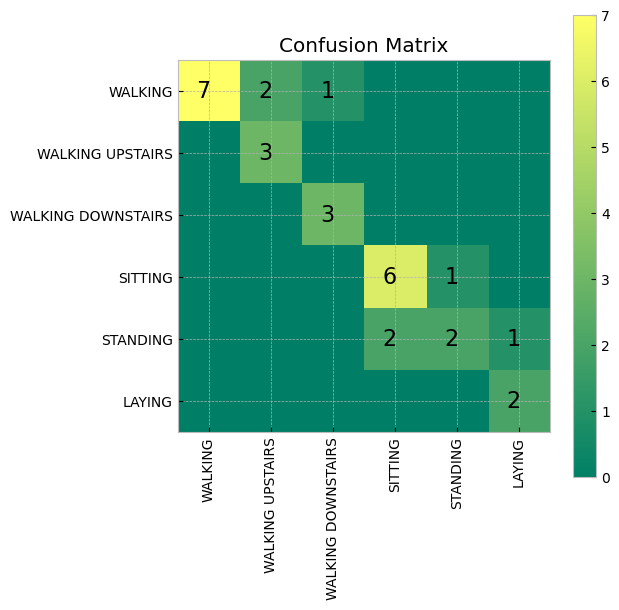

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(label, y_test[::100], target_names = [l for l in labels.values()]))
conf_mat = confusion_matrix(label, y_test[::100])

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')

for i,row in enumerate(conf_mat):
    for j,c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)

cb = fig.colorbar(res)
plt.title('Confusion Matrix')
plt.xticks(range(6), [l for l in labels.values()], rotation=90)
plt.yticks(range(6), [l for l in labels.values()])

 [                  0%                  ] None
 [                  0%                  ]  2 of 8732 complete None
 [                  0%                  ]  3 of 8732 complete None
 [                  0%                  ]  4 of 8732 complete None
 [                  0%                  ]  5 of 8732 complete None
 [                  0%                  ]  6 of 8732 complete None
 [                  0%                  ]  7 of 8732 complete None
 [                  0%                  ]  8 of 8732 complete None
 [                  0%                  ]  9 of 8732 complete None
 [                  0%                  ]  10 of 8732 complete None
 [                  0%                  ]  11 of 8732 complete None
 [                  0%                  ]  12 of 8732 complete None
 [                  0%                  ]  13 of 8732 complete None
 [                  0%                  ]  14 of 8732 complete None
 [                  0%                  ]  15 of 8732 complete None
 [       

 [                  1%                  ]  122 of 8732 complete None
 [                  1%                  ]  123 of 8732 complete None
 [                  1%                  ]  124 of 8732 complete None
 [                  1%                  ]  125 of 8732 complete None
 [                  1%                  ]  126 of 8732 complete None
 [                  1%                  ]  127 of 8732 complete None
 [                  1%                  ]  128 of 8732 complete None
 [                  1%                  ]  129 of 8732 complete None
 [                  1%                  ]  130 of 8732 complete None
 [*                 2%                  ]  131 of 8732 complete None
 [*                 2%                  ]  132 of 8732 complete None
 [*                 2%                  ]  133 of 8732 complete None
 [*                 2%                  ]  134 of 8732 complete None
 [*                 2%                  ]  135 of 8732 complete None
 [*                 2%            

 [*                 3%                  ]  241 of 8732 complete None
 [*                 3%                  ]  242 of 8732 complete None
 [*                 3%                  ]  243 of 8732 complete None
 [*                 3%                  ]  244 of 8732 complete None
 [*                 3%                  ]  245 of 8732 complete None
 [*                 3%                  ]  246 of 8732 complete None
 [*                 3%                  ]  247 of 8732 complete None
 [*                 3%                  ]  248 of 8732 complete None
 [*                 3%                  ]  249 of 8732 complete None
 [*                 3%                  ]  250 of 8732 complete None
 [*                 3%                  ]  251 of 8732 complete None
 [*                 3%                  ]  252 of 8732 complete None
 [*                 3%                  ]  253 of 8732 complete None
 [*                 3%                  ]  254 of 8732 complete None
 [*                 3%            

 [**                4%                  ]  360 of 8732 complete None
 [**                4%                  ]  361 of 8732 complete None
 [**                4%                  ]  362 of 8732 complete None
 [**                4%                  ]  363 of 8732 complete None
 [**                4%                  ]  364 of 8732 complete None
 [**                4%                  ]  365 of 8732 complete None
 [**                4%                  ]  366 of 8732 complete None
 [**                4%                  ]  367 of 8732 complete None
 [**                4%                  ]  368 of 8732 complete None
 [**                4%                  ]  369 of 8732 complete None
 [**                4%                  ]  370 of 8732 complete None
 [**                4%                  ]  371 of 8732 complete None
 [**                4%                  ]  372 of 8732 complete None
 [**                4%                  ]  373 of 8732 complete None
 [**                4%            

 [**                5%                  ]  479 of 8732 complete None
 [**                5%                  ]  480 of 8732 complete None
 [**                6%                  ]  481 of 8732 complete None
 [**                6%                  ]  482 of 8732 complete None
 [**                6%                  ]  483 of 8732 complete None
 [**                6%                  ]  484 of 8732 complete None
 [**                6%                  ]  485 of 8732 complete None
 [**                6%                  ]  486 of 8732 complete None
 [**                6%                  ]  487 of 8732 complete None
 [**                6%                  ]  488 of 8732 complete None
 [**                6%                  ]  489 of 8732 complete None
 [**                6%                  ]  490 of 8732 complete None
 [**                6%                  ]  491 of 8732 complete None
 [**                6%                  ]  492 of 8732 complete None
 [**                6%            

 [***               7%                  ]  598 of 8732 complete None
 [***               7%                  ]  599 of 8732 complete None
 [***               7%                  ]  600 of 8732 complete None
 [***               7%                  ]  601 of 8732 complete None
 [***               7%                  ]  602 of 8732 complete None
 [***               7%                  ]  603 of 8732 complete None
 [***               7%                  ]  604 of 8732 complete None
 [***               7%                  ]  605 of 8732 complete None
 [***               7%                  ]  606 of 8732 complete None
 [***               7%                  ]  607 of 8732 complete None
 [***               7%                  ]  608 of 8732 complete None
 [***               7%                  ]  609 of 8732 complete None
 [***               7%                  ]  610 of 8732 complete None
 [***               7%                  ]  611 of 8732 complete None
 [***               7%            

 [***               8%                  ]  717 of 8732 complete None
 [***               8%                  ]  718 of 8732 complete None
 [***               8%                  ]  719 of 8732 complete None
 [***               8%                  ]  720 of 8732 complete None
 [***               8%                  ]  721 of 8732 complete None
 [***               8%                  ]  722 of 8732 complete None
 [***               8%                  ]  723 of 8732 complete None
 [***               8%                  ]  724 of 8732 complete None
 [***               8%                  ]  725 of 8732 complete None
 [***               8%                  ]  726 of 8732 complete None
 [***               8%                  ]  727 of 8732 complete None
 [***               8%                  ]  728 of 8732 complete None
 [***               8%                  ]  729 of 8732 complete None
 [***               8%                  ]  730 of 8732 complete None
 [***               8%            

 [****             10%                  ]  836 of 8732 complete None
 [****             10%                  ]  837 of 8732 complete None
 [****             10%                  ]  838 of 8732 complete None
 [****             10%                  ]  839 of 8732 complete None
 [****             10%                  ]  840 of 8732 complete None
 [****             10%                  ]  841 of 8732 complete None
 [****             10%                  ]  842 of 8732 complete None
 [****             10%                  ]  843 of 8732 complete None
 [****             10%                  ]  844 of 8732 complete None
 [****             10%                  ]  845 of 8732 complete None
 [****             10%                  ]  846 of 8732 complete None
 [****             10%                  ]  847 of 8732 complete None
 [****             10%                  ]  848 of 8732 complete None
 [****             10%                  ]  849 of 8732 complete None
 [****             10%            

 [****             11%                  ]  955 of 8732 complete None
 [****             11%                  ]  956 of 8732 complete None
 [****             11%                  ]  957 of 8732 complete None
 [****             11%                  ]  958 of 8732 complete None
 [****             11%                  ]  959 of 8732 complete None
 [****             11%                  ]  960 of 8732 complete None
 [****             11%                  ]  961 of 8732 complete None
 [****             11%                  ]  962 of 8732 complete None
 [****             11%                  ]  963 of 8732 complete None
 [****             11%                  ]  964 of 8732 complete None
 [****             11%                  ]  965 of 8732 complete None
 [****             11%                  ]  966 of 8732 complete None
 [****             11%                  ]  967 of 8732 complete None
 [****             11%                  ]  968 of 8732 complete None
 [****             11%            

 [*****            12%                  ]  1073 of 8732 complete None
 [*****            12%                  ]  1074 of 8732 complete None
 [*****            12%                  ]  1075 of 8732 complete None
 [*****            12%                  ]  1076 of 8732 complete None
 [*****            12%                  ]  1077 of 8732 complete None
 [*****            12%                  ]  1078 of 8732 complete None
 [*****            12%                  ]  1079 of 8732 complete None
 [*****            12%                  ]  1080 of 8732 complete None
 [*****            12%                  ]  1081 of 8732 complete None
 [*****            12%                  ]  1082 of 8732 complete None
 [*****            12%                  ]  1083 of 8732 complete None
 [*****            12%                  ]  1084 of 8732 complete None
 [*****            12%                  ]  1085 of 8732 complete None
 [*****            12%                  ]  1086 of 8732 complete None
 [*****            1

 [*****            14%                  ]  1191 of 8732 complete None
 [*****            14%                  ]  1192 of 8732 complete None
 [*****            14%                  ]  1193 of 8732 complete None
 [*****            14%                  ]  1194 of 8732 complete None
 [*****            14%                  ]  1195 of 8732 complete None
 [*****            14%                  ]  1196 of 8732 complete None
 [*****            14%                  ]  1197 of 8732 complete None
 [*****            14%                  ]  1198 of 8732 complete None
 [*****            14%                  ]  1199 of 8732 complete None
 [*****            14%                  ]  1200 of 8732 complete None
 [*****            14%                  ]  1201 of 8732 complete None
 [*****            14%                  ]  1202 of 8732 complete None
 [*****            14%                  ]  1203 of 8732 complete None
 [*****            14%                  ]  1204 of 8732 complete None
 [*****            1

 [******           15%                  ]  1309 of 8732 complete None
 [******           15%                  ]  1310 of 8732 complete None
 [******           15%                  ]  1311 of 8732 complete None
 [******           15%                  ]  1312 of 8732 complete None
 [******           15%                  ]  1313 of 8732 complete None
 [******           15%                  ]  1314 of 8732 complete None
 [******           15%                  ]  1315 of 8732 complete None
 [******           15%                  ]  1316 of 8732 complete None
 [******           15%                  ]  1317 of 8732 complete None
 [******           15%                  ]  1318 of 8732 complete None
 [******           15%                  ]  1319 of 8732 complete None
 [******           15%                  ]  1320 of 8732 complete None
 [******           15%                  ]  1321 of 8732 complete None
 [******           15%                  ]  1322 of 8732 complete None
 [******           1

 [******           16%                  ]  1427 of 8732 complete None
 [******           16%                  ]  1428 of 8732 complete None
 [******           16%                  ]  1429 of 8732 complete None
 [******           16%                  ]  1430 of 8732 complete None
 [******           16%                  ]  1431 of 8732 complete None
 [******           16%                  ]  1432 of 8732 complete None
 [******           16%                  ]  1433 of 8732 complete None
 [******           16%                  ]  1434 of 8732 complete None
 [******           16%                  ]  1435 of 8732 complete None
 [******           16%                  ]  1436 of 8732 complete None
 [******           16%                  ]  1437 of 8732 complete None
 [******           16%                  ]  1438 of 8732 complete None
 [******           16%                  ]  1439 of 8732 complete None
 [******           16%                  ]  1440 of 8732 complete None
 [******           1

 [*******          18%                  ]  1545 of 8732 complete None
 [*******          18%                  ]  1546 of 8732 complete None
 [*******          18%                  ]  1547 of 8732 complete None
 [*******          18%                  ]  1548 of 8732 complete None
 [*******          18%                  ]  1549 of 8732 complete None
 [*******          18%                  ]  1550 of 8732 complete None
 [*******          18%                  ]  1551 of 8732 complete None
 [*******          18%                  ]  1552 of 8732 complete None
 [*******          18%                  ]  1553 of 8732 complete None
 [*******          18%                  ]  1554 of 8732 complete None
 [*******          18%                  ]  1555 of 8732 complete None
 [*******          18%                  ]  1556 of 8732 complete None
 [*******          18%                  ]  1557 of 8732 complete None
 [*******          18%                  ]  1558 of 8732 complete None
 [*******          1

 [*******          19%                  ]  1663 of 8732 complete None
 [*******          19%                  ]  1664 of 8732 complete None
 [*******          19%                  ]  1665 of 8732 complete None
 [*******          19%                  ]  1666 of 8732 complete None
 [*******          19%                  ]  1667 of 8732 complete None
 [*******          19%                  ]  1668 of 8732 complete None
 [*******          19%                  ]  1669 of 8732 complete None
 [*******          19%                  ]  1670 of 8732 complete None
 [*******          19%                  ]  1671 of 8732 complete None
 [*******          19%                  ]  1672 of 8732 complete None
 [*******          19%                  ]  1673 of 8732 complete None
 [*******          19%                  ]  1674 of 8732 complete None
 [*******          19%                  ]  1675 of 8732 complete None
 [*******          19%                  ]  1676 of 8732 complete None
 [*******          1

 [********         20%                  ]  1781 of 8732 complete None
 [********         20%                  ]  1782 of 8732 complete None
 [********         20%                  ]  1783 of 8732 complete None
 [********         20%                  ]  1784 of 8732 complete None
 [********         20%                  ]  1785 of 8732 complete None
 [********         20%                  ]  1786 of 8732 complete None
 [********         20%                  ]  1787 of 8732 complete None
 [********         20%                  ]  1788 of 8732 complete None
 [********         20%                  ]  1789 of 8732 complete None
 [********         20%                  ]  1790 of 8732 complete None
 [********         21%                  ]  1791 of 8732 complete None
 [********         21%                  ]  1792 of 8732 complete None
 [********         21%                  ]  1793 of 8732 complete None
 [********         21%                  ]  1794 of 8732 complete None
 [********         2

 [********         22%                  ]  1899 of 8732 complete None
 [********         22%                  ]  1900 of 8732 complete None
 [********         22%                  ]  1901 of 8732 complete None
 [********         22%                  ]  1902 of 8732 complete None
 [********         22%                  ]  1903 of 8732 complete None
 [********         22%                  ]  1904 of 8732 complete None
 [********         22%                  ]  1905 of 8732 complete None
 [********         22%                  ]  1906 of 8732 complete None
 [********         22%                  ]  1907 of 8732 complete None
 [********         22%                  ]  1908 of 8732 complete None
 [********         22%                  ]  1909 of 8732 complete None
 [********         22%                  ]  1910 of 8732 complete None
 [********         22%                  ]  1911 of 8732 complete None
 [********         22%                  ]  1912 of 8732 complete None
 [********         2

 [*********        23%                  ]  2017 of 8732 complete None
 [*********        23%                  ]  2018 of 8732 complete None
 [*********        23%                  ]  2019 of 8732 complete None
 [*********        23%                  ]  2020 of 8732 complete None
 [*********        23%                  ]  2021 of 8732 complete None
 [*********        23%                  ]  2022 of 8732 complete None
 [*********        23%                  ]  2023 of 8732 complete None
 [*********        23%                  ]  2024 of 8732 complete None
 [*********        23%                  ]  2025 of 8732 complete None
 [*********        23%                  ]  2026 of 8732 complete None
 [*********        23%                  ]  2027 of 8732 complete None
 [*********        23%                  ]  2028 of 8732 complete None
 [*********        23%                  ]  2029 of 8732 complete None
 [*********        23%                  ]  2030 of 8732 complete None
 [*********        2

 [*********        24%                  ]  2135 of 8732 complete None
 [*********        24%                  ]  2136 of 8732 complete None
 [*********        24%                  ]  2137 of 8732 complete None
 [*********        24%                  ]  2138 of 8732 complete None
 [*********        24%                  ]  2139 of 8732 complete None
 [**********       25%                  ]  2140 of 8732 complete None
 [**********       25%                  ]  2141 of 8732 complete None
 [**********       25%                  ]  2142 of 8732 complete None
 [**********       25%                  ]  2143 of 8732 complete None
 [**********       25%                  ]  2144 of 8732 complete None
 [**********       25%                  ]  2145 of 8732 complete None
 [**********       25%                  ]  2146 of 8732 complete None
 [**********       25%                  ]  2147 of 8732 complete None
 [**********       25%                  ]  2148 of 8732 complete None
 [**********       2

 [**********       26%                  ]  2253 of 8732 complete None
 [**********       26%                  ]  2254 of 8732 complete None
 [**********       26%                  ]  2255 of 8732 complete None
 [**********       26%                  ]  2256 of 8732 complete None
 [**********       26%                  ]  2257 of 8732 complete None
 [**********       26%                  ]  2258 of 8732 complete None
 [**********       26%                  ]  2259 of 8732 complete None
 [**********       26%                  ]  2260 of 8732 complete None
 [**********       26%                  ]  2261 of 8732 complete None
 [**********       26%                  ]  2262 of 8732 complete None
 [**********       26%                  ]  2263 of 8732 complete None
 [**********       26%                  ]  2264 of 8732 complete None
 [**********       26%                  ]  2265 of 8732 complete None
 [**********       26%                  ]  2266 of 8732 complete None
 [**********       2

 [**********       27%                  ]  2371 of 8732 complete None
 [**********       27%                  ]  2372 of 8732 complete None
 [**********       27%                  ]  2373 of 8732 complete None
 [**********       27%                  ]  2374 of 8732 complete None
 [**********       27%                  ]  2375 of 8732 complete None
 [**********       27%                  ]  2376 of 8732 complete None
 [**********       27%                  ]  2377 of 8732 complete None
 [**********       27%                  ]  2378 of 8732 complete None
 [**********       27%                  ]  2379 of 8732 complete None
 [**********       27%                  ]  2380 of 8732 complete None
 [**********       27%                  ]  2381 of 8732 complete None
 [**********       27%                  ]  2382 of 8732 complete None
 [**********       27%                  ]  2383 of 8732 complete None
 [**********       27%                  ]  2384 of 8732 complete None
 [**********       2

 [***********      29%                  ]  2489 of 8732 complete None
 [***********      29%                  ]  2490 of 8732 complete None
 [***********      29%                  ]  2491 of 8732 complete None
 [***********      29%                  ]  2492 of 8732 complete None
 [***********      29%                  ]  2493 of 8732 complete None
 [***********      29%                  ]  2494 of 8732 complete None
 [***********      29%                  ]  2495 of 8732 complete None
 [***********      29%                  ]  2496 of 8732 complete None
 [***********      29%                  ]  2497 of 8732 complete None
 [***********      29%                  ]  2498 of 8732 complete None
 [***********      29%                  ]  2499 of 8732 complete None
 [***********      29%                  ]  2500 of 8732 complete None
 [***********      29%                  ]  2501 of 8732 complete None
 [***********      29%                  ]  2502 of 8732 complete None
 [***********      2

 [***********      30%                  ]  2607 of 8732 complete None
 [***********      30%                  ]  2608 of 8732 complete None
 [***********      30%                  ]  2609 of 8732 complete None
 [***********      30%                  ]  2610 of 8732 complete None
 [***********      30%                  ]  2611 of 8732 complete None
 [***********      30%                  ]  2612 of 8732 complete None
 [***********      30%                  ]  2613 of 8732 complete None
 [***********      30%                  ]  2614 of 8732 complete None
 [***********      30%                  ]  2615 of 8732 complete None
 [***********      30%                  ]  2616 of 8732 complete None
 [***********      30%                  ]  2617 of 8732 complete None
 [***********      30%                  ]  2618 of 8732 complete None
 [***********      30%                  ]  2619 of 8732 complete None
 [***********      30%                  ]  2620 of 8732 complete None
 [***********      3

 [************     31%                  ]  2725 of 8732 complete None
 [************     31%                  ]  2726 of 8732 complete None
 [************     31%                  ]  2727 of 8732 complete None
 [************     31%                  ]  2728 of 8732 complete None
 [************     31%                  ]  2729 of 8732 complete None
 [************     31%                  ]  2730 of 8732 complete None
 [************     31%                  ]  2731 of 8732 complete None
 [************     31%                  ]  2732 of 8732 complete None
 [************     31%                  ]  2733 of 8732 complete None
 [************     31%                  ]  2734 of 8732 complete None
 [************     31%                  ]  2735 of 8732 complete None
 [************     31%                  ]  2736 of 8732 complete None
 [************     31%                  ]  2737 of 8732 complete None
 [************     31%                  ]  2738 of 8732 complete None
 [************     3

 [*************    33%                  ]  2843 of 8732 complete None
 [*************    33%                  ]  2844 of 8732 complete None
 [*************    33%                  ]  2845 of 8732 complete None
 [*************    33%                  ]  2846 of 8732 complete None
 [*************    33%                  ]  2847 of 8732 complete None
 [*************    33%                  ]  2848 of 8732 complete None
 [*************    33%                  ]  2849 of 8732 complete None
 [*************    33%                  ]  2850 of 8732 complete None
 [*************    33%                  ]  2851 of 8732 complete None
 [*************    33%                  ]  2852 of 8732 complete None
 [*************    33%                  ]  2853 of 8732 complete None
 [*************    33%                  ]  2854 of 8732 complete None
 [*************    33%                  ]  2855 of 8732 complete None
 [*************    33%                  ]  2856 of 8732 complete None
 [*************    3

 [*************    34%                  ]  2961 of 8732 complete None
 [*************    34%                  ]  2962 of 8732 complete None
 [*************    34%                  ]  2963 of 8732 complete None
 [*************    34%                  ]  2964 of 8732 complete None
 [*************    34%                  ]  2965 of 8732 complete None
 [*************    34%                  ]  2966 of 8732 complete None
 [*************    34%                  ]  2967 of 8732 complete None
 [*************    34%                  ]  2968 of 8732 complete None
 [*************    34%                  ]  2969 of 8732 complete None
 [*************    34%                  ]  2970 of 8732 complete None
 [*************    34%                  ]  2971 of 8732 complete None
 [*************    34%                  ]  2972 of 8732 complete None
 [*************    34%                  ]  2973 of 8732 complete None
 [*************    34%                  ]  2974 of 8732 complete None
 [*************    3

 [*************    35%                  ]  3079 of 8732 complete None
 [*************    35%                  ]  3080 of 8732 complete None
 [*************    35%                  ]  3081 of 8732 complete None
 [*************    35%                  ]  3082 of 8732 complete None
 [*************    35%                  ]  3083 of 8732 complete None
 [*************    35%                  ]  3084 of 8732 complete None
 [*************    35%                  ]  3085 of 8732 complete None
 [*************    35%                  ]  3086 of 8732 complete None
 [*************    35%                  ]  3087 of 8732 complete None
 [*************    35%                  ]  3088 of 8732 complete None
 [*************    35%                  ]  3089 of 8732 complete None
 [*************    35%                  ]  3090 of 8732 complete None
 [*************    35%                  ]  3091 of 8732 complete None
 [*************    35%                  ]  3092 of 8732 complete None
 [*************    3

 [**************   37%                  ]  3197 of 8732 complete None
 [**************   37%                  ]  3198 of 8732 complete None
 [**************   37%                  ]  3199 of 8732 complete None
 [**************   37%                  ]  3200 of 8732 complete None
 [**************   37%                  ]  3201 of 8732 complete None
 [**************   37%                  ]  3202 of 8732 complete None
 [**************   37%                  ]  3203 of 8732 complete None
 [**************   37%                  ]  3204 of 8732 complete None
 [**************   37%                  ]  3205 of 8732 complete None
 [**************   37%                  ]  3206 of 8732 complete None
 [**************   37%                  ]  3207 of 8732 complete None
 [**************   37%                  ]  3208 of 8732 complete None
 [**************   37%                  ]  3209 of 8732 complete None
 [**************   37%                  ]  3210 of 8732 complete None
 [**************   3

 [**************   38%                  ]  3315 of 8732 complete None
 [**************   38%                  ]  3316 of 8732 complete None
 [**************   38%                  ]  3317 of 8732 complete None
 [**************   38%                  ]  3318 of 8732 complete None
 [**************   38%                  ]  3319 of 8732 complete None
 [**************   38%                  ]  3320 of 8732 complete None
 [**************   38%                  ]  3321 of 8732 complete None
 [**************   38%                  ]  3322 of 8732 complete None
 [**************   38%                  ]  3323 of 8732 complete None
 [**************   38%                  ]  3324 of 8732 complete None
 [**************   38%                  ]  3325 of 8732 complete None
 [**************   38%                  ]  3326 of 8732 complete None
 [**************   38%                  ]  3327 of 8732 complete None
 [**************   38%                  ]  3328 of 8732 complete None
 [**************   3

 [***************  39%                  ]  3433 of 8732 complete None
 [***************  39%                  ]  3434 of 8732 complete None
 [***************  39%                  ]  3435 of 8732 complete None
 [***************  39%                  ]  3436 of 8732 complete None
 [***************  39%                  ]  3437 of 8732 complete None
 [***************  39%                  ]  3438 of 8732 complete None
 [***************  39%                  ]  3439 of 8732 complete None
 [***************  39%                  ]  3440 of 8732 complete None
 [***************  39%                  ]  3441 of 8732 complete None
 [***************  39%                  ]  3442 of 8732 complete None
 [***************  39%                  ]  3443 of 8732 complete None
 [***************  39%                  ]  3444 of 8732 complete None
 [***************  39%                  ]  3445 of 8732 complete None
 [***************  39%                  ]  3446 of 8732 complete None
 [***************  3

 [**************** 41%                  ]  3551 of 8732 complete None
 [**************** 41%                  ]  3552 of 8732 complete None
 [**************** 41%                  ]  3553 of 8732 complete None
 [**************** 41%                  ]  3554 of 8732 complete None
 [**************** 41%                  ]  3555 of 8732 complete None
 [**************** 41%                  ]  3556 of 8732 complete None
 [**************** 41%                  ]  3557 of 8732 complete None
 [**************** 41%                  ]  3558 of 8732 complete None
 [**************** 41%                  ]  3559 of 8732 complete None
 [**************** 41%                  ]  3560 of 8732 complete None
 [**************** 41%                  ]  3561 of 8732 complete None
 [**************** 41%                  ]  3562 of 8732 complete None
 [**************** 41%                  ]  3563 of 8732 complete None
 [**************** 41%                  ]  3564 of 8732 complete None
 [**************** 4

 [**************** 42%                  ]  3669 of 8732 complete None
 [**************** 42%                  ]  3670 of 8732 complete None
 [**************** 42%                  ]  3671 of 8732 complete None
 [**************** 42%                  ]  3672 of 8732 complete None
 [**************** 42%                  ]  3673 of 8732 complete None
 [**************** 42%                  ]  3674 of 8732 complete None
 [**************** 42%                  ]  3675 of 8732 complete None
 [**************** 42%                  ]  3676 of 8732 complete None
 [**************** 42%                  ]  3677 of 8732 complete None
 [**************** 42%                  ]  3678 of 8732 complete None
 [**************** 42%                  ]  3679 of 8732 complete None
 [**************** 42%                  ]  3680 of 8732 complete None
 [**************** 42%                  ]  3681 of 8732 complete None
 [**************** 42%                  ]  3682 of 8732 complete None
 [**************** 4

 [**************** 43%                  ]  3787 of 8732 complete None
 [**************** 43%                  ]  3788 of 8732 complete None
 [**************** 43%                  ]  3789 of 8732 complete None
 [**************** 43%                  ]  3790 of 8732 complete None
 [**************** 43%                  ]  3791 of 8732 complete None
 [**************** 43%                  ]  3792 of 8732 complete None
 [**************** 43%                  ]  3793 of 8732 complete None
 [**************** 43%                  ]  3794 of 8732 complete None
 [**************** 43%                  ]  3795 of 8732 complete None
 [**************** 43%                  ]  3796 of 8732 complete None
 [**************** 43%                  ]  3797 of 8732 complete None
 [**************** 43%                  ]  3798 of 8732 complete None
 [*****************44%                  ]  3799 of 8732 complete None
 [*****************44%                  ]  3800 of 8732 complete None
 [*****************4

 [*****************45%                  ]  3905 of 8732 complete None
 [*****************45%                  ]  3906 of 8732 complete None
 [*****************45%                  ]  3907 of 8732 complete None
 [*****************45%                  ]  3908 of 8732 complete None
 [*****************45%                  ]  3909 of 8732 complete None
 [*****************45%                  ]  3910 of 8732 complete None
 [*****************45%                  ]  3911 of 8732 complete None
 [*****************45%                  ]  3912 of 8732 complete None
 [*****************45%                  ]  3913 of 8732 complete None
 [*****************45%                  ]  3914 of 8732 complete None
 [*****************45%                  ]  3915 of 8732 complete None
 [*****************45%                  ]  3916 of 8732 complete None
 [*****************45%                  ]  3917 of 8732 complete None
 [*****************45%                  ]  3918 of 8732 complete None
 [*****************4

 [*****************46%                  ]  4023 of 8732 complete None
 [*****************46%                  ]  4024 of 8732 complete None
 [*****************46%                  ]  4025 of 8732 complete None
 [*****************46%                  ]  4026 of 8732 complete None
 [*****************46%                  ]  4027 of 8732 complete None
 [*****************46%                  ]  4028 of 8732 complete None
 [*****************46%                  ]  4029 of 8732 complete None
 [*****************46%                  ]  4030 of 8732 complete None
 [*****************46%                  ]  4031 of 8732 complete None
 [*****************46%                  ]  4032 of 8732 complete None
 [*****************46%                  ]  4033 of 8732 complete None
 [*****************46%                  ]  4034 of 8732 complete None
 [*****************46%                  ]  4035 of 8732 complete None
 [*****************46%                  ]  4036 of 8732 complete None
 [*****************4

 [*****************47%                  ]  4141 of 8732 complete None
 [*****************47%                  ]  4142 of 8732 complete None
 [*****************47%                  ]  4143 of 8732 complete None
 [*****************47%                  ]  4144 of 8732 complete None
 [*****************47%                  ]  4145 of 8732 complete None
 [*****************47%                  ]  4146 of 8732 complete None
 [*****************47%                  ]  4147 of 8732 complete None
 [*****************48%                  ]  4148 of 8732 complete None
 [*****************48%                  ]  4149 of 8732 complete None
 [*****************48%                  ]  4150 of 8732 complete None
 [*****************48%                  ]  4151 of 8732 complete None
 [*****************48%                  ]  4152 of 8732 complete None
 [*****************48%                  ]  4153 of 8732 complete None
 [*****************48%                  ]  4154 of 8732 complete None
 [*****************4

 [*****************49%                  ]  4259 of 8732 complete None
 [*****************49%                  ]  4260 of 8732 complete None
 [*****************49%                  ]  4261 of 8732 complete None
 [*****************49%                  ]  4262 of 8732 complete None
 [*****************49%                  ]  4263 of 8732 complete None
 [*****************49%                  ]  4264 of 8732 complete None
 [*****************49%                  ]  4265 of 8732 complete None
 [*****************49%                  ]  4266 of 8732 complete None
 [*****************49%                  ]  4267 of 8732 complete None
 [*****************49%                  ]  4268 of 8732 complete None
 [*****************49%                  ]  4269 of 8732 complete None
 [*****************49%                  ]  4270 of 8732 complete None
 [*****************49%                  ]  4271 of 8732 complete None
 [*****************49%                  ]  4272 of 8732 complete None
 [*****************4

 [*****************50%                  ]  4377 of 8732 complete None
 [*****************50%                  ]  4378 of 8732 complete None
 [*****************50%                  ]  4379 of 8732 complete None
 [*****************50%                  ]  4380 of 8732 complete None
 [*****************50%                  ]  4381 of 8732 complete None
 [*****************50%                  ]  4382 of 8732 complete None
 [*****************50%                  ]  4383 of 8732 complete None
 [*****************50%                  ]  4384 of 8732 complete None
 [*****************50%                  ]  4385 of 8732 complete None
 [*****************50%                  ]  4386 of 8732 complete None
 [*****************50%                  ]  4387 of 8732 complete None
 [*****************50%                  ]  4388 of 8732 complete None
 [*****************50%                  ]  4389 of 8732 complete None
 [*****************50%                  ]  4390 of 8732 complete None
 [*****************5

 [*****************51%                  ]  4495 of 8732 complete None
 [*****************51%                  ]  4496 of 8732 complete None
 [*****************52%                  ]  4497 of 8732 complete None
 [*****************52%                  ]  4498 of 8732 complete None
 [*****************52%                  ]  4499 of 8732 complete None
 [*****************52%                  ]  4500 of 8732 complete None
 [*****************52%                  ]  4501 of 8732 complete None
 [*****************52%                  ]  4502 of 8732 complete None
 [*****************52%                  ]  4503 of 8732 complete None
 [*****************52%                  ]  4504 of 8732 complete None
 [*****************52%                  ]  4505 of 8732 complete None
 [*****************52%                  ]  4506 of 8732 complete None
 [*****************52%                  ]  4507 of 8732 complete None
 [*****************52%                  ]  4508 of 8732 complete None
 [*****************5

 [*****************53%                  ]  4613 of 8732 complete None
 [*****************53%                  ]  4614 of 8732 complete None
 [*****************53%                  ]  4615 of 8732 complete None
 [*****************53%                  ]  4616 of 8732 complete None
 [*****************53%                  ]  4617 of 8732 complete None
 [*****************53%                  ]  4618 of 8732 complete None
 [*****************53%                  ]  4619 of 8732 complete None
 [*****************53%                  ]  4620 of 8732 complete None
 [*****************53%                  ]  4621 of 8732 complete None
 [*****************53%                  ]  4622 of 8732 complete None
 [*****************53%                  ]  4623 of 8732 complete None
 [*****************53%                  ]  4624 of 8732 complete None
 [*****************53%                  ]  4625 of 8732 complete None
 [*****************53%                  ]  4626 of 8732 complete None
 [*****************5

 [*****************54%*                 ]  4731 of 8732 complete None
 [*****************54%*                 ]  4732 of 8732 complete None
 [*****************54%*                 ]  4733 of 8732 complete None
 [*****************54%*                 ]  4734 of 8732 complete None
 [*****************54%*                 ]  4735 of 8732 complete None
 [*****************54%*                 ]  4736 of 8732 complete None
 [*****************54%*                 ]  4737 of 8732 complete None
 [*****************54%*                 ]  4738 of 8732 complete None
 [*****************54%*                 ]  4739 of 8732 complete None
 [*****************54%*                 ]  4740 of 8732 complete None
 [*****************54%*                 ]  4741 of 8732 complete None
 [*****************54%*                 ]  4742 of 8732 complete None
 [*****************54%*                 ]  4743 of 8732 complete None
 [*****************54%*                 ]  4744 of 8732 complete None
 [*****************5

 [*****************56%*                 ]  4849 of 8732 complete None
 [*****************56%*                 ]  4850 of 8732 complete None
 [*****************56%*                 ]  4851 of 8732 complete None
 [*****************56%*                 ]  4852 of 8732 complete None
 [*****************56%*                 ]  4853 of 8732 complete None
 [*****************56%*                 ]  4854 of 8732 complete None
 [*****************56%*                 ]  4855 of 8732 complete None
 [*****************56%*                 ]  4856 of 8732 complete None
 [*****************56%*                 ]  4857 of 8732 complete None
 [*****************56%*                 ]  4858 of 8732 complete None
 [*****************56%*                 ]  4859 of 8732 complete None
 [*****************56%*                 ]  4860 of 8732 complete None
 [*****************56%*                 ]  4861 of 8732 complete None
 [*****************56%*                 ]  4862 of 8732 complete None
 [*****************5

 [*****************57%**                ]  4967 of 8732 complete None
 [*****************57%**                ]  4968 of 8732 complete None
 [*****************57%**                ]  4969 of 8732 complete None
 [*****************57%**                ]  4970 of 8732 complete None
 [*****************57%**                ]  4971 of 8732 complete None
 [*****************57%**                ]  4972 of 8732 complete None
 [*****************57%**                ]  4973 of 8732 complete None
 [*****************57%**                ]  4974 of 8732 complete None
 [*****************57%**                ]  4975 of 8732 complete None
 [*****************57%**                ]  4976 of 8732 complete None
 [*****************57%**                ]  4977 of 8732 complete None
 [*****************57%**                ]  4978 of 8732 complete None
 [*****************57%**                ]  4979 of 8732 complete None
 [*****************57%**                ]  4980 of 8732 complete None
 [*****************5

 [*****************58%**                ]  5085 of 8732 complete None
 [*****************58%**                ]  5086 of 8732 complete None
 [*****************58%**                ]  5087 of 8732 complete None
 [*****************58%**                ]  5088 of 8732 complete None
 [*****************58%**                ]  5089 of 8732 complete None
 [*****************58%**                ]  5090 of 8732 complete None
 [*****************58%**                ]  5091 of 8732 complete None
 [*****************58%**                ]  5092 of 8732 complete None
 [*****************58%**                ]  5093 of 8732 complete None
 [*****************58%**                ]  5094 of 8732 complete None
 [*****************58%**                ]  5095 of 8732 complete None
 [*****************58%**                ]  5096 of 8732 complete None
 [*****************58%**                ]  5097 of 8732 complete None
 [*****************58%**                ]  5098 of 8732 complete None
 [*****************5

 [*****************60%***               ]  5203 of 8732 complete None
 [*****************60%***               ]  5204 of 8732 complete None
 [*****************60%***               ]  5205 of 8732 complete None
 [*****************60%***               ]  5206 of 8732 complete None
 [*****************60%***               ]  5207 of 8732 complete None
 [*****************60%***               ]  5208 of 8732 complete None
 [*****************60%***               ]  5209 of 8732 complete None
 [*****************60%***               ]  5210 of 8732 complete None
 [*****************60%***               ]  5211 of 8732 complete None
 [*****************60%***               ]  5212 of 8732 complete None
 [*****************60%***               ]  5213 of 8732 complete None
 [*****************60%***               ]  5214 of 8732 complete None
 [*****************60%***               ]  5215 of 8732 complete None
 [*****************60%***               ]  5216 of 8732 complete None
 [*****************6

 [*****************61%***               ]  5321 of 8732 complete None
 [*****************61%***               ]  5322 of 8732 complete None
 [*****************61%***               ]  5323 of 8732 complete None
 [*****************61%***               ]  5324 of 8732 complete None
 [*****************61%***               ]  5325 of 8732 complete None
 [*****************61%***               ]  5326 of 8732 complete None
 [*****************61%***               ]  5327 of 8732 complete None
 [*****************61%***               ]  5328 of 8732 complete None
 [*****************61%***               ]  5329 of 8732 complete None
 [*****************61%***               ]  5330 of 8732 complete None
 [*****************61%***               ]  5331 of 8732 complete None
 [*****************61%***               ]  5332 of 8732 complete None
 [*****************61%***               ]  5333 of 8732 complete None
 [*****************61%***               ]  5334 of 8732 complete None
 [*****************6

 [*****************62%****              ]  5439 of 8732 complete None
 [*****************62%****              ]  5440 of 8732 complete None
 [*****************62%****              ]  5441 of 8732 complete None
 [*****************62%****              ]  5442 of 8732 complete None
 [*****************62%****              ]  5443 of 8732 complete None
 [*****************62%****              ]  5444 of 8732 complete None
 [*****************62%****              ]  5445 of 8732 complete None
 [*****************62%****              ]  5446 of 8732 complete None
 [*****************62%****              ]  5447 of 8732 complete None
 [*****************62%****              ]  5448 of 8732 complete None
 [*****************62%****              ]  5449 of 8732 complete None
 [*****************62%****              ]  5450 of 8732 complete None
 [*****************62%****              ]  5451 of 8732 complete None
 [*****************62%****              ]  5452 of 8732 complete None
 [*****************6

 [*****************64%****              ]  5557 of 8732 complete None
 [*****************64%****              ]  5558 of 8732 complete None
 [*****************64%****              ]  5559 of 8732 complete None
 [*****************64%****              ]  5560 of 8732 complete None
 [*****************64%****              ]  5561 of 8732 complete None
 [*****************64%****              ]  5562 of 8732 complete None
 [*****************64%****              ]  5563 of 8732 complete None
 [*****************64%****              ]  5564 of 8732 complete None
 [*****************64%****              ]  5565 of 8732 complete None
 [*****************64%****              ]  5566 of 8732 complete None
 [*****************64%****              ]  5567 of 8732 complete None
 [*****************64%****              ]  5568 of 8732 complete None
 [*****************64%****              ]  5569 of 8732 complete None
 [*****************64%****              ]  5570 of 8732 complete None
 [*****************6

 [*****************65%*****             ]  5675 of 8732 complete None
 [*****************65%*****             ]  5676 of 8732 complete None
 [*****************65%*****             ]  5677 of 8732 complete None
 [*****************65%*****             ]  5678 of 8732 complete None
 [*****************65%*****             ]  5679 of 8732 complete None
 [*****************65%*****             ]  5680 of 8732 complete None
 [*****************65%*****             ]  5681 of 8732 complete None
 [*****************65%*****             ]  5682 of 8732 complete None
 [*****************65%*****             ]  5683 of 8732 complete None
 [*****************65%*****             ]  5684 of 8732 complete None
 [*****************65%*****             ]  5685 of 8732 complete None
 [*****************65%*****             ]  5686 of 8732 complete None
 [*****************65%*****             ]  5687 of 8732 complete None
 [*****************65%*****             ]  5688 of 8732 complete None
 [*****************6

 [*****************66%*****             ]  5793 of 8732 complete None
 [*****************66%*****             ]  5794 of 8732 complete None
 [*****************66%*****             ]  5795 of 8732 complete None
 [*****************66%*****             ]  5796 of 8732 complete None
 [*****************66%*****             ]  5797 of 8732 complete None
 [*****************66%*****             ]  5798 of 8732 complete None
 [*****************66%*****             ]  5799 of 8732 complete None
 [*****************66%*****             ]  5800 of 8732 complete None
 [*****************66%*****             ]  5801 of 8732 complete None
 [*****************66%*****             ]  5802 of 8732 complete None
 [*****************66%*****             ]  5803 of 8732 complete None
 [*****************66%*****             ]  5804 of 8732 complete None
 [*****************66%*****             ]  5805 of 8732 complete None
 [*****************66%*****             ]  5806 of 8732 complete None
 [*****************6

 [*****************68%******            ]  5911 of 8732 complete None
 [*****************68%******            ]  5912 of 8732 complete None
 [*****************68%******            ]  5913 of 8732 complete None
 [*****************68%******            ]  5914 of 8732 complete None
 [*****************68%******            ]  5915 of 8732 complete None
 [*****************68%******            ]  5916 of 8732 complete None
 [*****************68%******            ]  5917 of 8732 complete None
 [*****************68%******            ]  5918 of 8732 complete None
 [*****************68%******            ]  5919 of 8732 complete None
 [*****************68%******            ]  5920 of 8732 complete None
 [*****************68%******            ]  5921 of 8732 complete None
 [*****************68%******            ]  5922 of 8732 complete None
 [*****************68%******            ]  5923 of 8732 complete None
 [*****************68%******            ]  5924 of 8732 complete None
 [*****************6

 [*****************69%******            ]  6029 of 8732 complete None
 [*****************69%******            ]  6030 of 8732 complete None
 [*****************69%******            ]  6031 of 8732 complete None
 [*****************69%******            ]  6032 of 8732 complete None
 [*****************69%******            ]  6033 of 8732 complete None
 [*****************69%******            ]  6034 of 8732 complete None
 [*****************69%******            ]  6035 of 8732 complete None
 [*****************69%******            ]  6036 of 8732 complete None
 [*****************69%******            ]  6037 of 8732 complete None
 [*****************69%******            ]  6038 of 8732 complete None
 [*****************69%******            ]  6039 of 8732 complete None
 [*****************69%******            ]  6040 of 8732 complete None
 [*****************69%******            ]  6041 of 8732 complete None
 [*****************69%******            ]  6042 of 8732 complete None
 [*****************6

 [*****************70%*******           ]  6147 of 8732 complete None
 [*****************70%*******           ]  6148 of 8732 complete None
 [*****************70%*******           ]  6149 of 8732 complete None
 [*****************70%*******           ]  6150 of 8732 complete None
 [*****************70%*******           ]  6151 of 8732 complete None
 [*****************70%*******           ]  6152 of 8732 complete None
 [*****************70%*******           ]  6153 of 8732 complete None
 [*****************70%*******           ]  6154 of 8732 complete None
 [*****************70%*******           ]  6155 of 8732 complete None
 [*****************70%*******           ]  6156 of 8732 complete None
 [*****************71%*******           ]  6157 of 8732 complete None
 [*****************71%*******           ]  6158 of 8732 complete None
 [*****************71%*******           ]  6159 of 8732 complete None
 [*****************71%*******           ]  6160 of 8732 complete None
 [*****************7

 [*****************72%*******           ]  6265 of 8732 complete None
 [*****************72%*******           ]  6266 of 8732 complete None
 [*****************72%*******           ]  6267 of 8732 complete None
 [*****************72%*******           ]  6268 of 8732 complete None
 [*****************72%*******           ]  6269 of 8732 complete None
 [*****************72%*******           ]  6270 of 8732 complete None
 [*****************72%*******           ]  6271 of 8732 complete None
 [*****************72%*******           ]  6272 of 8732 complete None
 [*****************72%*******           ]  6273 of 8732 complete None
 [*****************72%*******           ]  6274 of 8732 complete None
 [*****************72%*******           ]  6275 of 8732 complete None
 [*****************72%*******           ]  6276 of 8732 complete None
 [*****************72%*******           ]  6277 of 8732 complete None
 [*****************72%*******           ]  6278 of 8732 complete None
 [*****************7

 [*****************73%********          ]  6383 of 8732 complete None
 [*****************73%********          ]  6384 of 8732 complete None
 [*****************73%********          ]  6385 of 8732 complete None
 [*****************73%********          ]  6386 of 8732 complete None
 [*****************73%********          ]  6387 of 8732 complete None
 [*****************73%********          ]  6388 of 8732 complete None
 [*****************73%********          ]  6389 of 8732 complete None
 [*****************73%********          ]  6390 of 8732 complete None
 [*****************73%********          ]  6391 of 8732 complete None
 [*****************73%********          ]  6392 of 8732 complete None
 [*****************73%********          ]  6393 of 8732 complete None
 [*****************73%********          ]  6394 of 8732 complete None
 [*****************73%********          ]  6395 of 8732 complete None
 [*****************73%********          ]  6396 of 8732 complete None
 [*****************7

 [*****************74%********          ]  6501 of 8732 complete None
 [*****************74%********          ]  6502 of 8732 complete None
 [*****************74%********          ]  6503 of 8732 complete None
 [*****************74%********          ]  6504 of 8732 complete None
 [*****************74%********          ]  6505 of 8732 complete None
 [*****************75%********          ]  6506 of 8732 complete None
 [*****************75%********          ]  6507 of 8732 complete None
 [*****************75%********          ]  6508 of 8732 complete None
 [*****************75%********          ]  6509 of 8732 complete None
 [*****************75%********          ]  6510 of 8732 complete None
 [*****************75%********          ]  6511 of 8732 complete None
 [*****************75%********          ]  6512 of 8732 complete None
 [*****************75%********          ]  6513 of 8732 complete None
 [*****************75%********          ]  6514 of 8732 complete None
 [*****************7

 [*****************76%*********         ]  6619 of 8732 complete None
 [*****************76%*********         ]  6620 of 8732 complete None
 [*****************76%*********         ]  6621 of 8732 complete None
 [*****************76%*********         ]  6622 of 8732 complete None
 [*****************76%*********         ]  6623 of 8732 complete None
 [*****************76%*********         ]  6624 of 8732 complete None
 [*****************76%*********         ]  6625 of 8732 complete None
 [*****************76%*********         ]  6626 of 8732 complete None
 [*****************76%*********         ]  6627 of 8732 complete None
 [*****************76%*********         ]  6628 of 8732 complete None
 [*****************76%*********         ]  6629 of 8732 complete None
 [*****************76%*********         ]  6630 of 8732 complete None
 [*****************76%*********         ]  6631 of 8732 complete None
 [*****************76%*********         ]  6632 of 8732 complete None
 [*****************7

 [*****************77%*********         ]  6737 of 8732 complete None
 [*****************77%*********         ]  6738 of 8732 complete None
 [*****************77%*********         ]  6739 of 8732 complete None
 [*****************77%*********         ]  6740 of 8732 complete None
 [*****************77%*********         ]  6741 of 8732 complete None
 [*****************77%*********         ]  6742 of 8732 complete None
 [*****************77%*********         ]  6743 of 8732 complete None
 [*****************77%*********         ]  6744 of 8732 complete None
 [*****************77%*********         ]  6745 of 8732 complete None
 [*****************77%*********         ]  6746 of 8732 complete None
 [*****************77%*********         ]  6747 of 8732 complete None
 [*****************77%*********         ]  6748 of 8732 complete None
 [*****************77%*********         ]  6749 of 8732 complete None
 [*****************77%*********         ]  6750 of 8732 complete None
 [*****************7

 [*****************79%**********        ]  6855 of 8732 complete None
 [*****************79%**********        ]  6856 of 8732 complete None
 [*****************79%**********        ]  6857 of 8732 complete None
 [*****************79%**********        ]  6858 of 8732 complete None
 [*****************79%**********        ]  6859 of 8732 complete None
 [*****************79%**********        ]  6860 of 8732 complete None
 [*****************79%**********        ]  6861 of 8732 complete None
 [*****************79%**********        ]  6862 of 8732 complete None
 [*****************79%**********        ]  6863 of 8732 complete None
 [*****************79%**********        ]  6864 of 8732 complete None
 [*****************79%**********        ]  6865 of 8732 complete None
 [*****************79%**********        ]  6866 of 8732 complete None
 [*****************79%**********        ]  6867 of 8732 complete None
 [*****************79%**********        ]  6868 of 8732 complete None
 [*****************7

 [*****************80%**********        ]  6973 of 8732 complete None
 [*****************80%**********        ]  6974 of 8732 complete None
 [*****************80%**********        ]  6975 of 8732 complete None
 [*****************80%**********        ]  6976 of 8732 complete None
 [*****************80%**********        ]  6977 of 8732 complete None
 [*****************80%**********        ]  6978 of 8732 complete None
 [*****************80%**********        ]  6979 of 8732 complete None
 [*****************80%**********        ]  6980 of 8732 complete None
 [*****************80%**********        ]  6981 of 8732 complete None
 [*****************80%**********        ]  6982 of 8732 complete None
 [*****************80%**********        ]  6983 of 8732 complete None
 [*****************80%**********        ]  6984 of 8732 complete None
 [*****************80%**********        ]  6985 of 8732 complete None
 [*****************80%**********        ]  6986 of 8732 complete None
 [*****************8

 [*****************81%***********       ]  7091 of 8732 complete None
 [*****************81%***********       ]  7092 of 8732 complete None
 [*****************81%***********       ]  7093 of 8732 complete None
 [*****************81%***********       ]  7094 of 8732 complete None
 [*****************81%***********       ]  7095 of 8732 complete None
 [*****************81%***********       ]  7096 of 8732 complete None
 [*****************81%***********       ]  7097 of 8732 complete None
 [*****************81%***********       ]  7098 of 8732 complete None
 [*****************81%***********       ]  7099 of 8732 complete None
 [*****************81%***********       ]  7100 of 8732 complete None
 [*****************81%***********       ]  7101 of 8732 complete None
 [*****************81%***********       ]  7102 of 8732 complete None
 [*****************81%***********       ]  7103 of 8732 complete None
 [*****************81%***********       ]  7104 of 8732 complete None
 [*****************8

 [*****************83%************      ]  7209 of 8732 complete None
 [*****************83%************      ]  7210 of 8732 complete None
 [*****************83%************      ]  7211 of 8732 complete None
 [*****************83%************      ]  7212 of 8732 complete None
 [*****************83%************      ]  7213 of 8732 complete None
 [*****************83%************      ]  7214 of 8732 complete None
 [*****************83%************      ]  7215 of 8732 complete None
 [*****************83%************      ]  7216 of 8732 complete None
 [*****************83%************      ]  7217 of 8732 complete None
 [*****************83%************      ]  7218 of 8732 complete None
 [*****************83%************      ]  7219 of 8732 complete None
 [*****************83%************      ]  7220 of 8732 complete None
 [*****************83%************      ]  7221 of 8732 complete None
 [*****************83%************      ]  7222 of 8732 complete None
 [*****************8

 [*****************84%************      ]  7327 of 8732 complete None
 [*****************84%************      ]  7328 of 8732 complete None
 [*****************84%************      ]  7329 of 8732 complete None
 [*****************84%************      ]  7330 of 8732 complete None
 [*****************84%************      ]  7331 of 8732 complete None
 [*****************84%************      ]  7332 of 8732 complete None
 [*****************84%************      ]  7333 of 8732 complete None
 [*****************84%************      ]  7334 of 8732 complete None
 [*****************84%************      ]  7335 of 8732 complete None
 [*****************84%************      ]  7336 of 8732 complete None
 [*****************84%************      ]  7337 of 8732 complete None
 [*****************84%************      ]  7338 of 8732 complete None
 [*****************84%************      ]  7339 of 8732 complete None
 [*****************84%************      ]  7340 of 8732 complete None
 [*****************8

 [*****************85%************      ]  7445 of 8732 complete None
 [*****************85%************      ]  7446 of 8732 complete None
 [*****************85%************      ]  7447 of 8732 complete None
 [*****************85%************      ]  7448 of 8732 complete None
 [*****************85%************      ]  7449 of 8732 complete None
 [*****************85%************      ]  7450 of 8732 complete None
 [*****************85%************      ]  7451 of 8732 complete None
 [*****************85%************      ]  7452 of 8732 complete None
 [*****************85%************      ]  7453 of 8732 complete None
 [*****************85%************      ]  7454 of 8732 complete None
 [*****************85%************      ]  7455 of 8732 complete None
 [*****************85%************      ]  7456 of 8732 complete None
 [*****************85%************      ]  7457 of 8732 complete None
 [*****************85%************      ]  7458 of 8732 complete None
 [*****************8

 [*****************87%*************     ]  7563 of 8732 complete None
 [*****************87%*************     ]  7564 of 8732 complete None
 [*****************87%*************     ]  7565 of 8732 complete None
 [*****************87%*************     ]  7566 of 8732 complete None
 [*****************87%*************     ]  7567 of 8732 complete None
 [*****************87%*************     ]  7568 of 8732 complete None
 [*****************87%*************     ]  7569 of 8732 complete None
 [*****************87%*************     ]  7570 of 8732 complete None
 [*****************87%*************     ]  7571 of 8732 complete None
 [*****************87%*************     ]  7572 of 8732 complete None
 [*****************87%*************     ]  7573 of 8732 complete None
 [*****************87%*************     ]  7574 of 8732 complete None
 [*****************87%*************     ]  7575 of 8732 complete None
 [*****************87%*************     ]  7576 of 8732 complete None
 [*****************8

 [*****************88%*************     ]  7681 of 8732 complete None
 [*****************88%*************     ]  7682 of 8732 complete None
 [*****************88%*************     ]  7683 of 8732 complete None
 [*****************88%*************     ]  7684 of 8732 complete None
 [*****************88%*************     ]  7685 of 8732 complete None
 [*****************88%*************     ]  7686 of 8732 complete None
 [*****************88%*************     ]  7687 of 8732 complete None
 [*****************88%*************     ]  7688 of 8732 complete None
 [*****************88%*************     ]  7689 of 8732 complete None
 [*****************88%*************     ]  7690 of 8732 complete None
 [*****************88%*************     ]  7691 of 8732 complete None
 [*****************88%*************     ]  7692 of 8732 complete None
 [*****************88%*************     ]  7693 of 8732 complete None
 [*****************88%*************     ]  7694 of 8732 complete None
 [*****************8

 [*****************89%**************    ]  7799 of 8732 complete None
 [*****************89%**************    ]  7800 of 8732 complete None
 [*****************89%**************    ]  7801 of 8732 complete None
 [*****************89%**************    ]  7802 of 8732 complete None
 [*****************89%**************    ]  7803 of 8732 complete None
 [*****************89%**************    ]  7804 of 8732 complete None
 [*****************89%**************    ]  7805 of 8732 complete None
 [*****************89%**************    ]  7806 of 8732 complete None
 [*****************89%**************    ]  7807 of 8732 complete None
 [*****************89%**************    ]  7808 of 8732 complete None
 [*****************89%**************    ]  7809 of 8732 complete None
 [*****************89%**************    ]  7810 of 8732 complete None
 [*****************89%**************    ]  7811 of 8732 complete None
 [*****************89%**************    ]  7812 of 8732 complete None
 [*****************8

 [*****************91%***************   ]  7917 of 8732 complete None
 [*****************91%***************   ]  7918 of 8732 complete None
 [*****************91%***************   ]  7919 of 8732 complete None
 [*****************91%***************   ]  7920 of 8732 complete None
 [*****************91%***************   ]  7921 of 8732 complete None
 [*****************91%***************   ]  7922 of 8732 complete None
 [*****************91%***************   ]  7923 of 8732 complete None
 [*****************91%***************   ]  7924 of 8732 complete None
 [*****************91%***************   ]  7925 of 8732 complete None
 [*****************91%***************   ]  7926 of 8732 complete None
 [*****************91%***************   ]  7927 of 8732 complete None
 [*****************91%***************   ]  7928 of 8732 complete None
 [*****************91%***************   ]  7929 of 8732 complete None
 [*****************91%***************   ]  7930 of 8732 complete None
 [*****************9

 [*****************92%***************   ]  8035 of 8732 complete None
 [*****************92%***************   ]  8036 of 8732 complete None
 [*****************92%***************   ]  8037 of 8732 complete None
 [*****************92%***************   ]  8038 of 8732 complete None
 [*****************92%***************   ]  8039 of 8732 complete None
 [*****************92%***************   ]  8040 of 8732 complete None
 [*****************92%***************   ]  8041 of 8732 complete None
 [*****************92%***************   ]  8042 of 8732 complete None
 [*****************92%***************   ]  8043 of 8732 complete None
 [*****************92%***************   ]  8044 of 8732 complete None
 [*****************92%***************   ]  8045 of 8732 complete None
 [*****************92%***************   ]  8046 of 8732 complete None
 [*****************92%***************   ]  8047 of 8732 complete None
 [*****************92%***************   ]  8048 of 8732 complete None
 [*****************9

 [*****************93%***************   ]  8153 of 8732 complete None
 [*****************93%***************   ]  8154 of 8732 complete None
 [*****************93%***************   ]  8155 of 8732 complete None
 [*****************93%***************   ]  8156 of 8732 complete None
 [*****************93%***************   ]  8157 of 8732 complete None
 [*****************93%***************   ]  8158 of 8732 complete None
 [*****************93%***************   ]  8159 of 8732 complete None
 [*****************93%***************   ]  8160 of 8732 complete None
 [*****************93%***************   ]  8161 of 8732 complete None
 [*****************93%***************   ]  8162 of 8732 complete None
 [*****************93%***************   ]  8163 of 8732 complete None
 [*****************93%***************   ]  8164 of 8732 complete None
 [*****************94%****************  ]  8165 of 8732 complete None
 [*****************94%****************  ]  8166 of 8732 complete None
 [*****************9

 [*****************95%****************  ]  8271 of 8732 complete None
 [*****************95%****************  ]  8272 of 8732 complete None
 [*****************95%****************  ]  8273 of 8732 complete None
 [*****************95%****************  ]  8274 of 8732 complete None
 [*****************95%****************  ]  8275 of 8732 complete None
 [*****************95%****************  ]  8276 of 8732 complete None
 [*****************95%****************  ]  8277 of 8732 complete None
 [*****************95%****************  ]  8278 of 8732 complete None
 [*****************95%****************  ]  8279 of 8732 complete None
 [*****************95%****************  ]  8280 of 8732 complete None
 [*****************95%****************  ]  8281 of 8732 complete None
 [*****************95%****************  ]  8282 of 8732 complete None
 [*****************95%****************  ]  8283 of 8732 complete None
 [*****************95%****************  ]  8284 of 8732 complete None
 [*****************9

 [*****************96%****************  ]  8389 of 8732 complete None
 [*****************96%****************  ]  8390 of 8732 complete None
 [*****************96%****************  ]  8391 of 8732 complete None
 [*****************96%****************  ]  8392 of 8732 complete None
 [*****************96%****************  ]  8393 of 8732 complete None
 [*****************96%****************  ]  8394 of 8732 complete None
 [*****************96%****************  ]  8395 of 8732 complete None
 [*****************96%****************  ]  8396 of 8732 complete None
 [*****************96%****************  ]  8397 of 8732 complete None
 [*****************96%****************  ]  8398 of 8732 complete None
 [*****************96%****************  ]  8399 of 8732 complete None
 [*****************96%****************  ]  8400 of 8732 complete None
 [*****************96%****************  ]  8401 of 8732 complete None
 [*****************96%****************  ]  8402 of 8732 complete None
 [*****************9

 [*****************97%***************** ]  8507 of 8732 complete None
 [*****************97%***************** ]  8508 of 8732 complete None
 [*****************97%***************** ]  8509 of 8732 complete None
 [*****************97%***************** ]  8510 of 8732 complete None
 [*****************97%***************** ]  8511 of 8732 complete None
 [*****************97%***************** ]  8512 of 8732 complete None
 [*****************97%***************** ]  8513 of 8732 complete None
 [*****************98%***************** ]  8514 of 8732 complete None
 [*****************98%***************** ]  8515 of 8732 complete None
 [*****************98%***************** ]  8516 of 8732 complete None
 [*****************98%***************** ]  8517 of 8732 complete None
 [*****************98%***************** ]  8518 of 8732 complete None
 [*****************98%***************** ]  8519 of 8732 complete None
 [*****************98%***************** ]  8520 of 8732 complete None
 [*****************9

 [*****************99%******************]  8625 of 8732 complete None
 [*****************99%******************]  8626 of 8732 complete None
 [*****************99%******************]  8627 of 8732 complete None
 [*****************99%******************]  8628 of 8732 complete None
 [*****************99%******************]  8629 of 8732 complete None
 [*****************99%******************]  8630 of 8732 complete None
 [*****************99%******************]  8631 of 8732 complete None
 [*****************99%******************]  8632 of 8732 complete None
 [*****************99%******************]  8633 of 8732 complete None
 [*****************99%******************]  8634 of 8732 complete None
 [*****************99%******************]  8635 of 8732 complete None
 [*****************99%******************]  8636 of 8732 complete None
 [*****************99%******************]  8637 of 8732 complete None
 [*****************99%******************]  8638 of 8732 complete None
 [*****************9

 [                  0%                  ]  11 of 8732 complete None
 [                  0%                  ]  12 of 8732 complete None
 [                  0%                  ]  13 of 8732 complete None
 [                  0%                  ]  14 of 8732 complete None
 [                  0%                  ]  15 of 8732 complete None
 [                  0%                  ]  16 of 8732 complete None
 [                  0%                  ]  17 of 8732 complete None
 [                  0%                  ]  18 of 8732 complete None
 [                  0%                  ]  19 of 8732 complete None
 [                  0%                  ]  20 of 8732 complete None
 [                  0%                  ]  21 of 8732 complete None
 [                  0%                  ]  22 of 8732 complete None
 [                  0%                  ]  23 of 8732 complete None
 [                  0%                  ]  24 of 8732 complete None
 [                  0%                  ]  25 of

 [*                 2%                  ]  132 of 8732 complete None
 [*                 2%                  ]  133 of 8732 complete None
 [*                 2%                  ]  134 of 8732 complete None
 [*                 2%                  ]  135 of 8732 complete None
 [*                 2%                  ]  136 of 8732 complete None
 [*                 2%                  ]  137 of 8732 complete None
 [*                 2%                  ]  138 of 8732 complete None
 [*                 2%                  ]  139 of 8732 complete None
 [*                 2%                  ]  140 of 8732 complete None
 [*                 2%                  ]  141 of 8732 complete None
 [*                 2%                  ]  142 of 8732 complete None
 [*                 2%                  ]  143 of 8732 complete None
 [*                 2%                  ]  144 of 8732 complete None
 [*                 2%                  ]  145 of 8732 complete None
 [*                 2%            

 [*                 3%                  ]  251 of 8732 complete None
 [*                 3%                  ]  252 of 8732 complete None
 [*                 3%                  ]  253 of 8732 complete None
 [*                 3%                  ]  254 of 8732 complete None
 [*                 3%                  ]  255 of 8732 complete None
 [*                 3%                  ]  256 of 8732 complete None
 [*                 3%                  ]  257 of 8732 complete None
 [*                 3%                  ]  258 of 8732 complete None
 [*                 3%                  ]  259 of 8732 complete None
 [*                 3%                  ]  260 of 8732 complete None
 [*                 3%                  ]  261 of 8732 complete None
 [*                 3%                  ]  262 of 8732 complete None
 [*                 3%                  ]  263 of 8732 complete None
 [*                 3%                  ]  264 of 8732 complete None
 [*                 3%            

 [**                4%                  ]  370 of 8732 complete None
 [**                4%                  ]  371 of 8732 complete None
 [**                4%                  ]  372 of 8732 complete None
 [**                4%                  ]  373 of 8732 complete None
 [**                4%                  ]  374 of 8732 complete None
 [**                4%                  ]  375 of 8732 complete None
 [**                4%                  ]  376 of 8732 complete None
 [**                4%                  ]  377 of 8732 complete None
 [**                4%                  ]  378 of 8732 complete None
 [**                4%                  ]  379 of 8732 complete None
 [**                4%                  ]  380 of 8732 complete None
 [**                4%                  ]  381 of 8732 complete None
 [**                4%                  ]  382 of 8732 complete None
 [**                4%                  ]  383 of 8732 complete None
 [**                4%            

 [**                6%                  ]  489 of 8732 complete None
 [**                6%                  ]  490 of 8732 complete None
 [**                6%                  ]  491 of 8732 complete None
 [**                6%                  ]  492 of 8732 complete None
 [**                6%                  ]  493 of 8732 complete None
 [**                6%                  ]  494 of 8732 complete None
 [**                6%                  ]  495 of 8732 complete None
 [**                6%                  ]  496 of 8732 complete None
 [**                6%                  ]  497 of 8732 complete None
 [**                6%                  ]  498 of 8732 complete None
 [**                6%                  ]  499 of 8732 complete None
 [**                6%                  ]  500 of 8732 complete None
 [**                6%                  ]  501 of 8732 complete None
 [**                6%                  ]  502 of 8732 complete None
 [**                6%            

 [***               7%                  ]  608 of 8732 complete None
 [***               7%                  ]  609 of 8732 complete None
 [***               7%                  ]  610 of 8732 complete None
 [***               7%                  ]  611 of 8732 complete None
 [***               7%                  ]  612 of 8732 complete None
 [***               7%                  ]  613 of 8732 complete None
 [***               7%                  ]  614 of 8732 complete None
 [***               7%                  ]  615 of 8732 complete None
 [***               7%                  ]  616 of 8732 complete None
 [***               7%                  ]  617 of 8732 complete None
 [***               7%                  ]  618 of 8732 complete None
 [***               7%                  ]  619 of 8732 complete None
 [***               7%                  ]  620 of 8732 complete None
 [***               7%                  ]  621 of 8732 complete None
 [***               7%            

 [***               8%                  ]  727 of 8732 complete None
 [***               8%                  ]  728 of 8732 complete None
 [***               8%                  ]  729 of 8732 complete None
 [***               8%                  ]  730 of 8732 complete None
 [***               8%                  ]  731 of 8732 complete None
 [***               8%                  ]  732 of 8732 complete None
 [***               8%                  ]  733 of 8732 complete None
 [***               8%                  ]  734 of 8732 complete None
 [***               8%                  ]  735 of 8732 complete None
 [***               8%                  ]  736 of 8732 complete None
 [***               8%                  ]  737 of 8732 complete None
 [***               8%                  ]  738 of 8732 complete None
 [***               8%                  ]  739 of 8732 complete None
 [***               8%                  ]  740 of 8732 complete None
 [***               8%            

 [****             10%                  ]  846 of 8732 complete None
 [****             10%                  ]  847 of 8732 complete None
 [****             10%                  ]  848 of 8732 complete None
 [****             10%                  ]  849 of 8732 complete None
 [****             10%                  ]  850 of 8732 complete None
 [****             10%                  ]  851 of 8732 complete None
 [****             10%                  ]  852 of 8732 complete None
 [****             10%                  ]  853 of 8732 complete None
 [****             10%                  ]  854 of 8732 complete None
 [****             10%                  ]  855 of 8732 complete None
 [****             10%                  ]  856 of 8732 complete None
 [****             10%                  ]  857 of 8732 complete None
 [****             10%                  ]  858 of 8732 complete None
 [****             10%                  ]  859 of 8732 complete None
 [****             10%            

 [****             11%                  ]  965 of 8732 complete None
 [****             11%                  ]  966 of 8732 complete None
 [****             11%                  ]  967 of 8732 complete None
 [****             11%                  ]  968 of 8732 complete None
 [****             11%                  ]  969 of 8732 complete None
 [****             11%                  ]  970 of 8732 complete None
 [****             11%                  ]  971 of 8732 complete None
 [****             11%                  ]  972 of 8732 complete None
 [****             11%                  ]  973 of 8732 complete None
 [****             11%                  ]  974 of 8732 complete None
 [****             11%                  ]  975 of 8732 complete None
 [****             11%                  ]  976 of 8732 complete None
 [****             11%                  ]  977 of 8732 complete None
 [****             11%                  ]  978 of 8732 complete None
 [****             11%            

 [*****            12%                  ]  1083 of 8732 complete None
 [*****            12%                  ]  1084 of 8732 complete None
 [*****            12%                  ]  1085 of 8732 complete None
 [*****            12%                  ]  1086 of 8732 complete None
 [*****            12%                  ]  1087 of 8732 complete None
 [*****            12%                  ]  1088 of 8732 complete None
 [*****            12%                  ]  1089 of 8732 complete None
 [*****            12%                  ]  1090 of 8732 complete None
 [*****            12%                  ]  1091 of 8732 complete None
 [*****            13%                  ]  1092 of 8732 complete None
 [*****            13%                  ]  1093 of 8732 complete None
 [*****            13%                  ]  1094 of 8732 complete None
 [*****            13%                  ]  1095 of 8732 complete None
 [*****            13%                  ]  1096 of 8732 complete None
 [*****            1

 [*****            14%                  ]  1201 of 8732 complete None
 [*****            14%                  ]  1202 of 8732 complete None
 [*****            14%                  ]  1203 of 8732 complete None
 [*****            14%                  ]  1204 of 8732 complete None
 [*****            14%                  ]  1205 of 8732 complete None
 [*****            14%                  ]  1206 of 8732 complete None
 [*****            14%                  ]  1207 of 8732 complete None
 [*****            14%                  ]  1208 of 8732 complete None
 [*****            14%                  ]  1209 of 8732 complete None
 [*****            14%                  ]  1210 of 8732 complete None
 [*****            14%                  ]  1211 of 8732 complete None
 [*****            14%                  ]  1212 of 8732 complete None
 [*****            14%                  ]  1213 of 8732 complete None
 [*****            14%                  ]  1214 of 8732 complete None
 [*****            1

 [******           15%                  ]  1319 of 8732 complete None
 [******           15%                  ]  1320 of 8732 complete None
 [******           15%                  ]  1321 of 8732 complete None
 [******           15%                  ]  1322 of 8732 complete None
 [******           15%                  ]  1323 of 8732 complete None
 [******           15%                  ]  1324 of 8732 complete None
 [******           15%                  ]  1325 of 8732 complete None
 [******           15%                  ]  1326 of 8732 complete None
 [******           15%                  ]  1327 of 8732 complete None
 [******           15%                  ]  1328 of 8732 complete None
 [******           15%                  ]  1329 of 8732 complete None
 [******           15%                  ]  1330 of 8732 complete None
 [******           15%                  ]  1331 of 8732 complete None
 [******           15%                  ]  1332 of 8732 complete None
 [******           1

 [******           16%                  ]  1437 of 8732 complete None
 [******           16%                  ]  1438 of 8732 complete None
 [******           16%                  ]  1439 of 8732 complete None
 [******           16%                  ]  1440 of 8732 complete None
 [******           17%                  ]  1441 of 8732 complete None
 [******           17%                  ]  1442 of 8732 complete None
 [******           17%                  ]  1443 of 8732 complete None
 [******           17%                  ]  1444 of 8732 complete None
 [******           17%                  ]  1445 of 8732 complete None
 [******           17%                  ]  1446 of 8732 complete None
 [******           17%                  ]  1447 of 8732 complete None
 [******           17%                  ]  1448 of 8732 complete None
 [******           17%                  ]  1449 of 8732 complete None
 [******           17%                  ]  1450 of 8732 complete None
 [******           1

 [*******          18%                  ]  1555 of 8732 complete None
 [*******          18%                  ]  1556 of 8732 complete None
 [*******          18%                  ]  1557 of 8732 complete None
 [*******          18%                  ]  1558 of 8732 complete None
 [*******          18%                  ]  1559 of 8732 complete None
 [*******          18%                  ]  1560 of 8732 complete None
 [*******          18%                  ]  1561 of 8732 complete None
 [*******          18%                  ]  1562 of 8732 complete None
 [*******          18%                  ]  1563 of 8732 complete None
 [*******          18%                  ]  1564 of 8732 complete None
 [*******          18%                  ]  1565 of 8732 complete None
 [*******          18%                  ]  1566 of 8732 complete None
 [*******          18%                  ]  1567 of 8732 complete None
 [*******          18%                  ]  1568 of 8732 complete None
 [*******          1

 [*******          19%                  ]  1673 of 8732 complete None
 [*******          19%                  ]  1674 of 8732 complete None
 [*******          19%                  ]  1675 of 8732 complete None
 [*******          19%                  ]  1676 of 8732 complete None
 [*******          19%                  ]  1677 of 8732 complete None
 [*******          19%                  ]  1678 of 8732 complete None
 [*******          19%                  ]  1679 of 8732 complete None
 [*******          19%                  ]  1680 of 8732 complete None
 [*******          19%                  ]  1681 of 8732 complete None
 [*******          19%                  ]  1682 of 8732 complete None
 [*******          19%                  ]  1683 of 8732 complete None
 [*******          19%                  ]  1684 of 8732 complete None
 [*******          19%                  ]  1685 of 8732 complete None
 [*******          19%                  ]  1686 of 8732 complete None
 [*******          1

 [********         21%                  ]  1791 of 8732 complete None
 [********         21%                  ]  1792 of 8732 complete None
 [********         21%                  ]  1793 of 8732 complete None
 [********         21%                  ]  1794 of 8732 complete None
 [********         21%                  ]  1795 of 8732 complete None
 [********         21%                  ]  1796 of 8732 complete None
 [********         21%                  ]  1797 of 8732 complete None
 [********         21%                  ]  1798 of 8732 complete None
 [********         21%                  ]  1799 of 8732 complete None
 [********         21%                  ]  1800 of 8732 complete None
 [********         21%                  ]  1801 of 8732 complete None
 [********         21%                  ]  1802 of 8732 complete None
 [********         21%                  ]  1803 of 8732 complete None
 [********         21%                  ]  1804 of 8732 complete None
 [********         2

 [********         22%                  ]  1909 of 8732 complete None
 [********         22%                  ]  1910 of 8732 complete None
 [********         22%                  ]  1911 of 8732 complete None
 [********         22%                  ]  1912 of 8732 complete None
 [********         22%                  ]  1913 of 8732 complete None
 [********         22%                  ]  1914 of 8732 complete None
 [********         22%                  ]  1915 of 8732 complete None
 [********         22%                  ]  1916 of 8732 complete None
 [********         22%                  ]  1917 of 8732 complete None
 [********         22%                  ]  1918 of 8732 complete None
 [********         22%                  ]  1919 of 8732 complete None
 [********         22%                  ]  1920 of 8732 complete None
 [********         22%                  ]  1921 of 8732 complete None
 [********         22%                  ]  1922 of 8732 complete None
 [********         2

 [*********        23%                  ]  2027 of 8732 complete None
 [*********        23%                  ]  2028 of 8732 complete None
 [*********        23%                  ]  2029 of 8732 complete None
 [*********        23%                  ]  2030 of 8732 complete None
 [*********        23%                  ]  2031 of 8732 complete None
 [*********        23%                  ]  2032 of 8732 complete None
 [*********        23%                  ]  2033 of 8732 complete None
 [*********        23%                  ]  2034 of 8732 complete None
 [*********        23%                  ]  2035 of 8732 complete None
 [*********        23%                  ]  2036 of 8732 complete None
 [*********        23%                  ]  2037 of 8732 complete None
 [*********        23%                  ]  2038 of 8732 complete None
 [*********        23%                  ]  2039 of 8732 complete None
 [*********        23%                  ]  2040 of 8732 complete None
 [*********        2

 [**********       25%                  ]  2145 of 8732 complete None
 [**********       25%                  ]  2146 of 8732 complete None
 [**********       25%                  ]  2147 of 8732 complete None
 [**********       25%                  ]  2148 of 8732 complete None
 [**********       25%                  ]  2149 of 8732 complete None
 [**********       25%                  ]  2150 of 8732 complete None
 [**********       25%                  ]  2151 of 8732 complete None
 [**********       25%                  ]  2152 of 8732 complete None
 [**********       25%                  ]  2153 of 8732 complete None
 [**********       25%                  ]  2154 of 8732 complete None
 [**********       25%                  ]  2155 of 8732 complete None
 [**********       25%                  ]  2156 of 8732 complete None
 [**********       25%                  ]  2157 of 8732 complete None
 [**********       25%                  ]  2158 of 8732 complete None
 [**********       2

 [**********       26%                  ]  2263 of 8732 complete None
 [**********       26%                  ]  2264 of 8732 complete None
 [**********       26%                  ]  2265 of 8732 complete None
 [**********       26%                  ]  2266 of 8732 complete None
 [**********       26%                  ]  2267 of 8732 complete None
 [**********       26%                  ]  2268 of 8732 complete None
 [**********       26%                  ]  2269 of 8732 complete None
 [**********       26%                  ]  2270 of 8732 complete None
 [**********       26%                  ]  2271 of 8732 complete None
 [**********       26%                  ]  2272 of 8732 complete None
 [**********       26%                  ]  2273 of 8732 complete None
 [**********       26%                  ]  2274 of 8732 complete None
 [**********       26%                  ]  2275 of 8732 complete None
 [**********       26%                  ]  2276 of 8732 complete None
 [**********       2

 [**********       27%                  ]  2381 of 8732 complete None
 [**********       27%                  ]  2382 of 8732 complete None
 [**********       27%                  ]  2383 of 8732 complete None
 [**********       27%                  ]  2384 of 8732 complete None
 [**********       27%                  ]  2385 of 8732 complete None
 [**********       27%                  ]  2386 of 8732 complete None
 [**********       27%                  ]  2387 of 8732 complete None
 [**********       27%                  ]  2388 of 8732 complete None
 [**********       27%                  ]  2389 of 8732 complete None
 [**********       27%                  ]  2390 of 8732 complete None
 [**********       27%                  ]  2391 of 8732 complete None
 [**********       27%                  ]  2392 of 8732 complete None
 [**********       27%                  ]  2393 of 8732 complete None
 [**********       27%                  ]  2394 of 8732 complete None
 [**********       2

 [***********      29%                  ]  2499 of 8732 complete None
 [***********      29%                  ]  2500 of 8732 complete None
 [***********      29%                  ]  2501 of 8732 complete None
 [***********      29%                  ]  2502 of 8732 complete None
 [***********      29%                  ]  2503 of 8732 complete None
 [***********      29%                  ]  2504 of 8732 complete None
 [***********      29%                  ]  2505 of 8732 complete None
 [***********      29%                  ]  2506 of 8732 complete None
 [***********      29%                  ]  2507 of 8732 complete None
 [***********      29%                  ]  2508 of 8732 complete None
 [***********      29%                  ]  2509 of 8732 complete None
 [***********      29%                  ]  2510 of 8732 complete None
 [***********      29%                  ]  2511 of 8732 complete None
 [***********      29%                  ]  2512 of 8732 complete None
 [***********      2

 [***********      30%                  ]  2617 of 8732 complete None
 [***********      30%                  ]  2618 of 8732 complete None
 [***********      30%                  ]  2619 of 8732 complete None
 [***********      30%                  ]  2620 of 8732 complete None
 [***********      30%                  ]  2621 of 8732 complete None
 [***********      30%                  ]  2622 of 8732 complete None
 [***********      30%                  ]  2623 of 8732 complete None
 [***********      30%                  ]  2624 of 8732 complete None
 [***********      30%                  ]  2625 of 8732 complete None
 [***********      30%                  ]  2626 of 8732 complete None
 [***********      30%                  ]  2627 of 8732 complete None
 [***********      30%                  ]  2628 of 8732 complete None
 [***********      30%                  ]  2629 of 8732 complete None
 [***********      30%                  ]  2630 of 8732 complete None
 [***********      3

 [************     31%                  ]  2735 of 8732 complete None
 [************     31%                  ]  2736 of 8732 complete None
 [************     31%                  ]  2737 of 8732 complete None
 [************     31%                  ]  2738 of 8732 complete None
 [************     31%                  ]  2739 of 8732 complete None
 [************     31%                  ]  2740 of 8732 complete None
 [************     31%                  ]  2741 of 8732 complete None
 [************     31%                  ]  2742 of 8732 complete None
 [************     31%                  ]  2743 of 8732 complete None
 [************     31%                  ]  2744 of 8732 complete None
 [************     31%                  ]  2745 of 8732 complete None
 [************     31%                  ]  2746 of 8732 complete None
 [************     31%                  ]  2747 of 8732 complete None
 [************     31%                  ]  2748 of 8732 complete None
 [************     3

 [*************    33%                  ]  2853 of 8732 complete None
 [*************    33%                  ]  2854 of 8732 complete None
 [*************    33%                  ]  2855 of 8732 complete None
 [*************    33%                  ]  2856 of 8732 complete None
 [*************    33%                  ]  2857 of 8732 complete None
 [*************    33%                  ]  2858 of 8732 complete None
 [*************    33%                  ]  2859 of 8732 complete None
 [*************    33%                  ]  2860 of 8732 complete None
 [*************    33%                  ]  2861 of 8732 complete None
 [*************    33%                  ]  2862 of 8732 complete None
 [*************    33%                  ]  2863 of 8732 complete None
 [*************    33%                  ]  2864 of 8732 complete None
 [*************    33%                  ]  2865 of 8732 complete None
 [*************    33%                  ]  2866 of 8732 complete None
 [*************    3

 [*************    34%                  ]  2971 of 8732 complete None
 [*************    34%                  ]  2972 of 8732 complete None
 [*************    34%                  ]  2973 of 8732 complete None
 [*************    34%                  ]  2974 of 8732 complete None
 [*************    34%                  ]  2975 of 8732 complete None
 [*************    34%                  ]  2976 of 8732 complete None
 [*************    34%                  ]  2977 of 8732 complete None
 [*************    34%                  ]  2978 of 8732 complete None
 [*************    34%                  ]  2979 of 8732 complete None
 [*************    34%                  ]  2980 of 8732 complete None
 [*************    34%                  ]  2981 of 8732 complete None
 [*************    34%                  ]  2982 of 8732 complete None
 [*************    34%                  ]  2983 of 8732 complete None
 [*************    34%                  ]  2984 of 8732 complete None
 [*************    3

 [*************    35%                  ]  3089 of 8732 complete None
 [*************    35%                  ]  3090 of 8732 complete None
 [*************    35%                  ]  3091 of 8732 complete None
 [*************    35%                  ]  3092 of 8732 complete None
 [*************    35%                  ]  3093 of 8732 complete None
 [*************    35%                  ]  3094 of 8732 complete None
 [*************    35%                  ]  3095 of 8732 complete None
 [*************    35%                  ]  3096 of 8732 complete None
 [*************    35%                  ]  3097 of 8732 complete None
 [*************    35%                  ]  3098 of 8732 complete None
 [*************    35%                  ]  3099 of 8732 complete None
 [**************   36%                  ]  3100 of 8732 complete None
 [**************   36%                  ]  3101 of 8732 complete None
 [**************   36%                  ]  3102 of 8732 complete None
 [**************   3

 [**************   37%                  ]  3207 of 8732 complete None
 [**************   37%                  ]  3208 of 8732 complete None
 [**************   37%                  ]  3209 of 8732 complete None
 [**************   37%                  ]  3210 of 8732 complete None
 [**************   37%                  ]  3211 of 8732 complete None
 [**************   37%                  ]  3212 of 8732 complete None
 [**************   37%                  ]  3213 of 8732 complete None
 [**************   37%                  ]  3214 of 8732 complete None
 [**************   37%                  ]  3215 of 8732 complete None
 [**************   37%                  ]  3216 of 8732 complete None
 [**************   37%                  ]  3217 of 8732 complete None
 [**************   37%                  ]  3218 of 8732 complete None
 [**************   37%                  ]  3219 of 8732 complete None
 [**************   37%                  ]  3220 of 8732 complete None
 [**************   3

 [**************   38%                  ]  3325 of 8732 complete None
 [**************   38%                  ]  3326 of 8732 complete None
 [**************   38%                  ]  3327 of 8732 complete None
 [**************   38%                  ]  3328 of 8732 complete None
 [**************   38%                  ]  3329 of 8732 complete None
 [**************   38%                  ]  3330 of 8732 complete None
 [**************   38%                  ]  3331 of 8732 complete None
 [**************   38%                  ]  3332 of 8732 complete None
 [**************   38%                  ]  3333 of 8732 complete None
 [**************   38%                  ]  3334 of 8732 complete None
 [**************   38%                  ]  3335 of 8732 complete None
 [**************   38%                  ]  3336 of 8732 complete None
 [**************   38%                  ]  3337 of 8732 complete None
 [**************   38%                  ]  3338 of 8732 complete None
 [**************   3

 [***************  39%                  ]  3443 of 8732 complete None
 [***************  39%                  ]  3444 of 8732 complete None
 [***************  39%                  ]  3445 of 8732 complete None
 [***************  39%                  ]  3446 of 8732 complete None
 [***************  39%                  ]  3447 of 8732 complete None
 [***************  39%                  ]  3448 of 8732 complete None
 [***************  39%                  ]  3449 of 8732 complete None
 [***************  40%                  ]  3450 of 8732 complete None
 [***************  40%                  ]  3451 of 8732 complete None
 [***************  40%                  ]  3452 of 8732 complete None
 [***************  40%                  ]  3453 of 8732 complete None
 [***************  40%                  ]  3454 of 8732 complete None
 [***************  40%                  ]  3455 of 8732 complete None
 [***************  40%                  ]  3456 of 8732 complete None
 [***************  4

 [**************** 41%                  ]  3561 of 8732 complete None
 [**************** 41%                  ]  3562 of 8732 complete None
 [**************** 41%                  ]  3563 of 8732 complete None
 [**************** 41%                  ]  3564 of 8732 complete None
 [**************** 41%                  ]  3565 of 8732 complete None
 [**************** 41%                  ]  3566 of 8732 complete None
 [**************** 41%                  ]  3567 of 8732 complete None
 [**************** 41%                  ]  3568 of 8732 complete None
 [**************** 41%                  ]  3569 of 8732 complete None
 [**************** 41%                  ]  3570 of 8732 complete None
 [**************** 41%                  ]  3571 of 8732 complete None
 [**************** 41%                  ]  3572 of 8732 complete None
 [**************** 41%                  ]  3573 of 8732 complete None
 [**************** 41%                  ]  3574 of 8732 complete None
 [**************** 4

 [**************** 42%                  ]  3679 of 8732 complete None
 [**************** 42%                  ]  3680 of 8732 complete None
 [**************** 42%                  ]  3681 of 8732 complete None
 [**************** 42%                  ]  3682 of 8732 complete None
 [**************** 42%                  ]  3683 of 8732 complete None
 [**************** 42%                  ]  3684 of 8732 complete None
 [**************** 42%                  ]  3685 of 8732 complete None
 [**************** 42%                  ]  3686 of 8732 complete None
 [**************** 42%                  ]  3687 of 8732 complete None
 [**************** 42%                  ]  3688 of 8732 complete None
 [**************** 42%                  ]  3689 of 8732 complete None
 [**************** 42%                  ]  3690 of 8732 complete None
 [**************** 42%                  ]  3691 of 8732 complete None
 [**************** 42%                  ]  3692 of 8732 complete None
 [**************** 4

 [**************** 43%                  ]  3797 of 8732 complete None
 [**************** 43%                  ]  3798 of 8732 complete None
 [*****************44%                  ]  3799 of 8732 complete None
 [*****************44%                  ]  3800 of 8732 complete None
 [*****************44%                  ]  3801 of 8732 complete None
 [*****************44%                  ]  3802 of 8732 complete None
 [*****************44%                  ]  3803 of 8732 complete None
 [*****************44%                  ]  3804 of 8732 complete None
 [*****************44%                  ]  3805 of 8732 complete None
 [*****************44%                  ]  3806 of 8732 complete None
 [*****************44%                  ]  3807 of 8732 complete None
 [*****************44%                  ]  3808 of 8732 complete None
 [*****************44%                  ]  3809 of 8732 complete None
 [*****************44%                  ]  3810 of 8732 complete None
 [*****************4

 [*****************45%                  ]  3915 of 8732 complete None
 [*****************45%                  ]  3916 of 8732 complete None
 [*****************45%                  ]  3917 of 8732 complete None
 [*****************45%                  ]  3918 of 8732 complete None
 [*****************45%                  ]  3919 of 8732 complete None
 [*****************45%                  ]  3920 of 8732 complete None
 [*****************45%                  ]  3921 of 8732 complete None
 [*****************45%                  ]  3922 of 8732 complete None
 [*****************45%                  ]  3923 of 8732 complete None
 [*****************45%                  ]  3924 of 8732 complete None
 [*****************45%                  ]  3925 of 8732 complete None
 [*****************45%                  ]  3926 of 8732 complete None
 [*****************45%                  ]  3927 of 8732 complete None
 [*****************45%                  ]  3928 of 8732 complete None
 [*****************4

 [*****************46%                  ]  4033 of 8732 complete None
 [*****************46%                  ]  4034 of 8732 complete None
 [*****************46%                  ]  4035 of 8732 complete None
 [*****************46%                  ]  4036 of 8732 complete None
 [*****************46%                  ]  4037 of 8732 complete None
 [*****************46%                  ]  4038 of 8732 complete None
 [*****************46%                  ]  4039 of 8732 complete None
 [*****************46%                  ]  4040 of 8732 complete None
 [*****************46%                  ]  4041 of 8732 complete None
 [*****************46%                  ]  4042 of 8732 complete None
 [*****************46%                  ]  4043 of 8732 complete None
 [*****************46%                  ]  4044 of 8732 complete None
 [*****************46%                  ]  4045 of 8732 complete None
 [*****************46%                  ]  4046 of 8732 complete None
 [*****************4

 [*****************48%                  ]  4151 of 8732 complete None
 [*****************48%                  ]  4152 of 8732 complete None
 [*****************48%                  ]  4153 of 8732 complete None
 [*****************48%                  ]  4154 of 8732 complete None
 [*****************48%                  ]  4155 of 8732 complete None
 [*****************48%                  ]  4156 of 8732 complete None
 [*****************48%                  ]  4157 of 8732 complete None
 [*****************48%                  ]  4158 of 8732 complete None
 [*****************48%                  ]  4159 of 8732 complete None
 [*****************48%                  ]  4160 of 8732 complete None
 [*****************48%                  ]  4161 of 8732 complete None
 [*****************48%                  ]  4162 of 8732 complete None
 [*****************48%                  ]  4163 of 8732 complete None
 [*****************48%                  ]  4164 of 8732 complete None
 [*****************4

 [*****************49%                  ]  4269 of 8732 complete None
 [*****************49%                  ]  4270 of 8732 complete None
 [*****************49%                  ]  4271 of 8732 complete None
 [*****************49%                  ]  4272 of 8732 complete None
 [*****************49%                  ]  4273 of 8732 complete None
 [*****************49%                  ]  4274 of 8732 complete None
 [*****************49%                  ]  4275 of 8732 complete None
 [*****************49%                  ]  4276 of 8732 complete None
 [*****************49%                  ]  4277 of 8732 complete None
 [*****************49%                  ]  4278 of 8732 complete None
 [*****************49%                  ]  4279 of 8732 complete None
 [*****************49%                  ]  4280 of 8732 complete None
 [*****************49%                  ]  4281 of 8732 complete None
 [*****************49%                  ]  4282 of 8732 complete None
 [*****************4

 [*****************50%                  ]  4387 of 8732 complete None
 [*****************50%                  ]  4388 of 8732 complete None
 [*****************50%                  ]  4389 of 8732 complete None
 [*****************50%                  ]  4390 of 8732 complete None
 [*****************50%                  ]  4391 of 8732 complete None
 [*****************50%                  ]  4392 of 8732 complete None
 [*****************50%                  ]  4393 of 8732 complete None
 [*****************50%                  ]  4394 of 8732 complete None
 [*****************50%                  ]  4395 of 8732 complete None
 [*****************50%                  ]  4396 of 8732 complete None
 [*****************50%                  ]  4397 of 8732 complete None
 [*****************50%                  ]  4398 of 8732 complete None
 [*****************50%                  ]  4399 of 8732 complete None
 [*****************50%                  ]  4400 of 8732 complete None
 [*****************5

 [*****************52%                  ]  4505 of 8732 complete None
 [*****************52%                  ]  4506 of 8732 complete None
 [*****************52%                  ]  4507 of 8732 complete None
 [*****************52%                  ]  4508 of 8732 complete None
 [*****************52%                  ]  4509 of 8732 complete None
 [*****************52%                  ]  4510 of 8732 complete None
 [*****************52%                  ]  4511 of 8732 complete None
 [*****************52%                  ]  4512 of 8732 complete None
 [*****************52%                  ]  4513 of 8732 complete None
 [*****************52%                  ]  4514 of 8732 complete None
 [*****************52%                  ]  4515 of 8732 complete None
 [*****************52%                  ]  4516 of 8732 complete None
 [*****************52%                  ]  4517 of 8732 complete None
 [*****************52%                  ]  4518 of 8732 complete None
 [*****************5

 [*****************53%                  ]  4623 of 8732 complete None
 [*****************53%                  ]  4624 of 8732 complete None
 [*****************53%                  ]  4625 of 8732 complete None
 [*****************53%                  ]  4626 of 8732 complete None
 [*****************53%                  ]  4627 of 8732 complete None
 [*****************53%                  ]  4628 of 8732 complete None
 [*****************53%                  ]  4629 of 8732 complete None
 [*****************53%                  ]  4630 of 8732 complete None
 [*****************53%                  ]  4631 of 8732 complete None
 [*****************53%                  ]  4632 of 8732 complete None
 [*****************53%                  ]  4633 of 8732 complete None
 [*****************53%                  ]  4634 of 8732 complete None
 [*****************53%                  ]  4635 of 8732 complete None
 [*****************53%                  ]  4636 of 8732 complete None
 [*****************5

 [*****************54%*                 ]  4741 of 8732 complete None
 [*****************54%*                 ]  4742 of 8732 complete None
 [*****************54%*                 ]  4743 of 8732 complete None
 [*****************54%*                 ]  4744 of 8732 complete None
 [*****************54%*                 ]  4745 of 8732 complete None
 [*****************54%*                 ]  4746 of 8732 complete None
 [*****************54%*                 ]  4747 of 8732 complete None
 [*****************54%*                 ]  4748 of 8732 complete None
 [*****************54%*                 ]  4749 of 8732 complete None
 [*****************54%*                 ]  4750 of 8732 complete None
 [*****************54%*                 ]  4751 of 8732 complete None
 [*****************54%*                 ]  4752 of 8732 complete None
 [*****************54%*                 ]  4753 of 8732 complete None
 [*****************54%*                 ]  4754 of 8732 complete None
 [*****************5

 [*****************56%*                 ]  4859 of 8732 complete None
 [*****************56%*                 ]  4860 of 8732 complete None
 [*****************56%*                 ]  4861 of 8732 complete None
 [*****************56%*                 ]  4862 of 8732 complete None
 [*****************56%*                 ]  4863 of 8732 complete None
 [*****************56%*                 ]  4864 of 8732 complete None
 [*****************56%*                 ]  4865 of 8732 complete None
 [*****************56%*                 ]  4866 of 8732 complete None
 [*****************56%*                 ]  4867 of 8732 complete None
 [*****************56%*                 ]  4868 of 8732 complete None
 [*****************56%*                 ]  4869 of 8732 complete None
 [*****************56%*                 ]  4870 of 8732 complete None
 [*****************56%*                 ]  4871 of 8732 complete None
 [*****************56%*                 ]  4872 of 8732 complete None
 [*****************5

 [*****************57%**                ]  4977 of 8732 complete None
 [*****************57%**                ]  4978 of 8732 complete None
 [*****************57%**                ]  4979 of 8732 complete None
 [*****************57%**                ]  4980 of 8732 complete None
 [*****************57%**                ]  4981 of 8732 complete None
 [*****************57%**                ]  4982 of 8732 complete None
 [*****************57%**                ]  4983 of 8732 complete None
 [*****************57%**                ]  4984 of 8732 complete None
 [*****************57%**                ]  4985 of 8732 complete None
 [*****************57%**                ]  4986 of 8732 complete None
 [*****************57%**                ]  4987 of 8732 complete None
 [*****************57%**                ]  4988 of 8732 complete None
 [*****************57%**                ]  4989 of 8732 complete None
 [*****************57%**                ]  4990 of 8732 complete None
 [*****************5

 [*****************58%**                ]  5095 of 8732 complete None
 [*****************58%**                ]  5096 of 8732 complete None
 [*****************58%**                ]  5097 of 8732 complete None
 [*****************58%**                ]  5098 of 8732 complete None
 [*****************58%**                ]  5099 of 8732 complete None
 [*****************58%**                ]  5100 of 8732 complete None
 [*****************58%**                ]  5101 of 8732 complete None
 [*****************58%**                ]  5102 of 8732 complete None
 [*****************58%**                ]  5103 of 8732 complete None
 [*****************58%**                ]  5104 of 8732 complete None
 [*****************58%**                ]  5105 of 8732 complete None
 [*****************58%**                ]  5106 of 8732 complete None
 [*****************58%**                ]  5107 of 8732 complete None
 [*****************58%**                ]  5108 of 8732 complete None
 [*****************5

 [*****************60%***               ]  5213 of 8732 complete None
 [*****************60%***               ]  5214 of 8732 complete None
 [*****************60%***               ]  5215 of 8732 complete None
 [*****************60%***               ]  5216 of 8732 complete None
 [*****************60%***               ]  5217 of 8732 complete None
 [*****************60%***               ]  5218 of 8732 complete None
 [*****************60%***               ]  5219 of 8732 complete None
 [*****************60%***               ]  5220 of 8732 complete None
 [*****************60%***               ]  5221 of 8732 complete None
 [*****************60%***               ]  5222 of 8732 complete None
 [*****************60%***               ]  5223 of 8732 complete None
 [*****************60%***               ]  5224 of 8732 complete None
 [*****************60%***               ]  5225 of 8732 complete None
 [*****************60%***               ]  5226 of 8732 complete None
 [*****************6

 [*****************61%***               ]  5331 of 8732 complete None
 [*****************61%***               ]  5332 of 8732 complete None
 [*****************61%***               ]  5333 of 8732 complete None
 [*****************61%***               ]  5334 of 8732 complete None
 [*****************61%***               ]  5335 of 8732 complete None
 [*****************61%***               ]  5336 of 8732 complete None
 [*****************61%***               ]  5337 of 8732 complete None
 [*****************61%***               ]  5338 of 8732 complete None
 [*****************61%***               ]  5339 of 8732 complete None
 [*****************61%***               ]  5340 of 8732 complete None
 [*****************61%***               ]  5341 of 8732 complete None
 [*****************61%***               ]  5342 of 8732 complete None
 [*****************61%***               ]  5343 of 8732 complete None
 [*****************61%***               ]  5344 of 8732 complete None
 [*****************6

 [*****************62%****              ]  5449 of 8732 complete None
 [*****************62%****              ]  5450 of 8732 complete None
 [*****************62%****              ]  5451 of 8732 complete None
 [*****************62%****              ]  5452 of 8732 complete None
 [*****************62%****              ]  5453 of 8732 complete None
 [*****************62%****              ]  5454 of 8732 complete None
 [*****************62%****              ]  5455 of 8732 complete None
 [*****************62%****              ]  5456 of 8732 complete None
 [*****************62%****              ]  5457 of 8732 complete None
 [*****************63%****              ]  5458 of 8732 complete None
 [*****************63%****              ]  5459 of 8732 complete None
 [*****************63%****              ]  5460 of 8732 complete None
 [*****************63%****              ]  5461 of 8732 complete None
 [*****************63%****              ]  5462 of 8732 complete None
 [*****************6

 [*****************64%****              ]  5567 of 8732 complete None
 [*****************64%****              ]  5568 of 8732 complete None
 [*****************64%****              ]  5569 of 8732 complete None
 [*****************64%****              ]  5570 of 8732 complete None
 [*****************64%****              ]  5571 of 8732 complete None
 [*****************64%****              ]  5572 of 8732 complete None
 [*****************64%****              ]  5573 of 8732 complete None
 [*****************64%****              ]  5574 of 8732 complete None
 [*****************64%****              ]  5575 of 8732 complete None
 [*****************64%****              ]  5576 of 8732 complete None
 [*****************64%****              ]  5577 of 8732 complete None
 [*****************64%****              ]  5578 of 8732 complete None
 [*****************64%****              ]  5579 of 8732 complete None
 [*****************64%****              ]  5580 of 8732 complete None
 [*****************6

 [*****************65%*****             ]  5685 of 8732 complete None
 [*****************65%*****             ]  5686 of 8732 complete None
 [*****************65%*****             ]  5687 of 8732 complete None
 [*****************65%*****             ]  5688 of 8732 complete None
 [*****************65%*****             ]  5689 of 8732 complete None
 [*****************65%*****             ]  5690 of 8732 complete None
 [*****************65%*****             ]  5691 of 8732 complete None
 [*****************65%*****             ]  5692 of 8732 complete None
 [*****************65%*****             ]  5693 of 8732 complete None
 [*****************65%*****             ]  5694 of 8732 complete None
 [*****************65%*****             ]  5695 of 8732 complete None
 [*****************65%*****             ]  5696 of 8732 complete None
 [*****************65%*****             ]  5697 of 8732 complete None
 [*****************65%*****             ]  5698 of 8732 complete None
 [*****************6

 [*****************66%*****             ]  5803 of 8732 complete None
 [*****************66%*****             ]  5804 of 8732 complete None
 [*****************66%*****             ]  5805 of 8732 complete None
 [*****************66%*****             ]  5806 of 8732 complete None
 [*****************67%*****             ]  5807 of 8732 complete None
 [*****************67%*****             ]  5808 of 8732 complete None
 [*****************67%*****             ]  5809 of 8732 complete None
 [*****************67%*****             ]  5810 of 8732 complete None
 [*****************67%*****             ]  5811 of 8732 complete None
 [*****************67%*****             ]  5812 of 8732 complete None
 [*****************67%*****             ]  5813 of 8732 complete None
 [*****************67%*****             ]  5814 of 8732 complete None
 [*****************67%*****             ]  5815 of 8732 complete None
 [*****************67%*****             ]  5816 of 8732 complete None
 [*****************6

 [*****************68%******            ]  5921 of 8732 complete None
 [*****************68%******            ]  5922 of 8732 complete None
 [*****************68%******            ]  5923 of 8732 complete None
 [*****************68%******            ]  5924 of 8732 complete None
 [*****************68%******            ]  5925 of 8732 complete None
 [*****************68%******            ]  5926 of 8732 complete None
 [*****************68%******            ]  5927 of 8732 complete None
 [*****************68%******            ]  5928 of 8732 complete None
 [*****************68%******            ]  5929 of 8732 complete None
 [*****************68%******            ]  5930 of 8732 complete None
 [*****************68%******            ]  5931 of 8732 complete None
 [*****************68%******            ]  5932 of 8732 complete None
 [*****************68%******            ]  5933 of 8732 complete None
 [*****************68%******            ]  5934 of 8732 complete None
 [*****************6

 [*****************69%******            ]  6039 of 8732 complete None
 [*****************69%******            ]  6040 of 8732 complete None
 [*****************69%******            ]  6041 of 8732 complete None
 [*****************69%******            ]  6042 of 8732 complete None
 [*****************69%******            ]  6043 of 8732 complete None
 [*****************69%******            ]  6044 of 8732 complete None
 [*****************69%******            ]  6045 of 8732 complete None
 [*****************69%******            ]  6046 of 8732 complete None
 [*****************69%******            ]  6047 of 8732 complete None
 [*****************69%******            ]  6048 of 8732 complete None
 [*****************69%******            ]  6049 of 8732 complete None
 [*****************69%******            ]  6050 of 8732 complete None
 [*****************69%******            ]  6051 of 8732 complete None
 [*****************69%******            ]  6052 of 8732 complete None
 [*****************6

 [*****************71%*******           ]  6157 of 8732 complete None
 [*****************71%*******           ]  6158 of 8732 complete None
 [*****************71%*******           ]  6159 of 8732 complete None
 [*****************71%*******           ]  6160 of 8732 complete None
 [*****************71%*******           ]  6161 of 8732 complete None
 [*****************71%*******           ]  6162 of 8732 complete None
 [*****************71%*******           ]  6163 of 8732 complete None
 [*****************71%*******           ]  6164 of 8732 complete None
 [*****************71%*******           ]  6165 of 8732 complete None
 [*****************71%*******           ]  6166 of 8732 complete None
 [*****************71%*******           ]  6167 of 8732 complete None
 [*****************71%*******           ]  6168 of 8732 complete None
 [*****************71%*******           ]  6169 of 8732 complete None
 [*****************71%*******           ]  6170 of 8732 complete None
 [*****************7

 [*****************72%*******           ]  6275 of 8732 complete None
 [*****************72%*******           ]  6276 of 8732 complete None
 [*****************72%*******           ]  6277 of 8732 complete None
 [*****************72%*******           ]  6278 of 8732 complete None
 [*****************72%*******           ]  6279 of 8732 complete None
 [*****************72%*******           ]  6280 of 8732 complete None
 [*****************72%*******           ]  6281 of 8732 complete None
 [*****************72%*******           ]  6282 of 8732 complete None
 [*****************72%*******           ]  6283 of 8732 complete None
 [*****************72%*******           ]  6284 of 8732 complete None
 [*****************72%*******           ]  6285 of 8732 complete None
 [*****************72%*******           ]  6286 of 8732 complete None
 [*****************72%*******           ]  6287 of 8732 complete None
 [*****************72%*******           ]  6288 of 8732 complete None
 [*****************7

 [*****************73%********          ]  6393 of 8732 complete None
 [*****************73%********          ]  6394 of 8732 complete None
 [*****************73%********          ]  6395 of 8732 complete None
 [*****************73%********          ]  6396 of 8732 complete None
 [*****************73%********          ]  6397 of 8732 complete None
 [*****************73%********          ]  6398 of 8732 complete None
 [*****************73%********          ]  6399 of 8732 complete None
 [*****************73%********          ]  6400 of 8732 complete None
 [*****************73%********          ]  6401 of 8732 complete None
 [*****************73%********          ]  6402 of 8732 complete None
 [*****************73%********          ]  6403 of 8732 complete None
 [*****************73%********          ]  6404 of 8732 complete None
 [*****************73%********          ]  6405 of 8732 complete None
 [*****************73%********          ]  6406 of 8732 complete None
 [*****************7

 [*****************75%********          ]  6511 of 8732 complete None
 [*****************75%********          ]  6512 of 8732 complete None
 [*****************75%********          ]  6513 of 8732 complete None
 [*****************75%********          ]  6514 of 8732 complete None
 [*****************75%********          ]  6515 of 8732 complete None
 [*****************75%********          ]  6516 of 8732 complete None
 [*****************75%********          ]  6517 of 8732 complete None
 [*****************75%********          ]  6518 of 8732 complete None
 [*****************75%********          ]  6519 of 8732 complete None
 [*****************75%********          ]  6520 of 8732 complete None
 [*****************75%********          ]  6521 of 8732 complete None
 [*****************75%********          ]  6522 of 8732 complete None
 [*****************75%********          ]  6523 of 8732 complete None
 [*****************75%********          ]  6524 of 8732 complete None
 [*****************7

 [*****************76%*********         ]  6629 of 8732 complete None
 [*****************76%*********         ]  6630 of 8732 complete None
 [*****************76%*********         ]  6631 of 8732 complete None
 [*****************76%*********         ]  6632 of 8732 complete None
 [*****************76%*********         ]  6633 of 8732 complete None
 [*****************76%*********         ]  6634 of 8732 complete None
 [*****************76%*********         ]  6635 of 8732 complete None
 [*****************76%*********         ]  6636 of 8732 complete None
 [*****************76%*********         ]  6637 of 8732 complete None
 [*****************76%*********         ]  6638 of 8732 complete None
 [*****************76%*********         ]  6639 of 8732 complete None
 [*****************76%*********         ]  6640 of 8732 complete None
 [*****************76%*********         ]  6641 of 8732 complete None
 [*****************76%*********         ]  6642 of 8732 complete None
 [*****************7

 [*****************77%*********         ]  6747 of 8732 complete None
 [*****************77%*********         ]  6748 of 8732 complete None
 [*****************77%*********         ]  6749 of 8732 complete None
 [*****************77%*********         ]  6750 of 8732 complete None
 [*****************77%*********         ]  6751 of 8732 complete None
 [*****************77%*********         ]  6752 of 8732 complete None
 [*****************77%*********         ]  6753 of 8732 complete None
 [*****************77%*********         ]  6754 of 8732 complete None
 [*****************77%*********         ]  6755 of 8732 complete None
 [*****************77%*********         ]  6756 of 8732 complete None
 [*****************77%*********         ]  6757 of 8732 complete None
 [*****************77%*********         ]  6758 of 8732 complete None
 [*****************77%*********         ]  6759 of 8732 complete None
 [*****************77%*********         ]  6760 of 8732 complete None
 [*****************7

 [*****************79%**********        ]  6865 of 8732 complete None
 [*****************79%**********        ]  6866 of 8732 complete None
 [*****************79%**********        ]  6867 of 8732 complete None
 [*****************79%**********        ]  6868 of 8732 complete None
 [*****************79%**********        ]  6869 of 8732 complete None
 [*****************79%**********        ]  6870 of 8732 complete None
 [*****************79%**********        ]  6871 of 8732 complete None
 [*****************79%**********        ]  6872 of 8732 complete None
 [*****************79%**********        ]  6873 of 8732 complete None
 [*****************79%**********        ]  6874 of 8732 complete None
 [*****************79%**********        ]  6875 of 8732 complete None
 [*****************79%**********        ]  6876 of 8732 complete None
 [*****************79%**********        ]  6877 of 8732 complete None
 [*****************79%**********        ]  6878 of 8732 complete None
 [*****************7

 [*****************80%**********        ]  6983 of 8732 complete None
 [*****************80%**********        ]  6984 of 8732 complete None
 [*****************80%**********        ]  6985 of 8732 complete None
 [*****************80%**********        ]  6986 of 8732 complete None
 [*****************80%**********        ]  6987 of 8732 complete None
 [*****************80%**********        ]  6988 of 8732 complete None
 [*****************80%**********        ]  6989 of 8732 complete None
 [*****************80%**********        ]  6990 of 8732 complete None
 [*****************80%**********        ]  6991 of 8732 complete None
 [*****************80%**********        ]  6992 of 8732 complete None
 [*****************80%**********        ]  6993 of 8732 complete None
 [*****************80%**********        ]  6994 of 8732 complete None
 [*****************80%**********        ]  6995 of 8732 complete None
 [*****************80%**********        ]  6996 of 8732 complete None
 [*****************8

 [*****************81%***********       ]  7101 of 8732 complete None
 [*****************81%***********       ]  7102 of 8732 complete None
 [*****************81%***********       ]  7103 of 8732 complete None
 [*****************81%***********       ]  7104 of 8732 complete None
 [*****************81%***********       ]  7105 of 8732 complete None
 [*****************81%***********       ]  7106 of 8732 complete None
 [*****************81%***********       ]  7107 of 8732 complete None
 [*****************81%***********       ]  7108 of 8732 complete None
 [*****************81%***********       ]  7109 of 8732 complete None
 [*****************81%***********       ]  7110 of 8732 complete None
 [*****************81%***********       ]  7111 of 8732 complete None
 [*****************81%***********       ]  7112 of 8732 complete None
 [*****************81%***********       ]  7113 of 8732 complete None
 [*****************81%***********       ]  7114 of 8732 complete None
 [*****************8

 [*****************83%************      ]  7219 of 8732 complete None
 [*****************83%************      ]  7220 of 8732 complete None
 [*****************83%************      ]  7221 of 8732 complete None
 [*****************83%************      ]  7222 of 8732 complete None
 [*****************83%************      ]  7223 of 8732 complete None
 [*****************83%************      ]  7224 of 8732 complete None
 [*****************83%************      ]  7225 of 8732 complete None
 [*****************83%************      ]  7226 of 8732 complete None
 [*****************83%************      ]  7227 of 8732 complete None
 [*****************83%************      ]  7228 of 8732 complete None
 [*****************83%************      ]  7229 of 8732 complete None
 [*****************83%************      ]  7230 of 8732 complete None
 [*****************83%************      ]  7231 of 8732 complete None
 [*****************83%************      ]  7232 of 8732 complete None
 [*****************8

 [*****************84%************      ]  7337 of 8732 complete None
 [*****************84%************      ]  7338 of 8732 complete None
 [*****************84%************      ]  7339 of 8732 complete None
 [*****************84%************      ]  7340 of 8732 complete None
 [*****************84%************      ]  7341 of 8732 complete None
 [*****************84%************      ]  7342 of 8732 complete None
 [*****************84%************      ]  7343 of 8732 complete None
 [*****************84%************      ]  7344 of 8732 complete None
 [*****************84%************      ]  7345 of 8732 complete None
 [*****************84%************      ]  7346 of 8732 complete None
 [*****************84%************      ]  7347 of 8732 complete None
 [*****************84%************      ]  7348 of 8732 complete None
 [*****************84%************      ]  7349 of 8732 complete None
 [*****************84%************      ]  7350 of 8732 complete None
 [*****************8

 [*****************85%************      ]  7455 of 8732 complete None
 [*****************85%************      ]  7456 of 8732 complete None
 [*****************85%************      ]  7457 of 8732 complete None
 [*****************85%************      ]  7458 of 8732 complete None
 [*****************85%************      ]  7459 of 8732 complete None
 [*****************85%************      ]  7460 of 8732 complete None
 [*****************85%************      ]  7461 of 8732 complete None
 [*****************85%************      ]  7462 of 8732 complete None
 [*****************85%************      ]  7463 of 8732 complete None
 [*****************85%************      ]  7464 of 8732 complete None
 [*****************85%************      ]  7465 of 8732 complete None
 [*****************86%*************     ]  7466 of 8732 complete None
 [*****************86%*************     ]  7467 of 8732 complete None
 [*****************86%*************     ]  7468 of 8732 complete None
 [*****************8

 [*****************87%*************     ]  7573 of 8732 complete None
 [*****************87%*************     ]  7574 of 8732 complete None
 [*****************87%*************     ]  7575 of 8732 complete None
 [*****************87%*************     ]  7576 of 8732 complete None
 [*****************87%*************     ]  7577 of 8732 complete None
 [*****************87%*************     ]  7578 of 8732 complete None
 [*****************87%*************     ]  7579 of 8732 complete None
 [*****************87%*************     ]  7580 of 8732 complete None
 [*****************87%*************     ]  7581 of 8732 complete None
 [*****************87%*************     ]  7582 of 8732 complete None
 [*****************87%*************     ]  7583 of 8732 complete None
 [*****************87%*************     ]  7584 of 8732 complete None
 [*****************87%*************     ]  7585 of 8732 complete None
 [*****************87%*************     ]  7586 of 8732 complete None
 [*****************8

 [*****************88%*************     ]  7691 of 8732 complete None
 [*****************88%*************     ]  7692 of 8732 complete None
 [*****************88%*************     ]  7693 of 8732 complete None
 [*****************88%*************     ]  7694 of 8732 complete None
 [*****************88%*************     ]  7695 of 8732 complete None
 [*****************88%*************     ]  7696 of 8732 complete None
 [*****************88%*************     ]  7697 of 8732 complete None
 [*****************88%*************     ]  7698 of 8732 complete None
 [*****************88%*************     ]  7699 of 8732 complete None
 [*****************88%*************     ]  7700 of 8732 complete None
 [*****************88%*************     ]  7701 of 8732 complete None
 [*****************88%*************     ]  7702 of 8732 complete None
 [*****************88%*************     ]  7703 of 8732 complete None
 [*****************88%*************     ]  7704 of 8732 complete None
 [*****************8

 [*****************89%**************    ]  7809 of 8732 complete None
 [*****************89%**************    ]  7810 of 8732 complete None
 [*****************89%**************    ]  7811 of 8732 complete None
 [*****************89%**************    ]  7812 of 8732 complete None
 [*****************89%**************    ]  7813 of 8732 complete None
 [*****************89%**************    ]  7814 of 8732 complete None
 [*****************89%**************    ]  7815 of 8732 complete None
 [*****************90%**************    ]  7816 of 8732 complete None
 [*****************90%**************    ]  7817 of 8732 complete None
 [*****************90%**************    ]  7818 of 8732 complete None
 [*****************90%**************    ]  7819 of 8732 complete None
 [*****************90%**************    ]  7820 of 8732 complete None
 [*****************90%**************    ]  7821 of 8732 complete None
 [*****************90%**************    ]  7822 of 8732 complete None
 [*****************9

 [*****************91%***************   ]  7927 of 8732 complete None
 [*****************91%***************   ]  7928 of 8732 complete None
 [*****************91%***************   ]  7929 of 8732 complete None
 [*****************91%***************   ]  7930 of 8732 complete None
 [*****************91%***************   ]  7931 of 8732 complete None
 [*****************91%***************   ]  7932 of 8732 complete None
 [*****************91%***************   ]  7933 of 8732 complete None
 [*****************91%***************   ]  7934 of 8732 complete None
 [*****************91%***************   ]  7935 of 8732 complete None
 [*****************91%***************   ]  7936 of 8732 complete None
 [*****************91%***************   ]  7937 of 8732 complete None
 [*****************91%***************   ]  7938 of 8732 complete None
 [*****************91%***************   ]  7939 of 8732 complete None
 [*****************91%***************   ]  7940 of 8732 complete None
 [*****************9

 [*****************92%***************   ]  8045 of 8732 complete None
 [*****************92%***************   ]  8046 of 8732 complete None
 [*****************92%***************   ]  8047 of 8732 complete None
 [*****************92%***************   ]  8048 of 8732 complete None
 [*****************92%***************   ]  8049 of 8732 complete None
 [*****************92%***************   ]  8050 of 8732 complete None
 [*****************92%***************   ]  8051 of 8732 complete None
 [*****************92%***************   ]  8052 of 8732 complete None
 [*****************92%***************   ]  8053 of 8732 complete None
 [*****************92%***************   ]  8054 of 8732 complete None
 [*****************92%***************   ]  8055 of 8732 complete None
 [*****************92%***************   ]  8056 of 8732 complete None
 [*****************92%***************   ]  8057 of 8732 complete None
 [*****************92%***************   ]  8058 of 8732 complete None
 [*****************9

 [*****************93%***************   ]  8163 of 8732 complete None
 [*****************93%***************   ]  8164 of 8732 complete None
 [*****************94%****************  ]  8165 of 8732 complete None
 [*****************94%****************  ]  8166 of 8732 complete None
 [*****************94%****************  ]  8167 of 8732 complete None
 [*****************94%****************  ]  8168 of 8732 complete None
 [*****************94%****************  ]  8169 of 8732 complete None
 [*****************94%****************  ]  8170 of 8732 complete None
 [*****************94%****************  ]  8171 of 8732 complete None
 [*****************94%****************  ]  8172 of 8732 complete None
 [*****************94%****************  ]  8173 of 8732 complete None
 [*****************94%****************  ]  8174 of 8732 complete None
 [*****************94%****************  ]  8175 of 8732 complete None
 [*****************94%****************  ]  8176 of 8732 complete None
 [*****************9

 [*****************95%****************  ]  8281 of 8732 complete None
 [*****************95%****************  ]  8282 of 8732 complete None
 [*****************95%****************  ]  8283 of 8732 complete None
 [*****************95%****************  ]  8284 of 8732 complete None
 [*****************95%****************  ]  8285 of 8732 complete None
 [*****************95%****************  ]  8286 of 8732 complete None
 [*****************95%****************  ]  8287 of 8732 complete None
 [*****************95%****************  ]  8288 of 8732 complete None
 [*****************95%****************  ]  8289 of 8732 complete None
 [*****************95%****************  ]  8290 of 8732 complete None
 [*****************95%****************  ]  8291 of 8732 complete None
 [*****************95%****************  ]  8292 of 8732 complete None
 [*****************95%****************  ]  8293 of 8732 complete None
 [*****************95%****************  ]  8294 of 8732 complete None
 [*****************9

 [*****************96%****************  ]  8399 of 8732 complete None
 [*****************96%****************  ]  8400 of 8732 complete None
 [*****************96%****************  ]  8401 of 8732 complete None
 [*****************96%****************  ]  8402 of 8732 complete None
 [*****************96%****************  ]  8403 of 8732 complete None
 [*****************96%****************  ]  8404 of 8732 complete None
 [*****************96%****************  ]  8405 of 8732 complete None
 [*****************96%****************  ]  8406 of 8732 complete None
 [*****************96%****************  ]  8407 of 8732 complete None
 [*****************96%****************  ]  8408 of 8732 complete None
 [*****************96%****************  ]  8409 of 8732 complete None
 [*****************96%****************  ]  8410 of 8732 complete None
 [*****************96%****************  ]  8411 of 8732 complete None
 [*****************96%****************  ]  8412 of 8732 complete None
 [*****************9

 [*****************98%***************** ]  8517 of 8732 complete None
 [*****************98%***************** ]  8518 of 8732 complete None
 [*****************98%***************** ]  8519 of 8732 complete None
 [*****************98%***************** ]  8520 of 8732 complete None
 [*****************98%***************** ]  8521 of 8732 complete None
 [*****************98%***************** ]  8522 of 8732 complete None
 [*****************98%***************** ]  8523 of 8732 complete None
 [*****************98%***************** ]  8524 of 8732 complete None
 [*****************98%***************** ]  8525 of 8732 complete None
 [*****************98%***************** ]  8526 of 8732 complete None
 [*****************98%***************** ]  8527 of 8732 complete None
 [*****************98%***************** ]  8528 of 8732 complete None
 [*****************98%***************** ]  8529 of 8732 complete None
 [*****************98%***************** ]  8530 of 8732 complete None
 [*****************9

 [*****************99%******************]  8635 of 8732 complete None
 [*****************99%******************]  8636 of 8732 complete None
 [*****************99%******************]  8637 of 8732 complete None
 [*****************99%******************]  8638 of 8732 complete None
 [*****************99%******************]  8639 of 8732 complete None
 [*****************99%******************]  8640 of 8732 complete None
 [*****************99%******************]  8641 of 8732 complete None
 [*****************99%******************]  8642 of 8732 complete None
 [*****************99%******************]  8643 of 8732 complete None
 [*****************99%******************]  8644 of 8732 complete None
 [*****************99%******************]  8645 of 8732 complete None
 [*****************99%******************]  8646 of 8732 complete None
 [*****************99%******************]  8647 of 8732 complete None
 [*****************99%******************]  8648 of 8732 complete None
 [*****************9

 [                  0%                  ]  22 of 8732 complete None
 [                  0%                  ]  23 of 8732 complete None
 [                  0%                  ]  24 of 8732 complete None
 [                  0%                  ]  25 of 8732 complete None
 [                  0%                  ]  26 of 8732 complete None
 [                  0%                  ]  27 of 8732 complete None
 [                  0%                  ]  28 of 8732 complete None
 [                  0%                  ]  29 of 8732 complete None
 [                  0%                  ]  30 of 8732 complete None
 [                  0%                  ]  31 of 8732 complete None
 [                  0%                  ]  32 of 8732 complete None
 [                  0%                  ]  33 of 8732 complete None
 [                  0%                  ]  34 of 8732 complete None
 [                  0%                  ]  35 of 8732 complete None
 [                  0%                  ]  36 of

 [*                 2%                  ]  142 of 8732 complete None
 [*                 2%                  ]  143 of 8732 complete None
 [*                 2%                  ]  144 of 8732 complete None
 [*                 2%                  ]  145 of 8732 complete None
 [*                 2%                  ]  146 of 8732 complete None
 [*                 2%                  ]  147 of 8732 complete None
 [*                 2%                  ]  148 of 8732 complete None
 [*                 2%                  ]  149 of 8732 complete None
 [*                 2%                  ]  150 of 8732 complete None
 [*                 2%                  ]  151 of 8732 complete None
 [*                 2%                  ]  152 of 8732 complete None
 [*                 2%                  ]  153 of 8732 complete None
 [*                 2%                  ]  154 of 8732 complete None
 [*                 2%                  ]  155 of 8732 complete None
 [*                 2%            

 [*                 3%                  ]  261 of 8732 complete None
 [*                 3%                  ]  262 of 8732 complete None
 [*                 3%                  ]  263 of 8732 complete None
 [*                 3%                  ]  264 of 8732 complete None
 [*                 3%                  ]  265 of 8732 complete None
 [*                 3%                  ]  266 of 8732 complete None
 [*                 3%                  ]  267 of 8732 complete None
 [*                 3%                  ]  268 of 8732 complete None
 [*                 3%                  ]  269 of 8732 complete None
 [*                 3%                  ]  270 of 8732 complete None
 [*                 3%                  ]  271 of 8732 complete None
 [*                 3%                  ]  272 of 8732 complete None
 [*                 3%                  ]  273 of 8732 complete None
 [*                 3%                  ]  274 of 8732 complete None
 [*                 3%            

 [**                4%                  ]  380 of 8732 complete None
 [**                4%                  ]  381 of 8732 complete None
 [**                4%                  ]  382 of 8732 complete None
 [**                4%                  ]  383 of 8732 complete None
 [**                4%                  ]  384 of 8732 complete None
 [**                4%                  ]  385 of 8732 complete None
 [**                4%                  ]  386 of 8732 complete None
 [**                4%                  ]  387 of 8732 complete None
 [**                4%                  ]  388 of 8732 complete None
 [**                4%                  ]  389 of 8732 complete None
 [**                4%                  ]  390 of 8732 complete None
 [**                4%                  ]  391 of 8732 complete None
 [**                4%                  ]  392 of 8732 complete None
 [**                5%                  ]  393 of 8732 complete None
 [**                5%            

 [**                6%                  ]  499 of 8732 complete None
 [**                6%                  ]  500 of 8732 complete None
 [**                6%                  ]  501 of 8732 complete None
 [**                6%                  ]  502 of 8732 complete None
 [**                6%                  ]  503 of 8732 complete None
 [**                6%                  ]  504 of 8732 complete None
 [**                6%                  ]  505 of 8732 complete None
 [**                6%                  ]  506 of 8732 complete None
 [**                6%                  ]  507 of 8732 complete None
 [**                6%                  ]  508 of 8732 complete None
 [**                6%                  ]  509 of 8732 complete None
 [**                6%                  ]  510 of 8732 complete None
 [**                6%                  ]  511 of 8732 complete None
 [**                6%                  ]  512 of 8732 complete None
 [**                6%            

 [***               7%                  ]  618 of 8732 complete None
 [***               7%                  ]  619 of 8732 complete None
 [***               7%                  ]  620 of 8732 complete None
 [***               7%                  ]  621 of 8732 complete None
 [***               7%                  ]  622 of 8732 complete None
 [***               7%                  ]  623 of 8732 complete None
 [***               7%                  ]  624 of 8732 complete None
 [***               7%                  ]  625 of 8732 complete None
 [***               7%                  ]  626 of 8732 complete None
 [***               7%                  ]  627 of 8732 complete None
 [***               7%                  ]  628 of 8732 complete None
 [***               7%                  ]  629 of 8732 complete None
 [***               7%                  ]  630 of 8732 complete None
 [***               7%                  ]  631 of 8732 complete None
 [***               7%            

 [***               8%                  ]  737 of 8732 complete None
 [***               8%                  ]  738 of 8732 complete None
 [***               8%                  ]  739 of 8732 complete None
 [***               8%                  ]  740 of 8732 complete None
 [***               8%                  ]  741 of 8732 complete None
 [***               8%                  ]  742 of 8732 complete None
 [***               9%                  ]  743 of 8732 complete None
 [***               9%                  ]  744 of 8732 complete None
 [***               9%                  ]  745 of 8732 complete None
 [***               9%                  ]  746 of 8732 complete None
 [***               9%                  ]  747 of 8732 complete None
 [***               9%                  ]  748 of 8732 complete None
 [***               9%                  ]  749 of 8732 complete None
 [***               9%                  ]  750 of 8732 complete None
 [***               9%            

 [****             10%                  ]  856 of 8732 complete None
 [****             10%                  ]  857 of 8732 complete None
 [****             10%                  ]  858 of 8732 complete None
 [****             10%                  ]  859 of 8732 complete None
 [****             10%                  ]  860 of 8732 complete None
 [****             10%                  ]  861 of 8732 complete None
 [****             10%                  ]  862 of 8732 complete None
 [****             10%                  ]  863 of 8732 complete None
 [****             10%                  ]  864 of 8732 complete None
 [****             10%                  ]  865 of 8732 complete None
 [****             10%                  ]  866 of 8732 complete None
 [****             10%                  ]  867 of 8732 complete None
 [****             10%                  ]  868 of 8732 complete None
 [****             10%                  ]  869 of 8732 complete None
 [****             10%            

 [****             11%                  ]  975 of 8732 complete None
 [****             11%                  ]  976 of 8732 complete None
 [****             11%                  ]  977 of 8732 complete None
 [****             11%                  ]  978 of 8732 complete None
 [****             11%                  ]  979 of 8732 complete None
 [****             11%                  ]  980 of 8732 complete None
 [****             11%                  ]  981 of 8732 complete None
 [****             11%                  ]  982 of 8732 complete None
 [****             11%                  ]  983 of 8732 complete None
 [****             11%                  ]  984 of 8732 complete None
 [****             11%                  ]  985 of 8732 complete None
 [****             11%                  ]  986 of 8732 complete None
 [****             11%                  ]  987 of 8732 complete None
 [****             11%                  ]  988 of 8732 complete None
 [****             11%            

 [*****            13%                  ]  1093 of 8732 complete None
 [*****            13%                  ]  1094 of 8732 complete None
 [*****            13%                  ]  1095 of 8732 complete None
 [*****            13%                  ]  1096 of 8732 complete None
 [*****            13%                  ]  1097 of 8732 complete None
 [*****            13%                  ]  1098 of 8732 complete None
 [*****            13%                  ]  1099 of 8732 complete None
 [*****            13%                  ]  1100 of 8732 complete None
 [*****            13%                  ]  1101 of 8732 complete None
 [*****            13%                  ]  1102 of 8732 complete None
 [*****            13%                  ]  1103 of 8732 complete None
 [*****            13%                  ]  1104 of 8732 complete None
 [*****            13%                  ]  1105 of 8732 complete None
 [*****            13%                  ]  1106 of 8732 complete None
 [*****            1

 [*****            14%                  ]  1211 of 8732 complete None
 [*****            14%                  ]  1212 of 8732 complete None
 [*****            14%                  ]  1213 of 8732 complete None
 [*****            14%                  ]  1214 of 8732 complete None
 [*****            14%                  ]  1215 of 8732 complete None
 [*****            14%                  ]  1216 of 8732 complete None
 [*****            14%                  ]  1217 of 8732 complete None
 [*****            14%                  ]  1218 of 8732 complete None
 [*****            14%                  ]  1219 of 8732 complete None
 [*****            14%                  ]  1220 of 8732 complete None
 [*****            14%                  ]  1221 of 8732 complete None
 [*****            14%                  ]  1222 of 8732 complete None
 [*****            14%                  ]  1223 of 8732 complete None
 [*****            14%                  ]  1224 of 8732 complete None
 [*****            1

 [******           15%                  ]  1329 of 8732 complete None
 [******           15%                  ]  1330 of 8732 complete None
 [******           15%                  ]  1331 of 8732 complete None
 [******           15%                  ]  1332 of 8732 complete None
 [******           15%                  ]  1333 of 8732 complete None
 [******           15%                  ]  1334 of 8732 complete None
 [******           15%                  ]  1335 of 8732 complete None
 [******           15%                  ]  1336 of 8732 complete None
 [******           15%                  ]  1337 of 8732 complete None
 [******           15%                  ]  1338 of 8732 complete None
 [******           15%                  ]  1339 of 8732 complete None
 [******           15%                  ]  1340 of 8732 complete None
 [******           15%                  ]  1341 of 8732 complete None
 [******           15%                  ]  1342 of 8732 complete None
 [******           1

 [******           17%                  ]  1447 of 8732 complete None
 [******           17%                  ]  1448 of 8732 complete None
 [******           17%                  ]  1449 of 8732 complete None
 [******           17%                  ]  1450 of 8732 complete None
 [******           17%                  ]  1451 of 8732 complete None
 [******           17%                  ]  1452 of 8732 complete None
 [******           17%                  ]  1453 of 8732 complete None
 [******           17%                  ]  1454 of 8732 complete None
 [******           17%                  ]  1455 of 8732 complete None
 [******           17%                  ]  1456 of 8732 complete None
 [******           17%                  ]  1457 of 8732 complete None
 [******           17%                  ]  1458 of 8732 complete None
 [******           17%                  ]  1459 of 8732 complete None
 [******           17%                  ]  1460 of 8732 complete None
 [******           1

 [*******          18%                  ]  1565 of 8732 complete None
 [*******          18%                  ]  1566 of 8732 complete None
 [*******          18%                  ]  1567 of 8732 complete None
 [*******          18%                  ]  1568 of 8732 complete None
 [*******          18%                  ]  1569 of 8732 complete None
 [*******          18%                  ]  1570 of 8732 complete None
 [*******          18%                  ]  1571 of 8732 complete None
 [*******          18%                  ]  1572 of 8732 complete None
 [*******          18%                  ]  1573 of 8732 complete None
 [*******          18%                  ]  1574 of 8732 complete None
 [*******          18%                  ]  1575 of 8732 complete None
 [*******          18%                  ]  1576 of 8732 complete None
 [*******          18%                  ]  1577 of 8732 complete None
 [*******          18%                  ]  1578 of 8732 complete None
 [*******          1

 [*******          19%                  ]  1683 of 8732 complete None
 [*******          19%                  ]  1684 of 8732 complete None
 [*******          19%                  ]  1685 of 8732 complete None
 [*******          19%                  ]  1686 of 8732 complete None
 [*******          19%                  ]  1687 of 8732 complete None
 [*******          19%                  ]  1688 of 8732 complete None
 [*******          19%                  ]  1689 of 8732 complete None
 [*******          19%                  ]  1690 of 8732 complete None
 [*******          19%                  ]  1691 of 8732 complete None
 [*******          19%                  ]  1692 of 8732 complete None
 [*******          19%                  ]  1693 of 8732 complete None
 [*******          19%                  ]  1694 of 8732 complete None
 [*******          19%                  ]  1695 of 8732 complete None
 [*******          19%                  ]  1696 of 8732 complete None
 [*******          1

 [********         21%                  ]  1801 of 8732 complete None
 [********         21%                  ]  1802 of 8732 complete None
 [********         21%                  ]  1803 of 8732 complete None
 [********         21%                  ]  1804 of 8732 complete None
 [********         21%                  ]  1805 of 8732 complete None
 [********         21%                  ]  1806 of 8732 complete None
 [********         21%                  ]  1807 of 8732 complete None
 [********         21%                  ]  1808 of 8732 complete None
 [********         21%                  ]  1809 of 8732 complete None
 [********         21%                  ]  1810 of 8732 complete None
 [********         21%                  ]  1811 of 8732 complete None
 [********         21%                  ]  1812 of 8732 complete None
 [********         21%                  ]  1813 of 8732 complete None
 [********         21%                  ]  1814 of 8732 complete None
 [********         2

 [********         22%                  ]  1919 of 8732 complete None
 [********         22%                  ]  1920 of 8732 complete None
 [********         22%                  ]  1921 of 8732 complete None
 [********         22%                  ]  1922 of 8732 complete None
 [********         22%                  ]  1923 of 8732 complete None
 [********         22%                  ]  1924 of 8732 complete None
 [********         22%                  ]  1925 of 8732 complete None
 [********         22%                  ]  1926 of 8732 complete None
 [********         22%                  ]  1927 of 8732 complete None
 [********         22%                  ]  1928 of 8732 complete None
 [********         22%                  ]  1929 of 8732 complete None
 [********         22%                  ]  1930 of 8732 complete None
 [********         22%                  ]  1931 of 8732 complete None
 [********         22%                  ]  1932 of 8732 complete None
 [********         2

 [*********        23%                  ]  2037 of 8732 complete None
 [*********        23%                  ]  2038 of 8732 complete None
 [*********        23%                  ]  2039 of 8732 complete None
 [*********        23%                  ]  2040 of 8732 complete None
 [*********        23%                  ]  2041 of 8732 complete None
 [*********        23%                  ]  2042 of 8732 complete None
 [*********        23%                  ]  2043 of 8732 complete None
 [*********        23%                  ]  2044 of 8732 complete None
 [*********        23%                  ]  2045 of 8732 complete None
 [*********        23%                  ]  2046 of 8732 complete None
 [*********        23%                  ]  2047 of 8732 complete None
 [*********        23%                  ]  2048 of 8732 complete None
 [*********        23%                  ]  2049 of 8732 complete None
 [*********        23%                  ]  2050 of 8732 complete None
 [*********        2

 [**********       25%                  ]  2155 of 8732 complete None
 [**********       25%                  ]  2156 of 8732 complete None
 [**********       25%                  ]  2157 of 8732 complete None
 [**********       25%                  ]  2158 of 8732 complete None
 [**********       25%                  ]  2159 of 8732 complete None
 [**********       25%                  ]  2160 of 8732 complete None
 [**********       25%                  ]  2161 of 8732 complete None
 [**********       25%                  ]  2162 of 8732 complete None
 [**********       25%                  ]  2163 of 8732 complete None
 [**********       25%                  ]  2164 of 8732 complete None
 [**********       25%                  ]  2165 of 8732 complete None
 [**********       25%                  ]  2166 of 8732 complete None
 [**********       25%                  ]  2167 of 8732 complete None
 [**********       25%                  ]  2168 of 8732 complete None
 [**********       2

 [**********       26%                  ]  2273 of 8732 complete None
 [**********       26%                  ]  2274 of 8732 complete None
 [**********       26%                  ]  2275 of 8732 complete None
 [**********       26%                  ]  2276 of 8732 complete None
 [**********       26%                  ]  2277 of 8732 complete None
 [**********       26%                  ]  2278 of 8732 complete None
 [**********       26%                  ]  2279 of 8732 complete None
 [**********       26%                  ]  2280 of 8732 complete None
 [**********       26%                  ]  2281 of 8732 complete None
 [**********       26%                  ]  2282 of 8732 complete None
 [**********       26%                  ]  2283 of 8732 complete None
 [**********       26%                  ]  2284 of 8732 complete None
 [**********       26%                  ]  2285 of 8732 complete None
 [**********       26%                  ]  2286 of 8732 complete None
 [**********       2

 [**********       27%                  ]  2391 of 8732 complete None
 [**********       27%                  ]  2392 of 8732 complete None
 [**********       27%                  ]  2393 of 8732 complete None
 [**********       27%                  ]  2394 of 8732 complete None
 [**********       27%                  ]  2395 of 8732 complete None
 [**********       27%                  ]  2396 of 8732 complete None
 [**********       27%                  ]  2397 of 8732 complete None
 [**********       27%                  ]  2398 of 8732 complete None
 [**********       27%                  ]  2399 of 8732 complete None
 [**********       27%                  ]  2400 of 8732 complete None
 [**********       27%                  ]  2401 of 8732 complete None
 [***********      28%                  ]  2402 of 8732 complete None
 [***********      28%                  ]  2403 of 8732 complete None
 [***********      28%                  ]  2404 of 8732 complete None
 [***********      2

 [***********      29%                  ]  2509 of 8732 complete None
 [***********      29%                  ]  2510 of 8732 complete None
 [***********      29%                  ]  2511 of 8732 complete None
 [***********      29%                  ]  2512 of 8732 complete None
 [***********      29%                  ]  2513 of 8732 complete None
 [***********      29%                  ]  2514 of 8732 complete None
 [***********      29%                  ]  2515 of 8732 complete None
 [***********      29%                  ]  2516 of 8732 complete None
 [***********      29%                  ]  2517 of 8732 complete None
 [***********      29%                  ]  2518 of 8732 complete None
 [***********      29%                  ]  2519 of 8732 complete None
 [***********      29%                  ]  2520 of 8732 complete None
 [***********      29%                  ]  2521 of 8732 complete None
 [***********      29%                  ]  2522 of 8732 complete None
 [***********      2

 [***********      30%                  ]  2627 of 8732 complete None
 [***********      30%                  ]  2628 of 8732 complete None
 [***********      30%                  ]  2629 of 8732 complete None
 [***********      30%                  ]  2630 of 8732 complete None
 [***********      30%                  ]  2631 of 8732 complete None
 [***********      30%                  ]  2632 of 8732 complete None
 [***********      30%                  ]  2633 of 8732 complete None
 [***********      30%                  ]  2634 of 8732 complete None
 [***********      30%                  ]  2635 of 8732 complete None
 [***********      30%                  ]  2636 of 8732 complete None
 [***********      30%                  ]  2637 of 8732 complete None
 [***********      30%                  ]  2638 of 8732 complete None
 [***********      30%                  ]  2639 of 8732 complete None
 [***********      30%                  ]  2640 of 8732 complete None
 [***********      3

 [************     31%                  ]  2745 of 8732 complete None
 [************     31%                  ]  2746 of 8732 complete None
 [************     31%                  ]  2747 of 8732 complete None
 [************     31%                  ]  2748 of 8732 complete None
 [************     31%                  ]  2749 of 8732 complete None
 [************     31%                  ]  2750 of 8732 complete None
 [************     32%                  ]  2751 of 8732 complete None
 [************     32%                  ]  2752 of 8732 complete None
 [************     32%                  ]  2753 of 8732 complete None
 [************     32%                  ]  2754 of 8732 complete None
 [************     32%                  ]  2755 of 8732 complete None
 [************     32%                  ]  2756 of 8732 complete None
 [************     32%                  ]  2757 of 8732 complete None
 [************     32%                  ]  2758 of 8732 complete None
 [************     3

 [*************    33%                  ]  2863 of 8732 complete None
 [*************    33%                  ]  2864 of 8732 complete None
 [*************    33%                  ]  2865 of 8732 complete None
 [*************    33%                  ]  2866 of 8732 complete None
 [*************    33%                  ]  2867 of 8732 complete None
 [*************    33%                  ]  2868 of 8732 complete None
 [*************    33%                  ]  2869 of 8732 complete None
 [*************    33%                  ]  2870 of 8732 complete None
 [*************    33%                  ]  2871 of 8732 complete None
 [*************    33%                  ]  2872 of 8732 complete None
 [*************    33%                  ]  2873 of 8732 complete None
 [*************    33%                  ]  2874 of 8732 complete None
 [*************    33%                  ]  2875 of 8732 complete None
 [*************    33%                  ]  2876 of 8732 complete None
 [*************    3

 [*************    34%                  ]  2981 of 8732 complete None
 [*************    34%                  ]  2982 of 8732 complete None
 [*************    34%                  ]  2983 of 8732 complete None
 [*************    34%                  ]  2984 of 8732 complete None
 [*************    34%                  ]  2985 of 8732 complete None
 [*************    34%                  ]  2986 of 8732 complete None
 [*************    34%                  ]  2987 of 8732 complete None
 [*************    34%                  ]  2988 of 8732 complete None
 [*************    34%                  ]  2989 of 8732 complete None
 [*************    34%                  ]  2990 of 8732 complete None
 [*************    34%                  ]  2991 of 8732 complete None
 [*************    34%                  ]  2992 of 8732 complete None
 [*************    34%                  ]  2993 of 8732 complete None
 [*************    34%                  ]  2994 of 8732 complete None
 [*************    3

 [*************    35%                  ]  3099 of 8732 complete None
 [**************   36%                  ]  3100 of 8732 complete None
 [**************   36%                  ]  3101 of 8732 complete None
 [**************   36%                  ]  3102 of 8732 complete None
 [**************   36%                  ]  3103 of 8732 complete None
 [**************   36%                  ]  3104 of 8732 complete None
 [**************   36%                  ]  3105 of 8732 complete None
 [**************   36%                  ]  3106 of 8732 complete None
 [**************   36%                  ]  3107 of 8732 complete None
 [**************   36%                  ]  3108 of 8732 complete None
 [**************   36%                  ]  3109 of 8732 complete None
 [**************   36%                  ]  3110 of 8732 complete None
 [**************   36%                  ]  3111 of 8732 complete None
 [**************   36%                  ]  3112 of 8732 complete None
 [**************   3

 [**************   37%                  ]  3217 of 8732 complete None
 [**************   37%                  ]  3218 of 8732 complete None
 [**************   37%                  ]  3219 of 8732 complete None
 [**************   37%                  ]  3220 of 8732 complete None
 [**************   37%                  ]  3221 of 8732 complete None
 [**************   37%                  ]  3222 of 8732 complete None
 [**************   37%                  ]  3223 of 8732 complete None
 [**************   37%                  ]  3224 of 8732 complete None
 [**************   37%                  ]  3225 of 8732 complete None
 [**************   37%                  ]  3226 of 8732 complete None
 [**************   37%                  ]  3227 of 8732 complete None
 [**************   37%                  ]  3228 of 8732 complete None
 [**************   37%                  ]  3229 of 8732 complete None
 [**************   37%                  ]  3230 of 8732 complete None
 [**************   3

 [**************   38%                  ]  3335 of 8732 complete None
 [**************   38%                  ]  3336 of 8732 complete None
 [**************   38%                  ]  3337 of 8732 complete None
 [**************   38%                  ]  3338 of 8732 complete None
 [**************   38%                  ]  3339 of 8732 complete None
 [**************   38%                  ]  3340 of 8732 complete None
 [**************   38%                  ]  3341 of 8732 complete None
 [**************   38%                  ]  3342 of 8732 complete None
 [**************   38%                  ]  3343 of 8732 complete None
 [**************   38%                  ]  3344 of 8732 complete None
 [**************   38%                  ]  3345 of 8732 complete None
 [**************   38%                  ]  3346 of 8732 complete None
 [**************   38%                  ]  3347 of 8732 complete None
 [**************   38%                  ]  3348 of 8732 complete None
 [**************   3

 [***************  40%                  ]  3453 of 8732 complete None
 [***************  40%                  ]  3454 of 8732 complete None
 [***************  40%                  ]  3455 of 8732 complete None
 [***************  40%                  ]  3456 of 8732 complete None
 [***************  40%                  ]  3457 of 8732 complete None
 [***************  40%                  ]  3458 of 8732 complete None
 [***************  40%                  ]  3459 of 8732 complete None
 [***************  40%                  ]  3460 of 8732 complete None
 [***************  40%                  ]  3461 of 8732 complete None
 [***************  40%                  ]  3462 of 8732 complete None
 [***************  40%                  ]  3463 of 8732 complete None
 [***************  40%                  ]  3464 of 8732 complete None
 [***************  40%                  ]  3465 of 8732 complete None
 [***************  40%                  ]  3466 of 8732 complete None
 [***************  4

 [**************** 41%                  ]  3571 of 8732 complete None
 [**************** 41%                  ]  3572 of 8732 complete None
 [**************** 41%                  ]  3573 of 8732 complete None
 [**************** 41%                  ]  3574 of 8732 complete None
 [**************** 41%                  ]  3575 of 8732 complete None
 [**************** 41%                  ]  3576 of 8732 complete None
 [**************** 41%                  ]  3577 of 8732 complete None
 [**************** 41%                  ]  3578 of 8732 complete None
 [**************** 41%                  ]  3579 of 8732 complete None
 [**************** 41%                  ]  3580 of 8732 complete None
 [**************** 41%                  ]  3581 of 8732 complete None
 [**************** 41%                  ]  3582 of 8732 complete None
 [**************** 41%                  ]  3583 of 8732 complete None
 [**************** 41%                  ]  3584 of 8732 complete None
 [**************** 4

 [**************** 42%                  ]  3689 of 8732 complete None
 [**************** 42%                  ]  3690 of 8732 complete None
 [**************** 42%                  ]  3691 of 8732 complete None
 [**************** 42%                  ]  3692 of 8732 complete None
 [**************** 42%                  ]  3693 of 8732 complete None
 [**************** 42%                  ]  3694 of 8732 complete None
 [**************** 42%                  ]  3695 of 8732 complete None
 [**************** 42%                  ]  3696 of 8732 complete None
 [**************** 42%                  ]  3697 of 8732 complete None
 [**************** 42%                  ]  3698 of 8732 complete None
 [**************** 42%                  ]  3699 of 8732 complete None
 [**************** 42%                  ]  3700 of 8732 complete None
 [**************** 42%                  ]  3701 of 8732 complete None
 [**************** 42%                  ]  3702 of 8732 complete None
 [**************** 4

 [*****************44%                  ]  3807 of 8732 complete None
 [*****************44%                  ]  3808 of 8732 complete None
 [*****************44%                  ]  3809 of 8732 complete None
 [*****************44%                  ]  3810 of 8732 complete None
 [*****************44%                  ]  3811 of 8732 complete None
 [*****************44%                  ]  3812 of 8732 complete None
 [*****************44%                  ]  3813 of 8732 complete None
 [*****************44%                  ]  3814 of 8732 complete None
 [*****************44%                  ]  3815 of 8732 complete None
 [*****************44%                  ]  3816 of 8732 complete None
 [*****************44%                  ]  3817 of 8732 complete None
 [*****************44%                  ]  3818 of 8732 complete None
 [*****************44%                  ]  3819 of 8732 complete None
 [*****************44%                  ]  3820 of 8732 complete None
 [*****************4

 [*****************45%                  ]  3925 of 8732 complete None
 [*****************45%                  ]  3926 of 8732 complete None
 [*****************45%                  ]  3927 of 8732 complete None
 [*****************45%                  ]  3928 of 8732 complete None
 [*****************45%                  ]  3929 of 8732 complete None
 [*****************45%                  ]  3930 of 8732 complete None
 [*****************45%                  ]  3931 of 8732 complete None
 [*****************45%                  ]  3932 of 8732 complete None
 [*****************45%                  ]  3933 of 8732 complete None
 [*****************45%                  ]  3934 of 8732 complete None
 [*****************45%                  ]  3935 of 8732 complete None
 [*****************45%                  ]  3936 of 8732 complete None
 [*****************45%                  ]  3937 of 8732 complete None
 [*****************45%                  ]  3938 of 8732 complete None
 [*****************4

 [*****************46%                  ]  4043 of 8732 complete None
 [*****************46%                  ]  4044 of 8732 complete None
 [*****************46%                  ]  4045 of 8732 complete None
 [*****************46%                  ]  4046 of 8732 complete None
 [*****************46%                  ]  4047 of 8732 complete None
 [*****************46%                  ]  4048 of 8732 complete None
 [*****************46%                  ]  4049 of 8732 complete None
 [*****************46%                  ]  4050 of 8732 complete None
 [*****************46%                  ]  4051 of 8732 complete None
 [*****************46%                  ]  4052 of 8732 complete None
 [*****************46%                  ]  4053 of 8732 complete None
 [*****************46%                  ]  4054 of 8732 complete None
 [*****************46%                  ]  4055 of 8732 complete None
 [*****************46%                  ]  4056 of 8732 complete None
 [*****************4

 [*****************48%                  ]  4161 of 8732 complete None
 [*****************48%                  ]  4162 of 8732 complete None
 [*****************48%                  ]  4163 of 8732 complete None
 [*****************48%                  ]  4164 of 8732 complete None
 [*****************48%                  ]  4165 of 8732 complete None
 [*****************48%                  ]  4166 of 8732 complete None
 [*****************48%                  ]  4167 of 8732 complete None
 [*****************48%                  ]  4168 of 8732 complete None
 [*****************48%                  ]  4169 of 8732 complete None
 [*****************48%                  ]  4170 of 8732 complete None
 [*****************48%                  ]  4171 of 8732 complete None
 [*****************48%                  ]  4172 of 8732 complete None
 [*****************48%                  ]  4173 of 8732 complete None
 [*****************48%                  ]  4174 of 8732 complete None
 [*****************4

 [*****************49%                  ]  4279 of 8732 complete None
 [*****************49%                  ]  4280 of 8732 complete None
 [*****************49%                  ]  4281 of 8732 complete None
 [*****************49%                  ]  4282 of 8732 complete None
 [*****************49%                  ]  4283 of 8732 complete None
 [*****************49%                  ]  4284 of 8732 complete None
 [*****************49%                  ]  4285 of 8732 complete None
 [*****************49%                  ]  4286 of 8732 complete None
 [*****************49%                  ]  4287 of 8732 complete None
 [*****************49%                  ]  4288 of 8732 complete None
 [*****************49%                  ]  4289 of 8732 complete None
 [*****************49%                  ]  4290 of 8732 complete None
 [*****************49%                  ]  4291 of 8732 complete None
 [*****************49%                  ]  4292 of 8732 complete None
 [*****************4

 [*****************50%                  ]  4397 of 8732 complete None
 [*****************50%                  ]  4398 of 8732 complete None
 [*****************50%                  ]  4399 of 8732 complete None
 [*****************50%                  ]  4400 of 8732 complete None
 [*****************50%                  ]  4401 of 8732 complete None
 [*****************50%                  ]  4402 of 8732 complete None
 [*****************50%                  ]  4403 of 8732 complete None
 [*****************50%                  ]  4404 of 8732 complete None
 [*****************50%                  ]  4405 of 8732 complete None
 [*****************50%                  ]  4406 of 8732 complete None
 [*****************50%                  ]  4407 of 8732 complete None
 [*****************50%                  ]  4408 of 8732 complete None
 [*****************50%                  ]  4409 of 8732 complete None
 [*****************51%                  ]  4410 of 8732 complete None
 [*****************5

 [*****************52%                  ]  4515 of 8732 complete None
 [*****************52%                  ]  4516 of 8732 complete None
 [*****************52%                  ]  4517 of 8732 complete None
 [*****************52%                  ]  4518 of 8732 complete None
 [*****************52%                  ]  4519 of 8732 complete None
 [*****************52%                  ]  4520 of 8732 complete None
 [*****************52%                  ]  4521 of 8732 complete None
 [*****************52%                  ]  4522 of 8732 complete None
 [*****************52%                  ]  4523 of 8732 complete None
 [*****************52%                  ]  4524 of 8732 complete None
 [*****************52%                  ]  4525 of 8732 complete None
 [*****************52%                  ]  4526 of 8732 complete None
 [*****************52%                  ]  4527 of 8732 complete None
 [*****************52%                  ]  4528 of 8732 complete None
 [*****************5

 [*****************53%                  ]  4633 of 8732 complete None
 [*****************53%                  ]  4634 of 8732 complete None
 [*****************53%                  ]  4635 of 8732 complete None
 [*****************53%                  ]  4636 of 8732 complete None
 [*****************53%                  ]  4637 of 8732 complete None
 [*****************53%                  ]  4638 of 8732 complete None
 [*****************53%                  ]  4639 of 8732 complete None
 [*****************53%                  ]  4640 of 8732 complete None
 [*****************53%                  ]  4641 of 8732 complete None
 [*****************53%                  ]  4642 of 8732 complete None
 [*****************53%                  ]  4643 of 8732 complete None
 [*****************53%                  ]  4644 of 8732 complete None
 [*****************53%                  ]  4645 of 8732 complete None
 [*****************53%                  ]  4646 of 8732 complete None
 [*****************5

 [*****************54%*                 ]  4751 of 8732 complete None
 [*****************54%*                 ]  4752 of 8732 complete None
 [*****************54%*                 ]  4753 of 8732 complete None
 [*****************54%*                 ]  4754 of 8732 complete None
 [*****************54%*                 ]  4755 of 8732 complete None
 [*****************54%*                 ]  4756 of 8732 complete None
 [*****************54%*                 ]  4757 of 8732 complete None
 [*****************54%*                 ]  4758 of 8732 complete None
 [*****************55%*                 ]  4759 of 8732 complete None
 [*****************55%*                 ]  4760 of 8732 complete None
 [*****************55%*                 ]  4761 of 8732 complete None
 [*****************55%*                 ]  4762 of 8732 complete None
 [*****************55%*                 ]  4763 of 8732 complete None
 [*****************55%*                 ]  4764 of 8732 complete None
 [*****************5

 [*****************56%*                 ]  4869 of 8732 complete None
 [*****************56%*                 ]  4870 of 8732 complete None
 [*****************56%*                 ]  4871 of 8732 complete None
 [*****************56%*                 ]  4872 of 8732 complete None
 [*****************56%*                 ]  4873 of 8732 complete None
 [*****************56%*                 ]  4874 of 8732 complete None
 [*****************56%*                 ]  4875 of 8732 complete None
 [*****************56%*                 ]  4876 of 8732 complete None
 [*****************56%*                 ]  4877 of 8732 complete None
 [*****************56%*                 ]  4878 of 8732 complete None
 [*****************56%*                 ]  4879 of 8732 complete None
 [*****************56%*                 ]  4880 of 8732 complete None
 [*****************56%*                 ]  4881 of 8732 complete None
 [*****************56%*                 ]  4882 of 8732 complete None
 [*****************5

 [*****************57%**                ]  4987 of 8732 complete None
 [*****************57%**                ]  4988 of 8732 complete None
 [*****************57%**                ]  4989 of 8732 complete None
 [*****************57%**                ]  4990 of 8732 complete None
 [*****************57%**                ]  4991 of 8732 complete None
 [*****************57%**                ]  4992 of 8732 complete None
 [*****************57%**                ]  4993 of 8732 complete None
 [*****************57%**                ]  4994 of 8732 complete None
 [*****************57%**                ]  4995 of 8732 complete None
 [*****************57%**                ]  4996 of 8732 complete None
 [*****************57%**                ]  4997 of 8732 complete None
 [*****************57%**                ]  4998 of 8732 complete None
 [*****************57%**                ]  4999 of 8732 complete None
 [*****************57%**                ]  5000 of 8732 complete None
 [*****************5

 [*****************58%**                ]  5105 of 8732 complete None
 [*****************58%**                ]  5106 of 8732 complete None
 [*****************58%**                ]  5107 of 8732 complete None
 [*****************58%**                ]  5108 of 8732 complete None
 [*****************59%**                ]  5109 of 8732 complete None
 [*****************59%**                ]  5110 of 8732 complete None
 [*****************59%**                ]  5111 of 8732 complete None
 [*****************59%**                ]  5112 of 8732 complete None
 [*****************59%**                ]  5113 of 8732 complete None
 [*****************59%**                ]  5114 of 8732 complete None
 [*****************59%**                ]  5115 of 8732 complete None
 [*****************59%**                ]  5116 of 8732 complete None
 [*****************59%**                ]  5117 of 8732 complete None
 [*****************59%**                ]  5118 of 8732 complete None
 [*****************5

 [*****************60%***               ]  5223 of 8732 complete None
 [*****************60%***               ]  5224 of 8732 complete None
 [*****************60%***               ]  5225 of 8732 complete None
 [*****************60%***               ]  5226 of 8732 complete None
 [*****************60%***               ]  5227 of 8732 complete None
 [*****************60%***               ]  5228 of 8732 complete None
 [*****************60%***               ]  5229 of 8732 complete None
 [*****************60%***               ]  5230 of 8732 complete None
 [*****************60%***               ]  5231 of 8732 complete None
 [*****************60%***               ]  5232 of 8732 complete None
 [*****************60%***               ]  5233 of 8732 complete None
 [*****************60%***               ]  5234 of 8732 complete None
 [*****************60%***               ]  5235 of 8732 complete None
 [*****************60%***               ]  5236 of 8732 complete None
 [*****************6

 [*****************61%***               ]  5341 of 8732 complete None
 [*****************61%***               ]  5342 of 8732 complete None
 [*****************61%***               ]  5343 of 8732 complete None
 [*****************61%***               ]  5344 of 8732 complete None
 [*****************61%***               ]  5345 of 8732 complete None
 [*****************61%***               ]  5346 of 8732 complete None
 [*****************61%***               ]  5347 of 8732 complete None
 [*****************61%***               ]  5348 of 8732 complete None
 [*****************61%***               ]  5349 of 8732 complete None
 [*****************61%***               ]  5350 of 8732 complete None
 [*****************61%***               ]  5351 of 8732 complete None
 [*****************61%***               ]  5352 of 8732 complete None
 [*****************61%***               ]  5353 of 8732 complete None
 [*****************61%***               ]  5354 of 8732 complete None
 [*****************6

 [*****************63%****              ]  5459 of 8732 complete None
 [*****************63%****              ]  5460 of 8732 complete None
 [*****************63%****              ]  5461 of 8732 complete None
 [*****************63%****              ]  5462 of 8732 complete None
 [*****************63%****              ]  5463 of 8732 complete None
 [*****************63%****              ]  5464 of 8732 complete None
 [*****************63%****              ]  5465 of 8732 complete None
 [*****************63%****              ]  5466 of 8732 complete None
 [*****************63%****              ]  5467 of 8732 complete None
 [*****************63%****              ]  5468 of 8732 complete None
 [*****************63%****              ]  5469 of 8732 complete None
 [*****************63%****              ]  5470 of 8732 complete None
 [*****************63%****              ]  5471 of 8732 complete None
 [*****************63%****              ]  5472 of 8732 complete None
 [*****************6

 [*****************64%****              ]  5577 of 8732 complete None
 [*****************64%****              ]  5578 of 8732 complete None
 [*****************64%****              ]  5579 of 8732 complete None
 [*****************64%****              ]  5580 of 8732 complete None
 [*****************64%****              ]  5581 of 8732 complete None
 [*****************64%****              ]  5582 of 8732 complete None
 [*****************64%****              ]  5583 of 8732 complete None
 [*****************64%****              ]  5584 of 8732 complete None
 [*****************64%****              ]  5585 of 8732 complete None
 [*****************64%****              ]  5586 of 8732 complete None
 [*****************64%****              ]  5587 of 8732 complete None
 [*****************64%****              ]  5588 of 8732 complete None
 [*****************64%****              ]  5589 of 8732 complete None
 [*****************64%****              ]  5590 of 8732 complete None
 [*****************6

 [*****************65%*****             ]  5695 of 8732 complete None
 [*****************65%*****             ]  5696 of 8732 complete None
 [*****************65%*****             ]  5697 of 8732 complete None
 [*****************65%*****             ]  5698 of 8732 complete None
 [*****************65%*****             ]  5699 of 8732 complete None
 [*****************65%*****             ]  5700 of 8732 complete None
 [*****************65%*****             ]  5701 of 8732 complete None
 [*****************65%*****             ]  5702 of 8732 complete None
 [*****************65%*****             ]  5703 of 8732 complete None
 [*****************65%*****             ]  5704 of 8732 complete None
 [*****************65%*****             ]  5705 of 8732 complete None
 [*****************65%*****             ]  5706 of 8732 complete None
 [*****************65%*****             ]  5707 of 8732 complete None
 [*****************65%*****             ]  5708 of 8732 complete None
 [*****************6

 [*****************67%*****             ]  5813 of 8732 complete None
 [*****************67%*****             ]  5814 of 8732 complete None
 [*****************67%*****             ]  5815 of 8732 complete None
 [*****************67%*****             ]  5816 of 8732 complete None
 [*****************67%*****             ]  5817 of 8732 complete None
 [*****************67%*****             ]  5818 of 8732 complete None
 [*****************67%*****             ]  5819 of 8732 complete None
 [*****************67%*****             ]  5820 of 8732 complete None
 [*****************67%*****             ]  5821 of 8732 complete None
 [*****************67%*****             ]  5822 of 8732 complete None
 [*****************67%*****             ]  5823 of 8732 complete None
 [*****************67%*****             ]  5824 of 8732 complete None
 [*****************67%*****             ]  5825 of 8732 complete None
 [*****************67%*****             ]  5826 of 8732 complete None
 [*****************6

 [*****************68%******            ]  5931 of 8732 complete None
 [*****************68%******            ]  5932 of 8732 complete None
 [*****************68%******            ]  5933 of 8732 complete None
 [*****************68%******            ]  5934 of 8732 complete None
 [*****************68%******            ]  5935 of 8732 complete None
 [*****************68%******            ]  5936 of 8732 complete None
 [*****************68%******            ]  5937 of 8732 complete None
 [*****************68%******            ]  5938 of 8732 complete None
 [*****************68%******            ]  5939 of 8732 complete None
 [*****************68%******            ]  5940 of 8732 complete None
 [*****************68%******            ]  5941 of 8732 complete None
 [*****************68%******            ]  5942 of 8732 complete None
 [*****************68%******            ]  5943 of 8732 complete None
 [*****************68%******            ]  5944 of 8732 complete None
 [*****************6

 [*****************69%******            ]  6049 of 8732 complete None
 [*****************69%******            ]  6050 of 8732 complete None
 [*****************69%******            ]  6051 of 8732 complete None
 [*****************69%******            ]  6052 of 8732 complete None
 [*****************69%******            ]  6053 of 8732 complete None
 [*****************69%******            ]  6054 of 8732 complete None
 [*****************69%******            ]  6055 of 8732 complete None
 [*****************69%******            ]  6056 of 8732 complete None
 [*****************69%******            ]  6057 of 8732 complete None
 [*****************69%******            ]  6058 of 8732 complete None
 [*****************69%******            ]  6059 of 8732 complete None
 [*****************69%******            ]  6060 of 8732 complete None
 [*****************69%******            ]  6061 of 8732 complete None
 [*****************69%******            ]  6062 of 8732 complete None
 [*****************6

 [*****************71%*******           ]  6167 of 8732 complete None
 [*****************71%*******           ]  6168 of 8732 complete None
 [*****************71%*******           ]  6169 of 8732 complete None
 [*****************71%*******           ]  6170 of 8732 complete None
 [*****************71%*******           ]  6171 of 8732 complete None
 [*****************71%*******           ]  6172 of 8732 complete None
 [*****************71%*******           ]  6173 of 8732 complete None
 [*****************71%*******           ]  6174 of 8732 complete None
 [*****************71%*******           ]  6175 of 8732 complete None
 [*****************71%*******           ]  6176 of 8732 complete None
 [*****************71%*******           ]  6177 of 8732 complete None
 [*****************71%*******           ]  6178 of 8732 complete None
 [*****************71%*******           ]  6179 of 8732 complete None
 [*****************71%*******           ]  6180 of 8732 complete None
 [*****************7

 [*****************72%*******           ]  6285 of 8732 complete None
 [*****************72%*******           ]  6286 of 8732 complete None
 [*****************72%*******           ]  6287 of 8732 complete None
 [*****************72%*******           ]  6288 of 8732 complete None
 [*****************72%*******           ]  6289 of 8732 complete None
 [*****************72%*******           ]  6290 of 8732 complete None
 [*****************72%*******           ]  6291 of 8732 complete None
 [*****************72%*******           ]  6292 of 8732 complete None
 [*****************72%*******           ]  6293 of 8732 complete None
 [*****************72%*******           ]  6294 of 8732 complete None
 [*****************72%*******           ]  6295 of 8732 complete None
 [*****************72%*******           ]  6296 of 8732 complete None
 [*****************72%*******           ]  6297 of 8732 complete None
 [*****************72%*******           ]  6298 of 8732 complete None
 [*****************7

 [*****************73%********          ]  6403 of 8732 complete None
 [*****************73%********          ]  6404 of 8732 complete None
 [*****************73%********          ]  6405 of 8732 complete None
 [*****************73%********          ]  6406 of 8732 complete None
 [*****************73%********          ]  6407 of 8732 complete None
 [*****************73%********          ]  6408 of 8732 complete None
 [*****************73%********          ]  6409 of 8732 complete None
 [*****************73%********          ]  6410 of 8732 complete None
 [*****************73%********          ]  6411 of 8732 complete None
 [*****************73%********          ]  6412 of 8732 complete None
 [*****************73%********          ]  6413 of 8732 complete None
 [*****************73%********          ]  6414 of 8732 complete None
 [*****************73%********          ]  6415 of 8732 complete None
 [*****************73%********          ]  6416 of 8732 complete None
 [*****************7

 [*****************75%********          ]  6521 of 8732 complete None
 [*****************75%********          ]  6522 of 8732 complete None
 [*****************75%********          ]  6523 of 8732 complete None
 [*****************75%********          ]  6524 of 8732 complete None
 [*****************75%********          ]  6525 of 8732 complete None
 [*****************75%********          ]  6526 of 8732 complete None
 [*****************75%********          ]  6527 of 8732 complete None
 [*****************75%********          ]  6528 of 8732 complete None
 [*****************75%********          ]  6529 of 8732 complete None
 [*****************75%********          ]  6530 of 8732 complete None
 [*****************75%********          ]  6531 of 8732 complete None
 [*****************75%********          ]  6532 of 8732 complete None
 [*****************75%********          ]  6533 of 8732 complete None
 [*****************75%********          ]  6534 of 8732 complete None
 [*****************7

 [*****************76%*********         ]  6639 of 8732 complete None
 [*****************76%*********         ]  6640 of 8732 complete None
 [*****************76%*********         ]  6641 of 8732 complete None
 [*****************76%*********         ]  6642 of 8732 complete None
 [*****************76%*********         ]  6643 of 8732 complete None
 [*****************76%*********         ]  6644 of 8732 complete None
 [*****************76%*********         ]  6645 of 8732 complete None
 [*****************76%*********         ]  6646 of 8732 complete None
 [*****************76%*********         ]  6647 of 8732 complete None
 [*****************76%*********         ]  6648 of 8732 complete None
 [*****************76%*********         ]  6649 of 8732 complete None
 [*****************76%*********         ]  6650 of 8732 complete None
 [*****************76%*********         ]  6651 of 8732 complete None
 [*****************76%*********         ]  6652 of 8732 complete None
 [*****************7

 [*****************77%*********         ]  6757 of 8732 complete None
 [*****************77%*********         ]  6758 of 8732 complete None
 [*****************77%*********         ]  6759 of 8732 complete None
 [*****************77%*********         ]  6760 of 8732 complete None
 [*****************77%*********         ]  6761 of 8732 complete None
 [*****************77%*********         ]  6762 of 8732 complete None
 [*****************77%*********         ]  6763 of 8732 complete None
 [*****************77%*********         ]  6764 of 8732 complete None
 [*****************77%*********         ]  6765 of 8732 complete None
 [*****************77%*********         ]  6766 of 8732 complete None
 [*****************77%*********         ]  6767 of 8732 complete None
 [*****************78%**********        ]  6768 of 8732 complete None
 [*****************78%**********        ]  6769 of 8732 complete None
 [*****************78%**********        ]  6770 of 8732 complete None
 [*****************7

 [*****************79%**********        ]  6875 of 8732 complete None
 [*****************79%**********        ]  6876 of 8732 complete None
 [*****************79%**********        ]  6877 of 8732 complete None
 [*****************79%**********        ]  6878 of 8732 complete None
 [*****************79%**********        ]  6879 of 8732 complete None
 [*****************79%**********        ]  6880 of 8732 complete None
 [*****************79%**********        ]  6881 of 8732 complete None
 [*****************79%**********        ]  6882 of 8732 complete None
 [*****************79%**********        ]  6883 of 8732 complete None
 [*****************79%**********        ]  6884 of 8732 complete None
 [*****************79%**********        ]  6885 of 8732 complete None
 [*****************79%**********        ]  6886 of 8732 complete None
 [*****************79%**********        ]  6887 of 8732 complete None
 [*****************79%**********        ]  6888 of 8732 complete None
 [*****************7

 [*****************80%**********        ]  6993 of 8732 complete None
 [*****************80%**********        ]  6994 of 8732 complete None
 [*****************80%**********        ]  6995 of 8732 complete None
 [*****************80%**********        ]  6996 of 8732 complete None
 [*****************80%**********        ]  6997 of 8732 complete None
 [*****************80%**********        ]  6998 of 8732 complete None
 [*****************80%**********        ]  6999 of 8732 complete None
 [*****************80%**********        ]  7000 of 8732 complete None
 [*****************80%**********        ]  7001 of 8732 complete None
 [*****************80%**********        ]  7002 of 8732 complete None
 [*****************80%**********        ]  7003 of 8732 complete None
 [*****************80%**********        ]  7004 of 8732 complete None
 [*****************80%**********        ]  7005 of 8732 complete None
 [*****************80%**********        ]  7006 of 8732 complete None
 [*****************8

 [*****************81%***********       ]  7111 of 8732 complete None
 [*****************81%***********       ]  7112 of 8732 complete None
 [*****************81%***********       ]  7113 of 8732 complete None
 [*****************81%***********       ]  7114 of 8732 complete None
 [*****************81%***********       ]  7115 of 8732 complete None
 [*****************81%***********       ]  7116 of 8732 complete None
 [*****************82%***********       ]  7117 of 8732 complete None
 [*****************82%***********       ]  7118 of 8732 complete None
 [*****************82%***********       ]  7119 of 8732 complete None
 [*****************82%***********       ]  7120 of 8732 complete None
 [*****************82%***********       ]  7121 of 8732 complete None
 [*****************82%***********       ]  7122 of 8732 complete None
 [*****************82%***********       ]  7123 of 8732 complete None
 [*****************82%***********       ]  7124 of 8732 complete None
 [*****************8

 [*****************83%************      ]  7229 of 8732 complete None
 [*****************83%************      ]  7230 of 8732 complete None
 [*****************83%************      ]  7231 of 8732 complete None
 [*****************83%************      ]  7232 of 8732 complete None
 [*****************83%************      ]  7233 of 8732 complete None
 [*****************83%************      ]  7234 of 8732 complete None
 [*****************83%************      ]  7235 of 8732 complete None
 [*****************83%************      ]  7236 of 8732 complete None
 [*****************83%************      ]  7237 of 8732 complete None
 [*****************83%************      ]  7238 of 8732 complete None
 [*****************83%************      ]  7239 of 8732 complete None
 [*****************83%************      ]  7240 of 8732 complete None
 [*****************83%************      ]  7241 of 8732 complete None
 [*****************83%************      ]  7242 of 8732 complete None
 [*****************8

 [*****************84%************      ]  7347 of 8732 complete None
 [*****************84%************      ]  7348 of 8732 complete None
 [*****************84%************      ]  7349 of 8732 complete None
 [*****************84%************      ]  7350 of 8732 complete None
 [*****************84%************      ]  7351 of 8732 complete None
 [*****************84%************      ]  7352 of 8732 complete None
 [*****************84%************      ]  7353 of 8732 complete None
 [*****************84%************      ]  7354 of 8732 complete None
 [*****************84%************      ]  7355 of 8732 complete None
 [*****************84%************      ]  7356 of 8732 complete None
 [*****************84%************      ]  7357 of 8732 complete None
 [*****************84%************      ]  7358 of 8732 complete None
 [*****************84%************      ]  7359 of 8732 complete None
 [*****************84%************      ]  7360 of 8732 complete None
 [*****************8

 [*****************85%************      ]  7465 of 8732 complete None
 [*****************86%*************     ]  7466 of 8732 complete None
 [*****************86%*************     ]  7467 of 8732 complete None
 [*****************86%*************     ]  7468 of 8732 complete None
 [*****************86%*************     ]  7469 of 8732 complete None
 [*****************86%*************     ]  7470 of 8732 complete None
 [*****************86%*************     ]  7471 of 8732 complete None
 [*****************86%*************     ]  7472 of 8732 complete None
 [*****************86%*************     ]  7473 of 8732 complete None
 [*****************86%*************     ]  7474 of 8732 complete None
 [*****************86%*************     ]  7475 of 8732 complete None
 [*****************86%*************     ]  7476 of 8732 complete None
 [*****************86%*************     ]  7477 of 8732 complete None
 [*****************86%*************     ]  7478 of 8732 complete None
 [*****************8

 [*****************87%*************     ]  7583 of 8732 complete None
 [*****************87%*************     ]  7584 of 8732 complete None
 [*****************87%*************     ]  7585 of 8732 complete None
 [*****************87%*************     ]  7586 of 8732 complete None
 [*****************87%*************     ]  7587 of 8732 complete None
 [*****************87%*************     ]  7588 of 8732 complete None
 [*****************87%*************     ]  7589 of 8732 complete None
 [*****************87%*************     ]  7590 of 8732 complete None
 [*****************87%*************     ]  7591 of 8732 complete None
 [*****************87%*************     ]  7592 of 8732 complete None
 [*****************87%*************     ]  7593 of 8732 complete None
 [*****************87%*************     ]  7594 of 8732 complete None
 [*****************87%*************     ]  7595 of 8732 complete None
 [*****************87%*************     ]  7596 of 8732 complete None
 [*****************8

 [*****************88%*************     ]  7701 of 8732 complete None
 [*****************88%*************     ]  7702 of 8732 complete None
 [*****************88%*************     ]  7703 of 8732 complete None
 [*****************88%*************     ]  7704 of 8732 complete None
 [*****************88%*************     ]  7705 of 8732 complete None
 [*****************88%*************     ]  7706 of 8732 complete None
 [*****************88%*************     ]  7707 of 8732 complete None
 [*****************88%*************     ]  7708 of 8732 complete None
 [*****************88%*************     ]  7709 of 8732 complete None
 [*****************88%*************     ]  7710 of 8732 complete None
 [*****************88%*************     ]  7711 of 8732 complete None
 [*****************88%*************     ]  7712 of 8732 complete None
 [*****************88%*************     ]  7713 of 8732 complete None
 [*****************88%*************     ]  7714 of 8732 complete None
 [*****************8

 [*****************90%**************    ]  7819 of 8732 complete None
 [*****************90%**************    ]  7820 of 8732 complete None
 [*****************90%**************    ]  7821 of 8732 complete None
 [*****************90%**************    ]  7822 of 8732 complete None
 [*****************90%**************    ]  7823 of 8732 complete None
 [*****************90%**************    ]  7824 of 8732 complete None
 [*****************90%**************    ]  7825 of 8732 complete None
 [*****************90%**************    ]  7826 of 8732 complete None
 [*****************90%**************    ]  7827 of 8732 complete None
 [*****************90%**************    ]  7828 of 8732 complete None
 [*****************90%**************    ]  7829 of 8732 complete None
 [*****************90%**************    ]  7830 of 8732 complete None
 [*****************90%**************    ]  7831 of 8732 complete None
 [*****************90%**************    ]  7832 of 8732 complete None
 [*****************9

 [*****************91%***************   ]  7937 of 8732 complete None
 [*****************91%***************   ]  7938 of 8732 complete None
 [*****************91%***************   ]  7939 of 8732 complete None
 [*****************91%***************   ]  7940 of 8732 complete None
 [*****************91%***************   ]  7941 of 8732 complete None
 [*****************91%***************   ]  7942 of 8732 complete None
 [*****************91%***************   ]  7943 of 8732 complete None
 [*****************91%***************   ]  7944 of 8732 complete None
 [*****************91%***************   ]  7945 of 8732 complete None
 [*****************91%***************   ]  7946 of 8732 complete None
 [*****************91%***************   ]  7947 of 8732 complete None
 [*****************91%***************   ]  7948 of 8732 complete None
 [*****************91%***************   ]  7949 of 8732 complete None
 [*****************91%***************   ]  7950 of 8732 complete None
 [*****************9

 [*****************92%***************   ]  8055 of 8732 complete None
 [*****************92%***************   ]  8056 of 8732 complete None
 [*****************92%***************   ]  8057 of 8732 complete None
 [*****************92%***************   ]  8058 of 8732 complete None
 [*****************92%***************   ]  8059 of 8732 complete None
 [*****************92%***************   ]  8060 of 8732 complete None
 [*****************92%***************   ]  8061 of 8732 complete None
 [*****************92%***************   ]  8062 of 8732 complete None
 [*****************92%***************   ]  8063 of 8732 complete None
 [*****************92%***************   ]  8064 of 8732 complete None
 [*****************92%***************   ]  8065 of 8732 complete None
 [*****************92%***************   ]  8066 of 8732 complete None
 [*****************92%***************   ]  8067 of 8732 complete None
 [*****************92%***************   ]  8068 of 8732 complete None
 [*****************9

 [*****************94%****************  ]  8173 of 8732 complete None
 [*****************94%****************  ]  8174 of 8732 complete None
 [*****************94%****************  ]  8175 of 8732 complete None
 [*****************94%****************  ]  8176 of 8732 complete None
 [*****************94%****************  ]  8177 of 8732 complete None
 [*****************94%****************  ]  8178 of 8732 complete None
 [*****************94%****************  ]  8179 of 8732 complete None
 [*****************94%****************  ]  8180 of 8732 complete None
 [*****************94%****************  ]  8181 of 8732 complete None
 [*****************94%****************  ]  8182 of 8732 complete None
 [*****************94%****************  ]  8183 of 8732 complete None
 [*****************94%****************  ]  8184 of 8732 complete None
 [*****************94%****************  ]  8185 of 8732 complete None
 [*****************94%****************  ]  8186 of 8732 complete None
 [*****************9

 [*****************95%****************  ]  8291 of 8732 complete None
 [*****************95%****************  ]  8292 of 8732 complete None
 [*****************95%****************  ]  8293 of 8732 complete None
 [*****************95%****************  ]  8294 of 8732 complete None
 [*****************95%****************  ]  8295 of 8732 complete None
 [*****************95%****************  ]  8296 of 8732 complete None
 [*****************95%****************  ]  8297 of 8732 complete None
 [*****************95%****************  ]  8298 of 8732 complete None
 [*****************95%****************  ]  8299 of 8732 complete None
 [*****************95%****************  ]  8300 of 8732 complete None
 [*****************95%****************  ]  8301 of 8732 complete None
 [*****************95%****************  ]  8302 of 8732 complete None
 [*****************95%****************  ]  8303 of 8732 complete None
 [*****************95%****************  ]  8304 of 8732 complete None
 [*****************9

 [*****************96%****************  ]  8409 of 8732 complete None
 [*****************96%****************  ]  8410 of 8732 complete None
 [*****************96%****************  ]  8411 of 8732 complete None
 [*****************96%****************  ]  8412 of 8732 complete None
 [*****************96%****************  ]  8413 of 8732 complete None
 [*****************96%****************  ]  8414 of 8732 complete None
 [*****************96%****************  ]  8415 of 8732 complete None
 [*****************96%****************  ]  8416 of 8732 complete None
 [*****************96%****************  ]  8417 of 8732 complete None
 [*****************96%****************  ]  8418 of 8732 complete None
 [*****************96%****************  ]  8419 of 8732 complete None
 [*****************96%****************  ]  8420 of 8732 complete None
 [*****************96%****************  ]  8421 of 8732 complete None
 [*****************96%****************  ]  8422 of 8732 complete None
 [*****************9

 [*****************98%***************** ]  8527 of 8732 complete None
 [*****************98%***************** ]  8528 of 8732 complete None
 [*****************98%***************** ]  8529 of 8732 complete None
 [*****************98%***************** ]  8530 of 8732 complete None
 [*****************98%***************** ]  8531 of 8732 complete None
 [*****************98%***************** ]  8532 of 8732 complete None
 [*****************98%***************** ]  8533 of 8732 complete None
 [*****************98%***************** ]  8534 of 8732 complete None
 [*****************98%***************** ]  8535 of 8732 complete None
 [*****************98%***************** ]  8536 of 8732 complete None
 [*****************98%***************** ]  8537 of 8732 complete None
 [*****************98%***************** ]  8538 of 8732 complete None
 [*****************98%***************** ]  8539 of 8732 complete None
 [*****************98%***************** ]  8540 of 8732 complete None
 [*****************9

 [*****************99%******************]  8645 of 8732 complete None
 [*****************99%******************]  8646 of 8732 complete None
 [*****************99%******************]  8647 of 8732 complete None
 [*****************99%******************]  8648 of 8732 complete None
 [*****************99%******************]  8649 of 8732 complete None
 [*****************99%******************]  8650 of 8732 complete None
 [*****************99%******************]  8651 of 8732 complete None
 [*****************99%******************]  8652 of 8732 complete None
 [*****************99%******************]  8653 of 8732 complete None
 [*****************99%******************]  8654 of 8732 complete None
 [*****************99%******************]  8655 of 8732 complete None
 [*****************99%******************]  8656 of 8732 complete None
 [*****************99%******************]  8657 of 8732 complete None
 [*****************99%******************]  8658 of 8732 complete None
 [*****************9

 [                  0%                  ]  32 of 8732 complete None
 [                  0%                  ]  33 of 8732 complete None
 [                  0%                  ]  34 of 8732 complete None
 [                  0%                  ]  35 of 8732 complete None
 [                  0%                  ]  36 of 8732 complete None
 [                  0%                  ]  37 of 8732 complete None
 [                  0%                  ]  38 of 8732 complete None
 [                  0%                  ]  39 of 8732 complete None
 [                  0%                  ]  40 of 8732 complete None
 [                  0%                  ]  41 of 8732 complete None
 [                  0%                  ]  42 of 8732 complete None
 [                  0%                  ]  43 of 8732 complete None
 [                  1%                  ]  44 of 8732 complete None
 [                  1%                  ]  45 of 8732 complete None
 [                  1%                  ]  46 of

 [*                 2%                  ]  152 of 8732 complete None
 [*                 2%                  ]  153 of 8732 complete None
 [*                 2%                  ]  154 of 8732 complete None
 [*                 2%                  ]  155 of 8732 complete None
 [*                 2%                  ]  156 of 8732 complete None
 [*                 2%                  ]  157 of 8732 complete None
 [*                 2%                  ]  158 of 8732 complete None
 [*                 2%                  ]  159 of 8732 complete None
 [*                 2%                  ]  160 of 8732 complete None
 [*                 2%                  ]  161 of 8732 complete None
 [*                 2%                  ]  162 of 8732 complete None
 [*                 2%                  ]  163 of 8732 complete None
 [*                 2%                  ]  164 of 8732 complete None
 [*                 2%                  ]  165 of 8732 complete None
 [*                 2%            

 [*                 3%                  ]  271 of 8732 complete None
 [*                 3%                  ]  272 of 8732 complete None
 [*                 3%                  ]  273 of 8732 complete None
 [*                 3%                  ]  274 of 8732 complete None
 [*                 3%                  ]  275 of 8732 complete None
 [*                 3%                  ]  276 of 8732 complete None
 [*                 3%                  ]  277 of 8732 complete None
 [*                 3%                  ]  278 of 8732 complete None
 [*                 3%                  ]  279 of 8732 complete None
 [*                 3%                  ]  280 of 8732 complete None
 [*                 3%                  ]  281 of 8732 complete None
 [*                 3%                  ]  282 of 8732 complete None
 [*                 3%                  ]  283 of 8732 complete None
 [*                 3%                  ]  284 of 8732 complete None
 [*                 3%            

 [**                4%                  ]  390 of 8732 complete None
 [**                4%                  ]  391 of 8732 complete None
 [**                4%                  ]  392 of 8732 complete None
 [**                5%                  ]  393 of 8732 complete None
 [**                5%                  ]  394 of 8732 complete None
 [**                5%                  ]  395 of 8732 complete None
 [**                5%                  ]  396 of 8732 complete None
 [**                5%                  ]  397 of 8732 complete None
 [**                5%                  ]  398 of 8732 complete None
 [**                5%                  ]  399 of 8732 complete None
 [**                5%                  ]  400 of 8732 complete None
 [**                5%                  ]  401 of 8732 complete None
 [**                5%                  ]  402 of 8732 complete None
 [**                5%                  ]  403 of 8732 complete None
 [**                5%            

 [**                6%                  ]  509 of 8732 complete None
 [**                6%                  ]  510 of 8732 complete None
 [**                6%                  ]  511 of 8732 complete None
 [**                6%                  ]  512 of 8732 complete None
 [**                6%                  ]  513 of 8732 complete None
 [**                6%                  ]  514 of 8732 complete None
 [**                6%                  ]  515 of 8732 complete None
 [**                6%                  ]  516 of 8732 complete None
 [**                6%                  ]  517 of 8732 complete None
 [**                6%                  ]  518 of 8732 complete None
 [**                6%                  ]  519 of 8732 complete None
 [**                6%                  ]  520 of 8732 complete None
 [**                6%                  ]  521 of 8732 complete None
 [**                6%                  ]  522 of 8732 complete None
 [**                6%            

 [***               7%                  ]  628 of 8732 complete None
 [***               7%                  ]  629 of 8732 complete None
 [***               7%                  ]  630 of 8732 complete None
 [***               7%                  ]  631 of 8732 complete None
 [***               7%                  ]  632 of 8732 complete None
 [***               7%                  ]  633 of 8732 complete None
 [***               7%                  ]  634 of 8732 complete None
 [***               7%                  ]  635 of 8732 complete None
 [***               7%                  ]  636 of 8732 complete None
 [***               7%                  ]  637 of 8732 complete None
 [***               7%                  ]  638 of 8732 complete None
 [***               7%                  ]  639 of 8732 complete None
 [***               7%                  ]  640 of 8732 complete None
 [***               7%                  ]  641 of 8732 complete None
 [***               7%            

 [***               9%                  ]  747 of 8732 complete None
 [***               9%                  ]  748 of 8732 complete None
 [***               9%                  ]  749 of 8732 complete None
 [***               9%                  ]  750 of 8732 complete None
 [***               9%                  ]  751 of 8732 complete None
 [***               9%                  ]  752 of 8732 complete None
 [***               9%                  ]  753 of 8732 complete None
 [***               9%                  ]  754 of 8732 complete None
 [***               9%                  ]  755 of 8732 complete None
 [***               9%                  ]  756 of 8732 complete None
 [***               9%                  ]  757 of 8732 complete None
 [***               9%                  ]  758 of 8732 complete None
 [***               9%                  ]  759 of 8732 complete None
 [***               9%                  ]  760 of 8732 complete None
 [***               9%            

 [****             10%                  ]  866 of 8732 complete None
 [****             10%                  ]  867 of 8732 complete None
 [****             10%                  ]  868 of 8732 complete None
 [****             10%                  ]  869 of 8732 complete None
 [****             10%                  ]  870 of 8732 complete None
 [****             10%                  ]  871 of 8732 complete None
 [****             10%                  ]  872 of 8732 complete None
 [****             10%                  ]  873 of 8732 complete None
 [****             10%                  ]  874 of 8732 complete None
 [****             10%                  ]  875 of 8732 complete None
 [****             10%                  ]  876 of 8732 complete None
 [****             10%                  ]  877 of 8732 complete None
 [****             10%                  ]  878 of 8732 complete None
 [****             10%                  ]  879 of 8732 complete None
 [****             10%            

 [****             11%                  ]  985 of 8732 complete None
 [****             11%                  ]  986 of 8732 complete None
 [****             11%                  ]  987 of 8732 complete None
 [****             11%                  ]  988 of 8732 complete None
 [****             11%                  ]  989 of 8732 complete None
 [****             11%                  ]  990 of 8732 complete None
 [****             11%                  ]  991 of 8732 complete None
 [****             11%                  ]  992 of 8732 complete None
 [****             11%                  ]  993 of 8732 complete None
 [****             11%                  ]  994 of 8732 complete None
 [****             11%                  ]  995 of 8732 complete None
 [****             11%                  ]  996 of 8732 complete None
 [****             11%                  ]  997 of 8732 complete None
 [****             11%                  ]  998 of 8732 complete None
 [****             11%            

 [*****            13%                  ]  1103 of 8732 complete None
 [*****            13%                  ]  1104 of 8732 complete None
 [*****            13%                  ]  1105 of 8732 complete None
 [*****            13%                  ]  1106 of 8732 complete None
 [*****            13%                  ]  1107 of 8732 complete None
 [*****            13%                  ]  1108 of 8732 complete None
 [*****            13%                  ]  1109 of 8732 complete None
 [*****            13%                  ]  1110 of 8732 complete None
 [*****            13%                  ]  1111 of 8732 complete None
 [*****            13%                  ]  1112 of 8732 complete None
 [*****            13%                  ]  1113 of 8732 complete None
 [*****            13%                  ]  1114 of 8732 complete None
 [*****            13%                  ]  1115 of 8732 complete None
 [*****            13%                  ]  1116 of 8732 complete None
 [*****            1

 [*****            14%                  ]  1221 of 8732 complete None
 [*****            14%                  ]  1222 of 8732 complete None
 [*****            14%                  ]  1223 of 8732 complete None
 [*****            14%                  ]  1224 of 8732 complete None
 [*****            14%                  ]  1225 of 8732 complete None
 [*****            14%                  ]  1226 of 8732 complete None
 [*****            14%                  ]  1227 of 8732 complete None
 [*****            14%                  ]  1228 of 8732 complete None
 [*****            14%                  ]  1229 of 8732 complete None
 [*****            14%                  ]  1230 of 8732 complete None
 [*****            14%                  ]  1231 of 8732 complete None
 [*****            14%                  ]  1232 of 8732 complete None
 [*****            14%                  ]  1233 of 8732 complete None
 [*****            14%                  ]  1234 of 8732 complete None
 [*****            1

 [******           15%                  ]  1339 of 8732 complete None
 [******           15%                  ]  1340 of 8732 complete None
 [******           15%                  ]  1341 of 8732 complete None
 [******           15%                  ]  1342 of 8732 complete None
 [******           15%                  ]  1343 of 8732 complete None
 [******           15%                  ]  1344 of 8732 complete None
 [******           15%                  ]  1345 of 8732 complete None
 [******           15%                  ]  1346 of 8732 complete None
 [******           15%                  ]  1347 of 8732 complete None
 [******           15%                  ]  1348 of 8732 complete None
 [******           15%                  ]  1349 of 8732 complete None
 [******           15%                  ]  1350 of 8732 complete None
 [******           15%                  ]  1351 of 8732 complete None
 [******           15%                  ]  1352 of 8732 complete None
 [******           1

 [******           17%                  ]  1457 of 8732 complete None
 [******           17%                  ]  1458 of 8732 complete None
 [******           17%                  ]  1459 of 8732 complete None
 [******           17%                  ]  1460 of 8732 complete None
 [******           17%                  ]  1461 of 8732 complete None
 [******           17%                  ]  1462 of 8732 complete None
 [******           17%                  ]  1463 of 8732 complete None
 [******           17%                  ]  1464 of 8732 complete None
 [******           17%                  ]  1465 of 8732 complete None
 [******           17%                  ]  1466 of 8732 complete None
 [******           17%                  ]  1467 of 8732 complete None
 [******           17%                  ]  1468 of 8732 complete None
 [******           17%                  ]  1469 of 8732 complete None
 [******           17%                  ]  1470 of 8732 complete None
 [******           1

 [*******          18%                  ]  1575 of 8732 complete None
 [*******          18%                  ]  1576 of 8732 complete None
 [*******          18%                  ]  1577 of 8732 complete None
 [*******          18%                  ]  1578 of 8732 complete None
 [*******          18%                  ]  1579 of 8732 complete None
 [*******          18%                  ]  1580 of 8732 complete None
 [*******          18%                  ]  1581 of 8732 complete None
 [*******          18%                  ]  1582 of 8732 complete None
 [*******          18%                  ]  1583 of 8732 complete None
 [*******          18%                  ]  1584 of 8732 complete None
 [*******          18%                  ]  1585 of 8732 complete None
 [*******          18%                  ]  1586 of 8732 complete None
 [*******          18%                  ]  1587 of 8732 complete None
 [*******          18%                  ]  1588 of 8732 complete None
 [*******          1

 [*******          19%                  ]  1693 of 8732 complete None
 [*******          19%                  ]  1694 of 8732 complete None
 [*******          19%                  ]  1695 of 8732 complete None
 [*******          19%                  ]  1696 of 8732 complete None
 [*******          19%                  ]  1697 of 8732 complete None
 [*******          19%                  ]  1698 of 8732 complete None
 [*******          19%                  ]  1699 of 8732 complete None
 [*******          19%                  ]  1700 of 8732 complete None
 [*******          19%                  ]  1701 of 8732 complete None
 [*******          19%                  ]  1702 of 8732 complete None
 [********         20%                  ]  1703 of 8732 complete None
 [********         20%                  ]  1704 of 8732 complete None
 [********         20%                  ]  1705 of 8732 complete None
 [********         20%                  ]  1706 of 8732 complete None
 [********         2

 [********         21%                  ]  1811 of 8732 complete None
 [********         21%                  ]  1812 of 8732 complete None
 [********         21%                  ]  1813 of 8732 complete None
 [********         21%                  ]  1814 of 8732 complete None
 [********         21%                  ]  1815 of 8732 complete None
 [********         21%                  ]  1816 of 8732 complete None
 [********         21%                  ]  1817 of 8732 complete None
 [********         21%                  ]  1818 of 8732 complete None
 [********         21%                  ]  1819 of 8732 complete None
 [********         21%                  ]  1820 of 8732 complete None
 [********         21%                  ]  1821 of 8732 complete None
 [********         21%                  ]  1822 of 8732 complete None
 [********         21%                  ]  1823 of 8732 complete None
 [********         21%                  ]  1824 of 8732 complete None
 [********         2

 [********         22%                  ]  1929 of 8732 complete None
 [********         22%                  ]  1930 of 8732 complete None
 [********         22%                  ]  1931 of 8732 complete None
 [********         22%                  ]  1932 of 8732 complete None
 [********         22%                  ]  1933 of 8732 complete None
 [********         22%                  ]  1934 of 8732 complete None
 [********         22%                  ]  1935 of 8732 complete None
 [********         22%                  ]  1936 of 8732 complete None
 [********         22%                  ]  1937 of 8732 complete None
 [********         22%                  ]  1938 of 8732 complete None
 [********         22%                  ]  1939 of 8732 complete None
 [********         22%                  ]  1940 of 8732 complete None
 [********         22%                  ]  1941 of 8732 complete None
 [********         22%                  ]  1942 of 8732 complete None
 [********         2

 [*********        23%                  ]  2047 of 8732 complete None
 [*********        23%                  ]  2048 of 8732 complete None
 [*********        23%                  ]  2049 of 8732 complete None
 [*********        23%                  ]  2050 of 8732 complete None
 [*********        23%                  ]  2051 of 8732 complete None
 [*********        23%                  ]  2052 of 8732 complete None
 [*********        24%                  ]  2053 of 8732 complete None
 [*********        24%                  ]  2054 of 8732 complete None
 [*********        24%                  ]  2055 of 8732 complete None
 [*********        24%                  ]  2056 of 8732 complete None
 [*********        24%                  ]  2057 of 8732 complete None
 [*********        24%                  ]  2058 of 8732 complete None
 [*********        24%                  ]  2059 of 8732 complete None
 [*********        24%                  ]  2060 of 8732 complete None
 [*********        2

 [**********       25%                  ]  2165 of 8732 complete None
 [**********       25%                  ]  2166 of 8732 complete None
 [**********       25%                  ]  2167 of 8732 complete None
 [**********       25%                  ]  2168 of 8732 complete None
 [**********       25%                  ]  2169 of 8732 complete None
 [**********       25%                  ]  2170 of 8732 complete None
 [**********       25%                  ]  2171 of 8732 complete None
 [**********       25%                  ]  2172 of 8732 complete None
 [**********       25%                  ]  2173 of 8732 complete None
 [**********       25%                  ]  2174 of 8732 complete None
 [**********       25%                  ]  2175 of 8732 complete None
 [**********       25%                  ]  2176 of 8732 complete None
 [**********       25%                  ]  2177 of 8732 complete None
 [**********       25%                  ]  2178 of 8732 complete None
 [**********       2

 [**********       26%                  ]  2283 of 8732 complete None
 [**********       26%                  ]  2284 of 8732 complete None
 [**********       26%                  ]  2285 of 8732 complete None
 [**********       26%                  ]  2286 of 8732 complete None
 [**********       26%                  ]  2287 of 8732 complete None
 [**********       26%                  ]  2288 of 8732 complete None
 [**********       26%                  ]  2289 of 8732 complete None
 [**********       26%                  ]  2290 of 8732 complete None
 [**********       26%                  ]  2291 of 8732 complete None
 [**********       26%                  ]  2292 of 8732 complete None
 [**********       26%                  ]  2293 of 8732 complete None
 [**********       26%                  ]  2294 of 8732 complete None
 [**********       26%                  ]  2295 of 8732 complete None
 [**********       26%                  ]  2296 of 8732 complete None
 [**********       2

 [**********       27%                  ]  2401 of 8732 complete None
 [***********      28%                  ]  2402 of 8732 complete None
 [***********      28%                  ]  2403 of 8732 complete None
 [***********      28%                  ]  2404 of 8732 complete None
 [***********      28%                  ]  2405 of 8732 complete None
 [***********      28%                  ]  2406 of 8732 complete None
 [***********      28%                  ]  2407 of 8732 complete None
 [***********      28%                  ]  2408 of 8732 complete None
 [***********      28%                  ]  2409 of 8732 complete None
 [***********      28%                  ]  2410 of 8732 complete None
 [***********      28%                  ]  2411 of 8732 complete None
 [***********      28%                  ]  2412 of 8732 complete None
 [***********      28%                  ]  2413 of 8732 complete None
 [***********      28%                  ]  2414 of 8732 complete None
 [***********      2

 [***********      29%                  ]  2519 of 8732 complete None
 [***********      29%                  ]  2520 of 8732 complete None
 [***********      29%                  ]  2521 of 8732 complete None
 [***********      29%                  ]  2522 of 8732 complete None
 [***********      29%                  ]  2523 of 8732 complete None
 [***********      29%                  ]  2524 of 8732 complete None
 [***********      29%                  ]  2525 of 8732 complete None
 [***********      29%                  ]  2526 of 8732 complete None
 [***********      29%                  ]  2527 of 8732 complete None
 [***********      29%                  ]  2528 of 8732 complete None
 [***********      29%                  ]  2529 of 8732 complete None
 [***********      29%                  ]  2530 of 8732 complete None
 [***********      29%                  ]  2531 of 8732 complete None
 [***********      29%                  ]  2532 of 8732 complete None
 [***********      2

 [***********      30%                  ]  2637 of 8732 complete None
 [***********      30%                  ]  2638 of 8732 complete None
 [***********      30%                  ]  2639 of 8732 complete None
 [***********      30%                  ]  2640 of 8732 complete None
 [***********      30%                  ]  2641 of 8732 complete None
 [***********      30%                  ]  2642 of 8732 complete None
 [***********      30%                  ]  2643 of 8732 complete None
 [***********      30%                  ]  2644 of 8732 complete None
 [***********      30%                  ]  2645 of 8732 complete None
 [***********      30%                  ]  2646 of 8732 complete None
 [***********      30%                  ]  2647 of 8732 complete None
 [***********      30%                  ]  2648 of 8732 complete None
 [***********      30%                  ]  2649 of 8732 complete None
 [***********      30%                  ]  2650 of 8732 complete None
 [***********      3

 [************     32%                  ]  2755 of 8732 complete None
 [************     32%                  ]  2756 of 8732 complete None
 [************     32%                  ]  2757 of 8732 complete None
 [************     32%                  ]  2758 of 8732 complete None
 [************     32%                  ]  2759 of 8732 complete None
 [************     32%                  ]  2760 of 8732 complete None
 [************     32%                  ]  2761 of 8732 complete None
 [************     32%                  ]  2762 of 8732 complete None
 [************     32%                  ]  2763 of 8732 complete None
 [************     32%                  ]  2764 of 8732 complete None
 [************     32%                  ]  2765 of 8732 complete None
 [************     32%                  ]  2766 of 8732 complete None
 [************     32%                  ]  2767 of 8732 complete None
 [************     32%                  ]  2768 of 8732 complete None
 [************     3

 [*************    33%                  ]  2873 of 8732 complete None
 [*************    33%                  ]  2874 of 8732 complete None
 [*************    33%                  ]  2875 of 8732 complete None
 [*************    33%                  ]  2876 of 8732 complete None
 [*************    33%                  ]  2877 of 8732 complete None
 [*************    33%                  ]  2878 of 8732 complete None
 [*************    33%                  ]  2879 of 8732 complete None
 [*************    33%                  ]  2880 of 8732 complete None
 [*************    33%                  ]  2881 of 8732 complete None
 [*************    33%                  ]  2882 of 8732 complete None
 [*************    33%                  ]  2883 of 8732 complete None
 [*************    33%                  ]  2884 of 8732 complete None
 [*************    33%                  ]  2885 of 8732 complete None
 [*************    33%                  ]  2886 of 8732 complete None
 [*************    3

 [*************    34%                  ]  2991 of 8732 complete None
 [*************    34%                  ]  2992 of 8732 complete None
 [*************    34%                  ]  2993 of 8732 complete None
 [*************    34%                  ]  2994 of 8732 complete None
 [*************    34%                  ]  2995 of 8732 complete None
 [*************    34%                  ]  2996 of 8732 complete None
 [*************    34%                  ]  2997 of 8732 complete None
 [*************    34%                  ]  2998 of 8732 complete None
 [*************    34%                  ]  2999 of 8732 complete None
 [*************    34%                  ]  3000 of 8732 complete None
 [*************    34%                  ]  3001 of 8732 complete None
 [*************    34%                  ]  3002 of 8732 complete None
 [*************    34%                  ]  3003 of 8732 complete None
 [*************    34%                  ]  3004 of 8732 complete None
 [*************    3

 [**************   36%                  ]  3109 of 8732 complete None
 [**************   36%                  ]  3110 of 8732 complete None
 [**************   36%                  ]  3111 of 8732 complete None
 [**************   36%                  ]  3112 of 8732 complete None
 [**************   36%                  ]  3113 of 8732 complete None
 [**************   36%                  ]  3114 of 8732 complete None
 [**************   36%                  ]  3115 of 8732 complete None
 [**************   36%                  ]  3116 of 8732 complete None
 [**************   36%                  ]  3117 of 8732 complete None
 [**************   36%                  ]  3118 of 8732 complete None
 [**************   36%                  ]  3119 of 8732 complete None
 [**************   36%                  ]  3120 of 8732 complete None
 [**************   36%                  ]  3121 of 8732 complete None
 [**************   36%                  ]  3122 of 8732 complete None
 [**************   3

 [**************   37%                  ]  3227 of 8732 complete None
 [**************   37%                  ]  3228 of 8732 complete None
 [**************   37%                  ]  3229 of 8732 complete None
 [**************   37%                  ]  3230 of 8732 complete None
 [**************   37%                  ]  3231 of 8732 complete None
 [**************   37%                  ]  3232 of 8732 complete None
 [**************   37%                  ]  3233 of 8732 complete None
 [**************   37%                  ]  3234 of 8732 complete None
 [**************   37%                  ]  3235 of 8732 complete None
 [**************   37%                  ]  3236 of 8732 complete None
 [**************   37%                  ]  3237 of 8732 complete None
 [**************   37%                  ]  3238 of 8732 complete None
 [**************   37%                  ]  3239 of 8732 complete None
 [**************   37%                  ]  3240 of 8732 complete None
 [**************   3

 [**************   38%                  ]  3345 of 8732 complete None
 [**************   38%                  ]  3346 of 8732 complete None
 [**************   38%                  ]  3347 of 8732 complete None
 [**************   38%                  ]  3348 of 8732 complete None
 [**************   38%                  ]  3349 of 8732 complete None
 [**************   38%                  ]  3350 of 8732 complete None
 [**************   38%                  ]  3351 of 8732 complete None
 [**************   38%                  ]  3352 of 8732 complete None
 [**************   38%                  ]  3353 of 8732 complete None
 [**************   38%                  ]  3354 of 8732 complete None
 [**************   38%                  ]  3355 of 8732 complete None
 [**************   38%                  ]  3356 of 8732 complete None
 [**************   38%                  ]  3357 of 8732 complete None
 [**************   38%                  ]  3358 of 8732 complete None
 [**************   3

 [***************  40%                  ]  3463 of 8732 complete None
 [***************  40%                  ]  3464 of 8732 complete None
 [***************  40%                  ]  3465 of 8732 complete None
 [***************  40%                  ]  3466 of 8732 complete None
 [***************  40%                  ]  3467 of 8732 complete None
 [***************  40%                  ]  3468 of 8732 complete None
 [***************  40%                  ]  3469 of 8732 complete None
 [***************  40%                  ]  3470 of 8732 complete None
 [***************  40%                  ]  3471 of 8732 complete None
 [***************  40%                  ]  3472 of 8732 complete None
 [***************  40%                  ]  3473 of 8732 complete None
 [***************  40%                  ]  3474 of 8732 complete None
 [***************  40%                  ]  3475 of 8732 complete None
 [***************  40%                  ]  3476 of 8732 complete None
 [***************  4

 [**************** 41%                  ]  3581 of 8732 complete None
 [**************** 41%                  ]  3582 of 8732 complete None
 [**************** 41%                  ]  3583 of 8732 complete None
 [**************** 41%                  ]  3584 of 8732 complete None
 [**************** 41%                  ]  3585 of 8732 complete None
 [**************** 41%                  ]  3586 of 8732 complete None
 [**************** 41%                  ]  3587 of 8732 complete None
 [**************** 41%                  ]  3588 of 8732 complete None
 [**************** 41%                  ]  3589 of 8732 complete None
 [**************** 41%                  ]  3590 of 8732 complete None
 [**************** 41%                  ]  3591 of 8732 complete None
 [**************** 41%                  ]  3592 of 8732 complete None
 [**************** 41%                  ]  3593 of 8732 complete None
 [**************** 41%                  ]  3594 of 8732 complete None
 [**************** 4

 [**************** 42%                  ]  3699 of 8732 complete None
 [**************** 42%                  ]  3700 of 8732 complete None
 [**************** 42%                  ]  3701 of 8732 complete None
 [**************** 42%                  ]  3702 of 8732 complete None
 [**************** 42%                  ]  3703 of 8732 complete None
 [**************** 42%                  ]  3704 of 8732 complete None
 [**************** 42%                  ]  3705 of 8732 complete None
 [**************** 42%                  ]  3706 of 8732 complete None
 [**************** 42%                  ]  3707 of 8732 complete None
 [**************** 42%                  ]  3708 of 8732 complete None
 [**************** 42%                  ]  3709 of 8732 complete None
 [**************** 42%                  ]  3710 of 8732 complete None
 [**************** 42%                  ]  3711 of 8732 complete None
 [**************** 43%                  ]  3712 of 8732 complete None
 [**************** 4

 [*****************44%                  ]  3817 of 8732 complete None
 [*****************44%                  ]  3818 of 8732 complete None
 [*****************44%                  ]  3819 of 8732 complete None
 [*****************44%                  ]  3820 of 8732 complete None
 [*****************44%                  ]  3821 of 8732 complete None
 [*****************44%                  ]  3822 of 8732 complete None
 [*****************44%                  ]  3823 of 8732 complete None
 [*****************44%                  ]  3824 of 8732 complete None
 [*****************44%                  ]  3825 of 8732 complete None
 [*****************44%                  ]  3826 of 8732 complete None
 [*****************44%                  ]  3827 of 8732 complete None
 [*****************44%                  ]  3828 of 8732 complete None
 [*****************44%                  ]  3829 of 8732 complete None
 [*****************44%                  ]  3830 of 8732 complete None
 [*****************4

 [*****************45%                  ]  3935 of 8732 complete None
 [*****************45%                  ]  3936 of 8732 complete None
 [*****************45%                  ]  3937 of 8732 complete None
 [*****************45%                  ]  3938 of 8732 complete None
 [*****************45%                  ]  3939 of 8732 complete None
 [*****************45%                  ]  3940 of 8732 complete None
 [*****************45%                  ]  3941 of 8732 complete None
 [*****************45%                  ]  3942 of 8732 complete None
 [*****************45%                  ]  3943 of 8732 complete None
 [*****************45%                  ]  3944 of 8732 complete None
 [*****************45%                  ]  3945 of 8732 complete None
 [*****************45%                  ]  3946 of 8732 complete None
 [*****************45%                  ]  3947 of 8732 complete None
 [*****************45%                  ]  3948 of 8732 complete None
 [*****************4

 [*****************46%                  ]  4053 of 8732 complete None
 [*****************46%                  ]  4054 of 8732 complete None
 [*****************46%                  ]  4055 of 8732 complete None
 [*****************46%                  ]  4056 of 8732 complete None
 [*****************46%                  ]  4057 of 8732 complete None
 [*****************46%                  ]  4058 of 8732 complete None
 [*****************46%                  ]  4059 of 8732 complete None
 [*****************46%                  ]  4060 of 8732 complete None
 [*****************47%                  ]  4061 of 8732 complete None
 [*****************47%                  ]  4062 of 8732 complete None
 [*****************47%                  ]  4063 of 8732 complete None
 [*****************47%                  ]  4064 of 8732 complete None
 [*****************47%                  ]  4065 of 8732 complete None
 [*****************47%                  ]  4066 of 8732 complete None
 [*****************4

 [*****************48%                  ]  4171 of 8732 complete None
 [*****************48%                  ]  4172 of 8732 complete None
 [*****************48%                  ]  4173 of 8732 complete None
 [*****************48%                  ]  4174 of 8732 complete None
 [*****************48%                  ]  4175 of 8732 complete None
 [*****************48%                  ]  4176 of 8732 complete None
 [*****************48%                  ]  4177 of 8732 complete None
 [*****************48%                  ]  4178 of 8732 complete None
 [*****************48%                  ]  4179 of 8732 complete None
 [*****************48%                  ]  4180 of 8732 complete None
 [*****************48%                  ]  4181 of 8732 complete None
 [*****************48%                  ]  4182 of 8732 complete None
 [*****************48%                  ]  4183 of 8732 complete None
 [*****************48%                  ]  4184 of 8732 complete None
 [*****************4

 [*****************49%                  ]  4289 of 8732 complete None
 [*****************49%                  ]  4290 of 8732 complete None
 [*****************49%                  ]  4291 of 8732 complete None
 [*****************49%                  ]  4292 of 8732 complete None
 [*****************49%                  ]  4293 of 8732 complete None
 [*****************49%                  ]  4294 of 8732 complete None
 [*****************49%                  ]  4295 of 8732 complete None
 [*****************49%                  ]  4296 of 8732 complete None
 [*****************49%                  ]  4297 of 8732 complete None
 [*****************49%                  ]  4298 of 8732 complete None
 [*****************49%                  ]  4299 of 8732 complete None
 [*****************49%                  ]  4300 of 8732 complete None
 [*****************49%                  ]  4301 of 8732 complete None
 [*****************49%                  ]  4302 of 8732 complete None
 [*****************4

 [*****************50%                  ]  4407 of 8732 complete None
 [*****************50%                  ]  4408 of 8732 complete None
 [*****************50%                  ]  4409 of 8732 complete None
 [*****************51%                  ]  4410 of 8732 complete None
 [*****************51%                  ]  4411 of 8732 complete None
 [*****************51%                  ]  4412 of 8732 complete None
 [*****************51%                  ]  4413 of 8732 complete None
 [*****************51%                  ]  4414 of 8732 complete None
 [*****************51%                  ]  4415 of 8732 complete None
 [*****************51%                  ]  4416 of 8732 complete None
 [*****************51%                  ]  4417 of 8732 complete None
 [*****************51%                  ]  4418 of 8732 complete None
 [*****************51%                  ]  4419 of 8732 complete None
 [*****************51%                  ]  4420 of 8732 complete None
 [*****************5

 [*****************52%                  ]  4525 of 8732 complete None
 [*****************52%                  ]  4526 of 8732 complete None
 [*****************52%                  ]  4527 of 8732 complete None
 [*****************52%                  ]  4528 of 8732 complete None
 [*****************52%                  ]  4529 of 8732 complete None
 [*****************52%                  ]  4530 of 8732 complete None
 [*****************52%                  ]  4531 of 8732 complete None
 [*****************52%                  ]  4532 of 8732 complete None
 [*****************52%                  ]  4533 of 8732 complete None
 [*****************52%                  ]  4534 of 8732 complete None
 [*****************52%                  ]  4535 of 8732 complete None
 [*****************52%                  ]  4536 of 8732 complete None
 [*****************52%                  ]  4537 of 8732 complete None
 [*****************52%                  ]  4538 of 8732 complete None
 [*****************5

 [*****************53%                  ]  4643 of 8732 complete None
 [*****************53%                  ]  4644 of 8732 complete None
 [*****************53%                  ]  4645 of 8732 complete None
 [*****************53%                  ]  4646 of 8732 complete None
 [*****************53%                  ]  4647 of 8732 complete None
 [*****************53%                  ]  4648 of 8732 complete None
 [*****************53%                  ]  4649 of 8732 complete None
 [*****************53%                  ]  4650 of 8732 complete None
 [*****************53%                  ]  4651 of 8732 complete None
 [*****************53%                  ]  4652 of 8732 complete None
 [*****************53%                  ]  4653 of 8732 complete None
 [*****************53%                  ]  4654 of 8732 complete None
 [*****************53%                  ]  4655 of 8732 complete None
 [*****************53%                  ]  4656 of 8732 complete None
 [*****************5

 [*****************55%*                 ]  4761 of 8732 complete None
 [*****************55%*                 ]  4762 of 8732 complete None
 [*****************55%*                 ]  4763 of 8732 complete None
 [*****************55%*                 ]  4764 of 8732 complete None
 [*****************55%*                 ]  4765 of 8732 complete None
 [*****************55%*                 ]  4766 of 8732 complete None
 [*****************55%*                 ]  4767 of 8732 complete None
 [*****************55%*                 ]  4768 of 8732 complete None
 [*****************55%*                 ]  4769 of 8732 complete None
 [*****************55%*                 ]  4770 of 8732 complete None
 [*****************55%*                 ]  4771 of 8732 complete None
 [*****************55%*                 ]  4772 of 8732 complete None
 [*****************55%*                 ]  4773 of 8732 complete None
 [*****************55%*                 ]  4774 of 8732 complete None
 [*****************5

 [*****************56%*                 ]  4879 of 8732 complete None
 [*****************56%*                 ]  4880 of 8732 complete None
 [*****************56%*                 ]  4881 of 8732 complete None
 [*****************56%*                 ]  4882 of 8732 complete None
 [*****************56%*                 ]  4883 of 8732 complete None
 [*****************56%*                 ]  4884 of 8732 complete None
 [*****************56%*                 ]  4885 of 8732 complete None
 [*****************56%*                 ]  4886 of 8732 complete None
 [*****************56%*                 ]  4887 of 8732 complete None
 [*****************56%*                 ]  4888 of 8732 complete None
 [*****************56%*                 ]  4889 of 8732 complete None
 [*****************56%*                 ]  4890 of 8732 complete None
 [*****************56%*                 ]  4891 of 8732 complete None
 [*****************56%*                 ]  4892 of 8732 complete None
 [*****************5

 [*****************57%**                ]  4997 of 8732 complete None
 [*****************57%**                ]  4998 of 8732 complete None
 [*****************57%**                ]  4999 of 8732 complete None
 [*****************57%**                ]  5000 of 8732 complete None
 [*****************57%**                ]  5001 of 8732 complete None
 [*****************57%**                ]  5002 of 8732 complete None
 [*****************57%**                ]  5003 of 8732 complete None
 [*****************57%**                ]  5004 of 8732 complete None
 [*****************57%**                ]  5005 of 8732 complete None
 [*****************57%**                ]  5006 of 8732 complete None
 [*****************57%**                ]  5007 of 8732 complete None
 [*****************57%**                ]  5008 of 8732 complete None
 [*****************57%**                ]  5009 of 8732 complete None
 [*****************57%**                ]  5010 of 8732 complete None
 [*****************5

 [*****************59%**                ]  5115 of 8732 complete None
 [*****************59%**                ]  5116 of 8732 complete None
 [*****************59%**                ]  5117 of 8732 complete None
 [*****************59%**                ]  5118 of 8732 complete None
 [*****************59%**                ]  5119 of 8732 complete None
 [*****************59%**                ]  5120 of 8732 complete None
 [*****************59%**                ]  5121 of 8732 complete None
 [*****************59%**                ]  5122 of 8732 complete None
 [*****************59%**                ]  5123 of 8732 complete None
 [*****************59%**                ]  5124 of 8732 complete None
 [*****************59%**                ]  5125 of 8732 complete None
 [*****************59%**                ]  5126 of 8732 complete None
 [*****************59%**                ]  5127 of 8732 complete None
 [*****************59%**                ]  5128 of 8732 complete None
 [*****************5

 [*****************60%***               ]  5233 of 8732 complete None
 [*****************60%***               ]  5234 of 8732 complete None
 [*****************60%***               ]  5235 of 8732 complete None
 [*****************60%***               ]  5236 of 8732 complete None
 [*****************60%***               ]  5237 of 8732 complete None
 [*****************60%***               ]  5238 of 8732 complete None
 [*****************60%***               ]  5239 of 8732 complete None
 [*****************60%***               ]  5240 of 8732 complete None
 [*****************60%***               ]  5241 of 8732 complete None
 [*****************60%***               ]  5242 of 8732 complete None
 [*****************60%***               ]  5243 of 8732 complete None
 [*****************60%***               ]  5244 of 8732 complete None
 [*****************60%***               ]  5245 of 8732 complete None
 [*****************60%***               ]  5246 of 8732 complete None
 [*****************6

 [*****************61%***               ]  5351 of 8732 complete None
 [*****************61%***               ]  5352 of 8732 complete None
 [*****************61%***               ]  5353 of 8732 complete None
 [*****************61%***               ]  5354 of 8732 complete None
 [*****************61%***               ]  5355 of 8732 complete None
 [*****************61%***               ]  5356 of 8732 complete None
 [*****************61%***               ]  5357 of 8732 complete None
 [*****************61%***               ]  5358 of 8732 complete None
 [*****************61%***               ]  5359 of 8732 complete None
 [*****************61%***               ]  5360 of 8732 complete None
 [*****************61%***               ]  5361 of 8732 complete None
 [*****************61%***               ]  5362 of 8732 complete None
 [*****************61%***               ]  5363 of 8732 complete None
 [*****************61%***               ]  5364 of 8732 complete None
 [*****************6

 [*****************63%****              ]  5469 of 8732 complete None
 [*****************63%****              ]  5470 of 8732 complete None
 [*****************63%****              ]  5471 of 8732 complete None
 [*****************63%****              ]  5472 of 8732 complete None
 [*****************63%****              ]  5473 of 8732 complete None
 [*****************63%****              ]  5474 of 8732 complete None
 [*****************63%****              ]  5475 of 8732 complete None
 [*****************63%****              ]  5476 of 8732 complete None
 [*****************63%****              ]  5477 of 8732 complete None
 [*****************63%****              ]  5478 of 8732 complete None
 [*****************63%****              ]  5479 of 8732 complete None
 [*****************63%****              ]  5480 of 8732 complete None
 [*****************63%****              ]  5481 of 8732 complete None
 [*****************63%****              ]  5482 of 8732 complete None
 [*****************6

 [*****************64%****              ]  5587 of 8732 complete None
 [*****************64%****              ]  5588 of 8732 complete None
 [*****************64%****              ]  5589 of 8732 complete None
 [*****************64%****              ]  5590 of 8732 complete None
 [*****************64%****              ]  5591 of 8732 complete None
 [*****************64%****              ]  5592 of 8732 complete None
 [*****************64%****              ]  5593 of 8732 complete None
 [*****************64%****              ]  5594 of 8732 complete None
 [*****************64%****              ]  5595 of 8732 complete None
 [*****************64%****              ]  5596 of 8732 complete None
 [*****************64%****              ]  5597 of 8732 complete None
 [*****************64%****              ]  5598 of 8732 complete None
 [*****************64%****              ]  5599 of 8732 complete None
 [*****************64%****              ]  5600 of 8732 complete None
 [*****************6

 [*****************65%*****             ]  5705 of 8732 complete None
 [*****************65%*****             ]  5706 of 8732 complete None
 [*****************65%*****             ]  5707 of 8732 complete None
 [*****************65%*****             ]  5708 of 8732 complete None
 [*****************65%*****             ]  5709 of 8732 complete None
 [*****************65%*****             ]  5710 of 8732 complete None
 [*****************65%*****             ]  5711 of 8732 complete None
 [*****************65%*****             ]  5712 of 8732 complete None
 [*****************65%*****             ]  5713 of 8732 complete None
 [*****************65%*****             ]  5714 of 8732 complete None
 [*****************65%*****             ]  5715 of 8732 complete None
 [*****************65%*****             ]  5716 of 8732 complete None
 [*****************65%*****             ]  5717 of 8732 complete None
 [*****************65%*****             ]  5718 of 8732 complete None
 [*****************6

 [*****************67%*****             ]  5823 of 8732 complete None
 [*****************67%*****             ]  5824 of 8732 complete None
 [*****************67%*****             ]  5825 of 8732 complete None
 [*****************67%*****             ]  5826 of 8732 complete None
 [*****************67%*****             ]  5827 of 8732 complete None
 [*****************67%*****             ]  5828 of 8732 complete None
 [*****************67%*****             ]  5829 of 8732 complete None
 [*****************67%*****             ]  5830 of 8732 complete None
 [*****************67%*****             ]  5831 of 8732 complete None
 [*****************67%*****             ]  5832 of 8732 complete None
 [*****************67%*****             ]  5833 of 8732 complete None
 [*****************67%*****             ]  5834 of 8732 complete None
 [*****************67%*****             ]  5835 of 8732 complete None
 [*****************67%*****             ]  5836 of 8732 complete None
 [*****************6

 [*****************68%******            ]  5941 of 8732 complete None
 [*****************68%******            ]  5942 of 8732 complete None
 [*****************68%******            ]  5943 of 8732 complete None
 [*****************68%******            ]  5944 of 8732 complete None
 [*****************68%******            ]  5945 of 8732 complete None
 [*****************68%******            ]  5946 of 8732 complete None
 [*****************68%******            ]  5947 of 8732 complete None
 [*****************68%******            ]  5948 of 8732 complete None
 [*****************68%******            ]  5949 of 8732 complete None
 [*****************68%******            ]  5950 of 8732 complete None
 [*****************68%******            ]  5951 of 8732 complete None
 [*****************68%******            ]  5952 of 8732 complete None
 [*****************68%******            ]  5953 of 8732 complete None
 [*****************68%******            ]  5954 of 8732 complete None
 [*****************6

 [*****************69%******            ]  6059 of 8732 complete None
 [*****************69%******            ]  6060 of 8732 complete None
 [*****************69%******            ]  6061 of 8732 complete None
 [*****************69%******            ]  6062 of 8732 complete None
 [*****************69%******            ]  6063 of 8732 complete None
 [*****************69%******            ]  6064 of 8732 complete None
 [*****************69%******            ]  6065 of 8732 complete None
 [*****************69%******            ]  6066 of 8732 complete None
 [*****************69%******            ]  6067 of 8732 complete None
 [*****************69%******            ]  6068 of 8732 complete None
 [*****************70%*******           ]  6069 of 8732 complete None
 [*****************70%*******           ]  6070 of 8732 complete None
 [*****************70%*******           ]  6071 of 8732 complete None
 [*****************70%*******           ]  6072 of 8732 complete None
 [*****************7

 [*****************71%*******           ]  6177 of 8732 complete None
 [*****************71%*******           ]  6178 of 8732 complete None
 [*****************71%*******           ]  6179 of 8732 complete None
 [*****************71%*******           ]  6180 of 8732 complete None
 [*****************71%*******           ]  6181 of 8732 complete None
 [*****************71%*******           ]  6182 of 8732 complete None
 [*****************71%*******           ]  6183 of 8732 complete None
 [*****************71%*******           ]  6184 of 8732 complete None
 [*****************71%*******           ]  6185 of 8732 complete None
 [*****************71%*******           ]  6186 of 8732 complete None
 [*****************71%*******           ]  6187 of 8732 complete None
 [*****************71%*******           ]  6188 of 8732 complete None
 [*****************71%*******           ]  6189 of 8732 complete None
 [*****************71%*******           ]  6190 of 8732 complete None
 [*****************7

 [*****************72%*******           ]  6295 of 8732 complete None
 [*****************72%*******           ]  6296 of 8732 complete None
 [*****************72%*******           ]  6297 of 8732 complete None
 [*****************72%*******           ]  6298 of 8732 complete None
 [*****************72%*******           ]  6299 of 8732 complete None
 [*****************72%*******           ]  6300 of 8732 complete None
 [*****************72%*******           ]  6301 of 8732 complete None
 [*****************72%*******           ]  6302 of 8732 complete None
 [*****************72%*******           ]  6303 of 8732 complete None
 [*****************72%*******           ]  6304 of 8732 complete None
 [*****************72%*******           ]  6305 of 8732 complete None
 [*****************72%*******           ]  6306 of 8732 complete None
 [*****************72%*******           ]  6307 of 8732 complete None
 [*****************72%*******           ]  6308 of 8732 complete None
 [*****************7

 [*****************73%********          ]  6413 of 8732 complete None
 [*****************73%********          ]  6414 of 8732 complete None
 [*****************73%********          ]  6415 of 8732 complete None
 [*****************73%********          ]  6416 of 8732 complete None
 [*****************73%********          ]  6417 of 8732 complete None
 [*****************73%********          ]  6418 of 8732 complete None
 [*****************74%********          ]  6419 of 8732 complete None
 [*****************74%********          ]  6420 of 8732 complete None
 [*****************74%********          ]  6421 of 8732 complete None
 [*****************74%********          ]  6422 of 8732 complete None
 [*****************74%********          ]  6423 of 8732 complete None
 [*****************74%********          ]  6424 of 8732 complete None
 [*****************74%********          ]  6425 of 8732 complete None
 [*****************74%********          ]  6426 of 8732 complete None
 [*****************7

 [*****************75%********          ]  6531 of 8732 complete None
 [*****************75%********          ]  6532 of 8732 complete None
 [*****************75%********          ]  6533 of 8732 complete None
 [*****************75%********          ]  6534 of 8732 complete None
 [*****************75%********          ]  6535 of 8732 complete None
 [*****************75%********          ]  6536 of 8732 complete None
 [*****************75%********          ]  6537 of 8732 complete None
 [*****************75%********          ]  6538 of 8732 complete None
 [*****************75%********          ]  6539 of 8732 complete None
 [*****************75%********          ]  6540 of 8732 complete None
 [*****************75%********          ]  6541 of 8732 complete None
 [*****************75%********          ]  6542 of 8732 complete None
 [*****************75%********          ]  6543 of 8732 complete None
 [*****************75%********          ]  6544 of 8732 complete None
 [*****************7

 [*****************76%*********         ]  6649 of 8732 complete None
 [*****************76%*********         ]  6650 of 8732 complete None
 [*****************76%*********         ]  6651 of 8732 complete None
 [*****************76%*********         ]  6652 of 8732 complete None
 [*****************76%*********         ]  6653 of 8732 complete None
 [*****************76%*********         ]  6654 of 8732 complete None
 [*****************76%*********         ]  6655 of 8732 complete None
 [*****************76%*********         ]  6656 of 8732 complete None
 [*****************76%*********         ]  6657 of 8732 complete None
 [*****************76%*********         ]  6658 of 8732 complete None
 [*****************76%*********         ]  6659 of 8732 complete None
 [*****************76%*********         ]  6660 of 8732 complete None
 [*****************76%*********         ]  6661 of 8732 complete None
 [*****************76%*********         ]  6662 of 8732 complete None
 [*****************7

 [*****************77%*********         ]  6767 of 8732 complete None
 [*****************78%**********        ]  6768 of 8732 complete None
 [*****************78%**********        ]  6769 of 8732 complete None
 [*****************78%**********        ]  6770 of 8732 complete None
 [*****************78%**********        ]  6771 of 8732 complete None
 [*****************78%**********        ]  6772 of 8732 complete None
 [*****************78%**********        ]  6773 of 8732 complete None
 [*****************78%**********        ]  6774 of 8732 complete None
 [*****************78%**********        ]  6775 of 8732 complete None
 [*****************78%**********        ]  6776 of 8732 complete None
 [*****************78%**********        ]  6777 of 8732 complete None
 [*****************78%**********        ]  6778 of 8732 complete None
 [*****************78%**********        ]  6779 of 8732 complete None
 [*****************78%**********        ]  6780 of 8732 complete None
 [*****************7

 [*****************79%**********        ]  6885 of 8732 complete None
 [*****************79%**********        ]  6886 of 8732 complete None
 [*****************79%**********        ]  6887 of 8732 complete None
 [*****************79%**********        ]  6888 of 8732 complete None
 [*****************79%**********        ]  6889 of 8732 complete None
 [*****************79%**********        ]  6890 of 8732 complete None
 [*****************79%**********        ]  6891 of 8732 complete None
 [*****************79%**********        ]  6892 of 8732 complete None
 [*****************79%**********        ]  6893 of 8732 complete None
 [*****************79%**********        ]  6894 of 8732 complete None
 [*****************79%**********        ]  6895 of 8732 complete None
 [*****************79%**********        ]  6896 of 8732 complete None
 [*****************79%**********        ]  6897 of 8732 complete None
 [*****************79%**********        ]  6898 of 8732 complete None
 [*****************7

 [*****************80%**********        ]  7003 of 8732 complete None
 [*****************80%**********        ]  7004 of 8732 complete None
 [*****************80%**********        ]  7005 of 8732 complete None
 [*****************80%**********        ]  7006 of 8732 complete None
 [*****************80%**********        ]  7007 of 8732 complete None
 [*****************80%**********        ]  7008 of 8732 complete None
 [*****************80%**********        ]  7009 of 8732 complete None
 [*****************80%**********        ]  7010 of 8732 complete None
 [*****************80%**********        ]  7011 of 8732 complete None
 [*****************80%**********        ]  7012 of 8732 complete None
 [*****************80%**********        ]  7013 of 8732 complete None
 [*****************80%**********        ]  7014 of 8732 complete None
 [*****************80%**********        ]  7015 of 8732 complete None
 [*****************80%**********        ]  7016 of 8732 complete None
 [*****************8

 [*****************82%***********       ]  7121 of 8732 complete None
 [*****************82%***********       ]  7122 of 8732 complete None
 [*****************82%***********       ]  7123 of 8732 complete None
 [*****************82%***********       ]  7124 of 8732 complete None
 [*****************82%***********       ]  7125 of 8732 complete None
 [*****************82%***********       ]  7126 of 8732 complete None
 [*****************82%***********       ]  7127 of 8732 complete None
 [*****************82%***********       ]  7128 of 8732 complete None
 [*****************82%***********       ]  7129 of 8732 complete None
 [*****************82%***********       ]  7130 of 8732 complete None
 [*****************82%***********       ]  7131 of 8732 complete None
 [*****************82%***********       ]  7132 of 8732 complete None
 [*****************82%***********       ]  7133 of 8732 complete None
 [*****************82%***********       ]  7134 of 8732 complete None
 [*****************8

 [*****************83%************      ]  7239 of 8732 complete None
 [*****************83%************      ]  7240 of 8732 complete None
 [*****************83%************      ]  7241 of 8732 complete None
 [*****************83%************      ]  7242 of 8732 complete None
 [*****************83%************      ]  7243 of 8732 complete None
 [*****************83%************      ]  7244 of 8732 complete None
 [*****************83%************      ]  7245 of 8732 complete None
 [*****************83%************      ]  7246 of 8732 complete None
 [*****************83%************      ]  7247 of 8732 complete None
 [*****************83%************      ]  7248 of 8732 complete None
 [*****************83%************      ]  7249 of 8732 complete None
 [*****************83%************      ]  7250 of 8732 complete None
 [*****************83%************      ]  7251 of 8732 complete None
 [*****************83%************      ]  7252 of 8732 complete None
 [*****************8

 [*****************84%************      ]  7357 of 8732 complete None
 [*****************84%************      ]  7358 of 8732 complete None
 [*****************84%************      ]  7359 of 8732 complete None
 [*****************84%************      ]  7360 of 8732 complete None
 [*****************84%************      ]  7361 of 8732 complete None
 [*****************84%************      ]  7362 of 8732 complete None
 [*****************84%************      ]  7363 of 8732 complete None
 [*****************84%************      ]  7364 of 8732 complete None
 [*****************84%************      ]  7365 of 8732 complete None
 [*****************84%************      ]  7366 of 8732 complete None
 [*****************84%************      ]  7367 of 8732 complete None
 [*****************84%************      ]  7368 of 8732 complete None
 [*****************84%************      ]  7369 of 8732 complete None
 [*****************84%************      ]  7370 of 8732 complete None
 [*****************8

 [*****************86%*************     ]  7475 of 8732 complete None
 [*****************86%*************     ]  7476 of 8732 complete None
 [*****************86%*************     ]  7477 of 8732 complete None
 [*****************86%*************     ]  7478 of 8732 complete None
 [*****************86%*************     ]  7479 of 8732 complete None
 [*****************86%*************     ]  7480 of 8732 complete None
 [*****************86%*************     ]  7481 of 8732 complete None
 [*****************86%*************     ]  7482 of 8732 complete None
 [*****************86%*************     ]  7483 of 8732 complete None
 [*****************86%*************     ]  7484 of 8732 complete None
 [*****************86%*************     ]  7485 of 8732 complete None
 [*****************86%*************     ]  7486 of 8732 complete None
 [*****************86%*************     ]  7487 of 8732 complete None
 [*****************86%*************     ]  7488 of 8732 complete None
 [*****************8

 [*****************87%*************     ]  7593 of 8732 complete None
 [*****************87%*************     ]  7594 of 8732 complete None
 [*****************87%*************     ]  7595 of 8732 complete None
 [*****************87%*************     ]  7596 of 8732 complete None
 [*****************87%*************     ]  7597 of 8732 complete None
 [*****************87%*************     ]  7598 of 8732 complete None
 [*****************87%*************     ]  7599 of 8732 complete None
 [*****************87%*************     ]  7600 of 8732 complete None
 [*****************87%*************     ]  7601 of 8732 complete None
 [*****************87%*************     ]  7602 of 8732 complete None
 [*****************87%*************     ]  7603 of 8732 complete None
 [*****************87%*************     ]  7604 of 8732 complete None
 [*****************87%*************     ]  7605 of 8732 complete None
 [*****************87%*************     ]  7606 of 8732 complete None
 [*****************8

 [*****************88%*************     ]  7711 of 8732 complete None
 [*****************88%*************     ]  7712 of 8732 complete None
 [*****************88%*************     ]  7713 of 8732 complete None
 [*****************88%*************     ]  7714 of 8732 complete None
 [*****************88%*************     ]  7715 of 8732 complete None
 [*****************88%*************     ]  7716 of 8732 complete None
 [*****************88%*************     ]  7717 of 8732 complete None
 [*****************88%*************     ]  7718 of 8732 complete None
 [*****************88%*************     ]  7719 of 8732 complete None
 [*****************88%*************     ]  7720 of 8732 complete None
 [*****************88%*************     ]  7721 of 8732 complete None
 [*****************88%*************     ]  7722 of 8732 complete None
 [*****************88%*************     ]  7723 of 8732 complete None
 [*****************88%*************     ]  7724 of 8732 complete None
 [*****************8

 [*****************90%**************    ]  7829 of 8732 complete None
 [*****************90%**************    ]  7830 of 8732 complete None
 [*****************90%**************    ]  7831 of 8732 complete None
 [*****************90%**************    ]  7832 of 8732 complete None
 [*****************90%**************    ]  7833 of 8732 complete None
 [*****************90%**************    ]  7834 of 8732 complete None
 [*****************90%**************    ]  7835 of 8732 complete None
 [*****************90%**************    ]  7836 of 8732 complete None
 [*****************90%**************    ]  7837 of 8732 complete None
 [*****************90%**************    ]  7838 of 8732 complete None
 [*****************90%**************    ]  7839 of 8732 complete None
 [*****************90%**************    ]  7840 of 8732 complete None
 [*****************90%**************    ]  7841 of 8732 complete None
 [*****************90%**************    ]  7842 of 8732 complete None
 [*****************9

 [*****************91%***************   ]  7947 of 8732 complete None
 [*****************91%***************   ]  7948 of 8732 complete None
 [*****************91%***************   ]  7949 of 8732 complete None
 [*****************91%***************   ]  7950 of 8732 complete None
 [*****************91%***************   ]  7951 of 8732 complete None
 [*****************91%***************   ]  7952 of 8732 complete None
 [*****************91%***************   ]  7953 of 8732 complete None
 [*****************91%***************   ]  7954 of 8732 complete None
 [*****************91%***************   ]  7955 of 8732 complete None
 [*****************91%***************   ]  7956 of 8732 complete None
 [*****************91%***************   ]  7957 of 8732 complete None
 [*****************91%***************   ]  7958 of 8732 complete None
 [*****************91%***************   ]  7959 of 8732 complete None
 [*****************91%***************   ]  7960 of 8732 complete None
 [*****************9

 [*****************92%***************   ]  8065 of 8732 complete None
 [*****************92%***************   ]  8066 of 8732 complete None
 [*****************92%***************   ]  8067 of 8732 complete None
 [*****************92%***************   ]  8068 of 8732 complete None
 [*****************92%***************   ]  8069 of 8732 complete None
 [*****************92%***************   ]  8070 of 8732 complete None
 [*****************92%***************   ]  8071 of 8732 complete None
 [*****************92%***************   ]  8072 of 8732 complete None
 [*****************92%***************   ]  8073 of 8732 complete None
 [*****************92%***************   ]  8074 of 8732 complete None
 [*****************92%***************   ]  8075 of 8732 complete None
 [*****************92%***************   ]  8076 of 8732 complete None
 [*****************92%***************   ]  8077 of 8732 complete None
 [*****************93%***************   ]  8078 of 8732 complete None
 [*****************9

 [*****************94%****************  ]  8183 of 8732 complete None
 [*****************94%****************  ]  8184 of 8732 complete None
 [*****************94%****************  ]  8185 of 8732 complete None
 [*****************94%****************  ]  8186 of 8732 complete None
 [*****************94%****************  ]  8187 of 8732 complete None
 [*****************94%****************  ]  8188 of 8732 complete None
 [*****************94%****************  ]  8189 of 8732 complete None
 [*****************94%****************  ]  8190 of 8732 complete None
 [*****************94%****************  ]  8191 of 8732 complete None
 [*****************94%****************  ]  8192 of 8732 complete None
 [*****************94%****************  ]  8193 of 8732 complete None
 [*****************94%****************  ]  8194 of 8732 complete None
 [*****************94%****************  ]  8195 of 8732 complete None
 [*****************94%****************  ]  8196 of 8732 complete None
 [*****************9

 [*****************95%****************  ]  8301 of 8732 complete None
 [*****************95%****************  ]  8302 of 8732 complete None
 [*****************95%****************  ]  8303 of 8732 complete None
 [*****************95%****************  ]  8304 of 8732 complete None
 [*****************95%****************  ]  8305 of 8732 complete None
 [*****************95%****************  ]  8306 of 8732 complete None
 [*****************95%****************  ]  8307 of 8732 complete None
 [*****************95%****************  ]  8308 of 8732 complete None
 [*****************95%****************  ]  8309 of 8732 complete None
 [*****************95%****************  ]  8310 of 8732 complete None
 [*****************95%****************  ]  8311 of 8732 complete None
 [*****************95%****************  ]  8312 of 8732 complete None
 [*****************95%****************  ]  8313 of 8732 complete None
 [*****************95%****************  ]  8314 of 8732 complete None
 [*****************9

 [*****************96%****************  ]  8419 of 8732 complete None
 [*****************96%****************  ]  8420 of 8732 complete None
 [*****************96%****************  ]  8421 of 8732 complete None
 [*****************96%****************  ]  8422 of 8732 complete None
 [*****************96%****************  ]  8423 of 8732 complete None
 [*****************96%****************  ]  8424 of 8732 complete None
 [*****************96%****************  ]  8425 of 8732 complete None
 [*****************96%****************  ]  8426 of 8732 complete None
 [*****************97%***************** ]  8427 of 8732 complete None
 [*****************97%***************** ]  8428 of 8732 complete None
 [*****************97%***************** ]  8429 of 8732 complete None
 [*****************97%***************** ]  8430 of 8732 complete None
 [*****************97%***************** ]  8431 of 8732 complete None
 [*****************97%***************** ]  8432 of 8732 complete None
 [*****************9

 [*****************98%***************** ]  8537 of 8732 complete None
 [*****************98%***************** ]  8538 of 8732 complete None
 [*****************98%***************** ]  8539 of 8732 complete None
 [*****************98%***************** ]  8540 of 8732 complete None
 [*****************98%***************** ]  8541 of 8732 complete None
 [*****************98%***************** ]  8542 of 8732 complete None
 [*****************98%***************** ]  8543 of 8732 complete None
 [*****************98%***************** ]  8544 of 8732 complete None
 [*****************98%***************** ]  8545 of 8732 complete None
 [*****************98%***************** ]  8546 of 8732 complete None
 [*****************98%***************** ]  8547 of 8732 complete None
 [*****************98%***************** ]  8548 of 8732 complete None
 [*****************98%***************** ]  8549 of 8732 complete None
 [*****************98%***************** ]  8550 of 8732 complete None
 [*****************9

 [*****************99%******************]  8655 of 8732 complete None
 [*****************99%******************]  8656 of 8732 complete None
 [*****************99%******************]  8657 of 8732 complete None
 [*****************99%******************]  8658 of 8732 complete None
 [*****************99%******************]  8659 of 8732 complete None
 [*****************99%******************]  8660 of 8732 complete None
 [*****************99%******************]  8661 of 8732 complete None
 [*****************99%******************]  8662 of 8732 complete None
 [*****************99%******************]  8663 of 8732 complete None
 [*****************99%******************]  8664 of 8732 complete None
 [*****************99%******************]  8665 of 8732 complete None
 [*****************99%******************]  8666 of 8732 complete None
 [*****************99%******************]  8667 of 8732 complete None
 [*****************99%******************]  8668 of 8732 complete None
 [*****************9

 [                  0%                  ]  42 of 8732 complete None
 [                  0%                  ]  43 of 8732 complete None
 [                  1%                  ]  44 of 8732 complete None
 [                  1%                  ]  45 of 8732 complete None
 [                  1%                  ]  46 of 8732 complete None
 [                  1%                  ]  47 of 8732 complete None
 [                  1%                  ]  48 of 8732 complete None
 [                  1%                  ]  49 of 8732 complete None
 [                  1%                  ]  50 of 8732 complete None
 [                  1%                  ]  51 of 8732 complete None
 [                  1%                  ]  52 of 8732 complete None
 [                  1%                  ]  53 of 8732 complete None
 [                  1%                  ]  54 of 8732 complete None
 [                  1%                  ]  55 of 8732 complete None
 [                  1%                  ]  56 of

 [*                 2%                  ]  162 of 8732 complete None
 [*                 2%                  ]  163 of 8732 complete None
 [*                 2%                  ]  164 of 8732 complete None
 [*                 2%                  ]  165 of 8732 complete None
 [*                 2%                  ]  166 of 8732 complete None
 [*                 2%                  ]  167 of 8732 complete None
 [*                 2%                  ]  168 of 8732 complete None
 [*                 2%                  ]  169 of 8732 complete None
 [*                 2%                  ]  170 of 8732 complete None
 [*                 2%                  ]  171 of 8732 complete None
 [*                 2%                  ]  172 of 8732 complete None
 [*                 2%                  ]  173 of 8732 complete None
 [*                 2%                  ]  174 of 8732 complete None
 [*                 2%                  ]  175 of 8732 complete None
 [*                 2%            

 [*                 3%                  ]  281 of 8732 complete None
 [*                 3%                  ]  282 of 8732 complete None
 [*                 3%                  ]  283 of 8732 complete None
 [*                 3%                  ]  284 of 8732 complete None
 [*                 3%                  ]  285 of 8732 complete None
 [*                 3%                  ]  286 of 8732 complete None
 [*                 3%                  ]  287 of 8732 complete None
 [*                 3%                  ]  288 of 8732 complete None
 [*                 3%                  ]  289 of 8732 complete None
 [*                 3%                  ]  290 of 8732 complete None
 [*                 3%                  ]  291 of 8732 complete None
 [*                 3%                  ]  292 of 8732 complete None
 [*                 3%                  ]  293 of 8732 complete None
 [*                 3%                  ]  294 of 8732 complete None
 [*                 3%            

 [**                5%                  ]  400 of 8732 complete None
 [**                5%                  ]  401 of 8732 complete None
 [**                5%                  ]  402 of 8732 complete None
 [**                5%                  ]  403 of 8732 complete None
 [**                5%                  ]  404 of 8732 complete None
 [**                5%                  ]  405 of 8732 complete None
 [**                5%                  ]  406 of 8732 complete None
 [**                5%                  ]  407 of 8732 complete None
 [**                5%                  ]  408 of 8732 complete None
 [**                5%                  ]  409 of 8732 complete None
 [**                5%                  ]  410 of 8732 complete None
 [**                5%                  ]  411 of 8732 complete None
 [**                5%                  ]  412 of 8732 complete None
 [**                5%                  ]  413 of 8732 complete None
 [**                5%            

 [**                6%                  ]  519 of 8732 complete None
 [**                6%                  ]  520 of 8732 complete None
 [**                6%                  ]  521 of 8732 complete None
 [**                6%                  ]  522 of 8732 complete None
 [**                6%                  ]  523 of 8732 complete None
 [**                6%                  ]  524 of 8732 complete None
 [**                6%                  ]  525 of 8732 complete None
 [**                6%                  ]  526 of 8732 complete None
 [**                6%                  ]  527 of 8732 complete None
 [**                6%                  ]  528 of 8732 complete None
 [**                6%                  ]  529 of 8732 complete None
 [**                6%                  ]  530 of 8732 complete None
 [**                6%                  ]  531 of 8732 complete None
 [**                6%                  ]  532 of 8732 complete None
 [**                6%            

 [***               7%                  ]  638 of 8732 complete None
 [***               7%                  ]  639 of 8732 complete None
 [***               7%                  ]  640 of 8732 complete None
 [***               7%                  ]  641 of 8732 complete None
 [***               7%                  ]  642 of 8732 complete None
 [***               7%                  ]  643 of 8732 complete None
 [***               7%                  ]  644 of 8732 complete None
 [***               7%                  ]  645 of 8732 complete None
 [***               7%                  ]  646 of 8732 complete None
 [***               7%                  ]  647 of 8732 complete None
 [***               7%                  ]  648 of 8732 complete None
 [***               7%                  ]  649 of 8732 complete None
 [***               7%                  ]  650 of 8732 complete None
 [***               7%                  ]  651 of 8732 complete None
 [***               7%            

 [***               9%                  ]  757 of 8732 complete None
 [***               9%                  ]  758 of 8732 complete None
 [***               9%                  ]  759 of 8732 complete None
 [***               9%                  ]  760 of 8732 complete None
 [***               9%                  ]  761 of 8732 complete None
 [***               9%                  ]  762 of 8732 complete None
 [***               9%                  ]  763 of 8732 complete None
 [***               9%                  ]  764 of 8732 complete None
 [***               9%                  ]  765 of 8732 complete None
 [***               9%                  ]  766 of 8732 complete None
 [***               9%                  ]  767 of 8732 complete None
 [***               9%                  ]  768 of 8732 complete None
 [***               9%                  ]  769 of 8732 complete None
 [***               9%                  ]  770 of 8732 complete None
 [***               9%            

 [****             10%                  ]  876 of 8732 complete None
 [****             10%                  ]  877 of 8732 complete None
 [****             10%                  ]  878 of 8732 complete None
 [****             10%                  ]  879 of 8732 complete None
 [****             10%                  ]  880 of 8732 complete None
 [****             10%                  ]  881 of 8732 complete None
 [****             10%                  ]  882 of 8732 complete None
 [****             10%                  ]  883 of 8732 complete None
 [****             10%                  ]  884 of 8732 complete None
 [****             10%                  ]  885 of 8732 complete None
 [****             10%                  ]  886 of 8732 complete None
 [****             10%                  ]  887 of 8732 complete None
 [****             10%                  ]  888 of 8732 complete None
 [****             10%                  ]  889 of 8732 complete None
 [****             10%            

 [****             11%                  ]  995 of 8732 complete None
 [****             11%                  ]  996 of 8732 complete None
 [****             11%                  ]  997 of 8732 complete None
 [****             11%                  ]  998 of 8732 complete None
 [****             11%                  ]  999 of 8732 complete None
 [****             11%                  ]  1000 of 8732 complete None
 [****             11%                  ]  1001 of 8732 complete None
 [****             11%                  ]  1002 of 8732 complete None
 [****             11%                  ]  1003 of 8732 complete None
 [****             11%                  ]  1004 of 8732 complete None
 [*****            12%                  ]  1005 of 8732 complete None
 [*****            12%                  ]  1006 of 8732 complete None
 [*****            12%                  ]  1007 of 8732 complete None
 [*****            12%                  ]  1008 of 8732 complete None
 [*****            12%   

 [*****            13%                  ]  1113 of 8732 complete None
 [*****            13%                  ]  1114 of 8732 complete None
 [*****            13%                  ]  1115 of 8732 complete None
 [*****            13%                  ]  1116 of 8732 complete None
 [*****            13%                  ]  1117 of 8732 complete None
 [*****            13%                  ]  1118 of 8732 complete None
 [*****            13%                  ]  1119 of 8732 complete None
 [*****            13%                  ]  1120 of 8732 complete None
 [*****            13%                  ]  1121 of 8732 complete None
 [*****            13%                  ]  1122 of 8732 complete None
 [*****            13%                  ]  1123 of 8732 complete None
 [*****            13%                  ]  1124 of 8732 complete None
 [*****            13%                  ]  1125 of 8732 complete None
 [*****            13%                  ]  1126 of 8732 complete None
 [*****            1

 [*****            14%                  ]  1231 of 8732 complete None
 [*****            14%                  ]  1232 of 8732 complete None
 [*****            14%                  ]  1233 of 8732 complete None
 [*****            14%                  ]  1234 of 8732 complete None
 [*****            14%                  ]  1235 of 8732 complete None
 [*****            14%                  ]  1236 of 8732 complete None
 [*****            14%                  ]  1237 of 8732 complete None
 [*****            14%                  ]  1238 of 8732 complete None
 [*****            14%                  ]  1239 of 8732 complete None
 [*****            14%                  ]  1240 of 8732 complete None
 [*****            14%                  ]  1241 of 8732 complete None
 [*****            14%                  ]  1242 of 8732 complete None
 [*****            14%                  ]  1243 of 8732 complete None
 [*****            14%                  ]  1244 of 8732 complete None
 [*****            1

 [******           15%                  ]  1349 of 8732 complete None
 [******           15%                  ]  1350 of 8732 complete None
 [******           15%                  ]  1351 of 8732 complete None
 [******           15%                  ]  1352 of 8732 complete None
 [******           15%                  ]  1353 of 8732 complete None
 [******           16%                  ]  1354 of 8732 complete None
 [******           16%                  ]  1355 of 8732 complete None
 [******           16%                  ]  1356 of 8732 complete None
 [******           16%                  ]  1357 of 8732 complete None
 [******           16%                  ]  1358 of 8732 complete None
 [******           16%                  ]  1359 of 8732 complete None
 [******           16%                  ]  1360 of 8732 complete None
 [******           16%                  ]  1361 of 8732 complete None
 [******           16%                  ]  1362 of 8732 complete None
 [******           1

 [******           17%                  ]  1467 of 8732 complete None
 [******           17%                  ]  1468 of 8732 complete None
 [******           17%                  ]  1469 of 8732 complete None
 [******           17%                  ]  1470 of 8732 complete None
 [******           17%                  ]  1471 of 8732 complete None
 [******           17%                  ]  1472 of 8732 complete None
 [******           17%                  ]  1473 of 8732 complete None
 [******           17%                  ]  1474 of 8732 complete None
 [******           17%                  ]  1475 of 8732 complete None
 [******           17%                  ]  1476 of 8732 complete None
 [******           17%                  ]  1477 of 8732 complete None
 [******           17%                  ]  1478 of 8732 complete None
 [******           17%                  ]  1479 of 8732 complete None
 [******           17%                  ]  1480 of 8732 complete None
 [******           1

 [*******          18%                  ]  1585 of 8732 complete None
 [*******          18%                  ]  1586 of 8732 complete None
 [*******          18%                  ]  1587 of 8732 complete None
 [*******          18%                  ]  1588 of 8732 complete None
 [*******          18%                  ]  1589 of 8732 complete None
 [*******          18%                  ]  1590 of 8732 complete None
 [*******          18%                  ]  1591 of 8732 complete None
 [*******          18%                  ]  1592 of 8732 complete None
 [*******          18%                  ]  1593 of 8732 complete None
 [*******          18%                  ]  1594 of 8732 complete None
 [*******          18%                  ]  1595 of 8732 complete None
 [*******          18%                  ]  1596 of 8732 complete None
 [*******          18%                  ]  1597 of 8732 complete None
 [*******          18%                  ]  1598 of 8732 complete None
 [*******          1

 [********         20%                  ]  1703 of 8732 complete None
 [********         20%                  ]  1704 of 8732 complete None
 [********         20%                  ]  1705 of 8732 complete None
 [********         20%                  ]  1706 of 8732 complete None
 [********         20%                  ]  1707 of 8732 complete None
 [********         20%                  ]  1708 of 8732 complete None
 [********         20%                  ]  1709 of 8732 complete None
 [********         20%                  ]  1710 of 8732 complete None
 [********         20%                  ]  1711 of 8732 complete None
 [********         20%                  ]  1712 of 8732 complete None
 [********         20%                  ]  1713 of 8732 complete None
 [********         20%                  ]  1714 of 8732 complete None
 [********         20%                  ]  1715 of 8732 complete None
 [********         20%                  ]  1716 of 8732 complete None
 [********         2

 [********         21%                  ]  1821 of 8732 complete None
 [********         21%                  ]  1822 of 8732 complete None
 [********         21%                  ]  1823 of 8732 complete None
 [********         21%                  ]  1824 of 8732 complete None
 [********         21%                  ]  1825 of 8732 complete None
 [********         21%                  ]  1826 of 8732 complete None
 [********         21%                  ]  1827 of 8732 complete None
 [********         21%                  ]  1828 of 8732 complete None
 [********         21%                  ]  1829 of 8732 complete None
 [********         21%                  ]  1830 of 8732 complete None
 [********         21%                  ]  1831 of 8732 complete None
 [********         21%                  ]  1832 of 8732 complete None
 [********         21%                  ]  1833 of 8732 complete None
 [********         21%                  ]  1834 of 8732 complete None
 [********         2

 [********         22%                  ]  1939 of 8732 complete None
 [********         22%                  ]  1940 of 8732 complete None
 [********         22%                  ]  1941 of 8732 complete None
 [********         22%                  ]  1942 of 8732 complete None
 [********         22%                  ]  1943 of 8732 complete None
 [********         22%                  ]  1944 of 8732 complete None
 [********         22%                  ]  1945 of 8732 complete None
 [********         22%                  ]  1946 of 8732 complete None
 [********         22%                  ]  1947 of 8732 complete None
 [********         22%                  ]  1948 of 8732 complete None
 [********         22%                  ]  1949 of 8732 complete None
 [********         22%                  ]  1950 of 8732 complete None
 [********         22%                  ]  1951 of 8732 complete None
 [********         22%                  ]  1952 of 8732 complete None
 [********         2

 [*********        24%                  ]  2057 of 8732 complete None
 [*********        24%                  ]  2058 of 8732 complete None
 [*********        24%                  ]  2059 of 8732 complete None
 [*********        24%                  ]  2060 of 8732 complete None
 [*********        24%                  ]  2061 of 8732 complete None
 [*********        24%                  ]  2062 of 8732 complete None
 [*********        24%                  ]  2063 of 8732 complete None
 [*********        24%                  ]  2064 of 8732 complete None
 [*********        24%                  ]  2065 of 8732 complete None
 [*********        24%                  ]  2066 of 8732 complete None
 [*********        24%                  ]  2067 of 8732 complete None
 [*********        24%                  ]  2068 of 8732 complete None
 [*********        24%                  ]  2069 of 8732 complete None
 [*********        24%                  ]  2070 of 8732 complete None
 [*********        2

 [**********       25%                  ]  2175 of 8732 complete None
 [**********       25%                  ]  2176 of 8732 complete None
 [**********       25%                  ]  2177 of 8732 complete None
 [**********       25%                  ]  2178 of 8732 complete None
 [**********       25%                  ]  2179 of 8732 complete None
 [**********       25%                  ]  2180 of 8732 complete None
 [**********       25%                  ]  2181 of 8732 complete None
 [**********       25%                  ]  2182 of 8732 complete None
 [**********       25%                  ]  2183 of 8732 complete None
 [**********       25%                  ]  2184 of 8732 complete None
 [**********       25%                  ]  2185 of 8732 complete None
 [**********       25%                  ]  2186 of 8732 complete None
 [**********       25%                  ]  2187 of 8732 complete None
 [**********       25%                  ]  2188 of 8732 complete None
 [**********       2

 [**********       26%                  ]  2293 of 8732 complete None
 [**********       26%                  ]  2294 of 8732 complete None
 [**********       26%                  ]  2295 of 8732 complete None
 [**********       26%                  ]  2296 of 8732 complete None
 [**********       26%                  ]  2297 of 8732 complete None
 [**********       26%                  ]  2298 of 8732 complete None
 [**********       26%                  ]  2299 of 8732 complete None
 [**********       26%                  ]  2300 of 8732 complete None
 [**********       26%                  ]  2301 of 8732 complete None
 [**********       26%                  ]  2302 of 8732 complete None
 [**********       26%                  ]  2303 of 8732 complete None
 [**********       26%                  ]  2304 of 8732 complete None
 [**********       26%                  ]  2305 of 8732 complete None
 [**********       26%                  ]  2306 of 8732 complete None
 [**********       2

 [***********      28%                  ]  2411 of 8732 complete None
 [***********      28%                  ]  2412 of 8732 complete None
 [***********      28%                  ]  2413 of 8732 complete None
 [***********      28%                  ]  2414 of 8732 complete None
 [***********      28%                  ]  2415 of 8732 complete None
 [***********      28%                  ]  2416 of 8732 complete None
 [***********      28%                  ]  2417 of 8732 complete None
 [***********      28%                  ]  2418 of 8732 complete None
 [***********      28%                  ]  2419 of 8732 complete None
 [***********      28%                  ]  2420 of 8732 complete None
 [***********      28%                  ]  2421 of 8732 complete None
 [***********      28%                  ]  2422 of 8732 complete None
 [***********      28%                  ]  2423 of 8732 complete None
 [***********      28%                  ]  2424 of 8732 complete None
 [***********      2

 [***********      29%                  ]  2529 of 8732 complete None
 [***********      29%                  ]  2530 of 8732 complete None
 [***********      29%                  ]  2531 of 8732 complete None
 [***********      29%                  ]  2532 of 8732 complete None
 [***********      29%                  ]  2533 of 8732 complete None
 [***********      29%                  ]  2534 of 8732 complete None
 [***********      29%                  ]  2535 of 8732 complete None
 [***********      29%                  ]  2536 of 8732 complete None
 [***********      29%                  ]  2537 of 8732 complete None
 [***********      29%                  ]  2538 of 8732 complete None
 [***********      29%                  ]  2539 of 8732 complete None
 [***********      29%                  ]  2540 of 8732 complete None
 [***********      29%                  ]  2541 of 8732 complete None
 [***********      29%                  ]  2542 of 8732 complete None
 [***********      2

 [***********      30%                  ]  2647 of 8732 complete None
 [***********      30%                  ]  2648 of 8732 complete None
 [***********      30%                  ]  2649 of 8732 complete None
 [***********      30%                  ]  2650 of 8732 complete None
 [***********      30%                  ]  2651 of 8732 complete None
 [***********      30%                  ]  2652 of 8732 complete None
 [***********      30%                  ]  2653 of 8732 complete None
 [***********      30%                  ]  2654 of 8732 complete None
 [***********      30%                  ]  2655 of 8732 complete None
 [***********      30%                  ]  2656 of 8732 complete None
 [***********      30%                  ]  2657 of 8732 complete None
 [***********      30%                  ]  2658 of 8732 complete None
 [***********      30%                  ]  2659 of 8732 complete None
 [***********      30%                  ]  2660 of 8732 complete None
 [***********      3

 [************     32%                  ]  2765 of 8732 complete None
 [************     32%                  ]  2766 of 8732 complete None
 [************     32%                  ]  2767 of 8732 complete None
 [************     32%                  ]  2768 of 8732 complete None
 [************     32%                  ]  2769 of 8732 complete None
 [************     32%                  ]  2770 of 8732 complete None
 [************     32%                  ]  2771 of 8732 complete None
 [************     32%                  ]  2772 of 8732 complete None
 [************     32%                  ]  2773 of 8732 complete None
 [************     32%                  ]  2774 of 8732 complete None
 [************     32%                  ]  2775 of 8732 complete None
 [************     32%                  ]  2776 of 8732 complete None
 [************     32%                  ]  2777 of 8732 complete None
 [************     32%                  ]  2778 of 8732 complete None
 [************     3

 [*************    33%                  ]  2883 of 8732 complete None
 [*************    33%                  ]  2884 of 8732 complete None
 [*************    33%                  ]  2885 of 8732 complete None
 [*************    33%                  ]  2886 of 8732 complete None
 [*************    33%                  ]  2887 of 8732 complete None
 [*************    33%                  ]  2888 of 8732 complete None
 [*************    33%                  ]  2889 of 8732 complete None
 [*************    33%                  ]  2890 of 8732 complete None
 [*************    33%                  ]  2891 of 8732 complete None
 [*************    33%                  ]  2892 of 8732 complete None
 [*************    33%                  ]  2893 of 8732 complete None
 [*************    33%                  ]  2894 of 8732 complete None
 [*************    33%                  ]  2895 of 8732 complete None
 [*************    33%                  ]  2896 of 8732 complete None
 [*************    3

 [*************    34%                  ]  3001 of 8732 complete None
 [*************    34%                  ]  3002 of 8732 complete None
 [*************    34%                  ]  3003 of 8732 complete None
 [*************    34%                  ]  3004 of 8732 complete None
 [*************    34%                  ]  3005 of 8732 complete None
 [*************    34%                  ]  3006 of 8732 complete None
 [*************    34%                  ]  3007 of 8732 complete None
 [*************    34%                  ]  3008 of 8732 complete None
 [*************    34%                  ]  3009 of 8732 complete None
 [*************    34%                  ]  3010 of 8732 complete None
 [*************    34%                  ]  3011 of 8732 complete None
 [*************    34%                  ]  3012 of 8732 complete None
 [*************    35%                  ]  3013 of 8732 complete None
 [*************    35%                  ]  3014 of 8732 complete None
 [*************    3

 [**************   36%                  ]  3119 of 8732 complete None
 [**************   36%                  ]  3120 of 8732 complete None
 [**************   36%                  ]  3121 of 8732 complete None
 [**************   36%                  ]  3122 of 8732 complete None
 [**************   36%                  ]  3123 of 8732 complete None
 [**************   36%                  ]  3124 of 8732 complete None
 [**************   36%                  ]  3125 of 8732 complete None
 [**************   36%                  ]  3126 of 8732 complete None
 [**************   36%                  ]  3127 of 8732 complete None
 [**************   36%                  ]  3128 of 8732 complete None
 [**************   36%                  ]  3129 of 8732 complete None
 [**************   36%                  ]  3130 of 8732 complete None
 [**************   36%                  ]  3131 of 8732 complete None
 [**************   36%                  ]  3132 of 8732 complete None
 [**************   3

 [**************   37%                  ]  3237 of 8732 complete None
 [**************   37%                  ]  3238 of 8732 complete None
 [**************   37%                  ]  3239 of 8732 complete None
 [**************   37%                  ]  3240 of 8732 complete None
 [**************   37%                  ]  3241 of 8732 complete None
 [**************   37%                  ]  3242 of 8732 complete None
 [**************   37%                  ]  3243 of 8732 complete None
 [**************   37%                  ]  3244 of 8732 complete None
 [**************   37%                  ]  3245 of 8732 complete None
 [**************   37%                  ]  3246 of 8732 complete None
 [**************   37%                  ]  3247 of 8732 complete None
 [**************   37%                  ]  3248 of 8732 complete None
 [**************   37%                  ]  3249 of 8732 complete None
 [**************   37%                  ]  3250 of 8732 complete None
 [**************   3

 [**************   38%                  ]  3355 of 8732 complete None
 [**************   38%                  ]  3356 of 8732 complete None
 [**************   38%                  ]  3357 of 8732 complete None
 [**************   38%                  ]  3358 of 8732 complete None
 [**************   38%                  ]  3359 of 8732 complete None
 [**************   38%                  ]  3360 of 8732 complete None
 [**************   38%                  ]  3361 of 8732 complete None
 [***************  39%                  ]  3362 of 8732 complete None
 [***************  39%                  ]  3363 of 8732 complete None
 [***************  39%                  ]  3364 of 8732 complete None
 [***************  39%                  ]  3365 of 8732 complete None
 [***************  39%                  ]  3366 of 8732 complete None
 [***************  39%                  ]  3367 of 8732 complete None
 [***************  39%                  ]  3368 of 8732 complete None
 [***************  3

 [***************  40%                  ]  3473 of 8732 complete None
 [***************  40%                  ]  3474 of 8732 complete None
 [***************  40%                  ]  3475 of 8732 complete None
 [***************  40%                  ]  3476 of 8732 complete None
 [***************  40%                  ]  3477 of 8732 complete None
 [***************  40%                  ]  3478 of 8732 complete None
 [***************  40%                  ]  3479 of 8732 complete None
 [***************  40%                  ]  3480 of 8732 complete None
 [***************  40%                  ]  3481 of 8732 complete None
 [***************  40%                  ]  3482 of 8732 complete None
 [***************  40%                  ]  3483 of 8732 complete None
 [***************  40%                  ]  3484 of 8732 complete None
 [***************  40%                  ]  3485 of 8732 complete None
 [***************  40%                  ]  3486 of 8732 complete None
 [***************  4

 [**************** 41%                  ]  3591 of 8732 complete None
 [**************** 41%                  ]  3592 of 8732 complete None
 [**************** 41%                  ]  3593 of 8732 complete None
 [**************** 41%                  ]  3594 of 8732 complete None
 [**************** 41%                  ]  3595 of 8732 complete None
 [**************** 41%                  ]  3596 of 8732 complete None
 [**************** 41%                  ]  3597 of 8732 complete None
 [**************** 41%                  ]  3598 of 8732 complete None
 [**************** 41%                  ]  3599 of 8732 complete None
 [**************** 41%                  ]  3600 of 8732 complete None
 [**************** 41%                  ]  3601 of 8732 complete None
 [**************** 41%                  ]  3602 of 8732 complete None
 [**************** 41%                  ]  3603 of 8732 complete None
 [**************** 41%                  ]  3604 of 8732 complete None
 [**************** 4

 [**************** 42%                  ]  3709 of 8732 complete None
 [**************** 42%                  ]  3710 of 8732 complete None
 [**************** 42%                  ]  3711 of 8732 complete None
 [**************** 43%                  ]  3712 of 8732 complete None
 [**************** 43%                  ]  3713 of 8732 complete None
 [**************** 43%                  ]  3714 of 8732 complete None
 [**************** 43%                  ]  3715 of 8732 complete None
 [**************** 43%                  ]  3716 of 8732 complete None
 [**************** 43%                  ]  3717 of 8732 complete None
 [**************** 43%                  ]  3718 of 8732 complete None
 [**************** 43%                  ]  3719 of 8732 complete None
 [**************** 43%                  ]  3720 of 8732 complete None
 [**************** 43%                  ]  3721 of 8732 complete None
 [**************** 43%                  ]  3722 of 8732 complete None
 [**************** 4

 [*****************44%                  ]  3827 of 8732 complete None
 [*****************44%                  ]  3828 of 8732 complete None
 [*****************44%                  ]  3829 of 8732 complete None
 [*****************44%                  ]  3830 of 8732 complete None
 [*****************44%                  ]  3831 of 8732 complete None
 [*****************44%                  ]  3832 of 8732 complete None
 [*****************44%                  ]  3833 of 8732 complete None
 [*****************44%                  ]  3834 of 8732 complete None
 [*****************44%                  ]  3835 of 8732 complete None
 [*****************44%                  ]  3836 of 8732 complete None
 [*****************44%                  ]  3837 of 8732 complete None
 [*****************44%                  ]  3838 of 8732 complete None
 [*****************44%                  ]  3839 of 8732 complete None
 [*****************44%                  ]  3840 of 8732 complete None
 [*****************4

 [*****************45%                  ]  3945 of 8732 complete None
 [*****************45%                  ]  3946 of 8732 complete None
 [*****************45%                  ]  3947 of 8732 complete None
 [*****************45%                  ]  3948 of 8732 complete None
 [*****************45%                  ]  3949 of 8732 complete None
 [*****************45%                  ]  3950 of 8732 complete None
 [*****************45%                  ]  3951 of 8732 complete None
 [*****************45%                  ]  3952 of 8732 complete None
 [*****************45%                  ]  3953 of 8732 complete None
 [*****************45%                  ]  3954 of 8732 complete None
 [*****************45%                  ]  3955 of 8732 complete None
 [*****************45%                  ]  3956 of 8732 complete None
 [*****************45%                  ]  3957 of 8732 complete None
 [*****************45%                  ]  3958 of 8732 complete None
 [*****************4

 [*****************47%                  ]  4063 of 8732 complete None
 [*****************47%                  ]  4064 of 8732 complete None
 [*****************47%                  ]  4065 of 8732 complete None
 [*****************47%                  ]  4066 of 8732 complete None
 [*****************47%                  ]  4067 of 8732 complete None
 [*****************47%                  ]  4068 of 8732 complete None
 [*****************47%                  ]  4069 of 8732 complete None
 [*****************47%                  ]  4070 of 8732 complete None
 [*****************47%                  ]  4071 of 8732 complete None
 [*****************47%                  ]  4072 of 8732 complete None
 [*****************47%                  ]  4073 of 8732 complete None
 [*****************47%                  ]  4074 of 8732 complete None
 [*****************47%                  ]  4075 of 8732 complete None
 [*****************47%                  ]  4076 of 8732 complete None
 [*****************4

 [*****************48%                  ]  4181 of 8732 complete None
 [*****************48%                  ]  4182 of 8732 complete None
 [*****************48%                  ]  4183 of 8732 complete None
 [*****************48%                  ]  4184 of 8732 complete None
 [*****************48%                  ]  4185 of 8732 complete None
 [*****************48%                  ]  4186 of 8732 complete None
 [*****************48%                  ]  4187 of 8732 complete None
 [*****************48%                  ]  4188 of 8732 complete None
 [*****************48%                  ]  4189 of 8732 complete None
 [*****************48%                  ]  4190 of 8732 complete None
 [*****************48%                  ]  4191 of 8732 complete None
 [*****************48%                  ]  4192 of 8732 complete None
 [*****************48%                  ]  4193 of 8732 complete None
 [*****************48%                  ]  4194 of 8732 complete None
 [*****************4

 [*****************49%                  ]  4299 of 8732 complete None
 [*****************49%                  ]  4300 of 8732 complete None
 [*****************49%                  ]  4301 of 8732 complete None
 [*****************49%                  ]  4302 of 8732 complete None
 [*****************49%                  ]  4303 of 8732 complete None
 [*****************49%                  ]  4304 of 8732 complete None
 [*****************49%                  ]  4305 of 8732 complete None
 [*****************49%                  ]  4306 of 8732 complete None
 [*****************49%                  ]  4307 of 8732 complete None
 [*****************49%                  ]  4308 of 8732 complete None
 [*****************49%                  ]  4309 of 8732 complete None
 [*****************49%                  ]  4310 of 8732 complete None
 [*****************49%                  ]  4311 of 8732 complete None
 [*****************49%                  ]  4312 of 8732 complete None
 [*****************4

 [*****************51%                  ]  4417 of 8732 complete None
 [*****************51%                  ]  4418 of 8732 complete None
 [*****************51%                  ]  4419 of 8732 complete None
 [*****************51%                  ]  4420 of 8732 complete None
 [*****************51%                  ]  4421 of 8732 complete None
 [*****************51%                  ]  4422 of 8732 complete None
 [*****************51%                  ]  4423 of 8732 complete None
 [*****************51%                  ]  4424 of 8732 complete None
 [*****************51%                  ]  4425 of 8732 complete None
 [*****************51%                  ]  4426 of 8732 complete None
 [*****************51%                  ]  4427 of 8732 complete None
 [*****************51%                  ]  4428 of 8732 complete None
 [*****************51%                  ]  4429 of 8732 complete None
 [*****************51%                  ]  4430 of 8732 complete None
 [*****************5

 [*****************52%                  ]  4535 of 8732 complete None
 [*****************52%                  ]  4536 of 8732 complete None
 [*****************52%                  ]  4537 of 8732 complete None
 [*****************52%                  ]  4538 of 8732 complete None
 [*****************52%                  ]  4539 of 8732 complete None
 [*****************52%                  ]  4540 of 8732 complete None
 [*****************52%                  ]  4541 of 8732 complete None
 [*****************52%                  ]  4542 of 8732 complete None
 [*****************52%                  ]  4543 of 8732 complete None
 [*****************52%                  ]  4544 of 8732 complete None
 [*****************52%                  ]  4545 of 8732 complete None
 [*****************52%                  ]  4546 of 8732 complete None
 [*****************52%                  ]  4547 of 8732 complete None
 [*****************52%                  ]  4548 of 8732 complete None
 [*****************5

 [*****************53%                  ]  4653 of 8732 complete None
 [*****************53%                  ]  4654 of 8732 complete None
 [*****************53%                  ]  4655 of 8732 complete None
 [*****************53%                  ]  4656 of 8732 complete None
 [*****************53%                  ]  4657 of 8732 complete None
 [*****************53%                  ]  4658 of 8732 complete None
 [*****************53%                  ]  4659 of 8732 complete None
 [*****************53%                  ]  4660 of 8732 complete None
 [*****************53%                  ]  4661 of 8732 complete None
 [*****************53%                  ]  4662 of 8732 complete None
 [*****************53%                  ]  4663 of 8732 complete None
 [*****************53%                  ]  4664 of 8732 complete None
 [*****************53%                  ]  4665 of 8732 complete None
 [*****************53%                  ]  4666 of 8732 complete None
 [*****************5

 [*****************55%*                 ]  4771 of 8732 complete None
 [*****************55%*                 ]  4772 of 8732 complete None
 [*****************55%*                 ]  4773 of 8732 complete None
 [*****************55%*                 ]  4774 of 8732 complete None
 [*****************55%*                 ]  4775 of 8732 complete None
 [*****************55%*                 ]  4776 of 8732 complete None
 [*****************55%*                 ]  4777 of 8732 complete None
 [*****************55%*                 ]  4778 of 8732 complete None
 [*****************55%*                 ]  4779 of 8732 complete None
 [*****************55%*                 ]  4780 of 8732 complete None
 [*****************55%*                 ]  4781 of 8732 complete None
 [*****************55%*                 ]  4782 of 8732 complete None
 [*****************55%*                 ]  4783 of 8732 complete None
 [*****************55%*                 ]  4784 of 8732 complete None
 [*****************5

 [*****************56%*                 ]  4889 of 8732 complete None
 [*****************56%*                 ]  4890 of 8732 complete None
 [*****************56%*                 ]  4891 of 8732 complete None
 [*****************56%*                 ]  4892 of 8732 complete None
 [*****************56%*                 ]  4893 of 8732 complete None
 [*****************56%*                 ]  4894 of 8732 complete None
 [*****************56%*                 ]  4895 of 8732 complete None
 [*****************56%*                 ]  4896 of 8732 complete None
 [*****************56%*                 ]  4897 of 8732 complete None
 [*****************56%*                 ]  4898 of 8732 complete None
 [*****************56%*                 ]  4899 of 8732 complete None
 [*****************56%*                 ]  4900 of 8732 complete None
 [*****************56%*                 ]  4901 of 8732 complete None
 [*****************56%*                 ]  4902 of 8732 complete None
 [*****************5

 [*****************57%**                ]  5007 of 8732 complete None
 [*****************57%**                ]  5008 of 8732 complete None
 [*****************57%**                ]  5009 of 8732 complete None
 [*****************57%**                ]  5010 of 8732 complete None
 [*****************57%**                ]  5011 of 8732 complete None
 [*****************57%**                ]  5012 of 8732 complete None
 [*****************57%**                ]  5013 of 8732 complete None
 [*****************57%**                ]  5014 of 8732 complete None
 [*****************57%**                ]  5015 of 8732 complete None
 [*****************57%**                ]  5016 of 8732 complete None
 [*****************57%**                ]  5017 of 8732 complete None
 [*****************57%**                ]  5018 of 8732 complete None
 [*****************57%**                ]  5019 of 8732 complete None
 [*****************57%**                ]  5020 of 8732 complete None
 [*****************5

 [*****************59%**                ]  5125 of 8732 complete None
 [*****************59%**                ]  5126 of 8732 complete None
 [*****************59%**                ]  5127 of 8732 complete None
 [*****************59%**                ]  5128 of 8732 complete None
 [*****************59%**                ]  5129 of 8732 complete None
 [*****************59%**                ]  5130 of 8732 complete None
 [*****************59%**                ]  5131 of 8732 complete None
 [*****************59%**                ]  5132 of 8732 complete None
 [*****************59%**                ]  5133 of 8732 complete None
 [*****************59%**                ]  5134 of 8732 complete None
 [*****************59%**                ]  5135 of 8732 complete None
 [*****************59%**                ]  5136 of 8732 complete None
 [*****************59%**                ]  5137 of 8732 complete None
 [*****************59%**                ]  5138 of 8732 complete None
 [*****************5

 [*****************60%***               ]  5243 of 8732 complete None
 [*****************60%***               ]  5244 of 8732 complete None
 [*****************60%***               ]  5245 of 8732 complete None
 [*****************60%***               ]  5246 of 8732 complete None
 [*****************60%***               ]  5247 of 8732 complete None
 [*****************60%***               ]  5248 of 8732 complete None
 [*****************60%***               ]  5249 of 8732 complete None
 [*****************60%***               ]  5250 of 8732 complete None
 [*****************60%***               ]  5251 of 8732 complete None
 [*****************60%***               ]  5252 of 8732 complete None
 [*****************60%***               ]  5253 of 8732 complete None
 [*****************60%***               ]  5254 of 8732 complete None
 [*****************60%***               ]  5255 of 8732 complete None
 [*****************60%***               ]  5256 of 8732 complete None
 [*****************6

 [*****************61%***               ]  5361 of 8732 complete None
 [*****************61%***               ]  5362 of 8732 complete None
 [*****************61%***               ]  5363 of 8732 complete None
 [*****************61%***               ]  5364 of 8732 complete None
 [*****************61%***               ]  5365 of 8732 complete None
 [*****************61%***               ]  5366 of 8732 complete None
 [*****************61%***               ]  5367 of 8732 complete None
 [*****************61%***               ]  5368 of 8732 complete None
 [*****************61%***               ]  5369 of 8732 complete None
 [*****************61%***               ]  5370 of 8732 complete None
 [*****************62%****              ]  5371 of 8732 complete None
 [*****************62%****              ]  5372 of 8732 complete None
 [*****************62%****              ]  5373 of 8732 complete None
 [*****************62%****              ]  5374 of 8732 complete None
 [*****************6

 [*****************63%****              ]  5479 of 8732 complete None
 [*****************63%****              ]  5480 of 8732 complete None
 [*****************63%****              ]  5481 of 8732 complete None
 [*****************63%****              ]  5482 of 8732 complete None
 [*****************63%****              ]  5483 of 8732 complete None
 [*****************63%****              ]  5484 of 8732 complete None
 [*****************63%****              ]  5485 of 8732 complete None
 [*****************63%****              ]  5486 of 8732 complete None
 [*****************63%****              ]  5487 of 8732 complete None
 [*****************63%****              ]  5488 of 8732 complete None
 [*****************63%****              ]  5489 of 8732 complete None
 [*****************63%****              ]  5490 of 8732 complete None
 [*****************63%****              ]  5491 of 8732 complete None
 [*****************63%****              ]  5492 of 8732 complete None
 [*****************6

 [*****************64%****              ]  5597 of 8732 complete None
 [*****************64%****              ]  5598 of 8732 complete None
 [*****************64%****              ]  5599 of 8732 complete None
 [*****************64%****              ]  5600 of 8732 complete None
 [*****************64%****              ]  5601 of 8732 complete None
 [*****************64%****              ]  5602 of 8732 complete None
 [*****************64%****              ]  5603 of 8732 complete None
 [*****************64%****              ]  5604 of 8732 complete None
 [*****************64%****              ]  5605 of 8732 complete None
 [*****************64%****              ]  5606 of 8732 complete None
 [*****************64%****              ]  5607 of 8732 complete None
 [*****************64%****              ]  5608 of 8732 complete None
 [*****************64%****              ]  5609 of 8732 complete None
 [*****************64%****              ]  5610 of 8732 complete None
 [*****************6

 [*****************65%*****             ]  5715 of 8732 complete None
 [*****************65%*****             ]  5716 of 8732 complete None
 [*****************65%*****             ]  5717 of 8732 complete None
 [*****************65%*****             ]  5718 of 8732 complete None
 [*****************65%*****             ]  5719 of 8732 complete None
 [*****************66%*****             ]  5720 of 8732 complete None
 [*****************66%*****             ]  5721 of 8732 complete None
 [*****************66%*****             ]  5722 of 8732 complete None
 [*****************66%*****             ]  5723 of 8732 complete None
 [*****************66%*****             ]  5724 of 8732 complete None
 [*****************66%*****             ]  5725 of 8732 complete None
 [*****************66%*****             ]  5726 of 8732 complete None
 [*****************66%*****             ]  5727 of 8732 complete None
 [*****************66%*****             ]  5728 of 8732 complete None
 [*****************6

 [*****************67%*****             ]  5833 of 8732 complete None
 [*****************67%*****             ]  5834 of 8732 complete None
 [*****************67%*****             ]  5835 of 8732 complete None
 [*****************67%*****             ]  5836 of 8732 complete None
 [*****************67%*****             ]  5837 of 8732 complete None
 [*****************67%*****             ]  5838 of 8732 complete None
 [*****************67%*****             ]  5839 of 8732 complete None
 [*****************67%*****             ]  5840 of 8732 complete None
 [*****************67%*****             ]  5841 of 8732 complete None
 [*****************67%*****             ]  5842 of 8732 complete None
 [*****************67%*****             ]  5843 of 8732 complete None
 [*****************67%*****             ]  5844 of 8732 complete None
 [*****************67%*****             ]  5845 of 8732 complete None
 [*****************67%*****             ]  5846 of 8732 complete None
 [*****************6

 [*****************68%******            ]  5951 of 8732 complete None
 [*****************68%******            ]  5952 of 8732 complete None
 [*****************68%******            ]  5953 of 8732 complete None
 [*****************68%******            ]  5954 of 8732 complete None
 [*****************68%******            ]  5955 of 8732 complete None
 [*****************68%******            ]  5956 of 8732 complete None
 [*****************68%******            ]  5957 of 8732 complete None
 [*****************68%******            ]  5958 of 8732 complete None
 [*****************68%******            ]  5959 of 8732 complete None
 [*****************68%******            ]  5960 of 8732 complete None
 [*****************68%******            ]  5961 of 8732 complete None
 [*****************68%******            ]  5962 of 8732 complete None
 [*****************68%******            ]  5963 of 8732 complete None
 [*****************68%******            ]  5964 of 8732 complete None
 [*****************6

 [*****************70%*******           ]  6069 of 8732 complete None
 [*****************70%*******           ]  6070 of 8732 complete None
 [*****************70%*******           ]  6071 of 8732 complete None
 [*****************70%*******           ]  6072 of 8732 complete None
 [*****************70%*******           ]  6073 of 8732 complete None
 [*****************70%*******           ]  6074 of 8732 complete None
 [*****************70%*******           ]  6075 of 8732 complete None
 [*****************70%*******           ]  6076 of 8732 complete None
 [*****************70%*******           ]  6077 of 8732 complete None
 [*****************70%*******           ]  6078 of 8732 complete None
 [*****************70%*******           ]  6079 of 8732 complete None
 [*****************70%*******           ]  6080 of 8732 complete None
 [*****************70%*******           ]  6081 of 8732 complete None
 [*****************70%*******           ]  6082 of 8732 complete None
 [*****************7

 [*****************71%*******           ]  6187 of 8732 complete None
 [*****************71%*******           ]  6188 of 8732 complete None
 [*****************71%*******           ]  6189 of 8732 complete None
 [*****************71%*******           ]  6190 of 8732 complete None
 [*****************71%*******           ]  6191 of 8732 complete None
 [*****************71%*******           ]  6192 of 8732 complete None
 [*****************71%*******           ]  6193 of 8732 complete None
 [*****************71%*******           ]  6194 of 8732 complete None
 [*****************71%*******           ]  6195 of 8732 complete None
 [*****************71%*******           ]  6196 of 8732 complete None
 [*****************71%*******           ]  6197 of 8732 complete None
 [*****************71%*******           ]  6198 of 8732 complete None
 [*****************71%*******           ]  6199 of 8732 complete None
 [*****************71%*******           ]  6200 of 8732 complete None
 [*****************7

 [*****************72%*******           ]  6305 of 8732 complete None
 [*****************72%*******           ]  6306 of 8732 complete None
 [*****************72%*******           ]  6307 of 8732 complete None
 [*****************72%*******           ]  6308 of 8732 complete None
 [*****************72%*******           ]  6309 of 8732 complete None
 [*****************72%*******           ]  6310 of 8732 complete None
 [*****************72%*******           ]  6311 of 8732 complete None
 [*****************72%*******           ]  6312 of 8732 complete None
 [*****************72%*******           ]  6313 of 8732 complete None
 [*****************72%*******           ]  6314 of 8732 complete None
 [*****************72%*******           ]  6315 of 8732 complete None
 [*****************72%*******           ]  6316 of 8732 complete None
 [*****************72%*******           ]  6317 of 8732 complete None
 [*****************72%*******           ]  6318 of 8732 complete None
 [*****************7

 [*****************74%********          ]  6423 of 8732 complete None
 [*****************74%********          ]  6424 of 8732 complete None
 [*****************74%********          ]  6425 of 8732 complete None
 [*****************74%********          ]  6426 of 8732 complete None
 [*****************74%********          ]  6427 of 8732 complete None
 [*****************74%********          ]  6428 of 8732 complete None
 [*****************74%********          ]  6429 of 8732 complete None
 [*****************74%********          ]  6430 of 8732 complete None
 [*****************74%********          ]  6431 of 8732 complete None
 [*****************74%********          ]  6432 of 8732 complete None
 [*****************74%********          ]  6433 of 8732 complete None
 [*****************74%********          ]  6434 of 8732 complete None
 [*****************74%********          ]  6435 of 8732 complete None
 [*****************74%********          ]  6436 of 8732 complete None
 [*****************7

 [*****************75%********          ]  6541 of 8732 complete None
 [*****************75%********          ]  6542 of 8732 complete None
 [*****************75%********          ]  6543 of 8732 complete None
 [*****************75%********          ]  6544 of 8732 complete None
 [*****************75%********          ]  6545 of 8732 complete None
 [*****************75%********          ]  6546 of 8732 complete None
 [*****************75%********          ]  6547 of 8732 complete None
 [*****************75%********          ]  6548 of 8732 complete None
 [*****************75%********          ]  6549 of 8732 complete None
 [*****************75%********          ]  6550 of 8732 complete None
 [*****************75%********          ]  6551 of 8732 complete None
 [*****************75%********          ]  6552 of 8732 complete None
 [*****************75%********          ]  6553 of 8732 complete None
 [*****************75%********          ]  6554 of 8732 complete None
 [*****************7

 [*****************76%*********         ]  6659 of 8732 complete None
 [*****************76%*********         ]  6660 of 8732 complete None
 [*****************76%*********         ]  6661 of 8732 complete None
 [*****************76%*********         ]  6662 of 8732 complete None
 [*****************76%*********         ]  6663 of 8732 complete None
 [*****************76%*********         ]  6664 of 8732 complete None
 [*****************76%*********         ]  6665 of 8732 complete None
 [*****************76%*********         ]  6666 of 8732 complete None
 [*****************76%*********         ]  6667 of 8732 complete None
 [*****************76%*********         ]  6668 of 8732 complete None
 [*****************76%*********         ]  6669 of 8732 complete None
 [*****************76%*********         ]  6670 of 8732 complete None
 [*****************76%*********         ]  6671 of 8732 complete None
 [*****************76%*********         ]  6672 of 8732 complete None
 [*****************7

 [*****************78%**********        ]  6777 of 8732 complete None
 [*****************78%**********        ]  6778 of 8732 complete None
 [*****************78%**********        ]  6779 of 8732 complete None
 [*****************78%**********        ]  6780 of 8732 complete None
 [*****************78%**********        ]  6781 of 8732 complete None
 [*****************78%**********        ]  6782 of 8732 complete None
 [*****************78%**********        ]  6783 of 8732 complete None
 [*****************78%**********        ]  6784 of 8732 complete None
 [*****************78%**********        ]  6785 of 8732 complete None
 [*****************78%**********        ]  6786 of 8732 complete None
 [*****************78%**********        ]  6787 of 8732 complete None
 [*****************78%**********        ]  6788 of 8732 complete None
 [*****************78%**********        ]  6789 of 8732 complete None
 [*****************78%**********        ]  6790 of 8732 complete None
 [*****************7

 [*****************79%**********        ]  6895 of 8732 complete None
 [*****************79%**********        ]  6896 of 8732 complete None
 [*****************79%**********        ]  6897 of 8732 complete None
 [*****************79%**********        ]  6898 of 8732 complete None
 [*****************79%**********        ]  6899 of 8732 complete None
 [*****************79%**********        ]  6900 of 8732 complete None
 [*****************79%**********        ]  6901 of 8732 complete None
 [*****************79%**********        ]  6902 of 8732 complete None
 [*****************79%**********        ]  6903 of 8732 complete None
 [*****************79%**********        ]  6904 of 8732 complete None
 [*****************79%**********        ]  6905 of 8732 complete None
 [*****************79%**********        ]  6906 of 8732 complete None
 [*****************79%**********        ]  6907 of 8732 complete None
 [*****************79%**********        ]  6908 of 8732 complete None
 [*****************7

 [*****************80%**********        ]  7013 of 8732 complete None
 [*****************80%**********        ]  7014 of 8732 complete None
 [*****************80%**********        ]  7015 of 8732 complete None
 [*****************80%**********        ]  7016 of 8732 complete None
 [*****************80%**********        ]  7017 of 8732 complete None
 [*****************80%**********        ]  7018 of 8732 complete None
 [*****************80%**********        ]  7019 of 8732 complete None
 [*****************80%**********        ]  7020 of 8732 complete None
 [*****************80%**********        ]  7021 of 8732 complete None
 [*****************80%**********        ]  7022 of 8732 complete None
 [*****************80%**********        ]  7023 of 8732 complete None
 [*****************80%**********        ]  7024 of 8732 complete None
 [*****************80%**********        ]  7025 of 8732 complete None
 [*****************80%**********        ]  7026 of 8732 complete None
 [*****************8

 [*****************82%***********       ]  7131 of 8732 complete None
 [*****************82%***********       ]  7132 of 8732 complete None
 [*****************82%***********       ]  7133 of 8732 complete None
 [*****************82%***********       ]  7134 of 8732 complete None
 [*****************82%***********       ]  7135 of 8732 complete None
 [*****************82%***********       ]  7136 of 8732 complete None
 [*****************82%***********       ]  7137 of 8732 complete None
 [*****************82%***********       ]  7138 of 8732 complete None
 [*****************82%***********       ]  7139 of 8732 complete None
 [*****************82%***********       ]  7140 of 8732 complete None
 [*****************82%***********       ]  7141 of 8732 complete None
 [*****************82%***********       ]  7142 of 8732 complete None
 [*****************82%***********       ]  7143 of 8732 complete None
 [*****************82%***********       ]  7144 of 8732 complete None
 [*****************8

 [*****************83%************      ]  7249 of 8732 complete None
 [*****************83%************      ]  7250 of 8732 complete None
 [*****************83%************      ]  7251 of 8732 complete None
 [*****************83%************      ]  7252 of 8732 complete None
 [*****************83%************      ]  7253 of 8732 complete None
 [*****************83%************      ]  7254 of 8732 complete None
 [*****************83%************      ]  7255 of 8732 complete None
 [*****************83%************      ]  7256 of 8732 complete None
 [*****************83%************      ]  7257 of 8732 complete None
 [*****************83%************      ]  7258 of 8732 complete None
 [*****************83%************      ]  7259 of 8732 complete None
 [*****************83%************      ]  7260 of 8732 complete None
 [*****************83%************      ]  7261 of 8732 complete None
 [*****************83%************      ]  7262 of 8732 complete None
 [*****************8

 [*****************84%************      ]  7367 of 8732 complete None
 [*****************84%************      ]  7368 of 8732 complete None
 [*****************84%************      ]  7369 of 8732 complete None
 [*****************84%************      ]  7370 of 8732 complete None
 [*****************84%************      ]  7371 of 8732 complete None
 [*****************84%************      ]  7372 of 8732 complete None
 [*****************84%************      ]  7373 of 8732 complete None
 [*****************84%************      ]  7374 of 8732 complete None
 [*****************84%************      ]  7375 of 8732 complete None
 [*****************84%************      ]  7376 of 8732 complete None
 [*****************84%************      ]  7377 of 8732 complete None
 [*****************84%************      ]  7378 of 8732 complete None
 [*****************85%************      ]  7379 of 8732 complete None
 [*****************85%************      ]  7380 of 8732 complete None
 [*****************8

 [*****************86%*************     ]  7485 of 8732 complete None
 [*****************86%*************     ]  7486 of 8732 complete None
 [*****************86%*************     ]  7487 of 8732 complete None
 [*****************86%*************     ]  7488 of 8732 complete None
 [*****************86%*************     ]  7489 of 8732 complete None
 [*****************86%*************     ]  7490 of 8732 complete None
 [*****************86%*************     ]  7491 of 8732 complete None
 [*****************86%*************     ]  7492 of 8732 complete None
 [*****************86%*************     ]  7493 of 8732 complete None
 [*****************86%*************     ]  7494 of 8732 complete None
 [*****************86%*************     ]  7495 of 8732 complete None
 [*****************86%*************     ]  7496 of 8732 complete None
 [*****************86%*************     ]  7497 of 8732 complete None
 [*****************86%*************     ]  7498 of 8732 complete None
 [*****************8

 [*****************87%*************     ]  7603 of 8732 complete None
 [*****************87%*************     ]  7604 of 8732 complete None
 [*****************87%*************     ]  7605 of 8732 complete None
 [*****************87%*************     ]  7606 of 8732 complete None
 [*****************87%*************     ]  7607 of 8732 complete None
 [*****************87%*************     ]  7608 of 8732 complete None
 [*****************87%*************     ]  7609 of 8732 complete None
 [*****************87%*************     ]  7610 of 8732 complete None
 [*****************87%*************     ]  7611 of 8732 complete None
 [*****************87%*************     ]  7612 of 8732 complete None
 [*****************87%*************     ]  7613 of 8732 complete None
 [*****************87%*************     ]  7614 of 8732 complete None
 [*****************87%*************     ]  7615 of 8732 complete None
 [*****************87%*************     ]  7616 of 8732 complete None
 [*****************8

 [*****************88%*************     ]  7721 of 8732 complete None
 [*****************88%*************     ]  7722 of 8732 complete None
 [*****************88%*************     ]  7723 of 8732 complete None
 [*****************88%*************     ]  7724 of 8732 complete None
 [*****************88%*************     ]  7725 of 8732 complete None
 [*****************88%*************     ]  7726 of 8732 complete None
 [*****************88%*************     ]  7727 of 8732 complete None
 [*****************89%**************    ]  7728 of 8732 complete None
 [*****************89%**************    ]  7729 of 8732 complete None
 [*****************89%**************    ]  7730 of 8732 complete None
 [*****************89%**************    ]  7731 of 8732 complete None
 [*****************89%**************    ]  7732 of 8732 complete None
 [*****************89%**************    ]  7733 of 8732 complete None
 [*****************89%**************    ]  7734 of 8732 complete None
 [*****************8

 [*****************90%**************    ]  7839 of 8732 complete None
 [*****************90%**************    ]  7840 of 8732 complete None
 [*****************90%**************    ]  7841 of 8732 complete None
 [*****************90%**************    ]  7842 of 8732 complete None
 [*****************90%**************    ]  7843 of 8732 complete None
 [*****************90%**************    ]  7844 of 8732 complete None
 [*****************90%**************    ]  7845 of 8732 complete None
 [*****************90%**************    ]  7846 of 8732 complete None
 [*****************90%**************    ]  7847 of 8732 complete None
 [*****************90%**************    ]  7848 of 8732 complete None
 [*****************90%**************    ]  7849 of 8732 complete None
 [*****************90%**************    ]  7850 of 8732 complete None
 [*****************90%**************    ]  7851 of 8732 complete None
 [*****************90%**************    ]  7852 of 8732 complete None
 [*****************9

 [*****************91%***************   ]  7957 of 8732 complete None
 [*****************91%***************   ]  7958 of 8732 complete None
 [*****************91%***************   ]  7959 of 8732 complete None
 [*****************91%***************   ]  7960 of 8732 complete None
 [*****************91%***************   ]  7961 of 8732 complete None
 [*****************91%***************   ]  7962 of 8732 complete None
 [*****************91%***************   ]  7963 of 8732 complete None
 [*****************91%***************   ]  7964 of 8732 complete None
 [*****************91%***************   ]  7965 of 8732 complete None
 [*****************91%***************   ]  7966 of 8732 complete None
 [*****************91%***************   ]  7967 of 8732 complete None
 [*****************91%***************   ]  7968 of 8732 complete None
 [*****************91%***************   ]  7969 of 8732 complete None
 [*****************91%***************   ]  7970 of 8732 complete None
 [*****************9

 [*****************92%***************   ]  8075 of 8732 complete None
 [*****************92%***************   ]  8076 of 8732 complete None
 [*****************92%***************   ]  8077 of 8732 complete None
 [*****************93%***************   ]  8078 of 8732 complete None
 [*****************93%***************   ]  8079 of 8732 complete None
 [*****************93%***************   ]  8080 of 8732 complete None
 [*****************93%***************   ]  8081 of 8732 complete None
 [*****************93%***************   ]  8082 of 8732 complete None
 [*****************93%***************   ]  8083 of 8732 complete None
 [*****************93%***************   ]  8084 of 8732 complete None
 [*****************93%***************   ]  8085 of 8732 complete None
 [*****************93%***************   ]  8086 of 8732 complete None
 [*****************93%***************   ]  8087 of 8732 complete None
 [*****************93%***************   ]  8088 of 8732 complete None
 [*****************9

 [*****************94%****************  ]  8193 of 8732 complete None
 [*****************94%****************  ]  8194 of 8732 complete None
 [*****************94%****************  ]  8195 of 8732 complete None
 [*****************94%****************  ]  8196 of 8732 complete None
 [*****************94%****************  ]  8197 of 8732 complete None
 [*****************94%****************  ]  8198 of 8732 complete None
 [*****************94%****************  ]  8199 of 8732 complete None
 [*****************94%****************  ]  8200 of 8732 complete None
 [*****************94%****************  ]  8201 of 8732 complete None
 [*****************94%****************  ]  8202 of 8732 complete None
 [*****************94%****************  ]  8203 of 8732 complete None
 [*****************94%****************  ]  8204 of 8732 complete None
 [*****************94%****************  ]  8205 of 8732 complete None
 [*****************94%****************  ]  8206 of 8732 complete None
 [*****************9

 [*****************95%****************  ]  8311 of 8732 complete None
 [*****************95%****************  ]  8312 of 8732 complete None
 [*****************95%****************  ]  8313 of 8732 complete None
 [*****************95%****************  ]  8314 of 8732 complete None
 [*****************95%****************  ]  8315 of 8732 complete None
 [*****************95%****************  ]  8316 of 8732 complete None
 [*****************95%****************  ]  8317 of 8732 complete None
 [*****************95%****************  ]  8318 of 8732 complete None
 [*****************95%****************  ]  8319 of 8732 complete None
 [*****************95%****************  ]  8320 of 8732 complete None
 [*****************95%****************  ]  8321 of 8732 complete None
 [*****************95%****************  ]  8322 of 8732 complete None
 [*****************95%****************  ]  8323 of 8732 complete None
 [*****************95%****************  ]  8324 of 8732 complete None
 [*****************9

 [*****************97%***************** ]  8429 of 8732 complete None
 [*****************97%***************** ]  8430 of 8732 complete None
 [*****************97%***************** ]  8431 of 8732 complete None
 [*****************97%***************** ]  8432 of 8732 complete None
 [*****************97%***************** ]  8433 of 8732 complete None
 [*****************97%***************** ]  8434 of 8732 complete None
 [*****************97%***************** ]  8435 of 8732 complete None
 [*****************97%***************** ]  8436 of 8732 complete None
 [*****************97%***************** ]  8437 of 8732 complete None
 [*****************97%***************** ]  8438 of 8732 complete None
 [*****************97%***************** ]  8439 of 8732 complete None
 [*****************97%***************** ]  8440 of 8732 complete None
 [*****************97%***************** ]  8441 of 8732 complete None
 [*****************97%***************** ]  8442 of 8732 complete None
 [*****************9

 [*****************98%***************** ]  8547 of 8732 complete None
 [*****************98%***************** ]  8548 of 8732 complete None
 [*****************98%***************** ]  8549 of 8732 complete None
 [*****************98%***************** ]  8550 of 8732 complete None
 [*****************98%***************** ]  8551 of 8732 complete None
 [*****************98%***************** ]  8552 of 8732 complete None
 [*****************98%***************** ]  8553 of 8732 complete None
 [*****************98%***************** ]  8554 of 8732 complete None
 [*****************98%***************** ]  8555 of 8732 complete None
 [*****************98%***************** ]  8556 of 8732 complete None
 [*****************98%***************** ]  8557 of 8732 complete None
 [*****************98%***************** ]  8558 of 8732 complete None
 [*****************98%***************** ]  8559 of 8732 complete None
 [*****************98%***************** ]  8560 of 8732 complete None
 [*****************9

 [*****************99%******************]  8665 of 8732 complete None
 [*****************99%******************]  8666 of 8732 complete None
 [*****************99%******************]  8667 of 8732 complete None
 [*****************99%******************]  8668 of 8732 complete None
 [*****************99%******************]  8669 of 8732 complete None
 [*****************99%******************]  8670 of 8732 complete None
 [*****************99%******************]  8671 of 8732 complete None
 [*****************99%******************]  8672 of 8732 complete None
 [*****************99%******************]  8673 of 8732 complete None
 [*****************99%******************]  8674 of 8732 complete None
 [*****************99%******************]  8675 of 8732 complete None
 [*****************99%******************]  8676 of 8732 complete None
 [*****************99%******************]  8677 of 8732 complete None
 [*****************99%******************]  8678 of 8732 complete None
 [*****************9

 [                  1%                  ]  52 of 8732 complete None
 [                  1%                  ]  53 of 8732 complete None
 [                  1%                  ]  54 of 8732 complete None
 [                  1%                  ]  55 of 8732 complete None
 [                  1%                  ]  56 of 8732 complete None
 [                  1%                  ]  57 of 8732 complete None
 [                  1%                  ]  58 of 8732 complete None
 [                  1%                  ]  59 of 8732 complete None
 [                  1%                  ]  60 of 8732 complete None
 [                  1%                  ]  61 of 8732 complete None
 [                  1%                  ]  62 of 8732 complete None
 [                  1%                  ]  63 of 8732 complete None
 [                  1%                  ]  64 of 8732 complete None
 [                  1%                  ]  65 of 8732 complete None
 [                  1%                  ]  66 of

 [*                 2%                  ]  172 of 8732 complete None
 [*                 2%                  ]  173 of 8732 complete None
 [*                 2%                  ]  174 of 8732 complete None
 [*                 2%                  ]  175 of 8732 complete None
 [*                 2%                  ]  176 of 8732 complete None
 [*                 2%                  ]  177 of 8732 complete None
 [*                 2%                  ]  178 of 8732 complete None
 [*                 2%                  ]  179 of 8732 complete None
 [*                 2%                  ]  180 of 8732 complete None
 [*                 2%                  ]  181 of 8732 complete None
 [*                 2%                  ]  182 of 8732 complete None
 [*                 2%                  ]  183 of 8732 complete None
 [*                 2%                  ]  184 of 8732 complete None
 [*                 2%                  ]  185 of 8732 complete None
 [*                 2%            

 [*                 3%                  ]  291 of 8732 complete None
 [*                 3%                  ]  292 of 8732 complete None
 [*                 3%                  ]  293 of 8732 complete None
 [*                 3%                  ]  294 of 8732 complete None
 [*                 3%                  ]  295 of 8732 complete None
 [*                 3%                  ]  296 of 8732 complete None
 [*                 3%                  ]  297 of 8732 complete None
 [*                 3%                  ]  298 of 8732 complete None
 [*                 3%                  ]  299 of 8732 complete None
 [*                 3%                  ]  300 of 8732 complete None
 [*                 3%                  ]  301 of 8732 complete None
 [*                 3%                  ]  302 of 8732 complete None
 [*                 3%                  ]  303 of 8732 complete None
 [*                 3%                  ]  304 of 8732 complete None
 [*                 3%            

 [**                5%                  ]  410 of 8732 complete None
 [**                5%                  ]  411 of 8732 complete None
 [**                5%                  ]  412 of 8732 complete None
 [**                5%                  ]  413 of 8732 complete None
 [**                5%                  ]  414 of 8732 complete None
 [**                5%                  ]  415 of 8732 complete None
 [**                5%                  ]  416 of 8732 complete None
 [**                5%                  ]  417 of 8732 complete None
 [**                5%                  ]  418 of 8732 complete None
 [**                5%                  ]  419 of 8732 complete None
 [**                5%                  ]  420 of 8732 complete None
 [**                5%                  ]  421 of 8732 complete None
 [**                5%                  ]  422 of 8732 complete None
 [**                5%                  ]  423 of 8732 complete None
 [**                5%            

 [**                6%                  ]  529 of 8732 complete None
 [**                6%                  ]  530 of 8732 complete None
 [**                6%                  ]  531 of 8732 complete None
 [**                6%                  ]  532 of 8732 complete None
 [**                6%                  ]  533 of 8732 complete None
 [**                6%                  ]  534 of 8732 complete None
 [**                6%                  ]  535 of 8732 complete None
 [**                6%                  ]  536 of 8732 complete None
 [**                6%                  ]  537 of 8732 complete None
 [**                6%                  ]  538 of 8732 complete None
 [**                6%                  ]  539 of 8732 complete None
 [**                6%                  ]  540 of 8732 complete None
 [**                6%                  ]  541 of 8732 complete None
 [**                6%                  ]  542 of 8732 complete None
 [**                6%            

 [***               7%                  ]  648 of 8732 complete None
 [***               7%                  ]  649 of 8732 complete None
 [***               7%                  ]  650 of 8732 complete None
 [***               7%                  ]  651 of 8732 complete None
 [***               7%                  ]  652 of 8732 complete None
 [***               7%                  ]  653 of 8732 complete None
 [***               7%                  ]  654 of 8732 complete None
 [***               8%                  ]  655 of 8732 complete None
 [***               8%                  ]  656 of 8732 complete None
 [***               8%                  ]  657 of 8732 complete None
 [***               8%                  ]  658 of 8732 complete None
 [***               8%                  ]  659 of 8732 complete None
 [***               8%                  ]  660 of 8732 complete None
 [***               8%                  ]  661 of 8732 complete None
 [***               8%            

 [***               9%                  ]  767 of 8732 complete None
 [***               9%                  ]  768 of 8732 complete None
 [***               9%                  ]  769 of 8732 complete None
 [***               9%                  ]  770 of 8732 complete None
 [***               9%                  ]  771 of 8732 complete None
 [***               9%                  ]  772 of 8732 complete None
 [***               9%                  ]  773 of 8732 complete None
 [***               9%                  ]  774 of 8732 complete None
 [***               9%                  ]  775 of 8732 complete None
 [***               9%                  ]  776 of 8732 complete None
 [***               9%                  ]  777 of 8732 complete None
 [***               9%                  ]  778 of 8732 complete None
 [***               9%                  ]  779 of 8732 complete None
 [***               9%                  ]  780 of 8732 complete None
 [***               9%            

 [****             10%                  ]  886 of 8732 complete None
 [****             10%                  ]  887 of 8732 complete None
 [****             10%                  ]  888 of 8732 complete None
 [****             10%                  ]  889 of 8732 complete None
 [****             10%                  ]  890 of 8732 complete None
 [****             10%                  ]  891 of 8732 complete None
 [****             10%                  ]  892 of 8732 complete None
 [****             10%                  ]  893 of 8732 complete None
 [****             10%                  ]  894 of 8732 complete None
 [****             10%                  ]  895 of 8732 complete None
 [****             10%                  ]  896 of 8732 complete None
 [****             10%                  ]  897 of 8732 complete None
 [****             10%                  ]  898 of 8732 complete None
 [****             10%                  ]  899 of 8732 complete None
 [****             10%            

 [*****            12%                  ]  1005 of 8732 complete None
 [*****            12%                  ]  1006 of 8732 complete None
 [*****            12%                  ]  1007 of 8732 complete None
 [*****            12%                  ]  1008 of 8732 complete None
 [*****            12%                  ]  1009 of 8732 complete None
 [*****            12%                  ]  1010 of 8732 complete None
 [*****            12%                  ]  1011 of 8732 complete None
 [*****            12%                  ]  1012 of 8732 complete None
 [*****            12%                  ]  1013 of 8732 complete None
 [*****            12%                  ]  1014 of 8732 complete None
 [*****            12%                  ]  1015 of 8732 complete None
 [*****            12%                  ]  1016 of 8732 complete None
 [*****            12%                  ]  1017 of 8732 complete None
 [*****            12%                  ]  1018 of 8732 complete None
 [*****            1

 [*****            13%                  ]  1123 of 8732 complete None
 [*****            13%                  ]  1124 of 8732 complete None
 [*****            13%                  ]  1125 of 8732 complete None
 [*****            13%                  ]  1126 of 8732 complete None
 [*****            13%                  ]  1127 of 8732 complete None
 [*****            13%                  ]  1128 of 8732 complete None
 [*****            13%                  ]  1129 of 8732 complete None
 [*****            13%                  ]  1130 of 8732 complete None
 [*****            13%                  ]  1131 of 8732 complete None
 [*****            13%                  ]  1132 of 8732 complete None
 [*****            13%                  ]  1133 of 8732 complete None
 [*****            13%                  ]  1134 of 8732 complete None
 [*****            13%                  ]  1135 of 8732 complete None
 [*****            13%                  ]  1136 of 8732 complete None
 [*****            1

 [*****            14%                  ]  1241 of 8732 complete None
 [*****            14%                  ]  1242 of 8732 complete None
 [*****            14%                  ]  1243 of 8732 complete None
 [*****            14%                  ]  1244 of 8732 complete None
 [*****            14%                  ]  1245 of 8732 complete None
 [*****            14%                  ]  1246 of 8732 complete None
 [*****            14%                  ]  1247 of 8732 complete None
 [*****            14%                  ]  1248 of 8732 complete None
 [*****            14%                  ]  1249 of 8732 complete None
 [*****            14%                  ]  1250 of 8732 complete None
 [*****            14%                  ]  1251 of 8732 complete None
 [*****            14%                  ]  1252 of 8732 complete None
 [*****            14%                  ]  1253 of 8732 complete None
 [*****            14%                  ]  1254 of 8732 complete None
 [*****            1

 [******           16%                  ]  1359 of 8732 complete None
 [******           16%                  ]  1360 of 8732 complete None
 [******           16%                  ]  1361 of 8732 complete None
 [******           16%                  ]  1362 of 8732 complete None
 [******           16%                  ]  1363 of 8732 complete None
 [******           16%                  ]  1364 of 8732 complete None
 [******           16%                  ]  1365 of 8732 complete None
 [******           16%                  ]  1366 of 8732 complete None
 [******           16%                  ]  1367 of 8732 complete None
 [******           16%                  ]  1368 of 8732 complete None
 [******           16%                  ]  1369 of 8732 complete None
 [******           16%                  ]  1370 of 8732 complete None
 [******           16%                  ]  1371 of 8732 complete None
 [******           16%                  ]  1372 of 8732 complete None
 [******           1

 [******           17%                  ]  1477 of 8732 complete None
 [******           17%                  ]  1478 of 8732 complete None
 [******           17%                  ]  1479 of 8732 complete None
 [******           17%                  ]  1480 of 8732 complete None
 [******           17%                  ]  1481 of 8732 complete None
 [******           17%                  ]  1482 of 8732 complete None
 [******           17%                  ]  1483 of 8732 complete None
 [******           17%                  ]  1484 of 8732 complete None
 [******           17%                  ]  1485 of 8732 complete None
 [******           17%                  ]  1486 of 8732 complete None
 [******           17%                  ]  1487 of 8732 complete None
 [******           17%                  ]  1488 of 8732 complete None
 [******           17%                  ]  1489 of 8732 complete None
 [******           17%                  ]  1490 of 8732 complete None
 [******           1

 [*******          18%                  ]  1595 of 8732 complete None
 [*******          18%                  ]  1596 of 8732 complete None
 [*******          18%                  ]  1597 of 8732 complete None
 [*******          18%                  ]  1598 of 8732 complete None
 [*******          18%                  ]  1599 of 8732 complete None
 [*******          18%                  ]  1600 of 8732 complete None
 [*******          18%                  ]  1601 of 8732 complete None
 [*******          18%                  ]  1602 of 8732 complete None
 [*******          18%                  ]  1603 of 8732 complete None
 [*******          18%                  ]  1604 of 8732 complete None
 [*******          18%                  ]  1605 of 8732 complete None
 [*******          18%                  ]  1606 of 8732 complete None
 [*******          18%                  ]  1607 of 8732 complete None
 [*******          18%                  ]  1608 of 8732 complete None
 [*******          1

 [********         20%                  ]  1713 of 8732 complete None
 [********         20%                  ]  1714 of 8732 complete None
 [********         20%                  ]  1715 of 8732 complete None
 [********         20%                  ]  1716 of 8732 complete None
 [********         20%                  ]  1717 of 8732 complete None
 [********         20%                  ]  1718 of 8732 complete None
 [********         20%                  ]  1719 of 8732 complete None
 [********         20%                  ]  1720 of 8732 complete None
 [********         20%                  ]  1721 of 8732 complete None
 [********         20%                  ]  1722 of 8732 complete None
 [********         20%                  ]  1723 of 8732 complete None
 [********         20%                  ]  1724 of 8732 complete None
 [********         20%                  ]  1725 of 8732 complete None
 [********         20%                  ]  1726 of 8732 complete None
 [********         2

 [********         21%                  ]  1831 of 8732 complete None
 [********         21%                  ]  1832 of 8732 complete None
 [********         21%                  ]  1833 of 8732 complete None
 [********         21%                  ]  1834 of 8732 complete None
 [********         21%                  ]  1835 of 8732 complete None
 [********         21%                  ]  1836 of 8732 complete None
 [********         21%                  ]  1837 of 8732 complete None
 [********         21%                  ]  1838 of 8732 complete None
 [********         21%                  ]  1839 of 8732 complete None
 [********         21%                  ]  1840 of 8732 complete None
 [********         21%                  ]  1841 of 8732 complete None
 [********         21%                  ]  1842 of 8732 complete None
 [********         21%                  ]  1843 of 8732 complete None
 [********         21%                  ]  1844 of 8732 complete None
 [********         2

 [********         22%                  ]  1949 of 8732 complete None
 [********         22%                  ]  1950 of 8732 complete None
 [********         22%                  ]  1951 of 8732 complete None
 [********         22%                  ]  1952 of 8732 complete None
 [********         22%                  ]  1953 of 8732 complete None
 [********         22%                  ]  1954 of 8732 complete None
 [********         22%                  ]  1955 of 8732 complete None
 [********         22%                  ]  1956 of 8732 complete None
 [********         22%                  ]  1957 of 8732 complete None
 [********         22%                  ]  1958 of 8732 complete None
 [********         22%                  ]  1959 of 8732 complete None
 [********         22%                  ]  1960 of 8732 complete None
 [********         22%                  ]  1961 of 8732 complete None
 [********         22%                  ]  1962 of 8732 complete None
 [********         2

 [*********        24%                  ]  2067 of 8732 complete None
 [*********        24%                  ]  2068 of 8732 complete None
 [*********        24%                  ]  2069 of 8732 complete None
 [*********        24%                  ]  2070 of 8732 complete None
 [*********        24%                  ]  2071 of 8732 complete None
 [*********        24%                  ]  2072 of 8732 complete None
 [*********        24%                  ]  2073 of 8732 complete None
 [*********        24%                  ]  2074 of 8732 complete None
 [*********        24%                  ]  2075 of 8732 complete None
 [*********        24%                  ]  2076 of 8732 complete None
 [*********        24%                  ]  2077 of 8732 complete None
 [*********        24%                  ]  2078 of 8732 complete None
 [*********        24%                  ]  2079 of 8732 complete None
 [*********        24%                  ]  2080 of 8732 complete None
 [*********        2

 [**********       25%                  ]  2185 of 8732 complete None
 [**********       25%                  ]  2186 of 8732 complete None
 [**********       25%                  ]  2187 of 8732 complete None
 [**********       25%                  ]  2188 of 8732 complete None
 [**********       25%                  ]  2189 of 8732 complete None
 [**********       25%                  ]  2190 of 8732 complete None
 [**********       25%                  ]  2191 of 8732 complete None
 [**********       25%                  ]  2192 of 8732 complete None
 [**********       25%                  ]  2193 of 8732 complete None
 [**********       25%                  ]  2194 of 8732 complete None
 [**********       25%                  ]  2195 of 8732 complete None
 [**********       25%                  ]  2196 of 8732 complete None
 [**********       25%                  ]  2197 of 8732 complete None
 [**********       25%                  ]  2198 of 8732 complete None
 [**********       2

 [**********       26%                  ]  2303 of 8732 complete None
 [**********       26%                  ]  2304 of 8732 complete None
 [**********       26%                  ]  2305 of 8732 complete None
 [**********       26%                  ]  2306 of 8732 complete None
 [**********       26%                  ]  2307 of 8732 complete None
 [**********       26%                  ]  2308 of 8732 complete None
 [**********       26%                  ]  2309 of 8732 complete None
 [**********       26%                  ]  2310 of 8732 complete None
 [**********       26%                  ]  2311 of 8732 complete None
 [**********       26%                  ]  2312 of 8732 complete None
 [**********       26%                  ]  2313 of 8732 complete None
 [**********       27%                  ]  2314 of 8732 complete None
 [**********       27%                  ]  2315 of 8732 complete None
 [**********       27%                  ]  2316 of 8732 complete None
 [**********       2

 [***********      28%                  ]  2421 of 8732 complete None
 [***********      28%                  ]  2422 of 8732 complete None
 [***********      28%                  ]  2423 of 8732 complete None
 [***********      28%                  ]  2424 of 8732 complete None
 [***********      28%                  ]  2425 of 8732 complete None
 [***********      28%                  ]  2426 of 8732 complete None
 [***********      28%                  ]  2427 of 8732 complete None
 [***********      28%                  ]  2428 of 8732 complete None
 [***********      28%                  ]  2429 of 8732 complete None
 [***********      28%                  ]  2430 of 8732 complete None
 [***********      28%                  ]  2431 of 8732 complete None
 [***********      28%                  ]  2432 of 8732 complete None
 [***********      28%                  ]  2433 of 8732 complete None
 [***********      28%                  ]  2434 of 8732 complete None
 [***********      2

 [***********      29%                  ]  2539 of 8732 complete None
 [***********      29%                  ]  2540 of 8732 complete None
 [***********      29%                  ]  2541 of 8732 complete None
 [***********      29%                  ]  2542 of 8732 complete None
 [***********      29%                  ]  2543 of 8732 complete None
 [***********      29%                  ]  2544 of 8732 complete None
 [***********      29%                  ]  2545 of 8732 complete None
 [***********      29%                  ]  2546 of 8732 complete None
 [***********      29%                  ]  2547 of 8732 complete None
 [***********      29%                  ]  2548 of 8732 complete None
 [***********      29%                  ]  2549 of 8732 complete None
 [***********      29%                  ]  2550 of 8732 complete None
 [***********      29%                  ]  2551 of 8732 complete None
 [***********      29%                  ]  2552 of 8732 complete None
 [***********      2

 [***********      30%                  ]  2657 of 8732 complete None
 [***********      30%                  ]  2658 of 8732 complete None
 [***********      30%                  ]  2659 of 8732 complete None
 [***********      30%                  ]  2660 of 8732 complete None
 [***********      30%                  ]  2661 of 8732 complete None
 [***********      30%                  ]  2662 of 8732 complete None
 [***********      30%                  ]  2663 of 8732 complete None
 [************     31%                  ]  2664 of 8732 complete None
 [************     31%                  ]  2665 of 8732 complete None
 [************     31%                  ]  2666 of 8732 complete None
 [************     31%                  ]  2667 of 8732 complete None
 [************     31%                  ]  2668 of 8732 complete None
 [************     31%                  ]  2669 of 8732 complete None
 [************     31%                  ]  2670 of 8732 complete None
 [************     3

 [************     32%                  ]  2775 of 8732 complete None
 [************     32%                  ]  2776 of 8732 complete None
 [************     32%                  ]  2777 of 8732 complete None
 [************     32%                  ]  2778 of 8732 complete None
 [************     32%                  ]  2779 of 8732 complete None
 [************     32%                  ]  2780 of 8732 complete None
 [************     32%                  ]  2781 of 8732 complete None
 [************     32%                  ]  2782 of 8732 complete None
 [************     32%                  ]  2783 of 8732 complete None
 [************     32%                  ]  2784 of 8732 complete None
 [************     32%                  ]  2785 of 8732 complete None
 [************     32%                  ]  2786 of 8732 complete None
 [************     32%                  ]  2787 of 8732 complete None
 [************     32%                  ]  2788 of 8732 complete None
 [************     3

 [*************    33%                  ]  2893 of 8732 complete None
 [*************    33%                  ]  2894 of 8732 complete None
 [*************    33%                  ]  2895 of 8732 complete None
 [*************    33%                  ]  2896 of 8732 complete None
 [*************    33%                  ]  2897 of 8732 complete None
 [*************    33%                  ]  2898 of 8732 complete None
 [*************    33%                  ]  2899 of 8732 complete None
 [*************    33%                  ]  2900 of 8732 complete None
 [*************    33%                  ]  2901 of 8732 complete None
 [*************    33%                  ]  2902 of 8732 complete None
 [*************    33%                  ]  2903 of 8732 complete None
 [*************    33%                  ]  2904 of 8732 complete None
 [*************    33%                  ]  2905 of 8732 complete None
 [*************    33%                  ]  2906 of 8732 complete None
 [*************    3

 [*************    34%                  ]  3011 of 8732 complete None
 [*************    34%                  ]  3012 of 8732 complete None
 [*************    35%                  ]  3013 of 8732 complete None
 [*************    35%                  ]  3014 of 8732 complete None
 [*************    35%                  ]  3015 of 8732 complete None
 [*************    35%                  ]  3016 of 8732 complete None
 [*************    35%                  ]  3017 of 8732 complete None
 [*************    35%                  ]  3018 of 8732 complete None
 [*************    35%                  ]  3019 of 8732 complete None
 [*************    35%                  ]  3020 of 8732 complete None
 [*************    35%                  ]  3021 of 8732 complete None
 [*************    35%                  ]  3022 of 8732 complete None
 [*************    35%                  ]  3023 of 8732 complete None
 [*************    35%                  ]  3024 of 8732 complete None
 [*************    3

 [**************   36%                  ]  3129 of 8732 complete None
 [**************   36%                  ]  3130 of 8732 complete None
 [**************   36%                  ]  3131 of 8732 complete None
 [**************   36%                  ]  3132 of 8732 complete None
 [**************   36%                  ]  3133 of 8732 complete None
 [**************   36%                  ]  3134 of 8732 complete None
 [**************   36%                  ]  3135 of 8732 complete None
 [**************   36%                  ]  3136 of 8732 complete None
 [**************   36%                  ]  3137 of 8732 complete None
 [**************   36%                  ]  3138 of 8732 complete None
 [**************   36%                  ]  3139 of 8732 complete None
 [**************   36%                  ]  3140 of 8732 complete None
 [**************   36%                  ]  3141 of 8732 complete None
 [**************   36%                  ]  3142 of 8732 complete None
 [**************   3

 [**************   37%                  ]  3247 of 8732 complete None
 [**************   37%                  ]  3248 of 8732 complete None
 [**************   37%                  ]  3249 of 8732 complete None
 [**************   37%                  ]  3250 of 8732 complete None
 [**************   37%                  ]  3251 of 8732 complete None
 [**************   37%                  ]  3252 of 8732 complete None
 [**************   37%                  ]  3253 of 8732 complete None
 [**************   37%                  ]  3254 of 8732 complete None
 [**************   37%                  ]  3255 of 8732 complete None
 [**************   37%                  ]  3256 of 8732 complete None
 [**************   37%                  ]  3257 of 8732 complete None
 [**************   37%                  ]  3258 of 8732 complete None
 [**************   37%                  ]  3259 of 8732 complete None
 [**************   37%                  ]  3260 of 8732 complete None
 [**************   3

 [***************  39%                  ]  3365 of 8732 complete None
 [***************  39%                  ]  3366 of 8732 complete None
 [***************  39%                  ]  3367 of 8732 complete None
 [***************  39%                  ]  3368 of 8732 complete None
 [***************  39%                  ]  3369 of 8732 complete None
 [***************  39%                  ]  3370 of 8732 complete None
 [***************  39%                  ]  3371 of 8732 complete None
 [***************  39%                  ]  3372 of 8732 complete None
 [***************  39%                  ]  3373 of 8732 complete None
 [***************  39%                  ]  3374 of 8732 complete None
 [***************  39%                  ]  3375 of 8732 complete None
 [***************  39%                  ]  3376 of 8732 complete None
 [***************  39%                  ]  3377 of 8732 complete None
 [***************  39%                  ]  3378 of 8732 complete None
 [***************  3

 [***************  40%                  ]  3483 of 8732 complete None
 [***************  40%                  ]  3484 of 8732 complete None
 [***************  40%                  ]  3485 of 8732 complete None
 [***************  40%                  ]  3486 of 8732 complete None
 [***************  40%                  ]  3487 of 8732 complete None
 [***************  40%                  ]  3488 of 8732 complete None
 [***************  40%                  ]  3489 of 8732 complete None
 [***************  40%                  ]  3490 of 8732 complete None
 [***************  40%                  ]  3491 of 8732 complete None
 [***************  40%                  ]  3492 of 8732 complete None
 [***************  40%                  ]  3493 of 8732 complete None
 [***************  40%                  ]  3494 of 8732 complete None
 [***************  40%                  ]  3495 of 8732 complete None
 [***************  40%                  ]  3496 of 8732 complete None
 [***************  4

 [**************** 41%                  ]  3601 of 8732 complete None
 [**************** 41%                  ]  3602 of 8732 complete None
 [**************** 41%                  ]  3603 of 8732 complete None
 [**************** 41%                  ]  3604 of 8732 complete None
 [**************** 41%                  ]  3605 of 8732 complete None
 [**************** 41%                  ]  3606 of 8732 complete None
 [**************** 41%                  ]  3607 of 8732 complete None
 [**************** 41%                  ]  3608 of 8732 complete None
 [**************** 41%                  ]  3609 of 8732 complete None
 [**************** 41%                  ]  3610 of 8732 complete None
 [**************** 41%                  ]  3611 of 8732 complete None
 [**************** 41%                  ]  3612 of 8732 complete None
 [**************** 41%                  ]  3613 of 8732 complete None
 [**************** 41%                  ]  3614 of 8732 complete None
 [**************** 4

 [**************** 43%                  ]  3719 of 8732 complete None
 [**************** 43%                  ]  3720 of 8732 complete None
 [**************** 43%                  ]  3721 of 8732 complete None
 [**************** 43%                  ]  3722 of 8732 complete None
 [**************** 43%                  ]  3723 of 8732 complete None
 [**************** 43%                  ]  3724 of 8732 complete None
 [**************** 43%                  ]  3725 of 8732 complete None
 [**************** 43%                  ]  3726 of 8732 complete None
 [**************** 43%                  ]  3727 of 8732 complete None
 [**************** 43%                  ]  3728 of 8732 complete None
 [**************** 43%                  ]  3729 of 8732 complete None
 [**************** 43%                  ]  3730 of 8732 complete None
 [**************** 43%                  ]  3731 of 8732 complete None
 [**************** 43%                  ]  3732 of 8732 complete None
 [**************** 4

 [*****************44%                  ]  3837 of 8732 complete None
 [*****************44%                  ]  3838 of 8732 complete None
 [*****************44%                  ]  3839 of 8732 complete None
 [*****************44%                  ]  3840 of 8732 complete None
 [*****************44%                  ]  3841 of 8732 complete None
 [*****************44%                  ]  3842 of 8732 complete None
 [*****************44%                  ]  3843 of 8732 complete None
 [*****************44%                  ]  3844 of 8732 complete None
 [*****************44%                  ]  3845 of 8732 complete None
 [*****************44%                  ]  3846 of 8732 complete None
 [*****************44%                  ]  3847 of 8732 complete None
 [*****************44%                  ]  3848 of 8732 complete None
 [*****************44%                  ]  3849 of 8732 complete None
 [*****************44%                  ]  3850 of 8732 complete None
 [*****************4

 [*****************45%                  ]  3955 of 8732 complete None
 [*****************45%                  ]  3956 of 8732 complete None
 [*****************45%                  ]  3957 of 8732 complete None
 [*****************45%                  ]  3958 of 8732 complete None
 [*****************45%                  ]  3959 of 8732 complete None
 [*****************45%                  ]  3960 of 8732 complete None
 [*****************45%                  ]  3961 of 8732 complete None
 [*****************45%                  ]  3962 of 8732 complete None
 [*****************45%                  ]  3963 of 8732 complete None
 [*****************45%                  ]  3964 of 8732 complete None
 [*****************45%                  ]  3965 of 8732 complete None
 [*****************45%                  ]  3966 of 8732 complete None
 [*****************45%                  ]  3967 of 8732 complete None
 [*****************45%                  ]  3968 of 8732 complete None
 [*****************4

 [*****************47%                  ]  4073 of 8732 complete None
 [*****************47%                  ]  4074 of 8732 complete None
 [*****************47%                  ]  4075 of 8732 complete None
 [*****************47%                  ]  4076 of 8732 complete None
 [*****************47%                  ]  4077 of 8732 complete None
 [*****************47%                  ]  4078 of 8732 complete None
 [*****************47%                  ]  4079 of 8732 complete None
 [*****************47%                  ]  4080 of 8732 complete None
 [*****************47%                  ]  4081 of 8732 complete None
 [*****************47%                  ]  4082 of 8732 complete None
 [*****************47%                  ]  4083 of 8732 complete None
 [*****************47%                  ]  4084 of 8732 complete None
 [*****************47%                  ]  4085 of 8732 complete None
 [*****************47%                  ]  4086 of 8732 complete None
 [*****************4

 [*****************48%                  ]  4191 of 8732 complete None
 [*****************48%                  ]  4192 of 8732 complete None
 [*****************48%                  ]  4193 of 8732 complete None
 [*****************48%                  ]  4194 of 8732 complete None
 [*****************48%                  ]  4195 of 8732 complete None
 [*****************48%                  ]  4196 of 8732 complete None
 [*****************48%                  ]  4197 of 8732 complete None
 [*****************48%                  ]  4198 of 8732 complete None
 [*****************48%                  ]  4199 of 8732 complete None
 [*****************48%                  ]  4200 of 8732 complete None
 [*****************48%                  ]  4201 of 8732 complete None
 [*****************48%                  ]  4202 of 8732 complete None
 [*****************48%                  ]  4203 of 8732 complete None
 [*****************48%                  ]  4204 of 8732 complete None
 [*****************4

 [*****************49%                  ]  4309 of 8732 complete None
 [*****************49%                  ]  4310 of 8732 complete None
 [*****************49%                  ]  4311 of 8732 complete None
 [*****************49%                  ]  4312 of 8732 complete None
 [*****************49%                  ]  4313 of 8732 complete None
 [*****************49%                  ]  4314 of 8732 complete None
 [*****************49%                  ]  4315 of 8732 complete None
 [*****************49%                  ]  4316 of 8732 complete None
 [*****************49%                  ]  4317 of 8732 complete None
 [*****************49%                  ]  4318 of 8732 complete None
 [*****************49%                  ]  4319 of 8732 complete None
 [*****************49%                  ]  4320 of 8732 complete None
 [*****************49%                  ]  4321 of 8732 complete None
 [*****************49%                  ]  4322 of 8732 complete None
 [*****************5

 [*****************51%                  ]  4427 of 8732 complete None
 [*****************51%                  ]  4428 of 8732 complete None
 [*****************51%                  ]  4429 of 8732 complete None
 [*****************51%                  ]  4430 of 8732 complete None
 [*****************51%                  ]  4431 of 8732 complete None
 [*****************51%                  ]  4432 of 8732 complete None
 [*****************51%                  ]  4433 of 8732 complete None
 [*****************51%                  ]  4434 of 8732 complete None
 [*****************51%                  ]  4435 of 8732 complete None
 [*****************51%                  ]  4436 of 8732 complete None
 [*****************51%                  ]  4437 of 8732 complete None
 [*****************51%                  ]  4438 of 8732 complete None
 [*****************51%                  ]  4439 of 8732 complete None
 [*****************51%                  ]  4440 of 8732 complete None
 [*****************5

 [*****************52%                  ]  4545 of 8732 complete None
 [*****************52%                  ]  4546 of 8732 complete None
 [*****************52%                  ]  4547 of 8732 complete None
 [*****************52%                  ]  4548 of 8732 complete None
 [*****************52%                  ]  4549 of 8732 complete None
 [*****************52%                  ]  4550 of 8732 complete None
 [*****************52%                  ]  4551 of 8732 complete None
 [*****************52%                  ]  4552 of 8732 complete None
 [*****************52%                  ]  4553 of 8732 complete None
 [*****************52%                  ]  4554 of 8732 complete None
 [*****************52%                  ]  4555 of 8732 complete None
 [*****************52%                  ]  4556 of 8732 complete None
 [*****************52%                  ]  4557 of 8732 complete None
 [*****************52%                  ]  4558 of 8732 complete None
 [*****************5

 [*****************53%                  ]  4663 of 8732 complete None
 [*****************53%                  ]  4664 of 8732 complete None
 [*****************53%                  ]  4665 of 8732 complete None
 [*****************53%                  ]  4666 of 8732 complete None
 [*****************53%                  ]  4667 of 8732 complete None
 [*****************53%                  ]  4668 of 8732 complete None
 [*****************53%                  ]  4669 of 8732 complete None
 [*****************53%                  ]  4670 of 8732 complete None
 [*****************53%                  ]  4671 of 8732 complete None
 [*****************54%*                 ]  4672 of 8732 complete None
 [*****************54%*                 ]  4673 of 8732 complete None
 [*****************54%*                 ]  4674 of 8732 complete None
 [*****************54%*                 ]  4675 of 8732 complete None
 [*****************54%*                 ]  4676 of 8732 complete None
 [*****************5

 [*****************55%*                 ]  4781 of 8732 complete None
 [*****************55%*                 ]  4782 of 8732 complete None
 [*****************55%*                 ]  4783 of 8732 complete None
 [*****************55%*                 ]  4784 of 8732 complete None
 [*****************55%*                 ]  4785 of 8732 complete None
 [*****************55%*                 ]  4786 of 8732 complete None
 [*****************55%*                 ]  4787 of 8732 complete None
 [*****************55%*                 ]  4788 of 8732 complete None
 [*****************55%*                 ]  4789 of 8732 complete None
 [*****************55%*                 ]  4790 of 8732 complete None
 [*****************55%*                 ]  4791 of 8732 complete None
 [*****************55%*                 ]  4792 of 8732 complete None
 [*****************55%*                 ]  4793 of 8732 complete None
 [*****************55%*                 ]  4794 of 8732 complete None
 [*****************5

 [*****************56%*                 ]  4899 of 8732 complete None
 [*****************56%*                 ]  4900 of 8732 complete None
 [*****************56%*                 ]  4901 of 8732 complete None
 [*****************56%*                 ]  4902 of 8732 complete None
 [*****************56%*                 ]  4903 of 8732 complete None
 [*****************56%*                 ]  4904 of 8732 complete None
 [*****************56%*                 ]  4905 of 8732 complete None
 [*****************56%*                 ]  4906 of 8732 complete None
 [*****************56%*                 ]  4907 of 8732 complete None
 [*****************56%*                 ]  4908 of 8732 complete None
 [*****************56%*                 ]  4909 of 8732 complete None
 [*****************56%*                 ]  4910 of 8732 complete None
 [*****************56%*                 ]  4911 of 8732 complete None
 [*****************56%*                 ]  4912 of 8732 complete None
 [*****************5

 [*****************57%**                ]  5017 of 8732 complete None
 [*****************57%**                ]  5018 of 8732 complete None
 [*****************57%**                ]  5019 of 8732 complete None
 [*****************57%**                ]  5020 of 8732 complete None
 [*****************58%**                ]  5021 of 8732 complete None
 [*****************58%**                ]  5022 of 8732 complete None
 [*****************58%**                ]  5023 of 8732 complete None
 [*****************58%**                ]  5024 of 8732 complete None
 [*****************58%**                ]  5025 of 8732 complete None
 [*****************58%**                ]  5026 of 8732 complete None
 [*****************58%**                ]  5027 of 8732 complete None
 [*****************58%**                ]  5028 of 8732 complete None
 [*****************58%**                ]  5029 of 8732 complete None
 [*****************58%**                ]  5030 of 8732 complete None
 [*****************5

 [*****************59%**                ]  5135 of 8732 complete None
 [*****************59%**                ]  5136 of 8732 complete None
 [*****************59%**                ]  5137 of 8732 complete None
 [*****************59%**                ]  5138 of 8732 complete None
 [*****************59%**                ]  5139 of 8732 complete None
 [*****************59%**                ]  5140 of 8732 complete None
 [*****************59%**                ]  5141 of 8732 complete None
 [*****************59%**                ]  5142 of 8732 complete None
 [*****************59%**                ]  5143 of 8732 complete None
 [*****************59%**                ]  5144 of 8732 complete None
 [*****************59%**                ]  5145 of 8732 complete None
 [*****************59%**                ]  5146 of 8732 complete None
 [*****************59%**                ]  5147 of 8732 complete None
 [*****************59%**                ]  5148 of 8732 complete None
 [*****************5

 [*****************60%***               ]  5253 of 8732 complete None
 [*****************60%***               ]  5254 of 8732 complete None
 [*****************60%***               ]  5255 of 8732 complete None
 [*****************60%***               ]  5256 of 8732 complete None
 [*****************60%***               ]  5257 of 8732 complete None
 [*****************60%***               ]  5258 of 8732 complete None
 [*****************60%***               ]  5259 of 8732 complete None
 [*****************60%***               ]  5260 of 8732 complete None
 [*****************60%***               ]  5261 of 8732 complete None
 [*****************60%***               ]  5262 of 8732 complete None
 [*****************60%***               ]  5263 of 8732 complete None
 [*****************60%***               ]  5264 of 8732 complete None
 [*****************60%***               ]  5265 of 8732 complete None
 [*****************60%***               ]  5266 of 8732 complete None
 [*****************6

 [*****************62%****              ]  5371 of 8732 complete None
 [*****************62%****              ]  5372 of 8732 complete None
 [*****************62%****              ]  5373 of 8732 complete None
 [*****************62%****              ]  5374 of 8732 complete None
 [*****************62%****              ]  5375 of 8732 complete None
 [*****************62%****              ]  5376 of 8732 complete None
 [*****************62%****              ]  5377 of 8732 complete None
 [*****************62%****              ]  5378 of 8732 complete None
 [*****************62%****              ]  5379 of 8732 complete None
 [*****************62%****              ]  5380 of 8732 complete None
 [*****************62%****              ]  5381 of 8732 complete None
 [*****************62%****              ]  5382 of 8732 complete None
 [*****************62%****              ]  5383 of 8732 complete None
 [*****************62%****              ]  5384 of 8732 complete None
 [*****************6

 [*****************63%****              ]  5489 of 8732 complete None
 [*****************63%****              ]  5490 of 8732 complete None
 [*****************63%****              ]  5491 of 8732 complete None
 [*****************63%****              ]  5492 of 8732 complete None
 [*****************63%****              ]  5493 of 8732 complete None
 [*****************63%****              ]  5494 of 8732 complete None
 [*****************63%****              ]  5495 of 8732 complete None
 [*****************63%****              ]  5496 of 8732 complete None
 [*****************63%****              ]  5497 of 8732 complete None
 [*****************63%****              ]  5498 of 8732 complete None
 [*****************63%****              ]  5499 of 8732 complete None
 [*****************63%****              ]  5500 of 8732 complete None
 [*****************63%****              ]  5501 of 8732 complete None
 [*****************63%****              ]  5502 of 8732 complete None
 [*****************6

 [*****************64%****              ]  5607 of 8732 complete None
 [*****************64%****              ]  5608 of 8732 complete None
 [*****************64%****              ]  5609 of 8732 complete None
 [*****************64%****              ]  5610 of 8732 complete None
 [*****************64%****              ]  5611 of 8732 complete None
 [*****************64%****              ]  5612 of 8732 complete None
 [*****************64%****              ]  5613 of 8732 complete None
 [*****************64%****              ]  5614 of 8732 complete None
 [*****************64%****              ]  5615 of 8732 complete None
 [*****************64%****              ]  5616 of 8732 complete None
 [*****************64%****              ]  5617 of 8732 complete None
 [*****************64%****              ]  5618 of 8732 complete None
 [*****************64%****              ]  5619 of 8732 complete None
 [*****************64%****              ]  5620 of 8732 complete None
 [*****************6

 [*****************66%*****             ]  5725 of 8732 complete None
 [*****************66%*****             ]  5726 of 8732 complete None
 [*****************66%*****             ]  5727 of 8732 complete None
 [*****************66%*****             ]  5728 of 8732 complete None
 [*****************66%*****             ]  5729 of 8732 complete None
 [*****************66%*****             ]  5730 of 8732 complete None
 [*****************66%*****             ]  5731 of 8732 complete None
 [*****************66%*****             ]  5732 of 8732 complete None
 [*****************66%*****             ]  5733 of 8732 complete None
 [*****************66%*****             ]  5734 of 8732 complete None
 [*****************66%*****             ]  5735 of 8732 complete None
 [*****************66%*****             ]  5736 of 8732 complete None
 [*****************66%*****             ]  5737 of 8732 complete None
 [*****************66%*****             ]  5738 of 8732 complete None
 [*****************6

 [*****************67%*****             ]  5843 of 8732 complete None
 [*****************67%*****             ]  5844 of 8732 complete None
 [*****************67%*****             ]  5845 of 8732 complete None
 [*****************67%*****             ]  5846 of 8732 complete None
 [*****************67%*****             ]  5847 of 8732 complete None
 [*****************67%*****             ]  5848 of 8732 complete None
 [*****************67%*****             ]  5849 of 8732 complete None
 [*****************67%*****             ]  5850 of 8732 complete None
 [*****************67%*****             ]  5851 of 8732 complete None
 [*****************67%*****             ]  5852 of 8732 complete None
 [*****************67%*****             ]  5853 of 8732 complete None
 [*****************67%*****             ]  5854 of 8732 complete None
 [*****************67%*****             ]  5855 of 8732 complete None
 [*****************67%*****             ]  5856 of 8732 complete None
 [*****************6

 [*****************68%******            ]  5961 of 8732 complete None
 [*****************68%******            ]  5962 of 8732 complete None
 [*****************68%******            ]  5963 of 8732 complete None
 [*****************68%******            ]  5964 of 8732 complete None
 [*****************68%******            ]  5965 of 8732 complete None
 [*****************68%******            ]  5966 of 8732 complete None
 [*****************68%******            ]  5967 of 8732 complete None
 [*****************68%******            ]  5968 of 8732 complete None
 [*****************68%******            ]  5969 of 8732 complete None
 [*****************68%******            ]  5970 of 8732 complete None
 [*****************68%******            ]  5971 of 8732 complete None
 [*****************68%******            ]  5972 of 8732 complete None
 [*****************68%******            ]  5973 of 8732 complete None
 [*****************68%******            ]  5974 of 8732 complete None
 [*****************6

 [*****************70%*******           ]  6079 of 8732 complete None
 [*****************70%*******           ]  6080 of 8732 complete None
 [*****************70%*******           ]  6081 of 8732 complete None
 [*****************70%*******           ]  6082 of 8732 complete None
 [*****************70%*******           ]  6083 of 8732 complete None
 [*****************70%*******           ]  6084 of 8732 complete None
 [*****************70%*******           ]  6085 of 8732 complete None
 [*****************70%*******           ]  6086 of 8732 complete None
 [*****************70%*******           ]  6087 of 8732 complete None
 [*****************70%*******           ]  6088 of 8732 complete None
 [*****************70%*******           ]  6089 of 8732 complete None
 [*****************70%*******           ]  6090 of 8732 complete None
 [*****************70%*******           ]  6091 of 8732 complete None
 [*****************70%*******           ]  6092 of 8732 complete None
 [*****************7

 [*****************71%*******           ]  6197 of 8732 complete None
 [*****************71%*******           ]  6198 of 8732 complete None
 [*****************71%*******           ]  6199 of 8732 complete None
 [*****************71%*******           ]  6200 of 8732 complete None
 [*****************71%*******           ]  6201 of 8732 complete None
 [*****************71%*******           ]  6202 of 8732 complete None
 [*****************71%*******           ]  6203 of 8732 complete None
 [*****************71%*******           ]  6204 of 8732 complete None
 [*****************71%*******           ]  6205 of 8732 complete None
 [*****************71%*******           ]  6206 of 8732 complete None
 [*****************71%*******           ]  6207 of 8732 complete None
 [*****************71%*******           ]  6208 of 8732 complete None
 [*****************71%*******           ]  6209 of 8732 complete None
 [*****************71%*******           ]  6210 of 8732 complete None
 [*****************7

 [*****************72%*******           ]  6315 of 8732 complete None
 [*****************72%*******           ]  6316 of 8732 complete None
 [*****************72%*******           ]  6317 of 8732 complete None
 [*****************72%*******           ]  6318 of 8732 complete None
 [*****************72%*******           ]  6319 of 8732 complete None
 [*****************72%*******           ]  6320 of 8732 complete None
 [*****************72%*******           ]  6321 of 8732 complete None
 [*****************72%*******           ]  6322 of 8732 complete None
 [*****************72%*******           ]  6323 of 8732 complete None
 [*****************72%*******           ]  6324 of 8732 complete None
 [*****************72%*******           ]  6325 of 8732 complete None
 [*****************72%*******           ]  6326 of 8732 complete None
 [*****************72%*******           ]  6327 of 8732 complete None
 [*****************72%*******           ]  6328 of 8732 complete None
 [*****************7

 [*****************74%********          ]  6433 of 8732 complete None
 [*****************74%********          ]  6434 of 8732 complete None
 [*****************74%********          ]  6435 of 8732 complete None
 [*****************74%********          ]  6436 of 8732 complete None
 [*****************74%********          ]  6437 of 8732 complete None
 [*****************74%********          ]  6438 of 8732 complete None
 [*****************74%********          ]  6439 of 8732 complete None
 [*****************74%********          ]  6440 of 8732 complete None
 [*****************74%********          ]  6441 of 8732 complete None
 [*****************74%********          ]  6442 of 8732 complete None
 [*****************74%********          ]  6443 of 8732 complete None
 [*****************74%********          ]  6444 of 8732 complete None
 [*****************74%********          ]  6445 of 8732 complete None
 [*****************74%********          ]  6446 of 8732 complete None
 [*****************7

 [*****************75%********          ]  6551 of 8732 complete None
 [*****************75%********          ]  6552 of 8732 complete None
 [*****************75%********          ]  6553 of 8732 complete None
 [*****************75%********          ]  6554 of 8732 complete None
 [*****************75%********          ]  6555 of 8732 complete None
 [*****************75%********          ]  6556 of 8732 complete None
 [*****************75%********          ]  6557 of 8732 complete None
 [*****************75%********          ]  6558 of 8732 complete None
 [*****************75%********          ]  6559 of 8732 complete None
 [*****************75%********          ]  6560 of 8732 complete None
 [*****************75%********          ]  6561 of 8732 complete None
 [*****************75%********          ]  6562 of 8732 complete None
 [*****************75%********          ]  6563 of 8732 complete None
 [*****************75%********          ]  6564 of 8732 complete None
 [*****************7

 [*****************76%*********         ]  6669 of 8732 complete None
 [*****************76%*********         ]  6670 of 8732 complete None
 [*****************76%*********         ]  6671 of 8732 complete None
 [*****************76%*********         ]  6672 of 8732 complete None
 [*****************76%*********         ]  6673 of 8732 complete None
 [*****************76%*********         ]  6674 of 8732 complete None
 [*****************76%*********         ]  6675 of 8732 complete None
 [*****************76%*********         ]  6676 of 8732 complete None
 [*****************76%*********         ]  6677 of 8732 complete None
 [*****************76%*********         ]  6678 of 8732 complete None
 [*****************76%*********         ]  6679 of 8732 complete None
 [*****************77%*********         ]  6680 of 8732 complete None
 [*****************77%*********         ]  6681 of 8732 complete None
 [*****************77%*********         ]  6682 of 8732 complete None
 [*****************7

 [*****************78%**********        ]  6787 of 8732 complete None
 [*****************78%**********        ]  6788 of 8732 complete None
 [*****************78%**********        ]  6789 of 8732 complete None
 [*****************78%**********        ]  6790 of 8732 complete None
 [*****************78%**********        ]  6791 of 8732 complete None
 [*****************78%**********        ]  6792 of 8732 complete None
 [*****************78%**********        ]  6793 of 8732 complete None
 [*****************78%**********        ]  6794 of 8732 complete None
 [*****************78%**********        ]  6795 of 8732 complete None
 [*****************78%**********        ]  6796 of 8732 complete None
 [*****************78%**********        ]  6797 of 8732 complete None
 [*****************78%**********        ]  6798 of 8732 complete None
 [*****************78%**********        ]  6799 of 8732 complete None
 [*****************78%**********        ]  6800 of 8732 complete None
 [*****************7

 [*****************79%**********        ]  6905 of 8732 complete None
 [*****************79%**********        ]  6906 of 8732 complete None
 [*****************79%**********        ]  6907 of 8732 complete None
 [*****************79%**********        ]  6908 of 8732 complete None
 [*****************79%**********        ]  6909 of 8732 complete None
 [*****************79%**********        ]  6910 of 8732 complete None
 [*****************79%**********        ]  6911 of 8732 complete None
 [*****************79%**********        ]  6912 of 8732 complete None
 [*****************79%**********        ]  6913 of 8732 complete None
 [*****************79%**********        ]  6914 of 8732 complete None
 [*****************79%**********        ]  6915 of 8732 complete None
 [*****************79%**********        ]  6916 of 8732 complete None
 [*****************79%**********        ]  6917 of 8732 complete None
 [*****************79%**********        ]  6918 of 8732 complete None
 [*****************7

 [*****************80%**********        ]  7023 of 8732 complete None
 [*****************80%**********        ]  7024 of 8732 complete None
 [*****************80%**********        ]  7025 of 8732 complete None
 [*****************80%**********        ]  7026 of 8732 complete None
 [*****************80%**********        ]  7027 of 8732 complete None
 [*****************80%**********        ]  7028 of 8732 complete None
 [*****************80%**********        ]  7029 of 8732 complete None
 [*****************81%***********       ]  7030 of 8732 complete None
 [*****************81%***********       ]  7031 of 8732 complete None
 [*****************81%***********       ]  7032 of 8732 complete None
 [*****************81%***********       ]  7033 of 8732 complete None
 [*****************81%***********       ]  7034 of 8732 complete None
 [*****************81%***********       ]  7035 of 8732 complete None
 [*****************81%***********       ]  7036 of 8732 complete None
 [*****************8

 [*****************82%***********       ]  7141 of 8732 complete None
 [*****************82%***********       ]  7142 of 8732 complete None
 [*****************82%***********       ]  7143 of 8732 complete None
 [*****************82%***********       ]  7144 of 8732 complete None
 [*****************82%***********       ]  7145 of 8732 complete None
 [*****************82%***********       ]  7146 of 8732 complete None
 [*****************82%***********       ]  7147 of 8732 complete None
 [*****************82%***********       ]  7148 of 8732 complete None
 [*****************82%***********       ]  7149 of 8732 complete None
 [*****************82%***********       ]  7150 of 8732 complete None
 [*****************82%***********       ]  7151 of 8732 complete None
 [*****************82%***********       ]  7152 of 8732 complete None
 [*****************82%***********       ]  7153 of 8732 complete None
 [*****************82%***********       ]  7154 of 8732 complete None
 [*****************8

 [*****************83%************      ]  7259 of 8732 complete None
 [*****************83%************      ]  7260 of 8732 complete None
 [*****************83%************      ]  7261 of 8732 complete None
 [*****************83%************      ]  7262 of 8732 complete None
 [*****************83%************      ]  7263 of 8732 complete None
 [*****************83%************      ]  7264 of 8732 complete None
 [*****************83%************      ]  7265 of 8732 complete None
 [*****************83%************      ]  7266 of 8732 complete None
 [*****************83%************      ]  7267 of 8732 complete None
 [*****************83%************      ]  7268 of 8732 complete None
 [*****************83%************      ]  7269 of 8732 complete None
 [*****************83%************      ]  7270 of 8732 complete None
 [*****************83%************      ]  7271 of 8732 complete None
 [*****************83%************      ]  7272 of 8732 complete None
 [*****************8

 [*****************84%************      ]  7377 of 8732 complete None
 [*****************84%************      ]  7378 of 8732 complete None
 [*****************85%************      ]  7379 of 8732 complete None
 [*****************85%************      ]  7380 of 8732 complete None
 [*****************85%************      ]  7381 of 8732 complete None
 [*****************85%************      ]  7382 of 8732 complete None
 [*****************85%************      ]  7383 of 8732 complete None
 [*****************85%************      ]  7384 of 8732 complete None
 [*****************85%************      ]  7385 of 8732 complete None
 [*****************85%************      ]  7386 of 8732 complete None
 [*****************85%************      ]  7387 of 8732 complete None
 [*****************85%************      ]  7388 of 8732 complete None
 [*****************85%************      ]  7389 of 8732 complete None
 [*****************85%************      ]  7390 of 8732 complete None
 [*****************8

 [*****************86%*************     ]  7495 of 8732 complete None
 [*****************86%*************     ]  7496 of 8732 complete None
 [*****************86%*************     ]  7497 of 8732 complete None
 [*****************86%*************     ]  7498 of 8732 complete None
 [*****************86%*************     ]  7499 of 8732 complete None
 [*****************86%*************     ]  7500 of 8732 complete None
 [*****************86%*************     ]  7501 of 8732 complete None
 [*****************86%*************     ]  7502 of 8732 complete None
 [*****************86%*************     ]  7503 of 8732 complete None
 [*****************86%*************     ]  7504 of 8732 complete None
 [*****************86%*************     ]  7505 of 8732 complete None
 [*****************86%*************     ]  7506 of 8732 complete None
 [*****************86%*************     ]  7507 of 8732 complete None
 [*****************86%*************     ]  7508 of 8732 complete None
 [*****************8

 [*****************87%*************     ]  7613 of 8732 complete None
 [*****************87%*************     ]  7614 of 8732 complete None
 [*****************87%*************     ]  7615 of 8732 complete None
 [*****************87%*************     ]  7616 of 8732 complete None
 [*****************87%*************     ]  7617 of 8732 complete None
 [*****************87%*************     ]  7618 of 8732 complete None
 [*****************87%*************     ]  7619 of 8732 complete None
 [*****************87%*************     ]  7620 of 8732 complete None
 [*****************87%*************     ]  7621 of 8732 complete None
 [*****************87%*************     ]  7622 of 8732 complete None
 [*****************87%*************     ]  7623 of 8732 complete None
 [*****************87%*************     ]  7624 of 8732 complete None
 [*****************87%*************     ]  7625 of 8732 complete None
 [*****************87%*************     ]  7626 of 8732 complete None
 [*****************8

 [*****************89%**************    ]  7731 of 8732 complete None
 [*****************89%**************    ]  7732 of 8732 complete None
 [*****************89%**************    ]  7733 of 8732 complete None
 [*****************89%**************    ]  7734 of 8732 complete None
 [*****************89%**************    ]  7735 of 8732 complete None
 [*****************89%**************    ]  7736 of 8732 complete None
 [*****************89%**************    ]  7737 of 8732 complete None
 [*****************89%**************    ]  7738 of 8732 complete None
 [*****************89%**************    ]  7739 of 8732 complete None
 [*****************89%**************    ]  7740 of 8732 complete None
 [*****************89%**************    ]  7741 of 8732 complete None
 [*****************89%**************    ]  7742 of 8732 complete None
 [*****************89%**************    ]  7743 of 8732 complete None
 [*****************89%**************    ]  7744 of 8732 complete None
 [*****************8

 [*****************90%**************    ]  7849 of 8732 complete None
 [*****************90%**************    ]  7850 of 8732 complete None
 [*****************90%**************    ]  7851 of 8732 complete None
 [*****************90%**************    ]  7852 of 8732 complete None
 [*****************90%**************    ]  7853 of 8732 complete None
 [*****************90%**************    ]  7854 of 8732 complete None
 [*****************90%**************    ]  7855 of 8732 complete None
 [*****************90%**************    ]  7856 of 8732 complete None
 [*****************90%**************    ]  7857 of 8732 complete None
 [*****************90%**************    ]  7858 of 8732 complete None
 [*****************90%**************    ]  7859 of 8732 complete None
 [*****************90%**************    ]  7860 of 8732 complete None
 [*****************90%**************    ]  7861 of 8732 complete None
 [*****************90%**************    ]  7862 of 8732 complete None
 [*****************9

 [*****************91%***************   ]  7967 of 8732 complete None
 [*****************91%***************   ]  7968 of 8732 complete None
 [*****************91%***************   ]  7969 of 8732 complete None
 [*****************91%***************   ]  7970 of 8732 complete None
 [*****************91%***************   ]  7971 of 8732 complete None
 [*****************91%***************   ]  7972 of 8732 complete None
 [*****************91%***************   ]  7973 of 8732 complete None
 [*****************91%***************   ]  7974 of 8732 complete None
 [*****************91%***************   ]  7975 of 8732 complete None
 [*****************91%***************   ]  7976 of 8732 complete None
 [*****************91%***************   ]  7977 of 8732 complete None
 [*****************91%***************   ]  7978 of 8732 complete None
 [*****************91%***************   ]  7979 of 8732 complete None
 [*****************91%***************   ]  7980 of 8732 complete None
 [*****************9

 [*****************93%***************   ]  8085 of 8732 complete None
 [*****************93%***************   ]  8086 of 8732 complete None
 [*****************93%***************   ]  8087 of 8732 complete None
 [*****************93%***************   ]  8088 of 8732 complete None
 [*****************93%***************   ]  8089 of 8732 complete None
 [*****************93%***************   ]  8090 of 8732 complete None
 [*****************93%***************   ]  8091 of 8732 complete None
 [*****************93%***************   ]  8092 of 8732 complete None
 [*****************93%***************   ]  8093 of 8732 complete None
 [*****************93%***************   ]  8094 of 8732 complete None
 [*****************93%***************   ]  8095 of 8732 complete None
 [*****************93%***************   ]  8096 of 8732 complete None
 [*****************93%***************   ]  8097 of 8732 complete None
 [*****************93%***************   ]  8098 of 8732 complete None
 [*****************9

 [*****************94%****************  ]  8203 of 8732 complete None
 [*****************94%****************  ]  8204 of 8732 complete None
 [*****************94%****************  ]  8205 of 8732 complete None
 [*****************94%****************  ]  8206 of 8732 complete None
 [*****************94%****************  ]  8207 of 8732 complete None
 [*****************94%****************  ]  8208 of 8732 complete None
 [*****************94%****************  ]  8209 of 8732 complete None
 [*****************94%****************  ]  8210 of 8732 complete None
 [*****************94%****************  ]  8211 of 8732 complete None
 [*****************94%****************  ]  8212 of 8732 complete None
 [*****************94%****************  ]  8213 of 8732 complete None
 [*****************94%****************  ]  8214 of 8732 complete None
 [*****************94%****************  ]  8215 of 8732 complete None
 [*****************94%****************  ]  8216 of 8732 complete None
 [*****************9

 [*****************95%****************  ]  8321 of 8732 complete None
 [*****************95%****************  ]  8322 of 8732 complete None
 [*****************95%****************  ]  8323 of 8732 complete None
 [*****************95%****************  ]  8324 of 8732 complete None
 [*****************95%****************  ]  8325 of 8732 complete None
 [*****************95%****************  ]  8326 of 8732 complete None
 [*****************95%****************  ]  8327 of 8732 complete None
 [*****************95%****************  ]  8328 of 8732 complete None
 [*****************95%****************  ]  8329 of 8732 complete None
 [*****************95%****************  ]  8330 of 8732 complete None
 [*****************95%****************  ]  8331 of 8732 complete None
 [*****************95%****************  ]  8332 of 8732 complete None
 [*****************95%****************  ]  8333 of 8732 complete None
 [*****************95%****************  ]  8334 of 8732 complete None
 [*****************9

 [*****************97%***************** ]  8439 of 8732 complete None
 [*****************97%***************** ]  8440 of 8732 complete None
 [*****************97%***************** ]  8441 of 8732 complete None
 [*****************97%***************** ]  8442 of 8732 complete None
 [*****************97%***************** ]  8443 of 8732 complete None
 [*****************97%***************** ]  8444 of 8732 complete None
 [*****************97%***************** ]  8445 of 8732 complete None
 [*****************97%***************** ]  8446 of 8732 complete None
 [*****************97%***************** ]  8447 of 8732 complete None
 [*****************97%***************** ]  8448 of 8732 complete None
 [*****************97%***************** ]  8449 of 8732 complete None
 [*****************97%***************** ]  8450 of 8732 complete None
 [*****************97%***************** ]  8451 of 8732 complete None
 [*****************97%***************** ]  8452 of 8732 complete None
 [*****************9

 [*****************98%***************** ]  8557 of 8732 complete None
 [*****************98%***************** ]  8558 of 8732 complete None
 [*****************98%***************** ]  8559 of 8732 complete None
 [*****************98%***************** ]  8560 of 8732 complete None
 [*****************98%***************** ]  8561 of 8732 complete None
 [*****************98%***************** ]  8562 of 8732 complete None
 [*****************98%***************** ]  8563 of 8732 complete None
 [*****************98%***************** ]  8564 of 8732 complete None
 [*****************98%***************** ]  8565 of 8732 complete None
 [*****************98%***************** ]  8566 of 8732 complete None
 [*****************98%***************** ]  8567 of 8732 complete None
 [*****************98%***************** ]  8568 of 8732 complete None
 [*****************98%***************** ]  8569 of 8732 complete None
 [*****************98%***************** ]  8570 of 8732 complete None
 [*****************9

 [*****************99%******************]  8675 of 8732 complete None
 [*****************99%******************]  8676 of 8732 complete None
 [*****************99%******************]  8677 of 8732 complete None
 [*****************99%******************]  8678 of 8732 complete None
 [*****************99%******************]  8679 of 8732 complete None
 [*****************99%******************]  8680 of 8732 complete None
 [*****************99%******************]  8681 of 8732 complete None
 [*****************99%******************]  8682 of 8732 complete None
 [*****************99%******************]  8683 of 8732 complete None
 [*****************99%******************]  8684 of 8732 complete None
 [*****************99%******************]  8685 of 8732 complete None
 [*****************99%******************]  8686 of 8732 complete None
 [*****************99%******************]  8687 of 8732 complete None
 [*****************99%******************]  8688 of 8732 complete None
 [****************10

 [                  1%                  ]  63 of 8732 complete None
 [                  1%                  ]  64 of 8732 complete None
 [                  1%                  ]  65 of 8732 complete None
 [                  1%                  ]  66 of 8732 complete None
 [                  1%                  ]  67 of 8732 complete None
 [                  1%                  ]  68 of 8732 complete None
 [                  1%                  ]  69 of 8732 complete None
 [                  1%                  ]  70 of 8732 complete None
 [                  1%                  ]  71 of 8732 complete None
 [                  1%                  ]  72 of 8732 complete None
 [                  1%                  ]  73 of 8732 complete None
 [                  1%                  ]  74 of 8732 complete None
 [                  1%                  ]  75 of 8732 complete None
 [                  1%                  ]  76 of 8732 complete None
 [                  1%                  ]  77 of

 [*                 2%                  ]  183 of 8732 complete None
 [*                 2%                  ]  184 of 8732 complete None
 [*                 2%                  ]  185 of 8732 complete None
 [*                 2%                  ]  186 of 8732 complete None
 [*                 2%                  ]  187 of 8732 complete None
 [*                 2%                  ]  188 of 8732 complete None
 [*                 2%                  ]  189 of 8732 complete None
 [*                 2%                  ]  190 of 8732 complete None
 [*                 2%                  ]  191 of 8732 complete None
 [*                 2%                  ]  192 of 8732 complete None
 [*                 2%                  ]  193 of 8732 complete None
 [*                 2%                  ]  194 of 8732 complete None
 [*                 2%                  ]  195 of 8732 complete None
 [*                 2%                  ]  196 of 8732 complete None
 [*                 2%            

 [*                 3%                  ]  302 of 8732 complete None
 [*                 3%                  ]  303 of 8732 complete None
 [*                 3%                  ]  304 of 8732 complete None
 [*                 3%                  ]  305 of 8732 complete None
 [**                4%                  ]  306 of 8732 complete None
 [**                4%                  ]  307 of 8732 complete None
 [**                4%                  ]  308 of 8732 complete None
 [**                4%                  ]  309 of 8732 complete None
 [**                4%                  ]  310 of 8732 complete None
 [**                4%                  ]  311 of 8732 complete None
 [**                4%                  ]  312 of 8732 complete None
 [**                4%                  ]  313 of 8732 complete None
 [**                4%                  ]  314 of 8732 complete None
 [**                4%                  ]  315 of 8732 complete None
 [**                4%            

 [**                5%                  ]  421 of 8732 complete None
 [**                5%                  ]  422 of 8732 complete None
 [**                5%                  ]  423 of 8732 complete None
 [**                5%                  ]  424 of 8732 complete None
 [**                5%                  ]  425 of 8732 complete None
 [**                5%                  ]  426 of 8732 complete None
 [**                5%                  ]  427 of 8732 complete None
 [**                5%                  ]  428 of 8732 complete None
 [**                5%                  ]  429 of 8732 complete None
 [**                5%                  ]  430 of 8732 complete None
 [**                5%                  ]  431 of 8732 complete None
 [**                5%                  ]  432 of 8732 complete None
 [**                5%                  ]  433 of 8732 complete None
 [**                5%                  ]  434 of 8732 complete None
 [**                5%            

 [**                6%                  ]  540 of 8732 complete None
 [**                6%                  ]  541 of 8732 complete None
 [**                6%                  ]  542 of 8732 complete None
 [**                6%                  ]  543 of 8732 complete None
 [**                6%                  ]  544 of 8732 complete None
 [**                6%                  ]  545 of 8732 complete None
 [**                6%                  ]  546 of 8732 complete None
 [**                6%                  ]  547 of 8732 complete None
 [**                6%                  ]  548 of 8732 complete None
 [**                6%                  ]  549 of 8732 complete None
 [**                6%                  ]  550 of 8732 complete None
 [**                6%                  ]  551 of 8732 complete None
 [**                6%                  ]  552 of 8732 complete None
 [**                6%                  ]  553 of 8732 complete None
 [**                6%            

 [***               8%                  ]  659 of 8732 complete None
 [***               8%                  ]  660 of 8732 complete None
 [***               8%                  ]  661 of 8732 complete None
 [***               8%                  ]  662 of 8732 complete None
 [***               8%                  ]  663 of 8732 complete None
 [***               8%                  ]  664 of 8732 complete None
 [***               8%                  ]  665 of 8732 complete None
 [***               8%                  ]  666 of 8732 complete None
 [***               8%                  ]  667 of 8732 complete None
 [***               8%                  ]  668 of 8732 complete None
 [***               8%                  ]  669 of 8732 complete None
 [***               8%                  ]  670 of 8732 complete None
 [***               8%                  ]  671 of 8732 complete None
 [***               8%                  ]  672 of 8732 complete None
 [***               8%            

 [***               9%                  ]  778 of 8732 complete None
 [***               9%                  ]  779 of 8732 complete None
 [***               9%                  ]  780 of 8732 complete None
 [***               9%                  ]  781 of 8732 complete None
 [***               9%                  ]  782 of 8732 complete None
 [***               9%                  ]  783 of 8732 complete None
 [***               9%                  ]  784 of 8732 complete None
 [***               9%                  ]  785 of 8732 complete None
 [***               9%                  ]  786 of 8732 complete None
 [***               9%                  ]  787 of 8732 complete None
 [***               9%                  ]  788 of 8732 complete None
 [***               9%                  ]  789 of 8732 complete None
 [***               9%                  ]  790 of 8732 complete None
 [***               9%                  ]  791 of 8732 complete None
 [***               9%            

 [****             10%                  ]  897 of 8732 complete None
 [****             10%                  ]  898 of 8732 complete None
 [****             10%                  ]  899 of 8732 complete None
 [****             10%                  ]  900 of 8732 complete None
 [****             10%                  ]  901 of 8732 complete None
 [****             10%                  ]  902 of 8732 complete None
 [****             10%                  ]  903 of 8732 complete None
 [****             10%                  ]  904 of 8732 complete None
 [****             10%                  ]  905 of 8732 complete None
 [****             10%                  ]  906 of 8732 complete None
 [****             10%                  ]  907 of 8732 complete None
 [****             10%                  ]  908 of 8732 complete None
 [****             10%                  ]  909 of 8732 complete None
 [****             10%                  ]  910 of 8732 complete None
 [****             10%            

 [*****            12%                  ]  1016 of 8732 complete None
 [*****            12%                  ]  1017 of 8732 complete None
 [*****            12%                  ]  1018 of 8732 complete None
 [*****            12%                  ]  1019 of 8732 complete None
 [*****            12%                  ]  1020 of 8732 complete None
 [*****            12%                  ]  1021 of 8732 complete None
 [*****            12%                  ]  1022 of 8732 complete None
 [*****            12%                  ]  1023 of 8732 complete None
 [*****            12%                  ]  1024 of 8732 complete None
 [*****            12%                  ]  1025 of 8732 complete None
 [*****            12%                  ]  1026 of 8732 complete None
 [*****            12%                  ]  1027 of 8732 complete None
 [*****            12%                  ]  1028 of 8732 complete None
 [*****            12%                  ]  1029 of 8732 complete None
 [*****            1

 [*****            13%                  ]  1134 of 8732 complete None
 [*****            13%                  ]  1135 of 8732 complete None
 [*****            13%                  ]  1136 of 8732 complete None
 [*****            13%                  ]  1137 of 8732 complete None
 [*****            13%                  ]  1138 of 8732 complete None
 [*****            13%                  ]  1139 of 8732 complete None
 [*****            13%                  ]  1140 of 8732 complete None
 [*****            13%                  ]  1141 of 8732 complete None
 [*****            13%                  ]  1142 of 8732 complete None
 [*****            13%                  ]  1143 of 8732 complete None
 [*****            13%                  ]  1144 of 8732 complete None
 [*****            13%                  ]  1145 of 8732 complete None
 [*****            13%                  ]  1146 of 8732 complete None
 [*****            13%                  ]  1147 of 8732 complete None
 [*****            1

 [*****            14%                  ]  1252 of 8732 complete None
 [*****            14%                  ]  1253 of 8732 complete None
 [*****            14%                  ]  1254 of 8732 complete None
 [*****            14%                  ]  1255 of 8732 complete None
 [*****            14%                  ]  1256 of 8732 complete None
 [*****            14%                  ]  1257 of 8732 complete None
 [*****            14%                  ]  1258 of 8732 complete None
 [*****            14%                  ]  1259 of 8732 complete None
 [*****            14%                  ]  1260 of 8732 complete None
 [*****            14%                  ]  1261 of 8732 complete None
 [*****            14%                  ]  1262 of 8732 complete None
 [*****            14%                  ]  1263 of 8732 complete None
 [*****            14%                  ]  1264 of 8732 complete None
 [*****            14%                  ]  1265 of 8732 complete None
 [*****            1

 [******           16%                  ]  1370 of 8732 complete None
 [******           16%                  ]  1371 of 8732 complete None
 [******           16%                  ]  1372 of 8732 complete None
 [******           16%                  ]  1373 of 8732 complete None
 [******           16%                  ]  1374 of 8732 complete None
 [******           16%                  ]  1375 of 8732 complete None
 [******           16%                  ]  1376 of 8732 complete None
 [******           16%                  ]  1377 of 8732 complete None
 [******           16%                  ]  1378 of 8732 complete None
 [******           16%                  ]  1379 of 8732 complete None
 [******           16%                  ]  1380 of 8732 complete None
 [******           16%                  ]  1381 of 8732 complete None
 [******           16%                  ]  1382 of 8732 complete None
 [******           16%                  ]  1383 of 8732 complete None
 [******           1

 [******           17%                  ]  1488 of 8732 complete None
 [******           17%                  ]  1489 of 8732 complete None
 [******           17%                  ]  1490 of 8732 complete None
 [******           17%                  ]  1491 of 8732 complete None
 [******           17%                  ]  1492 of 8732 complete None
 [******           17%                  ]  1493 of 8732 complete None
 [******           17%                  ]  1494 of 8732 complete None
 [******           17%                  ]  1495 of 8732 complete None
 [******           17%                  ]  1496 of 8732 complete None
 [******           17%                  ]  1497 of 8732 complete None
 [******           17%                  ]  1498 of 8732 complete None
 [******           17%                  ]  1499 of 8732 complete None
 [******           17%                  ]  1500 of 8732 complete None
 [******           17%                  ]  1501 of 8732 complete None
 [******           1

 [*******          18%                  ]  1606 of 8732 complete None
 [*******          18%                  ]  1607 of 8732 complete None
 [*******          18%                  ]  1608 of 8732 complete None
 [*******          18%                  ]  1609 of 8732 complete None
 [*******          18%                  ]  1610 of 8732 complete None
 [*******          18%                  ]  1611 of 8732 complete None
 [*******          18%                  ]  1612 of 8732 complete None
 [*******          18%                  ]  1613 of 8732 complete None
 [*******          18%                  ]  1614 of 8732 complete None
 [*******          18%                  ]  1615 of 8732 complete None
 [*******          19%                  ]  1616 of 8732 complete None
 [*******          19%                  ]  1617 of 8732 complete None
 [*******          19%                  ]  1618 of 8732 complete None
 [*******          19%                  ]  1619 of 8732 complete None
 [*******          1

 [********         20%                  ]  1724 of 8732 complete None
 [********         20%                  ]  1725 of 8732 complete None
 [********         20%                  ]  1726 of 8732 complete None
 [********         20%                  ]  1727 of 8732 complete None
 [********         20%                  ]  1728 of 8732 complete None
 [********         20%                  ]  1729 of 8732 complete None
 [********         20%                  ]  1730 of 8732 complete None
 [********         20%                  ]  1731 of 8732 complete None
 [********         20%                  ]  1732 of 8732 complete None
 [********         20%                  ]  1733 of 8732 complete None
 [********         20%                  ]  1734 of 8732 complete None
 [********         20%                  ]  1735 of 8732 complete None
 [********         20%                  ]  1736 of 8732 complete None
 [********         20%                  ]  1737 of 8732 complete None
 [********         2

 [********         21%                  ]  1842 of 8732 complete None
 [********         21%                  ]  1843 of 8732 complete None
 [********         21%                  ]  1844 of 8732 complete None
 [********         21%                  ]  1845 of 8732 complete None
 [********         21%                  ]  1846 of 8732 complete None
 [********         21%                  ]  1847 of 8732 complete None
 [********         21%                  ]  1848 of 8732 complete None
 [********         21%                  ]  1849 of 8732 complete None
 [********         21%                  ]  1850 of 8732 complete None
 [********         21%                  ]  1851 of 8732 complete None
 [********         21%                  ]  1852 of 8732 complete None
 [********         21%                  ]  1853 of 8732 complete None
 [********         21%                  ]  1854 of 8732 complete None
 [********         21%                  ]  1855 of 8732 complete None
 [********         2

 [********         22%                  ]  1960 of 8732 complete None
 [********         22%                  ]  1961 of 8732 complete None
 [********         22%                  ]  1962 of 8732 complete None
 [********         22%                  ]  1963 of 8732 complete None
 [********         22%                  ]  1964 of 8732 complete None
 [*********        23%                  ]  1965 of 8732 complete None
 [*********        23%                  ]  1966 of 8732 complete None
 [*********        23%                  ]  1967 of 8732 complete None
 [*********        23%                  ]  1968 of 8732 complete None
 [*********        23%                  ]  1969 of 8732 complete None
 [*********        23%                  ]  1970 of 8732 complete None
 [*********        23%                  ]  1971 of 8732 complete None
 [*********        23%                  ]  1972 of 8732 complete None
 [*********        23%                  ]  1973 of 8732 complete None
 [*********        2

 [*********        24%                  ]  2078 of 8732 complete None
 [*********        24%                  ]  2079 of 8732 complete None
 [*********        24%                  ]  2080 of 8732 complete None
 [*********        24%                  ]  2081 of 8732 complete None
 [*********        24%                  ]  2082 of 8732 complete None
 [*********        24%                  ]  2083 of 8732 complete None
 [*********        24%                  ]  2084 of 8732 complete None
 [*********        24%                  ]  2085 of 8732 complete None
 [*********        24%                  ]  2086 of 8732 complete None
 [*********        24%                  ]  2087 of 8732 complete None
 [*********        24%                  ]  2088 of 8732 complete None
 [*********        24%                  ]  2089 of 8732 complete None
 [*********        24%                  ]  2090 of 8732 complete None
 [*********        24%                  ]  2091 of 8732 complete None
 [*********        2

 [**********       25%                  ]  2196 of 8732 complete None
 [**********       25%                  ]  2197 of 8732 complete None
 [**********       25%                  ]  2198 of 8732 complete None
 [**********       25%                  ]  2199 of 8732 complete None
 [**********       25%                  ]  2200 of 8732 complete None
 [**********       25%                  ]  2201 of 8732 complete None
 [**********       25%                  ]  2202 of 8732 complete None
 [**********       25%                  ]  2203 of 8732 complete None
 [**********       25%                  ]  2204 of 8732 complete None
 [**********       25%                  ]  2205 of 8732 complete None
 [**********       25%                  ]  2206 of 8732 complete None
 [**********       25%                  ]  2207 of 8732 complete None
 [**********       25%                  ]  2208 of 8732 complete None
 [**********       25%                  ]  2209 of 8732 complete None
 [**********       2

 [**********       27%                  ]  2314 of 8732 complete None
 [**********       27%                  ]  2315 of 8732 complete None
 [**********       27%                  ]  2316 of 8732 complete None
 [**********       27%                  ]  2317 of 8732 complete None
 [**********       27%                  ]  2318 of 8732 complete None
 [**********       27%                  ]  2319 of 8732 complete None
 [**********       27%                  ]  2320 of 8732 complete None
 [**********       27%                  ]  2321 of 8732 complete None
 [**********       27%                  ]  2322 of 8732 complete None
 [**********       27%                  ]  2323 of 8732 complete None
 [**********       27%                  ]  2324 of 8732 complete None
 [**********       27%                  ]  2325 of 8732 complete None
 [**********       27%                  ]  2326 of 8732 complete None
 [**********       27%                  ]  2327 of 8732 complete None
 [**********       2

 [***********      28%                  ]  2432 of 8732 complete None
 [***********      28%                  ]  2433 of 8732 complete None
 [***********      28%                  ]  2434 of 8732 complete None
 [***********      28%                  ]  2435 of 8732 complete None
 [***********      28%                  ]  2436 of 8732 complete None
 [***********      28%                  ]  2437 of 8732 complete None
 [***********      28%                  ]  2438 of 8732 complete None
 [***********      28%                  ]  2439 of 8732 complete None
 [***********      28%                  ]  2440 of 8732 complete None
 [***********      28%                  ]  2441 of 8732 complete None
 [***********      28%                  ]  2442 of 8732 complete None
 [***********      28%                  ]  2443 of 8732 complete None
 [***********      28%                  ]  2444 of 8732 complete None
 [***********      28%                  ]  2445 of 8732 complete None
 [***********      2

 [***********      29%                  ]  2550 of 8732 complete None
 [***********      29%                  ]  2551 of 8732 complete None
 [***********      29%                  ]  2552 of 8732 complete None
 [***********      29%                  ]  2553 of 8732 complete None
 [***********      29%                  ]  2554 of 8732 complete None
 [***********      29%                  ]  2555 of 8732 complete None
 [***********      29%                  ]  2556 of 8732 complete None
 [***********      29%                  ]  2557 of 8732 complete None
 [***********      29%                  ]  2558 of 8732 complete None
 [***********      29%                  ]  2559 of 8732 complete None
 [***********      29%                  ]  2560 of 8732 complete None
 [***********      29%                  ]  2561 of 8732 complete None
 [***********      29%                  ]  2562 of 8732 complete None
 [***********      29%                  ]  2563 of 8732 complete None
 [***********      2

 [************     31%                  ]  2668 of 8732 complete None
 [************     31%                  ]  2669 of 8732 complete None
 [************     31%                  ]  2670 of 8732 complete None
 [************     31%                  ]  2671 of 8732 complete None
 [************     31%                  ]  2672 of 8732 complete None
 [************     31%                  ]  2673 of 8732 complete None
 [************     31%                  ]  2674 of 8732 complete None
 [************     31%                  ]  2675 of 8732 complete None
 [************     31%                  ]  2676 of 8732 complete None
 [************     31%                  ]  2677 of 8732 complete None
 [************     31%                  ]  2678 of 8732 complete None
 [************     31%                  ]  2679 of 8732 complete None
 [************     31%                  ]  2680 of 8732 complete None
 [************     31%                  ]  2681 of 8732 complete None
 [************     3

 [************     32%                  ]  2786 of 8732 complete None
 [************     32%                  ]  2787 of 8732 complete None
 [************     32%                  ]  2788 of 8732 complete None
 [************     32%                  ]  2789 of 8732 complete None
 [************     32%                  ]  2790 of 8732 complete None
 [************     32%                  ]  2791 of 8732 complete None
 [************     32%                  ]  2792 of 8732 complete None
 [************     32%                  ]  2793 of 8732 complete None
 [************     32%                  ]  2794 of 8732 complete None
 [************     32%                  ]  2795 of 8732 complete None
 [************     32%                  ]  2796 of 8732 complete None
 [************     32%                  ]  2797 of 8732 complete None
 [************     32%                  ]  2798 of 8732 complete None
 [************     32%                  ]  2799 of 8732 complete None
 [************     3

 [*************    33%                  ]  2904 of 8732 complete None
 [*************    33%                  ]  2905 of 8732 complete None
 [*************    33%                  ]  2906 of 8732 complete None
 [*************    33%                  ]  2907 of 8732 complete None
 [*************    33%                  ]  2908 of 8732 complete None
 [*************    33%                  ]  2909 of 8732 complete None
 [*************    33%                  ]  2910 of 8732 complete None
 [*************    33%                  ]  2911 of 8732 complete None
 [*************    33%                  ]  2912 of 8732 complete None
 [*************    33%                  ]  2913 of 8732 complete None
 [*************    33%                  ]  2914 of 8732 complete None
 [*************    33%                  ]  2915 of 8732 complete None
 [*************    33%                  ]  2916 of 8732 complete None
 [*************    33%                  ]  2917 of 8732 complete None
 [*************    3

 [*************    35%                  ]  3022 of 8732 complete None
 [*************    35%                  ]  3023 of 8732 complete None
 [*************    35%                  ]  3024 of 8732 complete None
 [*************    35%                  ]  3025 of 8732 complete None
 [*************    35%                  ]  3026 of 8732 complete None
 [*************    35%                  ]  3027 of 8732 complete None
 [*************    35%                  ]  3028 of 8732 complete None
 [*************    35%                  ]  3029 of 8732 complete None
 [*************    35%                  ]  3030 of 8732 complete None
 [*************    35%                  ]  3031 of 8732 complete None
 [*************    35%                  ]  3032 of 8732 complete None
 [*************    35%                  ]  3033 of 8732 complete None
 [*************    35%                  ]  3034 of 8732 complete None
 [*************    35%                  ]  3035 of 8732 complete None
 [*************    3

 [**************   36%                  ]  3140 of 8732 complete None
 [**************   36%                  ]  3141 of 8732 complete None
 [**************   36%                  ]  3142 of 8732 complete None
 [**************   36%                  ]  3143 of 8732 complete None
 [**************   36%                  ]  3144 of 8732 complete None
 [**************   36%                  ]  3145 of 8732 complete None
 [**************   36%                  ]  3146 of 8732 complete None
 [**************   36%                  ]  3147 of 8732 complete None
 [**************   36%                  ]  3148 of 8732 complete None
 [**************   36%                  ]  3149 of 8732 complete None
 [**************   36%                  ]  3150 of 8732 complete None
 [**************   36%                  ]  3151 of 8732 complete None
 [**************   36%                  ]  3152 of 8732 complete None
 [**************   36%                  ]  3153 of 8732 complete None
 [**************   3

 [**************   37%                  ]  3258 of 8732 complete None
 [**************   37%                  ]  3259 of 8732 complete None
 [**************   37%                  ]  3260 of 8732 complete None
 [**************   37%                  ]  3261 of 8732 complete None
 [**************   37%                  ]  3262 of 8732 complete None
 [**************   37%                  ]  3263 of 8732 complete None
 [**************   37%                  ]  3264 of 8732 complete None
 [**************   37%                  ]  3265 of 8732 complete None
 [**************   37%                  ]  3266 of 8732 complete None
 [**************   37%                  ]  3267 of 8732 complete None
 [**************   37%                  ]  3268 of 8732 complete None
 [**************   37%                  ]  3269 of 8732 complete None
 [**************   37%                  ]  3270 of 8732 complete None
 [**************   37%                  ]  3271 of 8732 complete None
 [**************   3

 [***************  39%                  ]  3376 of 8732 complete None
 [***************  39%                  ]  3377 of 8732 complete None
 [***************  39%                  ]  3378 of 8732 complete None
 [***************  39%                  ]  3379 of 8732 complete None
 [***************  39%                  ]  3380 of 8732 complete None
 [***************  39%                  ]  3381 of 8732 complete None
 [***************  39%                  ]  3382 of 8732 complete None
 [***************  39%                  ]  3383 of 8732 complete None
 [***************  39%                  ]  3384 of 8732 complete None
 [***************  39%                  ]  3385 of 8732 complete None
 [***************  39%                  ]  3386 of 8732 complete None
 [***************  39%                  ]  3387 of 8732 complete None
 [***************  39%                  ]  3388 of 8732 complete None
 [***************  39%                  ]  3389 of 8732 complete None
 [***************  3

 [***************  40%                  ]  3494 of 8732 complete None
 [***************  40%                  ]  3495 of 8732 complete None
 [***************  40%                  ]  3496 of 8732 complete None
 [***************  40%                  ]  3497 of 8732 complete None
 [***************  40%                  ]  3498 of 8732 complete None
 [***************  40%                  ]  3499 of 8732 complete None
 [***************  40%                  ]  3500 of 8732 complete None
 [***************  40%                  ]  3501 of 8732 complete None
 [***************  40%                  ]  3502 of 8732 complete None
 [***************  40%                  ]  3503 of 8732 complete None
 [***************  40%                  ]  3504 of 8732 complete None
 [***************  40%                  ]  3505 of 8732 complete None
 [***************  40%                  ]  3506 of 8732 complete None
 [***************  40%                  ]  3507 of 8732 complete None
 [***************  4

 [**************** 41%                  ]  3612 of 8732 complete None
 [**************** 41%                  ]  3613 of 8732 complete None
 [**************** 41%                  ]  3614 of 8732 complete None
 [**************** 41%                  ]  3615 of 8732 complete None
 [**************** 41%                  ]  3616 of 8732 complete None
 [**************** 41%                  ]  3617 of 8732 complete None
 [**************** 41%                  ]  3618 of 8732 complete None
 [**************** 41%                  ]  3619 of 8732 complete None
 [**************** 41%                  ]  3620 of 8732 complete None
 [**************** 41%                  ]  3621 of 8732 complete None
 [**************** 41%                  ]  3622 of 8732 complete None
 [**************** 41%                  ]  3623 of 8732 complete None
 [**************** 42%                  ]  3624 of 8732 complete None
 [**************** 42%                  ]  3625 of 8732 complete None
 [**************** 4

 [**************** 43%                  ]  3730 of 8732 complete None
 [**************** 43%                  ]  3731 of 8732 complete None
 [**************** 43%                  ]  3732 of 8732 complete None
 [**************** 43%                  ]  3733 of 8732 complete None
 [**************** 43%                  ]  3734 of 8732 complete None
 [**************** 43%                  ]  3735 of 8732 complete None
 [**************** 43%                  ]  3736 of 8732 complete None
 [**************** 43%                  ]  3737 of 8732 complete None
 [**************** 43%                  ]  3738 of 8732 complete None
 [**************** 43%                  ]  3739 of 8732 complete None
 [**************** 43%                  ]  3740 of 8732 complete None
 [**************** 43%                  ]  3741 of 8732 complete None
 [**************** 43%                  ]  3742 of 8732 complete None
 [**************** 43%                  ]  3743 of 8732 complete None
 [**************** 4

 [*****************44%                  ]  3848 of 8732 complete None
 [*****************44%                  ]  3849 of 8732 complete None
 [*****************44%                  ]  3850 of 8732 complete None
 [*****************44%                  ]  3851 of 8732 complete None
 [*****************44%                  ]  3852 of 8732 complete None
 [*****************44%                  ]  3853 of 8732 complete None
 [*****************44%                  ]  3854 of 8732 complete None
 [*****************44%                  ]  3855 of 8732 complete None
 [*****************44%                  ]  3856 of 8732 complete None
 [*****************44%                  ]  3857 of 8732 complete None
 [*****************44%                  ]  3858 of 8732 complete None
 [*****************44%                  ]  3859 of 8732 complete None
 [*****************44%                  ]  3860 of 8732 complete None
 [*****************44%                  ]  3861 of 8732 complete None
 [*****************4

 [*****************45%                  ]  3966 of 8732 complete None
 [*****************45%                  ]  3967 of 8732 complete None
 [*****************45%                  ]  3968 of 8732 complete None
 [*****************45%                  ]  3969 of 8732 complete None
 [*****************45%                  ]  3970 of 8732 complete None
 [*****************45%                  ]  3971 of 8732 complete None
 [*****************45%                  ]  3972 of 8732 complete None
 [*****************45%                  ]  3973 of 8732 complete None
 [*****************46%                  ]  3974 of 8732 complete None
 [*****************46%                  ]  3975 of 8732 complete None
 [*****************46%                  ]  3976 of 8732 complete None
 [*****************46%                  ]  3977 of 8732 complete None
 [*****************46%                  ]  3978 of 8732 complete None
 [*****************46%                  ]  3979 of 8732 complete None
 [*****************4

 [*****************47%                  ]  4084 of 8732 complete None
 [*****************47%                  ]  4085 of 8732 complete None
 [*****************47%                  ]  4086 of 8732 complete None
 [*****************47%                  ]  4087 of 8732 complete None
 [*****************47%                  ]  4088 of 8732 complete None
 [*****************47%                  ]  4089 of 8732 complete None
 [*****************47%                  ]  4090 of 8732 complete None
 [*****************47%                  ]  4091 of 8732 complete None
 [*****************47%                  ]  4092 of 8732 complete None
 [*****************47%                  ]  4093 of 8732 complete None
 [*****************47%                  ]  4094 of 8732 complete None
 [*****************47%                  ]  4095 of 8732 complete None
 [*****************47%                  ]  4096 of 8732 complete None
 [*****************47%                  ]  4097 of 8732 complete None
 [*****************4

 [*****************48%                  ]  4202 of 8732 complete None
 [*****************48%                  ]  4203 of 8732 complete None
 [*****************48%                  ]  4204 of 8732 complete None
 [*****************48%                  ]  4205 of 8732 complete None
 [*****************48%                  ]  4206 of 8732 complete None
 [*****************48%                  ]  4207 of 8732 complete None
 [*****************48%                  ]  4208 of 8732 complete None
 [*****************48%                  ]  4209 of 8732 complete None
 [*****************48%                  ]  4210 of 8732 complete None
 [*****************48%                  ]  4211 of 8732 complete None
 [*****************48%                  ]  4212 of 8732 complete None
 [*****************48%                  ]  4213 of 8732 complete None
 [*****************48%                  ]  4214 of 8732 complete None
 [*****************48%                  ]  4215 of 8732 complete None
 [*****************4

 [*****************49%                  ]  4320 of 8732 complete None
 [*****************49%                  ]  4321 of 8732 complete None
 [*****************49%                  ]  4322 of 8732 complete None
 [*****************50%                  ]  4323 of 8732 complete None
 [*****************50%                  ]  4324 of 8732 complete None
 [*****************50%                  ]  4325 of 8732 complete None
 [*****************50%                  ]  4326 of 8732 complete None
 [*****************50%                  ]  4327 of 8732 complete None
 [*****************50%                  ]  4328 of 8732 complete None
 [*****************50%                  ]  4329 of 8732 complete None
 [*****************50%                  ]  4330 of 8732 complete None
 [*****************50%                  ]  4331 of 8732 complete None
 [*****************50%                  ]  4332 of 8732 complete None
 [*****************50%                  ]  4333 of 8732 complete None
 [*****************5

 [*****************51%                  ]  4438 of 8732 complete None
 [*****************51%                  ]  4439 of 8732 complete None
 [*****************51%                  ]  4440 of 8732 complete None
 [*****************51%                  ]  4441 of 8732 complete None
 [*****************51%                  ]  4442 of 8732 complete None
 [*****************51%                  ]  4443 of 8732 complete None
 [*****************51%                  ]  4444 of 8732 complete None
 [*****************51%                  ]  4445 of 8732 complete None
 [*****************51%                  ]  4446 of 8732 complete None
 [*****************51%                  ]  4447 of 8732 complete None
 [*****************51%                  ]  4448 of 8732 complete None
 [*****************51%                  ]  4449 of 8732 complete None
 [*****************51%                  ]  4450 of 8732 complete None
 [*****************51%                  ]  4451 of 8732 complete None
 [*****************5

 [*****************52%                  ]  4556 of 8732 complete None
 [*****************52%                  ]  4557 of 8732 complete None
 [*****************52%                  ]  4558 of 8732 complete None
 [*****************52%                  ]  4559 of 8732 complete None
 [*****************52%                  ]  4560 of 8732 complete None
 [*****************52%                  ]  4561 of 8732 complete None
 [*****************52%                  ]  4562 of 8732 complete None
 [*****************52%                  ]  4563 of 8732 complete None
 [*****************52%                  ]  4564 of 8732 complete None
 [*****************52%                  ]  4565 of 8732 complete None
 [*****************52%                  ]  4566 of 8732 complete None
 [*****************52%                  ]  4567 of 8732 complete None
 [*****************52%                  ]  4568 of 8732 complete None
 [*****************52%                  ]  4569 of 8732 complete None
 [*****************5

 [*****************54%*                 ]  4674 of 8732 complete None
 [*****************54%*                 ]  4675 of 8732 complete None
 [*****************54%*                 ]  4676 of 8732 complete None
 [*****************54%*                 ]  4677 of 8732 complete None
 [*****************54%*                 ]  4678 of 8732 complete None
 [*****************54%*                 ]  4679 of 8732 complete None
 [*****************54%*                 ]  4680 of 8732 complete None
 [*****************54%*                 ]  4681 of 8732 complete None
 [*****************54%*                 ]  4682 of 8732 complete None
 [*****************54%*                 ]  4683 of 8732 complete None
 [*****************54%*                 ]  4684 of 8732 complete None
 [*****************54%*                 ]  4685 of 8732 complete None
 [*****************54%*                 ]  4686 of 8732 complete None
 [*****************54%*                 ]  4687 of 8732 complete None
 [*****************5

 [*****************55%*                 ]  4792 of 8732 complete None
 [*****************55%*                 ]  4793 of 8732 complete None
 [*****************55%*                 ]  4794 of 8732 complete None
 [*****************55%*                 ]  4795 of 8732 complete None
 [*****************55%*                 ]  4796 of 8732 complete None
 [*****************55%*                 ]  4797 of 8732 complete None
 [*****************55%*                 ]  4798 of 8732 complete None
 [*****************55%*                 ]  4799 of 8732 complete None
 [*****************55%*                 ]  4800 of 8732 complete None
 [*****************55%*                 ]  4801 of 8732 complete None
 [*****************55%*                 ]  4802 of 8732 complete None
 [*****************55%*                 ]  4803 of 8732 complete None
 [*****************55%*                 ]  4804 of 8732 complete None
 [*****************55%*                 ]  4805 of 8732 complete None
 [*****************5

 [*****************56%*                 ]  4910 of 8732 complete None
 [*****************56%*                 ]  4911 of 8732 complete None
 [*****************56%*                 ]  4912 of 8732 complete None
 [*****************56%*                 ]  4913 of 8732 complete None
 [*****************56%*                 ]  4914 of 8732 complete None
 [*****************56%*                 ]  4915 of 8732 complete None
 [*****************56%*                 ]  4916 of 8732 complete None
 [*****************56%*                 ]  4917 of 8732 complete None
 [*****************56%*                 ]  4918 of 8732 complete None
 [*****************56%*                 ]  4919 of 8732 complete None
 [*****************56%*                 ]  4920 of 8732 complete None
 [*****************56%*                 ]  4921 of 8732 complete None
 [*****************56%*                 ]  4922 of 8732 complete None
 [*****************56%*                 ]  4923 of 8732 complete None
 [*****************5

 [*****************58%**                ]  5028 of 8732 complete None
 [*****************58%**                ]  5029 of 8732 complete None
 [*****************58%**                ]  5030 of 8732 complete None
 [*****************58%**                ]  5031 of 8732 complete None
 [*****************58%**                ]  5032 of 8732 complete None
 [*****************58%**                ]  5033 of 8732 complete None
 [*****************58%**                ]  5034 of 8732 complete None
 [*****************58%**                ]  5035 of 8732 complete None
 [*****************58%**                ]  5036 of 8732 complete None
 [*****************58%**                ]  5037 of 8732 complete None
 [*****************58%**                ]  5038 of 8732 complete None
 [*****************58%**                ]  5039 of 8732 complete None
 [*****************58%**                ]  5040 of 8732 complete None
 [*****************58%**                ]  5041 of 8732 complete None
 [*****************5

 [*****************59%**                ]  5146 of 8732 complete None
 [*****************59%**                ]  5147 of 8732 complete None
 [*****************59%**                ]  5148 of 8732 complete None
 [*****************59%**                ]  5149 of 8732 complete None
 [*****************59%**                ]  5150 of 8732 complete None
 [*****************59%**                ]  5151 of 8732 complete None
 [*****************59%**                ]  5152 of 8732 complete None
 [*****************59%**                ]  5153 of 8732 complete None
 [*****************59%**                ]  5154 of 8732 complete None
 [*****************59%**                ]  5155 of 8732 complete None
 [*****************59%**                ]  5156 of 8732 complete None
 [*****************59%**                ]  5157 of 8732 complete None
 [*****************59%**                ]  5158 of 8732 complete None
 [*****************59%**                ]  5159 of 8732 complete None
 [*****************5

 [*****************60%***               ]  5264 of 8732 complete None
 [*****************60%***               ]  5265 of 8732 complete None
 [*****************60%***               ]  5266 of 8732 complete None
 [*****************60%***               ]  5267 of 8732 complete None
 [*****************60%***               ]  5268 of 8732 complete None
 [*****************60%***               ]  5269 of 8732 complete None
 [*****************60%***               ]  5270 of 8732 complete None
 [*****************60%***               ]  5271 of 8732 complete None
 [*****************60%***               ]  5272 of 8732 complete None
 [*****************60%***               ]  5273 of 8732 complete None
 [*****************60%***               ]  5274 of 8732 complete None
 [*****************60%***               ]  5275 of 8732 complete None
 [*****************60%***               ]  5276 of 8732 complete None
 [*****************60%***               ]  5277 of 8732 complete None
 [*****************6

 [*****************62%****              ]  5382 of 8732 complete None
 [*****************62%****              ]  5383 of 8732 complete None
 [*****************62%****              ]  5384 of 8732 complete None
 [*****************62%****              ]  5385 of 8732 complete None
 [*****************62%****              ]  5386 of 8732 complete None
 [*****************62%****              ]  5387 of 8732 complete None
 [*****************62%****              ]  5388 of 8732 complete None
 [*****************62%****              ]  5389 of 8732 complete None
 [*****************62%****              ]  5390 of 8732 complete None
 [*****************62%****              ]  5391 of 8732 complete None
 [*****************62%****              ]  5392 of 8732 complete None
 [*****************62%****              ]  5393 of 8732 complete None
 [*****************62%****              ]  5394 of 8732 complete None
 [*****************62%****              ]  5395 of 8732 complete None
 [*****************6

 [*****************63%****              ]  5500 of 8732 complete None
 [*****************63%****              ]  5501 of 8732 complete None
 [*****************63%****              ]  5502 of 8732 complete None
 [*****************63%****              ]  5503 of 8732 complete None
 [*****************63%****              ]  5504 of 8732 complete None
 [*****************63%****              ]  5505 of 8732 complete None
 [*****************63%****              ]  5506 of 8732 complete None
 [*****************63%****              ]  5507 of 8732 complete None
 [*****************63%****              ]  5508 of 8732 complete None
 [*****************63%****              ]  5509 of 8732 complete None
 [*****************63%****              ]  5510 of 8732 complete None
 [*****************63%****              ]  5511 of 8732 complete None
 [*****************63%****              ]  5512 of 8732 complete None
 [*****************63%****              ]  5513 of 8732 complete None
 [*****************6

 [*****************64%****              ]  5618 of 8732 complete None
 [*****************64%****              ]  5619 of 8732 complete None
 [*****************64%****              ]  5620 of 8732 complete None
 [*****************64%****              ]  5621 of 8732 complete None
 [*****************64%****              ]  5622 of 8732 complete None
 [*****************64%****              ]  5623 of 8732 complete None
 [*****************64%****              ]  5624 of 8732 complete None
 [*****************64%****              ]  5625 of 8732 complete None
 [*****************64%****              ]  5626 of 8732 complete None
 [*****************64%****              ]  5627 of 8732 complete None
 [*****************64%****              ]  5628 of 8732 complete None
 [*****************64%****              ]  5629 of 8732 complete None
 [*****************64%****              ]  5630 of 8732 complete None
 [*****************64%****              ]  5631 of 8732 complete None
 [*****************6

 [*****************66%*****             ]  5736 of 8732 complete None
 [*****************66%*****             ]  5737 of 8732 complete None
 [*****************66%*****             ]  5738 of 8732 complete None
 [*****************66%*****             ]  5739 of 8732 complete None
 [*****************66%*****             ]  5740 of 8732 complete None
 [*****************66%*****             ]  5741 of 8732 complete None
 [*****************66%*****             ]  5742 of 8732 complete None
 [*****************66%*****             ]  5743 of 8732 complete None
 [*****************66%*****             ]  5744 of 8732 complete None
 [*****************66%*****             ]  5745 of 8732 complete None
 [*****************66%*****             ]  5746 of 8732 complete None
 [*****************66%*****             ]  5747 of 8732 complete None
 [*****************66%*****             ]  5748 of 8732 complete None
 [*****************66%*****             ]  5749 of 8732 complete None
 [*****************6

 [*****************67%*****             ]  5854 of 8732 complete None
 [*****************67%*****             ]  5855 of 8732 complete None
 [*****************67%*****             ]  5856 of 8732 complete None
 [*****************67%*****             ]  5857 of 8732 complete None
 [*****************67%*****             ]  5858 of 8732 complete None
 [*****************67%*****             ]  5859 of 8732 complete None
 [*****************67%*****             ]  5860 of 8732 complete None
 [*****************67%*****             ]  5861 of 8732 complete None
 [*****************67%*****             ]  5862 of 8732 complete None
 [*****************67%*****             ]  5863 of 8732 complete None
 [*****************67%*****             ]  5864 of 8732 complete None
 [*****************67%*****             ]  5865 of 8732 complete None
 [*****************67%*****             ]  5866 of 8732 complete None
 [*****************67%*****             ]  5867 of 8732 complete None
 [*****************6

 [*****************68%******            ]  5972 of 8732 complete None
 [*****************68%******            ]  5973 of 8732 complete None
 [*****************68%******            ]  5974 of 8732 complete None
 [*****************68%******            ]  5975 of 8732 complete None
 [*****************68%******            ]  5976 of 8732 complete None
 [*****************68%******            ]  5977 of 8732 complete None
 [*****************68%******            ]  5978 of 8732 complete None
 [*****************68%******            ]  5979 of 8732 complete None
 [*****************68%******            ]  5980 of 8732 complete None
 [*****************68%******            ]  5981 of 8732 complete None
 [*****************69%******            ]  5982 of 8732 complete None
 [*****************69%******            ]  5983 of 8732 complete None
 [*****************69%******            ]  5984 of 8732 complete None
 [*****************69%******            ]  5985 of 8732 complete None
 [*****************6

 [*****************70%*******           ]  6090 of 8732 complete None
 [*****************70%*******           ]  6091 of 8732 complete None
 [*****************70%*******           ]  6092 of 8732 complete None
 [*****************70%*******           ]  6093 of 8732 complete None
 [*****************70%*******           ]  6094 of 8732 complete None
 [*****************70%*******           ]  6095 of 8732 complete None
 [*****************70%*******           ]  6096 of 8732 complete None
 [*****************70%*******           ]  6097 of 8732 complete None
 [*****************70%*******           ]  6098 of 8732 complete None
 [*****************70%*******           ]  6099 of 8732 complete None
 [*****************70%*******           ]  6100 of 8732 complete None
 [*****************70%*******           ]  6101 of 8732 complete None
 [*****************70%*******           ]  6102 of 8732 complete None
 [*****************70%*******           ]  6103 of 8732 complete None
 [*****************7

 [*****************71%*******           ]  6208 of 8732 complete None
 [*****************71%*******           ]  6209 of 8732 complete None
 [*****************71%*******           ]  6210 of 8732 complete None
 [*****************71%*******           ]  6211 of 8732 complete None
 [*****************71%*******           ]  6212 of 8732 complete None
 [*****************71%*******           ]  6213 of 8732 complete None
 [*****************71%*******           ]  6214 of 8732 complete None
 [*****************71%*******           ]  6215 of 8732 complete None
 [*****************71%*******           ]  6216 of 8732 complete None
 [*****************71%*******           ]  6217 of 8732 complete None
 [*****************71%*******           ]  6218 of 8732 complete None
 [*****************71%*******           ]  6219 of 8732 complete None
 [*****************71%*******           ]  6220 of 8732 complete None
 [*****************71%*******           ]  6221 of 8732 complete None
 [*****************7

 [*****************72%*******           ]  6326 of 8732 complete None
 [*****************72%*******           ]  6327 of 8732 complete None
 [*****************72%*******           ]  6328 of 8732 complete None
 [*****************72%*******           ]  6329 of 8732 complete None
 [*****************72%*******           ]  6330 of 8732 complete None
 [*****************73%********          ]  6331 of 8732 complete None
 [*****************73%********          ]  6332 of 8732 complete None
 [*****************73%********          ]  6333 of 8732 complete None
 [*****************73%********          ]  6334 of 8732 complete None
 [*****************73%********          ]  6335 of 8732 complete None
 [*****************73%********          ]  6336 of 8732 complete None
 [*****************73%********          ]  6337 of 8732 complete None
 [*****************73%********          ]  6338 of 8732 complete None
 [*****************73%********          ]  6339 of 8732 complete None
 [*****************7

 [*****************74%********          ]  6444 of 8732 complete None
 [*****************74%********          ]  6445 of 8732 complete None
 [*****************74%********          ]  6446 of 8732 complete None
 [*****************74%********          ]  6447 of 8732 complete None
 [*****************74%********          ]  6448 of 8732 complete None
 [*****************74%********          ]  6449 of 8732 complete None
 [*****************74%********          ]  6450 of 8732 complete None
 [*****************74%********          ]  6451 of 8732 complete None
 [*****************74%********          ]  6452 of 8732 complete None
 [*****************74%********          ]  6453 of 8732 complete None
 [*****************74%********          ]  6454 of 8732 complete None
 [*****************74%********          ]  6455 of 8732 complete None
 [*****************74%********          ]  6456 of 8732 complete None
 [*****************74%********          ]  6457 of 8732 complete None
 [*****************7

 [*****************75%********          ]  6562 of 8732 complete None
 [*****************75%********          ]  6563 of 8732 complete None
 [*****************75%********          ]  6564 of 8732 complete None
 [*****************75%********          ]  6565 of 8732 complete None
 [*****************75%********          ]  6566 of 8732 complete None
 [*****************75%********          ]  6567 of 8732 complete None
 [*****************75%********          ]  6568 of 8732 complete None
 [*****************75%********          ]  6569 of 8732 complete None
 [*****************75%********          ]  6570 of 8732 complete None
 [*****************75%********          ]  6571 of 8732 complete None
 [*****************75%********          ]  6572 of 8732 complete None
 [*****************75%********          ]  6573 of 8732 complete None
 [*****************75%********          ]  6574 of 8732 complete None
 [*****************75%********          ]  6575 of 8732 complete None
 [*****************7

 [*****************77%*********         ]  6680 of 8732 complete None
 [*****************77%*********         ]  6681 of 8732 complete None
 [*****************77%*********         ]  6682 of 8732 complete None
 [*****************77%*********         ]  6683 of 8732 complete None
 [*****************77%*********         ]  6684 of 8732 complete None
 [*****************77%*********         ]  6685 of 8732 complete None
 [*****************77%*********         ]  6686 of 8732 complete None
 [*****************77%*********         ]  6687 of 8732 complete None
 [*****************77%*********         ]  6688 of 8732 complete None
 [*****************77%*********         ]  6689 of 8732 complete None
 [*****************77%*********         ]  6690 of 8732 complete None
 [*****************77%*********         ]  6691 of 8732 complete None
 [*****************77%*********         ]  6692 of 8732 complete None
 [*****************77%*********         ]  6693 of 8732 complete None
 [*****************7

 [*****************78%**********        ]  6798 of 8732 complete None
 [*****************78%**********        ]  6799 of 8732 complete None
 [*****************78%**********        ]  6800 of 8732 complete None
 [*****************78%**********        ]  6801 of 8732 complete None
 [*****************78%**********        ]  6802 of 8732 complete None
 [*****************78%**********        ]  6803 of 8732 complete None
 [*****************78%**********        ]  6804 of 8732 complete None
 [*****************78%**********        ]  6805 of 8732 complete None
 [*****************78%**********        ]  6806 of 8732 complete None
 [*****************78%**********        ]  6807 of 8732 complete None
 [*****************78%**********        ]  6808 of 8732 complete None
 [*****************78%**********        ]  6809 of 8732 complete None
 [*****************78%**********        ]  6810 of 8732 complete None
 [*****************78%**********        ]  6811 of 8732 complete None
 [*****************7

 [*****************79%**********        ]  6916 of 8732 complete None
 [*****************79%**********        ]  6917 of 8732 complete None
 [*****************79%**********        ]  6918 of 8732 complete None
 [*****************79%**********        ]  6919 of 8732 complete None
 [*****************79%**********        ]  6920 of 8732 complete None
 [*****************79%**********        ]  6921 of 8732 complete None
 [*****************79%**********        ]  6922 of 8732 complete None
 [*****************79%**********        ]  6923 of 8732 complete None
 [*****************79%**********        ]  6924 of 8732 complete None
 [*****************79%**********        ]  6925 of 8732 complete None
 [*****************79%**********        ]  6926 of 8732 complete None
 [*****************79%**********        ]  6927 of 8732 complete None
 [*****************79%**********        ]  6928 of 8732 complete None
 [*****************79%**********        ]  6929 of 8732 complete None
 [*****************7

 [*****************81%***********       ]  7034 of 8732 complete None
 [*****************81%***********       ]  7035 of 8732 complete None
 [*****************81%***********       ]  7036 of 8732 complete None
 [*****************81%***********       ]  7037 of 8732 complete None
 [*****************81%***********       ]  7038 of 8732 complete None
 [*****************81%***********       ]  7039 of 8732 complete None
 [*****************81%***********       ]  7040 of 8732 complete None
 [*****************81%***********       ]  7041 of 8732 complete None
 [*****************81%***********       ]  7042 of 8732 complete None
 [*****************81%***********       ]  7043 of 8732 complete None
 [*****************81%***********       ]  7044 of 8732 complete None
 [*****************81%***********       ]  7045 of 8732 complete None
 [*****************81%***********       ]  7046 of 8732 complete None
 [*****************81%***********       ]  7047 of 8732 complete None
 [*****************8

 [*****************82%***********       ]  7152 of 8732 complete None
 [*****************82%***********       ]  7153 of 8732 complete None
 [*****************82%***********       ]  7154 of 8732 complete None
 [*****************82%***********       ]  7155 of 8732 complete None
 [*****************82%***********       ]  7156 of 8732 complete None
 [*****************82%***********       ]  7157 of 8732 complete None
 [*****************82%***********       ]  7158 of 8732 complete None
 [*****************82%***********       ]  7159 of 8732 complete None
 [*****************82%***********       ]  7160 of 8732 complete None
 [*****************82%***********       ]  7161 of 8732 complete None
 [*****************82%***********       ]  7162 of 8732 complete None
 [*****************82%***********       ]  7163 of 8732 complete None
 [*****************82%***********       ]  7164 of 8732 complete None
 [*****************82%***********       ]  7165 of 8732 complete None
 [*****************8

 [*****************83%************      ]  7270 of 8732 complete None
 [*****************83%************      ]  7271 of 8732 complete None
 [*****************83%************      ]  7272 of 8732 complete None
 [*****************83%************      ]  7273 of 8732 complete None
 [*****************83%************      ]  7274 of 8732 complete None
 [*****************83%************      ]  7275 of 8732 complete None
 [*****************83%************      ]  7276 of 8732 complete None
 [*****************83%************      ]  7277 of 8732 complete None
 [*****************83%************      ]  7278 of 8732 complete None
 [*****************83%************      ]  7279 of 8732 complete None
 [*****************83%************      ]  7280 of 8732 complete None
 [*****************83%************      ]  7281 of 8732 complete None
 [*****************83%************      ]  7282 of 8732 complete None
 [*****************83%************      ]  7283 of 8732 complete None
 [*****************8

 [*****************85%************      ]  7388 of 8732 complete None
 [*****************85%************      ]  7389 of 8732 complete None
 [*****************85%************      ]  7390 of 8732 complete None
 [*****************85%************      ]  7391 of 8732 complete None
 [*****************85%************      ]  7392 of 8732 complete None
 [*****************85%************      ]  7393 of 8732 complete None
 [*****************85%************      ]  7394 of 8732 complete None
 [*****************85%************      ]  7395 of 8732 complete None
 [*****************85%************      ]  7396 of 8732 complete None
 [*****************85%************      ]  7397 of 8732 complete None
 [*****************85%************      ]  7398 of 8732 complete None
 [*****************85%************      ]  7399 of 8732 complete None
 [*****************85%************      ]  7400 of 8732 complete None
 [*****************85%************      ]  7401 of 8732 complete None
 [*****************8

 [*****************86%*************     ]  7506 of 8732 complete None
 [*****************86%*************     ]  7507 of 8732 complete None
 [*****************86%*************     ]  7508 of 8732 complete None
 [*****************86%*************     ]  7509 of 8732 complete None
 [*****************86%*************     ]  7510 of 8732 complete None
 [*****************86%*************     ]  7511 of 8732 complete None
 [*****************86%*************     ]  7512 of 8732 complete None
 [*****************86%*************     ]  7513 of 8732 complete None
 [*****************86%*************     ]  7514 of 8732 complete None
 [*****************86%*************     ]  7515 of 8732 complete None
 [*****************86%*************     ]  7516 of 8732 complete None
 [*****************86%*************     ]  7517 of 8732 complete None
 [*****************86%*************     ]  7518 of 8732 complete None
 [*****************86%*************     ]  7519 of 8732 complete None
 [*****************8

 [*****************87%*************     ]  7624 of 8732 complete None
 [*****************87%*************     ]  7625 of 8732 complete None
 [*****************87%*************     ]  7626 of 8732 complete None
 [*****************87%*************     ]  7627 of 8732 complete None
 [*****************87%*************     ]  7628 of 8732 complete None
 [*****************87%*************     ]  7629 of 8732 complete None
 [*****************87%*************     ]  7630 of 8732 complete None
 [*****************87%*************     ]  7631 of 8732 complete None
 [*****************87%*************     ]  7632 of 8732 complete None
 [*****************87%*************     ]  7633 of 8732 complete None
 [*****************87%*************     ]  7634 of 8732 complete None
 [*****************87%*************     ]  7635 of 8732 complete None
 [*****************87%*************     ]  7636 of 8732 complete None
 [*****************87%*************     ]  7637 of 8732 complete None
 [*****************8

 [*****************89%**************    ]  7742 of 8732 complete None
 [*****************89%**************    ]  7743 of 8732 complete None
 [*****************89%**************    ]  7744 of 8732 complete None
 [*****************89%**************    ]  7745 of 8732 complete None
 [*****************89%**************    ]  7746 of 8732 complete None
 [*****************89%**************    ]  7747 of 8732 complete None
 [*****************89%**************    ]  7748 of 8732 complete None
 [*****************89%**************    ]  7749 of 8732 complete None
 [*****************89%**************    ]  7750 of 8732 complete None
 [*****************89%**************    ]  7751 of 8732 complete None
 [*****************89%**************    ]  7752 of 8732 complete None
 [*****************89%**************    ]  7753 of 8732 complete None
 [*****************89%**************    ]  7754 of 8732 complete None
 [*****************89%**************    ]  7755 of 8732 complete None
 [*****************8

 [*****************90%**************    ]  7860 of 8732 complete None
 [*****************90%**************    ]  7861 of 8732 complete None
 [*****************90%**************    ]  7862 of 8732 complete None
 [*****************90%**************    ]  7863 of 8732 complete None
 [*****************90%**************    ]  7864 of 8732 complete None
 [*****************90%**************    ]  7865 of 8732 complete None
 [*****************90%**************    ]  7866 of 8732 complete None
 [*****************90%**************    ]  7867 of 8732 complete None
 [*****************90%**************    ]  7868 of 8732 complete None
 [*****************90%**************    ]  7869 of 8732 complete None
 [*****************90%**************    ]  7870 of 8732 complete None
 [*****************90%**************    ]  7871 of 8732 complete None
 [*****************90%**************    ]  7872 of 8732 complete None
 [*****************90%**************    ]  7873 of 8732 complete None
 [*****************9

 [*****************91%***************   ]  7978 of 8732 complete None
 [*****************91%***************   ]  7979 of 8732 complete None
 [*****************91%***************   ]  7980 of 8732 complete None
 [*****************91%***************   ]  7981 of 8732 complete None
 [*****************91%***************   ]  7982 of 8732 complete None
 [*****************91%***************   ]  7983 of 8732 complete None
 [*****************91%***************   ]  7984 of 8732 complete None
 [*****************91%***************   ]  7985 of 8732 complete None
 [*****************91%***************   ]  7986 of 8732 complete None
 [*****************91%***************   ]  7987 of 8732 complete None
 [*****************91%***************   ]  7988 of 8732 complete None
 [*****************91%***************   ]  7989 of 8732 complete None
 [*****************92%***************   ]  7990 of 8732 complete None
 [*****************92%***************   ]  7991 of 8732 complete None
 [*****************9

 [*****************93%***************   ]  8096 of 8732 complete None
 [*****************93%***************   ]  8097 of 8732 complete None
 [*****************93%***************   ]  8098 of 8732 complete None
 [*****************93%***************   ]  8099 of 8732 complete None
 [*****************93%***************   ]  8100 of 8732 complete None
 [*****************93%***************   ]  8101 of 8732 complete None
 [*****************93%***************   ]  8102 of 8732 complete None
 [*****************93%***************   ]  8103 of 8732 complete None
 [*****************93%***************   ]  8104 of 8732 complete None
 [*****************93%***************   ]  8105 of 8732 complete None
 [*****************93%***************   ]  8106 of 8732 complete None
 [*****************93%***************   ]  8107 of 8732 complete None
 [*****************93%***************   ]  8108 of 8732 complete None
 [*****************93%***************   ]  8109 of 8732 complete None
 [*****************9

 [*****************94%****************  ]  8214 of 8732 complete None
 [*****************94%****************  ]  8215 of 8732 complete None
 [*****************94%****************  ]  8216 of 8732 complete None
 [*****************94%****************  ]  8217 of 8732 complete None
 [*****************94%****************  ]  8218 of 8732 complete None
 [*****************94%****************  ]  8219 of 8732 complete None
 [*****************94%****************  ]  8220 of 8732 complete None
 [*****************94%****************  ]  8221 of 8732 complete None
 [*****************94%****************  ]  8222 of 8732 complete None
 [*****************94%****************  ]  8223 of 8732 complete None
 [*****************94%****************  ]  8224 of 8732 complete None
 [*****************94%****************  ]  8225 of 8732 complete None
 [*****************94%****************  ]  8226 of 8732 complete None
 [*****************94%****************  ]  8227 of 8732 complete None
 [*****************9

 [*****************95%****************  ]  8332 of 8732 complete None
 [*****************95%****************  ]  8333 of 8732 complete None
 [*****************95%****************  ]  8334 of 8732 complete None
 [*****************95%****************  ]  8335 of 8732 complete None
 [*****************95%****************  ]  8336 of 8732 complete None
 [*****************95%****************  ]  8337 of 8732 complete None
 [*****************95%****************  ]  8338 of 8732 complete None
 [*****************95%****************  ]  8339 of 8732 complete None
 [*****************96%****************  ]  8340 of 8732 complete None
 [*****************96%****************  ]  8341 of 8732 complete None
 [*****************96%****************  ]  8342 of 8732 complete None
 [*****************96%****************  ]  8343 of 8732 complete None
 [*****************96%****************  ]  8344 of 8732 complete None
 [*****************96%****************  ]  8345 of 8732 complete None
 [*****************9

 [*****************97%***************** ]  8450 of 8732 complete None
 [*****************97%***************** ]  8451 of 8732 complete None
 [*****************97%***************** ]  8452 of 8732 complete None
 [*****************97%***************** ]  8453 of 8732 complete None
 [*****************97%***************** ]  8454 of 8732 complete None
 [*****************97%***************** ]  8455 of 8732 complete None
 [*****************97%***************** ]  8456 of 8732 complete None
 [*****************97%***************** ]  8457 of 8732 complete None
 [*****************97%***************** ]  8458 of 8732 complete None
 [*****************97%***************** ]  8459 of 8732 complete None
 [*****************97%***************** ]  8460 of 8732 complete None
 [*****************97%***************** ]  8461 of 8732 complete None
 [*****************97%***************** ]  8462 of 8732 complete None
 [*****************97%***************** ]  8463 of 8732 complete None
 [*****************9

 [*****************98%***************** ]  8568 of 8732 complete None
 [*****************98%***************** ]  8569 of 8732 complete None
 [*****************98%***************** ]  8570 of 8732 complete None
 [*****************98%***************** ]  8571 of 8732 complete None
 [*****************98%***************** ]  8572 of 8732 complete None
 [*****************98%***************** ]  8573 of 8732 complete None
 [*****************98%***************** ]  8574 of 8732 complete None
 [*****************98%***************** ]  8575 of 8732 complete None
 [*****************98%***************** ]  8576 of 8732 complete None
 [*****************98%***************** ]  8577 of 8732 complete None
 [*****************98%***************** ]  8578 of 8732 complete None
 [*****************98%***************** ]  8579 of 8732 complete None
 [*****************98%***************** ]  8580 of 8732 complete None
 [*****************98%***************** ]  8581 of 8732 complete None
 [*****************9

 [*****************99%******************]  8686 of 8732 complete None
 [*****************99%******************]  8687 of 8732 complete None
 [*****************99%******************]  8688 of 8732 complete None
 [****************100%******************]  8689 of 8732 complete None
 [****************100%******************]  8690 of 8732 complete None
 [****************100%******************]  8691 of 8732 complete None
 [****************100%******************]  8692 of 8732 complete None
 [****************100%******************]  8693 of 8732 complete None
 [****************100%******************]  8694 of 8732 complete None
 [****************100%******************]  8695 of 8732 complete None
 [****************100%******************]  8696 of 8732 complete None
 [****************100%******************]  8697 of 8732 complete None
 [****************100%******************]  8698 of 8732 complete None
 [****************100%******************]  8699 of 8732 complete None
 [****************10

 [                  1%                  ]  74 of 8732 complete None
 [                  1%                  ]  75 of 8732 complete None
 [                  1%                  ]  76 of 8732 complete None
 [                  1%                  ]  77 of 8732 complete None
 [                  1%                  ]  78 of 8732 complete None
 [                  1%                  ]  79 of 8732 complete None
 [                  1%                  ]  80 of 8732 complete None
 [                  1%                  ]  81 of 8732 complete None
 [                  1%                  ]  82 of 8732 complete None
 [                  1%                  ]  83 of 8732 complete None
 [                  1%                  ]  84 of 8732 complete None
 [                  1%                  ]  85 of 8732 complete None
 [                  1%                  ]  86 of 8732 complete None
 [                  1%                  ]  87 of 8732 complete None
 [                  1%                  ]  88 of

 [*                 2%                  ]  194 of 8732 complete None
 [*                 2%                  ]  195 of 8732 complete None
 [*                 2%                  ]  196 of 8732 complete None
 [*                 2%                  ]  197 of 8732 complete None
 [*                 2%                  ]  198 of 8732 complete None
 [*                 2%                  ]  199 of 8732 complete None
 [*                 2%                  ]  200 of 8732 complete None
 [*                 2%                  ]  201 of 8732 complete None
 [*                 2%                  ]  202 of 8732 complete None
 [*                 2%                  ]  203 of 8732 complete None
 [*                 2%                  ]  204 of 8732 complete None
 [*                 2%                  ]  205 of 8732 complete None
 [*                 2%                  ]  206 of 8732 complete None
 [*                 2%                  ]  207 of 8732 complete None
 [*                 2%            

 [**                4%                  ]  313 of 8732 complete None
 [**                4%                  ]  314 of 8732 complete None
 [**                4%                  ]  315 of 8732 complete None
 [**                4%                  ]  316 of 8732 complete None
 [**                4%                  ]  317 of 8732 complete None
 [**                4%                  ]  318 of 8732 complete None
 [**                4%                  ]  319 of 8732 complete None
 [**                4%                  ]  320 of 8732 complete None
 [**                4%                  ]  321 of 8732 complete None
 [**                4%                  ]  322 of 8732 complete None
 [**                4%                  ]  323 of 8732 complete None
 [**                4%                  ]  324 of 8732 complete None
 [**                4%                  ]  325 of 8732 complete None
 [**                4%                  ]  326 of 8732 complete None
 [**                4%            

 [**                5%                  ]  432 of 8732 complete None
 [**                5%                  ]  433 of 8732 complete None
 [**                5%                  ]  434 of 8732 complete None
 [**                5%                  ]  435 of 8732 complete None
 [**                5%                  ]  436 of 8732 complete None
 [**                5%                  ]  437 of 8732 complete None
 [**                5%                  ]  438 of 8732 complete None
 [**                5%                  ]  439 of 8732 complete None
 [**                5%                  ]  440 of 8732 complete None
 [**                5%                  ]  441 of 8732 complete None
 [**                5%                  ]  442 of 8732 complete None
 [**                5%                  ]  443 of 8732 complete None
 [**                5%                  ]  444 of 8732 complete None
 [**                5%                  ]  445 of 8732 complete None
 [**                5%            

 [**                6%                  ]  551 of 8732 complete None
 [**                6%                  ]  552 of 8732 complete None
 [**                6%                  ]  553 of 8732 complete None
 [**                6%                  ]  554 of 8732 complete None
 [**                6%                  ]  555 of 8732 complete None
 [**                6%                  ]  556 of 8732 complete None
 [**                6%                  ]  557 of 8732 complete None
 [**                6%                  ]  558 of 8732 complete None
 [**                6%                  ]  559 of 8732 complete None
 [**                6%                  ]  560 of 8732 complete None
 [**                6%                  ]  561 of 8732 complete None
 [**                6%                  ]  562 of 8732 complete None
 [**                6%                  ]  563 of 8732 complete None
 [**                6%                  ]  564 of 8732 complete None
 [**                6%            

 [***               8%                  ]  670 of 8732 complete None
 [***               8%                  ]  671 of 8732 complete None
 [***               8%                  ]  672 of 8732 complete None
 [***               8%                  ]  673 of 8732 complete None
 [***               8%                  ]  674 of 8732 complete None
 [***               8%                  ]  675 of 8732 complete None
 [***               8%                  ]  676 of 8732 complete None
 [***               8%                  ]  677 of 8732 complete None
 [***               8%                  ]  678 of 8732 complete None
 [***               8%                  ]  679 of 8732 complete None
 [***               8%                  ]  680 of 8732 complete None
 [***               8%                  ]  681 of 8732 complete None
 [***               8%                  ]  682 of 8732 complete None
 [***               8%                  ]  683 of 8732 complete None
 [***               8%            

 [***               9%                  ]  789 of 8732 complete None
 [***               9%                  ]  790 of 8732 complete None
 [***               9%                  ]  791 of 8732 complete None
 [***               9%                  ]  792 of 8732 complete None
 [***               9%                  ]  793 of 8732 complete None
 [***               9%                  ]  794 of 8732 complete None
 [***               9%                  ]  795 of 8732 complete None
 [***               9%                  ]  796 of 8732 complete None
 [***               9%                  ]  797 of 8732 complete None
 [***               9%                  ]  798 of 8732 complete None
 [***               9%                  ]  799 of 8732 complete None
 [***               9%                  ]  800 of 8732 complete None
 [***               9%                  ]  801 of 8732 complete None
 [***               9%                  ]  802 of 8732 complete None
 [***               9%            

 [****             10%                  ]  908 of 8732 complete None
 [****             10%                  ]  909 of 8732 complete None
 [****             10%                  ]  910 of 8732 complete None
 [****             10%                  ]  911 of 8732 complete None
 [****             10%                  ]  912 of 8732 complete None
 [****             10%                  ]  913 of 8732 complete None
 [****             10%                  ]  914 of 8732 complete None
 [****             10%                  ]  915 of 8732 complete None
 [****             10%                  ]  916 of 8732 complete None
 [****             11%                  ]  917 of 8732 complete None
 [****             11%                  ]  918 of 8732 complete None
 [****             11%                  ]  919 of 8732 complete None
 [****             11%                  ]  920 of 8732 complete None
 [****             11%                  ]  921 of 8732 complete None
 [****             11%            

 [*****            12%                  ]  1027 of 8732 complete None
 [*****            12%                  ]  1028 of 8732 complete None
 [*****            12%                  ]  1029 of 8732 complete None
 [*****            12%                  ]  1030 of 8732 complete None
 [*****            12%                  ]  1031 of 8732 complete None
 [*****            12%                  ]  1032 of 8732 complete None
 [*****            12%                  ]  1033 of 8732 complete None
 [*****            12%                  ]  1034 of 8732 complete None
 [*****            12%                  ]  1035 of 8732 complete None
 [*****            12%                  ]  1036 of 8732 complete None
 [*****            12%                  ]  1037 of 8732 complete None
 [*****            12%                  ]  1038 of 8732 complete None
 [*****            12%                  ]  1039 of 8732 complete None
 [*****            12%                  ]  1040 of 8732 complete None
 [*****            1

 [*****            13%                  ]  1145 of 8732 complete None
 [*****            13%                  ]  1146 of 8732 complete None
 [*****            13%                  ]  1147 of 8732 complete None
 [*****            13%                  ]  1148 of 8732 complete None
 [*****            13%                  ]  1149 of 8732 complete None
 [*****            13%                  ]  1150 of 8732 complete None
 [*****            13%                  ]  1151 of 8732 complete None
 [*****            13%                  ]  1152 of 8732 complete None
 [*****            13%                  ]  1153 of 8732 complete None
 [*****            13%                  ]  1154 of 8732 complete None
 [*****            13%                  ]  1155 of 8732 complete None
 [*****            13%                  ]  1156 of 8732 complete None
 [*****            13%                  ]  1157 of 8732 complete None
 [*****            13%                  ]  1158 of 8732 complete None
 [*****            1

 [*****            14%                  ]  1263 of 8732 complete None
 [*****            14%                  ]  1264 of 8732 complete None
 [*****            14%                  ]  1265 of 8732 complete None
 [*****            14%                  ]  1266 of 8732 complete None
 [******           15%                  ]  1267 of 8732 complete None
 [******           15%                  ]  1268 of 8732 complete None
 [******           15%                  ]  1269 of 8732 complete None
 [******           15%                  ]  1270 of 8732 complete None
 [******           15%                  ]  1271 of 8732 complete None
 [******           15%                  ]  1272 of 8732 complete None
 [******           15%                  ]  1273 of 8732 complete None
 [******           15%                  ]  1274 of 8732 complete None
 [******           15%                  ]  1275 of 8732 complete None
 [******           15%                  ]  1276 of 8732 complete None
 [******           1

 [******           16%                  ]  1381 of 8732 complete None
 [******           16%                  ]  1382 of 8732 complete None
 [******           16%                  ]  1383 of 8732 complete None
 [******           16%                  ]  1384 of 8732 complete None
 [******           16%                  ]  1385 of 8732 complete None
 [******           16%                  ]  1386 of 8732 complete None
 [******           16%                  ]  1387 of 8732 complete None
 [******           16%                  ]  1388 of 8732 complete None
 [******           16%                  ]  1389 of 8732 complete None
 [******           16%                  ]  1390 of 8732 complete None
 [******           16%                  ]  1391 of 8732 complete None
 [******           16%                  ]  1392 of 8732 complete None
 [******           16%                  ]  1393 of 8732 complete None
 [******           16%                  ]  1394 of 8732 complete None
 [******           1

 [******           17%                  ]  1499 of 8732 complete None
 [******           17%                  ]  1500 of 8732 complete None
 [******           17%                  ]  1501 of 8732 complete None
 [******           17%                  ]  1502 of 8732 complete None
 [******           17%                  ]  1503 of 8732 complete None
 [******           17%                  ]  1504 of 8732 complete None
 [******           17%                  ]  1505 of 8732 complete None
 [******           17%                  ]  1506 of 8732 complete None
 [******           17%                  ]  1507 of 8732 complete None
 [******           17%                  ]  1508 of 8732 complete None
 [******           17%                  ]  1509 of 8732 complete None
 [******           17%                  ]  1510 of 8732 complete None
 [******           17%                  ]  1511 of 8732 complete None
 [******           17%                  ]  1512 of 8732 complete None
 [******           1

 [*******          19%                  ]  1617 of 8732 complete None
 [*******          19%                  ]  1618 of 8732 complete None
 [*******          19%                  ]  1619 of 8732 complete None
 [*******          19%                  ]  1620 of 8732 complete None
 [*******          19%                  ]  1621 of 8732 complete None
 [*******          19%                  ]  1622 of 8732 complete None
 [*******          19%                  ]  1623 of 8732 complete None
 [*******          19%                  ]  1624 of 8732 complete None
 [*******          19%                  ]  1625 of 8732 complete None
 [*******          19%                  ]  1626 of 8732 complete None
 [*******          19%                  ]  1627 of 8732 complete None
 [*******          19%                  ]  1628 of 8732 complete None
 [*******          19%                  ]  1629 of 8732 complete None
 [*******          19%                  ]  1630 of 8732 complete None
 [*******          1

 [********         20%                  ]  1735 of 8732 complete None
 [********         20%                  ]  1736 of 8732 complete None
 [********         20%                  ]  1737 of 8732 complete None
 [********         20%                  ]  1738 of 8732 complete None
 [********         20%                  ]  1739 of 8732 complete None
 [********         20%                  ]  1740 of 8732 complete None
 [********         20%                  ]  1741 of 8732 complete None
 [********         20%                  ]  1742 of 8732 complete None
 [********         20%                  ]  1743 of 8732 complete None
 [********         20%                  ]  1744 of 8732 complete None
 [********         20%                  ]  1745 of 8732 complete None
 [********         20%                  ]  1746 of 8732 complete None
 [********         20%                  ]  1747 of 8732 complete None
 [********         20%                  ]  1748 of 8732 complete None
 [********         2

 [********         21%                  ]  1853 of 8732 complete None
 [********         21%                  ]  1854 of 8732 complete None
 [********         21%                  ]  1855 of 8732 complete None
 [********         21%                  ]  1856 of 8732 complete None
 [********         21%                  ]  1857 of 8732 complete None
 [********         21%                  ]  1858 of 8732 complete None
 [********         21%                  ]  1859 of 8732 complete None
 [********         21%                  ]  1860 of 8732 complete None
 [********         21%                  ]  1861 of 8732 complete None
 [********         21%                  ]  1862 of 8732 complete None
 [********         21%                  ]  1863 of 8732 complete None
 [********         21%                  ]  1864 of 8732 complete None
 [********         21%                  ]  1865 of 8732 complete None
 [********         21%                  ]  1866 of 8732 complete None
 [********         2

 [*********        23%                  ]  1971 of 8732 complete None
 [*********        23%                  ]  1972 of 8732 complete None
 [*********        23%                  ]  1973 of 8732 complete None
 [*********        23%                  ]  1974 of 8732 complete None
 [*********        23%                  ]  1975 of 8732 complete None
 [*********        23%                  ]  1976 of 8732 complete None
 [*********        23%                  ]  1977 of 8732 complete None
 [*********        23%                  ]  1978 of 8732 complete None
 [*********        23%                  ]  1979 of 8732 complete None
 [*********        23%                  ]  1980 of 8732 complete None
 [*********        23%                  ]  1981 of 8732 complete None
 [*********        23%                  ]  1982 of 8732 complete None
 [*********        23%                  ]  1983 of 8732 complete None
 [*********        23%                  ]  1984 of 8732 complete None
 [*********        2

 [*********        24%                  ]  2089 of 8732 complete None
 [*********        24%                  ]  2090 of 8732 complete None
 [*********        24%                  ]  2091 of 8732 complete None
 [*********        24%                  ]  2092 of 8732 complete None
 [*********        24%                  ]  2093 of 8732 complete None
 [*********        24%                  ]  2094 of 8732 complete None
 [*********        24%                  ]  2095 of 8732 complete None
 [*********        24%                  ]  2096 of 8732 complete None
 [*********        24%                  ]  2097 of 8732 complete None
 [*********        24%                  ]  2098 of 8732 complete None
 [*********        24%                  ]  2099 of 8732 complete None
 [*********        24%                  ]  2100 of 8732 complete None
 [*********        24%                  ]  2101 of 8732 complete None
 [*********        24%                  ]  2102 of 8732 complete None
 [*********        2

 [**********       25%                  ]  2207 of 8732 complete None
 [**********       25%                  ]  2208 of 8732 complete None
 [**********       25%                  ]  2209 of 8732 complete None
 [**********       25%                  ]  2210 of 8732 complete None
 [**********       25%                  ]  2211 of 8732 complete None
 [**********       25%                  ]  2212 of 8732 complete None
 [**********       25%                  ]  2213 of 8732 complete None
 [**********       25%                  ]  2214 of 8732 complete None
 [**********       25%                  ]  2215 of 8732 complete None
 [**********       25%                  ]  2216 of 8732 complete None
 [**********       25%                  ]  2217 of 8732 complete None
 [**********       25%                  ]  2218 of 8732 complete None
 [**********       25%                  ]  2219 of 8732 complete None
 [**********       25%                  ]  2220 of 8732 complete None
 [**********       2

 [**********       27%                  ]  2325 of 8732 complete None
 [**********       27%                  ]  2326 of 8732 complete None
 [**********       27%                  ]  2327 of 8732 complete None
 [**********       27%                  ]  2328 of 8732 complete None
 [**********       27%                  ]  2329 of 8732 complete None
 [**********       27%                  ]  2330 of 8732 complete None
 [**********       27%                  ]  2331 of 8732 complete None
 [**********       27%                  ]  2332 of 8732 complete None
 [**********       27%                  ]  2333 of 8732 complete None
 [**********       27%                  ]  2334 of 8732 complete None
 [**********       27%                  ]  2335 of 8732 complete None
 [**********       27%                  ]  2336 of 8732 complete None
 [**********       27%                  ]  2337 of 8732 complete None
 [**********       27%                  ]  2338 of 8732 complete None
 [**********       2

 [***********      28%                  ]  2443 of 8732 complete None
 [***********      28%                  ]  2444 of 8732 complete None
 [***********      28%                  ]  2445 of 8732 complete None
 [***********      28%                  ]  2446 of 8732 complete None
 [***********      28%                  ]  2447 of 8732 complete None
 [***********      28%                  ]  2448 of 8732 complete None
 [***********      28%                  ]  2449 of 8732 complete None
 [***********      28%                  ]  2450 of 8732 complete None
 [***********      28%                  ]  2451 of 8732 complete None
 [***********      28%                  ]  2452 of 8732 complete None
 [***********      28%                  ]  2453 of 8732 complete None
 [***********      28%                  ]  2454 of 8732 complete None
 [***********      28%                  ]  2455 of 8732 complete None
 [***********      28%                  ]  2456 of 8732 complete None
 [***********      2

 [***********      29%                  ]  2561 of 8732 complete None
 [***********      29%                  ]  2562 of 8732 complete None
 [***********      29%                  ]  2563 of 8732 complete None
 [***********      29%                  ]  2564 of 8732 complete None
 [***********      29%                  ]  2565 of 8732 complete None
 [***********      29%                  ]  2566 of 8732 complete None
 [***********      29%                  ]  2567 of 8732 complete None
 [***********      29%                  ]  2568 of 8732 complete None
 [***********      29%                  ]  2569 of 8732 complete None
 [***********      29%                  ]  2570 of 8732 complete None
 [***********      29%                  ]  2571 of 8732 complete None
 [***********      29%                  ]  2572 of 8732 complete None
 [***********      29%                  ]  2573 of 8732 complete None
 [***********      29%                  ]  2574 of 8732 complete None
 [***********      2

 [************     31%                  ]  2679 of 8732 complete None
 [************     31%                  ]  2680 of 8732 complete None
 [************     31%                  ]  2681 of 8732 complete None
 [************     31%                  ]  2682 of 8732 complete None
 [************     31%                  ]  2683 of 8732 complete None
 [************     31%                  ]  2684 of 8732 complete None
 [************     31%                  ]  2685 of 8732 complete None
 [************     31%                  ]  2686 of 8732 complete None
 [************     31%                  ]  2687 of 8732 complete None
 [************     31%                  ]  2688 of 8732 complete None
 [************     31%                  ]  2689 of 8732 complete None
 [************     31%                  ]  2690 of 8732 complete None
 [************     31%                  ]  2691 of 8732 complete None
 [************     31%                  ]  2692 of 8732 complete None
 [************     3

 [************     32%                  ]  2797 of 8732 complete None
 [************     32%                  ]  2798 of 8732 complete None
 [************     32%                  ]  2799 of 8732 complete None
 [************     32%                  ]  2800 of 8732 complete None
 [************     32%                  ]  2801 of 8732 complete None
 [************     32%                  ]  2802 of 8732 complete None
 [************     32%                  ]  2803 of 8732 complete None
 [************     32%                  ]  2804 of 8732 complete None
 [************     32%                  ]  2805 of 8732 complete None
 [************     32%                  ]  2806 of 8732 complete None
 [************     32%                  ]  2807 of 8732 complete None
 [************     32%                  ]  2808 of 8732 complete None
 [************     32%                  ]  2809 of 8732 complete None
 [************     32%                  ]  2810 of 8732 complete None
 [************     3

 [*************    33%                  ]  2915 of 8732 complete None
 [*************    33%                  ]  2916 of 8732 complete None
 [*************    33%                  ]  2917 of 8732 complete None
 [*************    33%                  ]  2918 of 8732 complete None
 [*************    33%                  ]  2919 of 8732 complete None
 [*************    33%                  ]  2920 of 8732 complete None
 [*************    33%                  ]  2921 of 8732 complete None
 [*************    33%                  ]  2922 of 8732 complete None
 [*************    33%                  ]  2923 of 8732 complete None
 [*************    33%                  ]  2924 of 8732 complete None
 [*************    33%                  ]  2925 of 8732 complete None
 [*************    34%                  ]  2926 of 8732 complete None
 [*************    34%                  ]  2927 of 8732 complete None
 [*************    34%                  ]  2928 of 8732 complete None
 [*************    3

 [*************    35%                  ]  3033 of 8732 complete None
 [*************    35%                  ]  3034 of 8732 complete None
 [*************    35%                  ]  3035 of 8732 complete None
 [*************    35%                  ]  3036 of 8732 complete None
 [*************    35%                  ]  3037 of 8732 complete None
 [*************    35%                  ]  3038 of 8732 complete None
 [*************    35%                  ]  3039 of 8732 complete None
 [*************    35%                  ]  3040 of 8732 complete None
 [*************    35%                  ]  3041 of 8732 complete None
 [*************    35%                  ]  3042 of 8732 complete None
 [*************    35%                  ]  3043 of 8732 complete None
 [*************    35%                  ]  3044 of 8732 complete None
 [*************    35%                  ]  3045 of 8732 complete None
 [*************    35%                  ]  3046 of 8732 complete None
 [*************    3

 [**************   36%                  ]  3151 of 8732 complete None
 [**************   36%                  ]  3152 of 8732 complete None
 [**************   36%                  ]  3153 of 8732 complete None
 [**************   36%                  ]  3154 of 8732 complete None
 [**************   36%                  ]  3155 of 8732 complete None
 [**************   36%                  ]  3156 of 8732 complete None
 [**************   36%                  ]  3157 of 8732 complete None
 [**************   36%                  ]  3158 of 8732 complete None
 [**************   36%                  ]  3159 of 8732 complete None
 [**************   36%                  ]  3160 of 8732 complete None
 [**************   36%                  ]  3161 of 8732 complete None
 [**************   36%                  ]  3162 of 8732 complete None
 [**************   36%                  ]  3163 of 8732 complete None
 [**************   36%                  ]  3164 of 8732 complete None
 [**************   3

 [**************   37%                  ]  3269 of 8732 complete None
 [**************   37%                  ]  3270 of 8732 complete None
 [**************   37%                  ]  3271 of 8732 complete None
 [**************   37%                  ]  3272 of 8732 complete None
 [**************   37%                  ]  3273 of 8732 complete None
 [**************   37%                  ]  3274 of 8732 complete None
 [**************   38%                  ]  3275 of 8732 complete None
 [**************   38%                  ]  3276 of 8732 complete None
 [**************   38%                  ]  3277 of 8732 complete None
 [**************   38%                  ]  3278 of 8732 complete None
 [**************   38%                  ]  3279 of 8732 complete None
 [**************   38%                  ]  3280 of 8732 complete None
 [**************   38%                  ]  3281 of 8732 complete None
 [**************   38%                  ]  3282 of 8732 complete None
 [**************   3

 [***************  39%                  ]  3387 of 8732 complete None
 [***************  39%                  ]  3388 of 8732 complete None
 [***************  39%                  ]  3389 of 8732 complete None
 [***************  39%                  ]  3390 of 8732 complete None
 [***************  39%                  ]  3391 of 8732 complete None
 [***************  39%                  ]  3392 of 8732 complete None
 [***************  39%                  ]  3393 of 8732 complete None
 [***************  39%                  ]  3394 of 8732 complete None
 [***************  39%                  ]  3395 of 8732 complete None
 [***************  39%                  ]  3396 of 8732 complete None
 [***************  39%                  ]  3397 of 8732 complete None
 [***************  39%                  ]  3398 of 8732 complete None
 [***************  39%                  ]  3399 of 8732 complete None
 [***************  39%                  ]  3400 of 8732 complete None
 [***************  3

 [***************  40%                  ]  3505 of 8732 complete None
 [***************  40%                  ]  3506 of 8732 complete None
 [***************  40%                  ]  3507 of 8732 complete None
 [***************  40%                  ]  3508 of 8732 complete None
 [***************  40%                  ]  3509 of 8732 complete None
 [***************  40%                  ]  3510 of 8732 complete None
 [***************  40%                  ]  3511 of 8732 complete None
 [***************  40%                  ]  3512 of 8732 complete None
 [***************  40%                  ]  3513 of 8732 complete None
 [***************  40%                  ]  3514 of 8732 complete None
 [***************  40%                  ]  3515 of 8732 complete None
 [***************  40%                  ]  3516 of 8732 complete None
 [***************  40%                  ]  3517 of 8732 complete None
 [***************  40%                  ]  3518 of 8732 complete None
 [***************  4

 [**************** 41%                  ]  3623 of 8732 complete None
 [**************** 42%                  ]  3624 of 8732 complete None
 [**************** 42%                  ]  3625 of 8732 complete None
 [**************** 42%                  ]  3626 of 8732 complete None
 [**************** 42%                  ]  3627 of 8732 complete None
 [**************** 42%                  ]  3628 of 8732 complete None
 [**************** 42%                  ]  3629 of 8732 complete None
 [**************** 42%                  ]  3630 of 8732 complete None
 [**************** 42%                  ]  3631 of 8732 complete None
 [**************** 42%                  ]  3632 of 8732 complete None
 [**************** 42%                  ]  3633 of 8732 complete None
 [**************** 42%                  ]  3634 of 8732 complete None
 [**************** 42%                  ]  3635 of 8732 complete None
 [**************** 42%                  ]  3636 of 8732 complete None
 [**************** 4

 [**************** 43%                  ]  3741 of 8732 complete None
 [**************** 43%                  ]  3742 of 8732 complete None
 [**************** 43%                  ]  3743 of 8732 complete None
 [**************** 43%                  ]  3744 of 8732 complete None
 [**************** 43%                  ]  3745 of 8732 complete None
 [**************** 43%                  ]  3746 of 8732 complete None
 [**************** 43%                  ]  3747 of 8732 complete None
 [**************** 43%                  ]  3748 of 8732 complete None
 [**************** 43%                  ]  3749 of 8732 complete None
 [**************** 43%                  ]  3750 of 8732 complete None
 [**************** 43%                  ]  3751 of 8732 complete None
 [**************** 43%                  ]  3752 of 8732 complete None
 [**************** 43%                  ]  3753 of 8732 complete None
 [**************** 43%                  ]  3754 of 8732 complete None
 [**************** 4

 [*****************44%                  ]  3859 of 8732 complete None
 [*****************44%                  ]  3860 of 8732 complete None
 [*****************44%                  ]  3861 of 8732 complete None
 [*****************44%                  ]  3862 of 8732 complete None
 [*****************44%                  ]  3863 of 8732 complete None
 [*****************44%                  ]  3864 of 8732 complete None
 [*****************44%                  ]  3865 of 8732 complete None
 [*****************44%                  ]  3866 of 8732 complete None
 [*****************44%                  ]  3867 of 8732 complete None
 [*****************44%                  ]  3868 of 8732 complete None
 [*****************44%                  ]  3869 of 8732 complete None
 [*****************44%                  ]  3870 of 8732 complete None
 [*****************44%                  ]  3871 of 8732 complete None
 [*****************44%                  ]  3872 of 8732 complete None
 [*****************4

 [*****************46%                  ]  3977 of 8732 complete None
 [*****************46%                  ]  3978 of 8732 complete None
 [*****************46%                  ]  3979 of 8732 complete None
 [*****************46%                  ]  3980 of 8732 complete None
 [*****************46%                  ]  3981 of 8732 complete None
 [*****************46%                  ]  3982 of 8732 complete None
 [*****************46%                  ]  3983 of 8732 complete None
 [*****************46%                  ]  3984 of 8732 complete None
 [*****************46%                  ]  3985 of 8732 complete None
 [*****************46%                  ]  3986 of 8732 complete None
 [*****************46%                  ]  3987 of 8732 complete None
 [*****************46%                  ]  3988 of 8732 complete None
 [*****************46%                  ]  3989 of 8732 complete None
 [*****************46%                  ]  3990 of 8732 complete None
 [*****************4

 [*****************47%                  ]  4095 of 8732 complete None
 [*****************47%                  ]  4096 of 8732 complete None
 [*****************47%                  ]  4097 of 8732 complete None
 [*****************47%                  ]  4098 of 8732 complete None
 [*****************47%                  ]  4099 of 8732 complete None
 [*****************47%                  ]  4100 of 8732 complete None
 [*****************47%                  ]  4101 of 8732 complete None
 [*****************47%                  ]  4102 of 8732 complete None
 [*****************47%                  ]  4103 of 8732 complete None
 [*****************47%                  ]  4104 of 8732 complete None
 [*****************47%                  ]  4105 of 8732 complete None
 [*****************47%                  ]  4106 of 8732 complete None
 [*****************47%                  ]  4107 of 8732 complete None
 [*****************47%                  ]  4108 of 8732 complete None
 [*****************4

 [*****************48%                  ]  4213 of 8732 complete None
 [*****************48%                  ]  4214 of 8732 complete None
 [*****************48%                  ]  4215 of 8732 complete None
 [*****************48%                  ]  4216 of 8732 complete None
 [*****************48%                  ]  4217 of 8732 complete None
 [*****************48%                  ]  4218 of 8732 complete None
 [*****************48%                  ]  4219 of 8732 complete None
 [*****************48%                  ]  4220 of 8732 complete None
 [*****************48%                  ]  4221 of 8732 complete None
 [*****************48%                  ]  4222 of 8732 complete None
 [*****************48%                  ]  4223 of 8732 complete None
 [*****************48%                  ]  4224 of 8732 complete None
 [*****************48%                  ]  4225 of 8732 complete None
 [*****************48%                  ]  4226 of 8732 complete None
 [*****************4

 [*****************50%                  ]  4331 of 8732 complete None
 [*****************50%                  ]  4332 of 8732 complete None
 [*****************50%                  ]  4333 of 8732 complete None
 [*****************50%                  ]  4334 of 8732 complete None
 [*****************50%                  ]  4335 of 8732 complete None
 [*****************50%                  ]  4336 of 8732 complete None
 [*****************50%                  ]  4337 of 8732 complete None
 [*****************50%                  ]  4338 of 8732 complete None
 [*****************50%                  ]  4339 of 8732 complete None
 [*****************50%                  ]  4340 of 8732 complete None
 [*****************50%                  ]  4341 of 8732 complete None
 [*****************50%                  ]  4342 of 8732 complete None
 [*****************50%                  ]  4343 of 8732 complete None
 [*****************50%                  ]  4344 of 8732 complete None
 [*****************5

 [*****************51%                  ]  4449 of 8732 complete None
 [*****************51%                  ]  4450 of 8732 complete None
 [*****************51%                  ]  4451 of 8732 complete None
 [*****************51%                  ]  4452 of 8732 complete None
 [*****************51%                  ]  4453 of 8732 complete None
 [*****************51%                  ]  4454 of 8732 complete None
 [*****************51%                  ]  4455 of 8732 complete None
 [*****************51%                  ]  4456 of 8732 complete None
 [*****************51%                  ]  4457 of 8732 complete None
 [*****************51%                  ]  4458 of 8732 complete None
 [*****************51%                  ]  4459 of 8732 complete None
 [*****************51%                  ]  4460 of 8732 complete None
 [*****************51%                  ]  4461 of 8732 complete None
 [*****************51%                  ]  4462 of 8732 complete None
 [*****************5

 [*****************52%                  ]  4567 of 8732 complete None
 [*****************52%                  ]  4568 of 8732 complete None
 [*****************52%                  ]  4569 of 8732 complete None
 [*****************52%                  ]  4570 of 8732 complete None
 [*****************52%                  ]  4571 of 8732 complete None
 [*****************52%                  ]  4572 of 8732 complete None
 [*****************52%                  ]  4573 of 8732 complete None
 [*****************52%                  ]  4574 of 8732 complete None
 [*****************52%                  ]  4575 of 8732 complete None
 [*****************52%                  ]  4576 of 8732 complete None
 [*****************52%                  ]  4577 of 8732 complete None
 [*****************52%                  ]  4578 of 8732 complete None
 [*****************52%                  ]  4579 of 8732 complete None
 [*****************52%                  ]  4580 of 8732 complete None
 [*****************5

 [*****************54%*                 ]  4685 of 8732 complete None
 [*****************54%*                 ]  4686 of 8732 complete None
 [*****************54%*                 ]  4687 of 8732 complete None
 [*****************54%*                 ]  4688 of 8732 complete None
 [*****************54%*                 ]  4689 of 8732 complete None
 [*****************54%*                 ]  4690 of 8732 complete None
 [*****************54%*                 ]  4691 of 8732 complete None
 [*****************54%*                 ]  4692 of 8732 complete None
 [*****************54%*                 ]  4693 of 8732 complete None
 [*****************54%*                 ]  4694 of 8732 complete None
 [*****************54%*                 ]  4695 of 8732 complete None
 [*****************54%*                 ]  4696 of 8732 complete None
 [*****************54%*                 ]  4697 of 8732 complete None
 [*****************54%*                 ]  4698 of 8732 complete None
 [*****************5

 [*****************55%*                 ]  4803 of 8732 complete None
 [*****************55%*                 ]  4804 of 8732 complete None
 [*****************55%*                 ]  4805 of 8732 complete None
 [*****************55%*                 ]  4806 of 8732 complete None
 [*****************55%*                 ]  4807 of 8732 complete None
 [*****************55%*                 ]  4808 of 8732 complete None
 [*****************55%*                 ]  4809 of 8732 complete None
 [*****************55%*                 ]  4810 of 8732 complete None
 [*****************55%*                 ]  4811 of 8732 complete None
 [*****************55%*                 ]  4812 of 8732 complete None
 [*****************55%*                 ]  4813 of 8732 complete None
 [*****************55%*                 ]  4814 of 8732 complete None
 [*****************55%*                 ]  4815 of 8732 complete None
 [*****************55%*                 ]  4816 of 8732 complete None
 [*****************5

 [*****************56%*                 ]  4921 of 8732 complete None
 [*****************56%*                 ]  4922 of 8732 complete None
 [*****************56%*                 ]  4923 of 8732 complete None
 [*****************56%*                 ]  4924 of 8732 complete None
 [*****************56%*                 ]  4925 of 8732 complete None
 [*****************56%*                 ]  4926 of 8732 complete None
 [*****************56%*                 ]  4927 of 8732 complete None
 [*****************56%*                 ]  4928 of 8732 complete None
 [*****************56%*                 ]  4929 of 8732 complete None
 [*****************56%*                 ]  4930 of 8732 complete None
 [*****************56%*                 ]  4931 of 8732 complete None
 [*****************56%*                 ]  4932 of 8732 complete None
 [*****************56%*                 ]  4933 of 8732 complete None
 [*****************57%**                ]  4934 of 8732 complete None
 [*****************5

 [*****************58%**                ]  5039 of 8732 complete None
 [*****************58%**                ]  5040 of 8732 complete None
 [*****************58%**                ]  5041 of 8732 complete None
 [*****************58%**                ]  5042 of 8732 complete None
 [*****************58%**                ]  5043 of 8732 complete None
 [*****************58%**                ]  5044 of 8732 complete None
 [*****************58%**                ]  5045 of 8732 complete None
 [*****************58%**                ]  5046 of 8732 complete None
 [*****************58%**                ]  5047 of 8732 complete None
 [*****************58%**                ]  5048 of 8732 complete None
 [*****************58%**                ]  5049 of 8732 complete None
 [*****************58%**                ]  5050 of 8732 complete None
 [*****************58%**                ]  5051 of 8732 complete None
 [*****************58%**                ]  5052 of 8732 complete None
 [*****************5

 [*****************59%**                ]  5157 of 8732 complete None
 [*****************59%**                ]  5158 of 8732 complete None
 [*****************59%**                ]  5159 of 8732 complete None
 [*****************59%**                ]  5160 of 8732 complete None
 [*****************59%**                ]  5161 of 8732 complete None
 [*****************59%**                ]  5162 of 8732 complete None
 [*****************59%**                ]  5163 of 8732 complete None
 [*****************59%**                ]  5164 of 8732 complete None
 [*****************59%**                ]  5165 of 8732 complete None
 [*****************59%**                ]  5166 of 8732 complete None
 [*****************59%**                ]  5167 of 8732 complete None
 [*****************59%**                ]  5168 of 8732 complete None
 [*****************59%**                ]  5169 of 8732 complete None
 [*****************59%**                ]  5170 of 8732 complete None
 [*****************5

 [*****************60%***               ]  5275 of 8732 complete None
 [*****************60%***               ]  5276 of 8732 complete None
 [*****************60%***               ]  5277 of 8732 complete None
 [*****************60%***               ]  5278 of 8732 complete None
 [*****************60%***               ]  5279 of 8732 complete None
 [*****************60%***               ]  5280 of 8732 complete None
 [*****************60%***               ]  5281 of 8732 complete None
 [*****************60%***               ]  5282 of 8732 complete None
 [*****************61%***               ]  5283 of 8732 complete None
 [*****************61%***               ]  5284 of 8732 complete None
 [*****************61%***               ]  5285 of 8732 complete None
 [*****************61%***               ]  5286 of 8732 complete None
 [*****************61%***               ]  5287 of 8732 complete None
 [*****************61%***               ]  5288 of 8732 complete None
 [*****************6

 [*****************62%****              ]  5393 of 8732 complete None
 [*****************62%****              ]  5394 of 8732 complete None
 [*****************62%****              ]  5395 of 8732 complete None
 [*****************62%****              ]  5396 of 8732 complete None
 [*****************62%****              ]  5397 of 8732 complete None
 [*****************62%****              ]  5398 of 8732 complete None
 [*****************62%****              ]  5399 of 8732 complete None
 [*****************62%****              ]  5400 of 8732 complete None
 [*****************62%****              ]  5401 of 8732 complete None
 [*****************62%****              ]  5402 of 8732 complete None
 [*****************62%****              ]  5403 of 8732 complete None
 [*****************62%****              ]  5404 of 8732 complete None
 [*****************62%****              ]  5405 of 8732 complete None
 [*****************62%****              ]  5406 of 8732 complete None
 [*****************6

 [*****************63%****              ]  5511 of 8732 complete None
 [*****************63%****              ]  5512 of 8732 complete None
 [*****************63%****              ]  5513 of 8732 complete None
 [*****************63%****              ]  5514 of 8732 complete None
 [*****************63%****              ]  5515 of 8732 complete None
 [*****************63%****              ]  5516 of 8732 complete None
 [*****************63%****              ]  5517 of 8732 complete None
 [*****************63%****              ]  5518 of 8732 complete None
 [*****************63%****              ]  5519 of 8732 complete None
 [*****************63%****              ]  5520 of 8732 complete None
 [*****************63%****              ]  5521 of 8732 complete None
 [*****************63%****              ]  5522 of 8732 complete None
 [*****************63%****              ]  5523 of 8732 complete None
 [*****************63%****              ]  5524 of 8732 complete None
 [*****************6

 [*****************64%****              ]  5629 of 8732 complete None
 [*****************64%****              ]  5630 of 8732 complete None
 [*****************64%****              ]  5631 of 8732 complete None
 [*****************64%****              ]  5632 of 8732 complete None
 [*****************65%*****             ]  5633 of 8732 complete None
 [*****************65%*****             ]  5634 of 8732 complete None
 [*****************65%*****             ]  5635 of 8732 complete None
 [*****************65%*****             ]  5636 of 8732 complete None
 [*****************65%*****             ]  5637 of 8732 complete None
 [*****************65%*****             ]  5638 of 8732 complete None
 [*****************65%*****             ]  5639 of 8732 complete None
 [*****************65%*****             ]  5640 of 8732 complete None
 [*****************65%*****             ]  5641 of 8732 complete None
 [*****************65%*****             ]  5642 of 8732 complete None
 [*****************6

 [*****************66%*****             ]  5747 of 8732 complete None
 [*****************66%*****             ]  5748 of 8732 complete None
 [*****************66%*****             ]  5749 of 8732 complete None
 [*****************66%*****             ]  5750 of 8732 complete None
 [*****************66%*****             ]  5751 of 8732 complete None
 [*****************66%*****             ]  5752 of 8732 complete None
 [*****************66%*****             ]  5753 of 8732 complete None
 [*****************66%*****             ]  5754 of 8732 complete None
 [*****************66%*****             ]  5755 of 8732 complete None
 [*****************66%*****             ]  5756 of 8732 complete None
 [*****************66%*****             ]  5757 of 8732 complete None
 [*****************66%*****             ]  5758 of 8732 complete None
 [*****************66%*****             ]  5759 of 8732 complete None
 [*****************66%*****             ]  5760 of 8732 complete None
 [*****************6

 [*****************67%*****             ]  5865 of 8732 complete None
 [*****************67%*****             ]  5866 of 8732 complete None
 [*****************67%*****             ]  5867 of 8732 complete None
 [*****************67%*****             ]  5868 of 8732 complete None
 [*****************67%*****             ]  5869 of 8732 complete None
 [*****************67%*****             ]  5870 of 8732 complete None
 [*****************67%*****             ]  5871 of 8732 complete None
 [*****************67%*****             ]  5872 of 8732 complete None
 [*****************67%*****             ]  5873 of 8732 complete None
 [*****************67%*****             ]  5874 of 8732 complete None
 [*****************67%*****             ]  5875 of 8732 complete None
 [*****************67%*****             ]  5876 of 8732 complete None
 [*****************67%*****             ]  5877 of 8732 complete None
 [*****************67%*****             ]  5878 of 8732 complete None
 [*****************6

 [*****************69%******            ]  5983 of 8732 complete None
 [*****************69%******            ]  5984 of 8732 complete None
 [*****************69%******            ]  5985 of 8732 complete None
 [*****************69%******            ]  5986 of 8732 complete None
 [*****************69%******            ]  5987 of 8732 complete None
 [*****************69%******            ]  5988 of 8732 complete None
 [*****************69%******            ]  5989 of 8732 complete None
 [*****************69%******            ]  5990 of 8732 complete None
 [*****************69%******            ]  5991 of 8732 complete None
 [*****************69%******            ]  5992 of 8732 complete None
 [*****************69%******            ]  5993 of 8732 complete None
 [*****************69%******            ]  5994 of 8732 complete None
 [*****************69%******            ]  5995 of 8732 complete None
 [*****************69%******            ]  5996 of 8732 complete None
 [*****************6

 [*****************70%*******           ]  6101 of 8732 complete None
 [*****************70%*******           ]  6102 of 8732 complete None
 [*****************70%*******           ]  6103 of 8732 complete None
 [*****************70%*******           ]  6104 of 8732 complete None
 [*****************70%*******           ]  6105 of 8732 complete None
 [*****************70%*******           ]  6106 of 8732 complete None
 [*****************70%*******           ]  6107 of 8732 complete None
 [*****************70%*******           ]  6108 of 8732 complete None
 [*****************70%*******           ]  6109 of 8732 complete None
 [*****************70%*******           ]  6110 of 8732 complete None
 [*****************70%*******           ]  6111 of 8732 complete None
 [*****************70%*******           ]  6112 of 8732 complete None
 [*****************70%*******           ]  6113 of 8732 complete None
 [*****************70%*******           ]  6114 of 8732 complete None
 [*****************7

 [*****************71%*******           ]  6219 of 8732 complete None
 [*****************71%*******           ]  6220 of 8732 complete None
 [*****************71%*******           ]  6221 of 8732 complete None
 [*****************71%*******           ]  6222 of 8732 complete None
 [*****************71%*******           ]  6223 of 8732 complete None
 [*****************71%*******           ]  6224 of 8732 complete None
 [*****************71%*******           ]  6225 of 8732 complete None
 [*****************71%*******           ]  6226 of 8732 complete None
 [*****************71%*******           ]  6227 of 8732 complete None
 [*****************71%*******           ]  6228 of 8732 complete None
 [*****************71%*******           ]  6229 of 8732 complete None
 [*****************71%*******           ]  6230 of 8732 complete None
 [*****************71%*******           ]  6231 of 8732 complete None
 [*****************71%*******           ]  6232 of 8732 complete None
 [*****************7

 [*****************73%********          ]  6337 of 8732 complete None
 [*****************73%********          ]  6338 of 8732 complete None
 [*****************73%********          ]  6339 of 8732 complete None
 [*****************73%********          ]  6340 of 8732 complete None
 [*****************73%********          ]  6341 of 8732 complete None
 [*****************73%********          ]  6342 of 8732 complete None
 [*****************73%********          ]  6343 of 8732 complete None
 [*****************73%********          ]  6344 of 8732 complete None
 [*****************73%********          ]  6345 of 8732 complete None
 [*****************73%********          ]  6346 of 8732 complete None
 [*****************73%********          ]  6347 of 8732 complete None
 [*****************73%********          ]  6348 of 8732 complete None
 [*****************73%********          ]  6349 of 8732 complete None
 [*****************73%********          ]  6350 of 8732 complete None
 [*****************7

 [*****************74%********          ]  6455 of 8732 complete None
 [*****************74%********          ]  6456 of 8732 complete None
 [*****************74%********          ]  6457 of 8732 complete None
 [*****************74%********          ]  6458 of 8732 complete None
 [*****************74%********          ]  6459 of 8732 complete None
 [*****************74%********          ]  6460 of 8732 complete None
 [*****************74%********          ]  6461 of 8732 complete None
 [*****************74%********          ]  6462 of 8732 complete None
 [*****************74%********          ]  6463 of 8732 complete None
 [*****************74%********          ]  6464 of 8732 complete None
 [*****************74%********          ]  6465 of 8732 complete None
 [*****************74%********          ]  6466 of 8732 complete None
 [*****************74%********          ]  6467 of 8732 complete None
 [*****************74%********          ]  6468 of 8732 complete None
 [*****************7

 [*****************75%********          ]  6573 of 8732 complete None
 [*****************75%********          ]  6574 of 8732 complete None
 [*****************75%********          ]  6575 of 8732 complete None
 [*****************75%********          ]  6576 of 8732 complete None
 [*****************75%********          ]  6577 of 8732 complete None
 [*****************75%********          ]  6578 of 8732 complete None
 [*****************75%********          ]  6579 of 8732 complete None
 [*****************75%********          ]  6580 of 8732 complete None
 [*****************75%********          ]  6581 of 8732 complete None
 [*****************75%********          ]  6582 of 8732 complete None
 [*****************75%********          ]  6583 of 8732 complete None
 [*****************75%********          ]  6584 of 8732 complete None
 [*****************75%********          ]  6585 of 8732 complete None
 [*****************75%********          ]  6586 of 8732 complete None
 [*****************7

 [*****************77%*********         ]  6691 of 8732 complete None
 [*****************77%*********         ]  6692 of 8732 complete None
 [*****************77%*********         ]  6693 of 8732 complete None
 [*****************77%*********         ]  6694 of 8732 complete None
 [*****************77%*********         ]  6695 of 8732 complete None
 [*****************77%*********         ]  6696 of 8732 complete None
 [*****************77%*********         ]  6697 of 8732 complete None
 [*****************77%*********         ]  6698 of 8732 complete None
 [*****************77%*********         ]  6699 of 8732 complete None
 [*****************77%*********         ]  6700 of 8732 complete None
 [*****************77%*********         ]  6701 of 8732 complete None
 [*****************77%*********         ]  6702 of 8732 complete None
 [*****************77%*********         ]  6703 of 8732 complete None
 [*****************77%*********         ]  6704 of 8732 complete None
 [*****************7

 [*****************78%**********        ]  6809 of 8732 complete None
 [*****************78%**********        ]  6810 of 8732 complete None
 [*****************78%**********        ]  6811 of 8732 complete None
 [*****************78%**********        ]  6812 of 8732 complete None
 [*****************78%**********        ]  6813 of 8732 complete None
 [*****************78%**********        ]  6814 of 8732 complete None
 [*****************78%**********        ]  6815 of 8732 complete None
 [*****************78%**********        ]  6816 of 8732 complete None
 [*****************78%**********        ]  6817 of 8732 complete None
 [*****************78%**********        ]  6818 of 8732 complete None
 [*****************78%**********        ]  6819 of 8732 complete None
 [*****************78%**********        ]  6820 of 8732 complete None
 [*****************78%**********        ]  6821 of 8732 complete None
 [*****************78%**********        ]  6822 of 8732 complete None
 [*****************7

 [*****************79%**********        ]  6927 of 8732 complete None
 [*****************79%**********        ]  6928 of 8732 complete None
 [*****************79%**********        ]  6929 of 8732 complete None
 [*****************79%**********        ]  6930 of 8732 complete None
 [*****************79%**********        ]  6931 of 8732 complete None
 [*****************79%**********        ]  6932 of 8732 complete None
 [*****************79%**********        ]  6933 of 8732 complete None
 [*****************79%**********        ]  6934 of 8732 complete None
 [*****************79%**********        ]  6935 of 8732 complete None
 [*****************79%**********        ]  6936 of 8732 complete None
 [*****************79%**********        ]  6937 of 8732 complete None
 [*****************79%**********        ]  6938 of 8732 complete None
 [*****************79%**********        ]  6939 of 8732 complete None
 [*****************79%**********        ]  6940 of 8732 complete None
 [*****************7

 [*****************81%***********       ]  7045 of 8732 complete None
 [*****************81%***********       ]  7046 of 8732 complete None
 [*****************81%***********       ]  7047 of 8732 complete None
 [*****************81%***********       ]  7048 of 8732 complete None
 [*****************81%***********       ]  7049 of 8732 complete None
 [*****************81%***********       ]  7050 of 8732 complete None
 [*****************81%***********       ]  7051 of 8732 complete None
 [*****************81%***********       ]  7052 of 8732 complete None
 [*****************81%***********       ]  7053 of 8732 complete None
 [*****************81%***********       ]  7054 of 8732 complete None
 [*****************81%***********       ]  7055 of 8732 complete None
 [*****************81%***********       ]  7056 of 8732 complete None
 [*****************81%***********       ]  7057 of 8732 complete None
 [*****************81%***********       ]  7058 of 8732 complete None
 [*****************8

 [*****************82%***********       ]  7163 of 8732 complete None
 [*****************82%***********       ]  7164 of 8732 complete None
 [*****************82%***********       ]  7165 of 8732 complete None
 [*****************82%***********       ]  7166 of 8732 complete None
 [*****************82%***********       ]  7167 of 8732 complete None
 [*****************82%***********       ]  7168 of 8732 complete None
 [*****************82%***********       ]  7169 of 8732 complete None
 [*****************82%***********       ]  7170 of 8732 complete None
 [*****************82%***********       ]  7171 of 8732 complete None
 [*****************82%***********       ]  7172 of 8732 complete None
 [*****************82%***********       ]  7173 of 8732 complete None
 [*****************82%***********       ]  7174 of 8732 complete None
 [*****************82%***********       ]  7175 of 8732 complete None
 [*****************82%***********       ]  7176 of 8732 complete None
 [*****************8

 [*****************83%************      ]  7281 of 8732 complete None
 [*****************83%************      ]  7282 of 8732 complete None
 [*****************83%************      ]  7283 of 8732 complete None
 [*****************83%************      ]  7284 of 8732 complete None
 [*****************83%************      ]  7285 of 8732 complete None
 [*****************83%************      ]  7286 of 8732 complete None
 [*****************83%************      ]  7287 of 8732 complete None
 [*****************83%************      ]  7288 of 8732 complete None
 [*****************83%************      ]  7289 of 8732 complete None
 [*****************83%************      ]  7290 of 8732 complete None
 [*****************83%************      ]  7291 of 8732 complete None
 [*****************84%************      ]  7292 of 8732 complete None
 [*****************84%************      ]  7293 of 8732 complete None
 [*****************84%************      ]  7294 of 8732 complete None
 [*****************8

 [*****************85%************      ]  7399 of 8732 complete None
 [*****************85%************      ]  7400 of 8732 complete None
 [*****************85%************      ]  7401 of 8732 complete None
 [*****************85%************      ]  7402 of 8732 complete None
 [*****************85%************      ]  7403 of 8732 complete None
 [*****************85%************      ]  7404 of 8732 complete None
 [*****************85%************      ]  7405 of 8732 complete None
 [*****************85%************      ]  7406 of 8732 complete None
 [*****************85%************      ]  7407 of 8732 complete None
 [*****************85%************      ]  7408 of 8732 complete None
 [*****************85%************      ]  7409 of 8732 complete None
 [*****************85%************      ]  7410 of 8732 complete None
 [*****************85%************      ]  7411 of 8732 complete None
 [*****************85%************      ]  7412 of 8732 complete None
 [*****************8

 [*****************86%*************     ]  7517 of 8732 complete None
 [*****************86%*************     ]  7518 of 8732 complete None
 [*****************86%*************     ]  7519 of 8732 complete None
 [*****************86%*************     ]  7520 of 8732 complete None
 [*****************86%*************     ]  7521 of 8732 complete None
 [*****************86%*************     ]  7522 of 8732 complete None
 [*****************86%*************     ]  7523 of 8732 complete None
 [*****************86%*************     ]  7524 of 8732 complete None
 [*****************86%*************     ]  7525 of 8732 complete None
 [*****************86%*************     ]  7526 of 8732 complete None
 [*****************86%*************     ]  7527 of 8732 complete None
 [*****************86%*************     ]  7528 of 8732 complete None
 [*****************86%*************     ]  7529 of 8732 complete None
 [*****************86%*************     ]  7530 of 8732 complete None
 [*****************8

 [*****************87%*************     ]  7635 of 8732 complete None
 [*****************87%*************     ]  7636 of 8732 complete None
 [*****************87%*************     ]  7637 of 8732 complete None
 [*****************87%*************     ]  7638 of 8732 complete None
 [*****************87%*************     ]  7639 of 8732 complete None
 [*****************87%*************     ]  7640 of 8732 complete None
 [*****************88%*************     ]  7641 of 8732 complete None
 [*****************88%*************     ]  7642 of 8732 complete None
 [*****************88%*************     ]  7643 of 8732 complete None
 [*****************88%*************     ]  7644 of 8732 complete None
 [*****************88%*************     ]  7645 of 8732 complete None
 [*****************88%*************     ]  7646 of 8732 complete None
 [*****************88%*************     ]  7647 of 8732 complete None
 [*****************88%*************     ]  7648 of 8732 complete None
 [*****************8

 [*****************89%**************    ]  7753 of 8732 complete None
 [*****************89%**************    ]  7754 of 8732 complete None
 [*****************89%**************    ]  7755 of 8732 complete None
 [*****************89%**************    ]  7756 of 8732 complete None
 [*****************89%**************    ]  7757 of 8732 complete None
 [*****************89%**************    ]  7758 of 8732 complete None
 [*****************89%**************    ]  7759 of 8732 complete None
 [*****************89%**************    ]  7760 of 8732 complete None
 [*****************89%**************    ]  7761 of 8732 complete None
 [*****************89%**************    ]  7762 of 8732 complete None
 [*****************89%**************    ]  7763 of 8732 complete None
 [*****************89%**************    ]  7764 of 8732 complete None
 [*****************89%**************    ]  7765 of 8732 complete None
 [*****************89%**************    ]  7766 of 8732 complete None
 [*****************8

 [*****************90%**************    ]  7871 of 8732 complete None
 [*****************90%**************    ]  7872 of 8732 complete None
 [*****************90%**************    ]  7873 of 8732 complete None
 [*****************90%**************    ]  7874 of 8732 complete None
 [*****************90%**************    ]  7875 of 8732 complete None
 [*****************90%**************    ]  7876 of 8732 complete None
 [*****************90%**************    ]  7877 of 8732 complete None
 [*****************90%**************    ]  7878 of 8732 complete None
 [*****************90%**************    ]  7879 of 8732 complete None
 [*****************90%**************    ]  7880 of 8732 complete None
 [*****************90%**************    ]  7881 of 8732 complete None
 [*****************90%**************    ]  7882 of 8732 complete None
 [*****************90%**************    ]  7883 of 8732 complete None
 [*****************90%**************    ]  7884 of 8732 complete None
 [*****************9

 [*****************91%***************   ]  7989 of 8732 complete None
 [*****************92%***************   ]  7990 of 8732 complete None
 [*****************92%***************   ]  7991 of 8732 complete None
 [*****************92%***************   ]  7992 of 8732 complete None
 [*****************92%***************   ]  7993 of 8732 complete None
 [*****************92%***************   ]  7994 of 8732 complete None
 [*****************92%***************   ]  7995 of 8732 complete None
 [*****************92%***************   ]  7996 of 8732 complete None
 [*****************92%***************   ]  7997 of 8732 complete None
 [*****************92%***************   ]  7998 of 8732 complete None
 [*****************92%***************   ]  7999 of 8732 complete None
 [*****************92%***************   ]  8000 of 8732 complete None
 [*****************92%***************   ]  8001 of 8732 complete None
 [*****************92%***************   ]  8002 of 8732 complete None
 [*****************9

 [*****************93%***************   ]  8107 of 8732 complete None
 [*****************93%***************   ]  8108 of 8732 complete None
 [*****************93%***************   ]  8109 of 8732 complete None
 [*****************93%***************   ]  8110 of 8732 complete None
 [*****************93%***************   ]  8111 of 8732 complete None
 [*****************93%***************   ]  8112 of 8732 complete None
 [*****************93%***************   ]  8113 of 8732 complete None
 [*****************93%***************   ]  8114 of 8732 complete None
 [*****************93%***************   ]  8115 of 8732 complete None
 [*****************93%***************   ]  8116 of 8732 complete None
 [*****************93%***************   ]  8117 of 8732 complete None
 [*****************93%***************   ]  8118 of 8732 complete None
 [*****************93%***************   ]  8119 of 8732 complete None
 [*****************93%***************   ]  8120 of 8732 complete None
 [*****************9

 [*****************94%****************  ]  8225 of 8732 complete None
 [*****************94%****************  ]  8226 of 8732 complete None
 [*****************94%****************  ]  8227 of 8732 complete None
 [*****************94%****************  ]  8228 of 8732 complete None
 [*****************94%****************  ]  8229 of 8732 complete None
 [*****************94%****************  ]  8230 of 8732 complete None
 [*****************94%****************  ]  8231 of 8732 complete None
 [*****************94%****************  ]  8232 of 8732 complete None
 [*****************94%****************  ]  8233 of 8732 complete None
 [*****************94%****************  ]  8234 of 8732 complete None
 [*****************94%****************  ]  8235 of 8732 complete None
 [*****************94%****************  ]  8236 of 8732 complete None
 [*****************94%****************  ]  8237 of 8732 complete None
 [*****************94%****************  ]  8238 of 8732 complete None
 [*****************9

 [*****************96%****************  ]  8343 of 8732 complete None
 [*****************96%****************  ]  8344 of 8732 complete None
 [*****************96%****************  ]  8345 of 8732 complete None
 [*****************96%****************  ]  8346 of 8732 complete None
 [*****************96%****************  ]  8347 of 8732 complete None
 [*****************96%****************  ]  8348 of 8732 complete None
 [*****************96%****************  ]  8349 of 8732 complete None
 [*****************96%****************  ]  8350 of 8732 complete None
 [*****************96%****************  ]  8351 of 8732 complete None
 [*****************96%****************  ]  8352 of 8732 complete None
 [*****************96%****************  ]  8353 of 8732 complete None
 [*****************96%****************  ]  8354 of 8732 complete None
 [*****************96%****************  ]  8355 of 8732 complete None
 [*****************96%****************  ]  8356 of 8732 complete None
 [*****************9

 [*****************97%***************** ]  8461 of 8732 complete None
 [*****************97%***************** ]  8462 of 8732 complete None
 [*****************97%***************** ]  8463 of 8732 complete None
 [*****************97%***************** ]  8464 of 8732 complete None
 [*****************97%***************** ]  8465 of 8732 complete None
 [*****************97%***************** ]  8466 of 8732 complete None
 [*****************97%***************** ]  8467 of 8732 complete None
 [*****************97%***************** ]  8468 of 8732 complete None
 [*****************97%***************** ]  8469 of 8732 complete None
 [*****************97%***************** ]  8470 of 8732 complete None
 [*****************97%***************** ]  8471 of 8732 complete None
 [*****************97%***************** ]  8472 of 8732 complete None
 [*****************97%***************** ]  8473 of 8732 complete None
 [*****************97%***************** ]  8474 of 8732 complete None
 [*****************9

 [*****************98%***************** ]  8579 of 8732 complete None
 [*****************98%***************** ]  8580 of 8732 complete None
 [*****************98%***************** ]  8581 of 8732 complete None
 [*****************98%***************** ]  8582 of 8732 complete None
 [*****************98%***************** ]  8583 of 8732 complete None
 [*****************98%***************** ]  8584 of 8732 complete None
 [*****************98%***************** ]  8585 of 8732 complete None
 [*****************98%***************** ]  8586 of 8732 complete None
 [*****************98%***************** ]  8587 of 8732 complete None
 [*****************98%***************** ]  8588 of 8732 complete None
 [*****************98%***************** ]  8589 of 8732 complete None
 [*****************98%***************** ]  8590 of 8732 complete None
 [*****************98%***************** ]  8591 of 8732 complete None
 [*****************98%***************** ]  8592 of 8732 complete None
 [*****************9

 [****************100%******************]  8697 of 8732 complete None
 [****************100%******************]  8698 of 8732 complete None
 [****************100%******************]  8699 of 8732 complete None
 [****************100%******************]  8700 of 8732 complete None
 [****************100%******************]  8701 of 8732 complete None
 [****************100%******************]  8702 of 8732 complete None
 [****************100%******************]  8703 of 8732 complete None
 [****************100%******************]  8704 of 8732 complete None
 [****************100%******************]  8705 of 8732 complete None
 [****************100%******************]  8706 of 8732 complete None
 [****************100%******************]  8707 of 8732 complete None
 [****************100%******************]  8708 of 8732 complete None
 [****************100%******************]  8709 of 8732 complete None
 [****************100%******************]  8710 of 8732 complete None
 [****************10

 [                  1%                  ]  85 of 8732 complete None
 [                  1%                  ]  86 of 8732 complete None
 [                  1%                  ]  87 of 8732 complete None
 [                  1%                  ]  88 of 8732 complete None
 [                  1%                  ]  89 of 8732 complete None
 [                  1%                  ]  90 of 8732 complete None
 [                  1%                  ]  91 of 8732 complete None
 [                  1%                  ]  92 of 8732 complete None
 [                  1%                  ]  93 of 8732 complete None
 [                  1%                  ]  94 of 8732 complete None
 [                  1%                  ]  95 of 8732 complete None
 [                  1%                  ]  96 of 8732 complete None
 [                  1%                  ]  97 of 8732 complete None
 [                  1%                  ]  98 of 8732 complete None
 [                  1%                  ]  99 of

 [*                 2%                  ]  204 of 8732 complete None
 [*                 2%                  ]  205 of 8732 complete None
 [*                 2%                  ]  206 of 8732 complete None
 [*                 2%                  ]  207 of 8732 complete None
 [*                 2%                  ]  208 of 8732 complete None
 [*                 2%                  ]  209 of 8732 complete None
 [*                 2%                  ]  210 of 8732 complete None
 [*                 2%                  ]  211 of 8732 complete None
 [*                 2%                  ]  212 of 8732 complete None
 [*                 2%                  ]  213 of 8732 complete None
 [*                 2%                  ]  214 of 8732 complete None
 [*                 2%                  ]  215 of 8732 complete None
 [*                 2%                  ]  216 of 8732 complete None
 [*                 2%                  ]  217 of 8732 complete None
 [*                 2%            

 [**                4%                  ]  323 of 8732 complete None
 [**                4%                  ]  324 of 8732 complete None
 [**                4%                  ]  325 of 8732 complete None
 [**                4%                  ]  326 of 8732 complete None
 [**                4%                  ]  327 of 8732 complete None
 [**                4%                  ]  328 of 8732 complete None
 [**                4%                  ]  329 of 8732 complete None
 [**                4%                  ]  330 of 8732 complete None
 [**                4%                  ]  331 of 8732 complete None
 [**                4%                  ]  332 of 8732 complete None
 [**                4%                  ]  333 of 8732 complete None
 [**                4%                  ]  334 of 8732 complete None
 [**                4%                  ]  335 of 8732 complete None
 [**                4%                  ]  336 of 8732 complete None
 [**                4%            

 [**                5%                  ]  442 of 8732 complete None
 [**                5%                  ]  443 of 8732 complete None
 [**                5%                  ]  444 of 8732 complete None
 [**                5%                  ]  445 of 8732 complete None
 [**                5%                  ]  446 of 8732 complete None
 [**                5%                  ]  447 of 8732 complete None
 [**                5%                  ]  448 of 8732 complete None
 [**                5%                  ]  449 of 8732 complete None
 [**                5%                  ]  450 of 8732 complete None
 [**                5%                  ]  451 of 8732 complete None
 [**                5%                  ]  452 of 8732 complete None
 [**                5%                  ]  453 of 8732 complete None
 [**                5%                  ]  454 of 8732 complete None
 [**                5%                  ]  455 of 8732 complete None
 [**                5%            

 [**                6%                  ]  561 of 8732 complete None
 [**                6%                  ]  562 of 8732 complete None
 [**                6%                  ]  563 of 8732 complete None
 [**                6%                  ]  564 of 8732 complete None
 [**                6%                  ]  565 of 8732 complete None
 [**                6%                  ]  566 of 8732 complete None
 [**                6%                  ]  567 of 8732 complete None
 [***               7%                  ]  568 of 8732 complete None
 [***               7%                  ]  569 of 8732 complete None
 [***               7%                  ]  570 of 8732 complete None
 [***               7%                  ]  571 of 8732 complete None
 [***               7%                  ]  572 of 8732 complete None
 [***               7%                  ]  573 of 8732 complete None
 [***               7%                  ]  574 of 8732 complete None
 [***               7%            

 [***               8%                  ]  680 of 8732 complete None
 [***               8%                  ]  681 of 8732 complete None
 [***               8%                  ]  682 of 8732 complete None
 [***               8%                  ]  683 of 8732 complete None
 [***               8%                  ]  684 of 8732 complete None
 [***               8%                  ]  685 of 8732 complete None
 [***               8%                  ]  686 of 8732 complete None
 [***               8%                  ]  687 of 8732 complete None
 [***               8%                  ]  688 of 8732 complete None
 [***               8%                  ]  689 of 8732 complete None
 [***               8%                  ]  690 of 8732 complete None
 [***               8%                  ]  691 of 8732 complete None
 [***               8%                  ]  692 of 8732 complete None
 [***               8%                  ]  693 of 8732 complete None
 [***               8%            

 [***               9%                  ]  799 of 8732 complete None
 [***               9%                  ]  800 of 8732 complete None
 [***               9%                  ]  801 of 8732 complete None
 [***               9%                  ]  802 of 8732 complete None
 [***               9%                  ]  803 of 8732 complete None
 [***               9%                  ]  804 of 8732 complete None
 [***               9%                  ]  805 of 8732 complete None
 [***               9%                  ]  806 of 8732 complete None
 [***               9%                  ]  807 of 8732 complete None
 [***               9%                  ]  808 of 8732 complete None
 [***               9%                  ]  809 of 8732 complete None
 [***               9%                  ]  810 of 8732 complete None
 [***               9%                  ]  811 of 8732 complete None
 [***               9%                  ]  812 of 8732 complete None
 [***               9%            

 [****             11%                  ]  918 of 8732 complete None
 [****             11%                  ]  919 of 8732 complete None
 [****             11%                  ]  920 of 8732 complete None
 [****             11%                  ]  921 of 8732 complete None
 [****             11%                  ]  922 of 8732 complete None
 [****             11%                  ]  923 of 8732 complete None
 [****             11%                  ]  924 of 8732 complete None
 [****             11%                  ]  925 of 8732 complete None
 [****             11%                  ]  926 of 8732 complete None
 [****             11%                  ]  927 of 8732 complete None
 [****             11%                  ]  928 of 8732 complete None
 [****             11%                  ]  929 of 8732 complete None
 [****             11%                  ]  930 of 8732 complete None
 [****             11%                  ]  931 of 8732 complete None
 [****             11%            

 [*****            12%                  ]  1037 of 8732 complete None
 [*****            12%                  ]  1038 of 8732 complete None
 [*****            12%                  ]  1039 of 8732 complete None
 [*****            12%                  ]  1040 of 8732 complete None
 [*****            12%                  ]  1041 of 8732 complete None
 [*****            12%                  ]  1042 of 8732 complete None
 [*****            12%                  ]  1043 of 8732 complete None
 [*****            12%                  ]  1044 of 8732 complete None
 [*****            12%                  ]  1045 of 8732 complete None
 [*****            12%                  ]  1046 of 8732 complete None
 [*****            12%                  ]  1047 of 8732 complete None
 [*****            12%                  ]  1048 of 8732 complete None
 [*****            12%                  ]  1049 of 8732 complete None
 [*****            12%                  ]  1050 of 8732 complete None
 [*****            1

 [*****            13%                  ]  1155 of 8732 complete None
 [*****            13%                  ]  1156 of 8732 complete None
 [*****            13%                  ]  1157 of 8732 complete None
 [*****            13%                  ]  1158 of 8732 complete None
 [*****            13%                  ]  1159 of 8732 complete None
 [*****            13%                  ]  1160 of 8732 complete None
 [*****            13%                  ]  1161 of 8732 complete None
 [*****            13%                  ]  1162 of 8732 complete None
 [*****            13%                  ]  1163 of 8732 complete None
 [*****            13%                  ]  1164 of 8732 complete None
 [*****            13%                  ]  1165 of 8732 complete None
 [*****            13%                  ]  1166 of 8732 complete None
 [*****            13%                  ]  1167 of 8732 complete None
 [*****            13%                  ]  1168 of 8732 complete None
 [*****            1

 [******           15%                  ]  1273 of 8732 complete None
 [******           15%                  ]  1274 of 8732 complete None
 [******           15%                  ]  1275 of 8732 complete None
 [******           15%                  ]  1276 of 8732 complete None
 [******           15%                  ]  1277 of 8732 complete None
 [******           15%                  ]  1278 of 8732 complete None
 [******           15%                  ]  1279 of 8732 complete None
 [******           15%                  ]  1280 of 8732 complete None
 [******           15%                  ]  1281 of 8732 complete None
 [******           15%                  ]  1282 of 8732 complete None
 [******           15%                  ]  1283 of 8732 complete None
 [******           15%                  ]  1284 of 8732 complete None
 [******           15%                  ]  1285 of 8732 complete None
 [******           15%                  ]  1286 of 8732 complete None
 [******           1

 [******           16%                  ]  1391 of 8732 complete None
 [******           16%                  ]  1392 of 8732 complete None
 [******           16%                  ]  1393 of 8732 complete None
 [******           16%                  ]  1394 of 8732 complete None
 [******           16%                  ]  1395 of 8732 complete None
 [******           16%                  ]  1396 of 8732 complete None
 [******           16%                  ]  1397 of 8732 complete None
 [******           16%                  ]  1398 of 8732 complete None
 [******           16%                  ]  1399 of 8732 complete None
 [******           16%                  ]  1400 of 8732 complete None
 [******           16%                  ]  1401 of 8732 complete None
 [******           16%                  ]  1402 of 8732 complete None
 [******           16%                  ]  1403 of 8732 complete None
 [******           16%                  ]  1404 of 8732 complete None
 [******           1

 [******           17%                  ]  1509 of 8732 complete None
 [******           17%                  ]  1510 of 8732 complete None
 [******           17%                  ]  1511 of 8732 complete None
 [******           17%                  ]  1512 of 8732 complete None
 [******           17%                  ]  1513 of 8732 complete None
 [******           17%                  ]  1514 of 8732 complete None
 [******           17%                  ]  1515 of 8732 complete None
 [******           17%                  ]  1516 of 8732 complete None
 [******           17%                  ]  1517 of 8732 complete None
 [******           17%                  ]  1518 of 8732 complete None
 [******           17%                  ]  1519 of 8732 complete None
 [******           17%                  ]  1520 of 8732 complete None
 [******           17%                  ]  1521 of 8732 complete None
 [******           17%                  ]  1522 of 8732 complete None
 [******           1

 [*******          19%                  ]  1627 of 8732 complete None
 [*******          19%                  ]  1628 of 8732 complete None
 [*******          19%                  ]  1629 of 8732 complete None
 [*******          19%                  ]  1630 of 8732 complete None
 [*******          19%                  ]  1631 of 8732 complete None
 [*******          19%                  ]  1632 of 8732 complete None
 [*******          19%                  ]  1633 of 8732 complete None
 [*******          19%                  ]  1634 of 8732 complete None
 [*******          19%                  ]  1635 of 8732 complete None
 [*******          19%                  ]  1636 of 8732 complete None
 [*******          19%                  ]  1637 of 8732 complete None
 [*******          19%                  ]  1638 of 8732 complete None
 [*******          19%                  ]  1639 of 8732 complete None
 [*******          19%                  ]  1640 of 8732 complete None
 [*******          1

 [********         20%                  ]  1745 of 8732 complete None
 [********         20%                  ]  1746 of 8732 complete None
 [********         20%                  ]  1747 of 8732 complete None
 [********         20%                  ]  1748 of 8732 complete None
 [********         20%                  ]  1749 of 8732 complete None
 [********         20%                  ]  1750 of 8732 complete None
 [********         20%                  ]  1751 of 8732 complete None
 [********         20%                  ]  1752 of 8732 complete None
 [********         20%                  ]  1753 of 8732 complete None
 [********         20%                  ]  1754 of 8732 complete None
 [********         20%                  ]  1755 of 8732 complete None
 [********         20%                  ]  1756 of 8732 complete None
 [********         20%                  ]  1757 of 8732 complete None
 [********         20%                  ]  1758 of 8732 complete None
 [********         2

 [********         21%                  ]  1863 of 8732 complete None
 [********         21%                  ]  1864 of 8732 complete None
 [********         21%                  ]  1865 of 8732 complete None
 [********         21%                  ]  1866 of 8732 complete None
 [********         21%                  ]  1867 of 8732 complete None
 [********         21%                  ]  1868 of 8732 complete None
 [********         21%                  ]  1869 of 8732 complete None
 [********         21%                  ]  1870 of 8732 complete None
 [********         21%                  ]  1871 of 8732 complete None
 [********         21%                  ]  1872 of 8732 complete None
 [********         21%                  ]  1873 of 8732 complete None
 [********         21%                  ]  1874 of 8732 complete None
 [********         21%                  ]  1875 of 8732 complete None
 [********         21%                  ]  1876 of 8732 complete None
 [********         2

 [*********        23%                  ]  1981 of 8732 complete None
 [*********        23%                  ]  1982 of 8732 complete None
 [*********        23%                  ]  1983 of 8732 complete None
 [*********        23%                  ]  1984 of 8732 complete None
 [*********        23%                  ]  1985 of 8732 complete None
 [*********        23%                  ]  1986 of 8732 complete None
 [*********        23%                  ]  1987 of 8732 complete None
 [*********        23%                  ]  1988 of 8732 complete None
 [*********        23%                  ]  1989 of 8732 complete None
 [*********        23%                  ]  1990 of 8732 complete None
 [*********        23%                  ]  1991 of 8732 complete None
 [*********        23%                  ]  1992 of 8732 complete None
 [*********        23%                  ]  1993 of 8732 complete None
 [*********        23%                  ]  1994 of 8732 complete None
 [*********        2

 [*********        24%                  ]  2099 of 8732 complete None
 [*********        24%                  ]  2100 of 8732 complete None
 [*********        24%                  ]  2101 of 8732 complete None
 [*********        24%                  ]  2102 of 8732 complete None
 [*********        24%                  ]  2103 of 8732 complete None
 [*********        24%                  ]  2104 of 8732 complete None
 [*********        24%                  ]  2105 of 8732 complete None
 [*********        24%                  ]  2106 of 8732 complete None
 [*********        24%                  ]  2107 of 8732 complete None
 [*********        24%                  ]  2108 of 8732 complete None
 [*********        24%                  ]  2109 of 8732 complete None
 [*********        24%                  ]  2110 of 8732 complete None
 [*********        24%                  ]  2111 of 8732 complete None
 [*********        24%                  ]  2112 of 8732 complete None
 [*********        2

 [**********       25%                  ]  2217 of 8732 complete None
 [**********       25%                  ]  2218 of 8732 complete None
 [**********       25%                  ]  2219 of 8732 complete None
 [**********       25%                  ]  2220 of 8732 complete None
 [**********       25%                  ]  2221 of 8732 complete None
 [**********       25%                  ]  2222 of 8732 complete None
 [**********       25%                  ]  2223 of 8732 complete None
 [**********       25%                  ]  2224 of 8732 complete None
 [**********       25%                  ]  2225 of 8732 complete None
 [**********       25%                  ]  2226 of 8732 complete None
 [**********       26%                  ]  2227 of 8732 complete None
 [**********       26%                  ]  2228 of 8732 complete None
 [**********       26%                  ]  2229 of 8732 complete None
 [**********       26%                  ]  2230 of 8732 complete None
 [**********       2

 [**********       27%                  ]  2335 of 8732 complete None
 [**********       27%                  ]  2336 of 8732 complete None
 [**********       27%                  ]  2337 of 8732 complete None
 [**********       27%                  ]  2338 of 8732 complete None
 [**********       27%                  ]  2339 of 8732 complete None
 [**********       27%                  ]  2340 of 8732 complete None
 [**********       27%                  ]  2341 of 8732 complete None
 [**********       27%                  ]  2342 of 8732 complete None
 [**********       27%                  ]  2343 of 8732 complete None
 [**********       27%                  ]  2344 of 8732 complete None
 [**********       27%                  ]  2345 of 8732 complete None
 [**********       27%                  ]  2346 of 8732 complete None
 [**********       27%                  ]  2347 of 8732 complete None
 [**********       27%                  ]  2348 of 8732 complete None
 [**********       2

 [***********      28%                  ]  2453 of 8732 complete None
 [***********      28%                  ]  2454 of 8732 complete None
 [***********      28%                  ]  2455 of 8732 complete None
 [***********      28%                  ]  2456 of 8732 complete None
 [***********      28%                  ]  2457 of 8732 complete None
 [***********      28%                  ]  2458 of 8732 complete None
 [***********      28%                  ]  2459 of 8732 complete None
 [***********      28%                  ]  2460 of 8732 complete None
 [***********      28%                  ]  2461 of 8732 complete None
 [***********      28%                  ]  2462 of 8732 complete None
 [***********      28%                  ]  2463 of 8732 complete None
 [***********      28%                  ]  2464 of 8732 complete None
 [***********      28%                  ]  2465 of 8732 complete None
 [***********      28%                  ]  2466 of 8732 complete None
 [***********      2

 [***********      29%                  ]  2571 of 8732 complete None
 [***********      29%                  ]  2572 of 8732 complete None
 [***********      29%                  ]  2573 of 8732 complete None
 [***********      29%                  ]  2574 of 8732 complete None
 [***********      29%                  ]  2575 of 8732 complete None
 [***********      30%                  ]  2576 of 8732 complete None
 [***********      30%                  ]  2577 of 8732 complete None
 [***********      30%                  ]  2578 of 8732 complete None
 [***********      30%                  ]  2579 of 8732 complete None
 [***********      30%                  ]  2580 of 8732 complete None
 [***********      30%                  ]  2581 of 8732 complete None
 [***********      30%                  ]  2582 of 8732 complete None
 [***********      30%                  ]  2583 of 8732 complete None
 [***********      30%                  ]  2584 of 8732 complete None
 [***********      3

 [************     31%                  ]  2689 of 8732 complete None
 [************     31%                  ]  2690 of 8732 complete None
 [************     31%                  ]  2691 of 8732 complete None
 [************     31%                  ]  2692 of 8732 complete None
 [************     31%                  ]  2693 of 8732 complete None
 [************     31%                  ]  2694 of 8732 complete None
 [************     31%                  ]  2695 of 8732 complete None
 [************     31%                  ]  2696 of 8732 complete None
 [************     31%                  ]  2697 of 8732 complete None
 [************     31%                  ]  2698 of 8732 complete None
 [************     31%                  ]  2699 of 8732 complete None
 [************     31%                  ]  2700 of 8732 complete None
 [************     31%                  ]  2701 of 8732 complete None
 [************     31%                  ]  2702 of 8732 complete None
 [************     3

 [************     32%                  ]  2807 of 8732 complete None
 [************     32%                  ]  2808 of 8732 complete None
 [************     32%                  ]  2809 of 8732 complete None
 [************     32%                  ]  2810 of 8732 complete None
 [************     32%                  ]  2811 of 8732 complete None
 [************     32%                  ]  2812 of 8732 complete None
 [************     32%                  ]  2813 of 8732 complete None
 [************     32%                  ]  2814 of 8732 complete None
 [************     32%                  ]  2815 of 8732 complete None
 [************     32%                  ]  2816 of 8732 complete None
 [************     32%                  ]  2817 of 8732 complete None
 [************     32%                  ]  2818 of 8732 complete None
 [************     32%                  ]  2819 of 8732 complete None
 [************     32%                  ]  2820 of 8732 complete None
 [************     3

 [*************    33%                  ]  2925 of 8732 complete None
 [*************    34%                  ]  2926 of 8732 complete None
 [*************    34%                  ]  2927 of 8732 complete None
 [*************    34%                  ]  2928 of 8732 complete None
 [*************    34%                  ]  2929 of 8732 complete None
 [*************    34%                  ]  2930 of 8732 complete None
 [*************    34%                  ]  2931 of 8732 complete None
 [*************    34%                  ]  2932 of 8732 complete None
 [*************    34%                  ]  2933 of 8732 complete None
 [*************    34%                  ]  2934 of 8732 complete None
 [*************    34%                  ]  2935 of 8732 complete None
 [*************    34%                  ]  2936 of 8732 complete None
 [*************    34%                  ]  2937 of 8732 complete None
 [*************    34%                  ]  2938 of 8732 complete None
 [*************    3

 [*************    35%                  ]  3043 of 8732 complete None
 [*************    35%                  ]  3044 of 8732 complete None
 [*************    35%                  ]  3045 of 8732 complete None
 [*************    35%                  ]  3046 of 8732 complete None
 [*************    35%                  ]  3047 of 8732 complete None
 [*************    35%                  ]  3048 of 8732 complete None
 [*************    35%                  ]  3049 of 8732 complete None
 [*************    35%                  ]  3050 of 8732 complete None
 [*************    35%                  ]  3051 of 8732 complete None
 [*************    35%                  ]  3052 of 8732 complete None
 [*************    35%                  ]  3053 of 8732 complete None
 [*************    35%                  ]  3054 of 8732 complete None
 [*************    35%                  ]  3055 of 8732 complete None
 [*************    35%                  ]  3056 of 8732 complete None
 [*************    3

 [**************   36%                  ]  3161 of 8732 complete None
 [**************   36%                  ]  3162 of 8732 complete None
 [**************   36%                  ]  3163 of 8732 complete None
 [**************   36%                  ]  3164 of 8732 complete None
 [**************   36%                  ]  3165 of 8732 complete None
 [**************   36%                  ]  3166 of 8732 complete None
 [**************   36%                  ]  3167 of 8732 complete None
 [**************   36%                  ]  3168 of 8732 complete None
 [**************   36%                  ]  3169 of 8732 complete None
 [**************   36%                  ]  3170 of 8732 complete None
 [**************   36%                  ]  3171 of 8732 complete None
 [**************   36%                  ]  3172 of 8732 complete None
 [**************   36%                  ]  3173 of 8732 complete None
 [**************   36%                  ]  3174 of 8732 complete None
 [**************   3

 [**************   38%                  ]  3279 of 8732 complete None
 [**************   38%                  ]  3280 of 8732 complete None
 [**************   38%                  ]  3281 of 8732 complete None
 [**************   38%                  ]  3282 of 8732 complete None
 [**************   38%                  ]  3283 of 8732 complete None
 [**************   38%                  ]  3284 of 8732 complete None
 [**************   38%                  ]  3285 of 8732 complete None
 [**************   38%                  ]  3286 of 8732 complete None
 [**************   38%                  ]  3287 of 8732 complete None
 [**************   38%                  ]  3288 of 8732 complete None
 [**************   38%                  ]  3289 of 8732 complete None
 [**************   38%                  ]  3290 of 8732 complete None
 [**************   38%                  ]  3291 of 8732 complete None
 [**************   38%                  ]  3292 of 8732 complete None
 [**************   3

 [***************  39%                  ]  3397 of 8732 complete None
 [***************  39%                  ]  3398 of 8732 complete None
 [***************  39%                  ]  3399 of 8732 complete None
 [***************  39%                  ]  3400 of 8732 complete None
 [***************  39%                  ]  3401 of 8732 complete None
 [***************  39%                  ]  3402 of 8732 complete None
 [***************  39%                  ]  3403 of 8732 complete None
 [***************  39%                  ]  3404 of 8732 complete None
 [***************  39%                  ]  3405 of 8732 complete None
 [***************  39%                  ]  3406 of 8732 complete None
 [***************  39%                  ]  3407 of 8732 complete None
 [***************  39%                  ]  3408 of 8732 complete None
 [***************  39%                  ]  3409 of 8732 complete None
 [***************  39%                  ]  3410 of 8732 complete None
 [***************  3

 [***************  40%                  ]  3515 of 8732 complete None
 [***************  40%                  ]  3516 of 8732 complete None
 [***************  40%                  ]  3517 of 8732 complete None
 [***************  40%                  ]  3518 of 8732 complete None
 [***************  40%                  ]  3519 of 8732 complete None
 [***************  40%                  ]  3520 of 8732 complete None
 [***************  40%                  ]  3521 of 8732 complete None
 [***************  40%                  ]  3522 of 8732 complete None
 [***************  40%                  ]  3523 of 8732 complete None
 [***************  40%                  ]  3524 of 8732 complete None
 [***************  40%                  ]  3525 of 8732 complete None
 [***************  40%                  ]  3526 of 8732 complete None
 [***************  40%                  ]  3527 of 8732 complete None
 [***************  40%                  ]  3528 of 8732 complete None
 [***************  4

 [**************** 42%                  ]  3633 of 8732 complete None
 [**************** 42%                  ]  3634 of 8732 complete None
 [**************** 42%                  ]  3635 of 8732 complete None
 [**************** 42%                  ]  3636 of 8732 complete None
 [**************** 42%                  ]  3637 of 8732 complete None
 [**************** 42%                  ]  3638 of 8732 complete None
 [**************** 42%                  ]  3639 of 8732 complete None
 [**************** 42%                  ]  3640 of 8732 complete None
 [**************** 42%                  ]  3641 of 8732 complete None
 [**************** 42%                  ]  3642 of 8732 complete None
 [**************** 42%                  ]  3643 of 8732 complete None
 [**************** 42%                  ]  3644 of 8732 complete None
 [**************** 42%                  ]  3645 of 8732 complete None
 [**************** 42%                  ]  3646 of 8732 complete None
 [**************** 4

 [**************** 43%                  ]  3751 of 8732 complete None
 [**************** 43%                  ]  3752 of 8732 complete None
 [**************** 43%                  ]  3753 of 8732 complete None
 [**************** 43%                  ]  3754 of 8732 complete None
 [**************** 43%                  ]  3755 of 8732 complete None
 [**************** 43%                  ]  3756 of 8732 complete None
 [**************** 43%                  ]  3757 of 8732 complete None
 [**************** 43%                  ]  3758 of 8732 complete None
 [**************** 43%                  ]  3759 of 8732 complete None
 [**************** 43%                  ]  3760 of 8732 complete None
 [**************** 43%                  ]  3761 of 8732 complete None
 [**************** 43%                  ]  3762 of 8732 complete None
 [**************** 43%                  ]  3763 of 8732 complete None
 [**************** 43%                  ]  3764 of 8732 complete None
 [**************** 4

 [*****************44%                  ]  3869 of 8732 complete None
 [*****************44%                  ]  3870 of 8732 complete None
 [*****************44%                  ]  3871 of 8732 complete None
 [*****************44%                  ]  3872 of 8732 complete None
 [*****************44%                  ]  3873 of 8732 complete None
 [*****************44%                  ]  3874 of 8732 complete None
 [*****************44%                  ]  3875 of 8732 complete None
 [*****************44%                  ]  3876 of 8732 complete None
 [*****************44%                  ]  3877 of 8732 complete None
 [*****************44%                  ]  3878 of 8732 complete None
 [*****************44%                  ]  3879 of 8732 complete None
 [*****************44%                  ]  3880 of 8732 complete None
 [*****************44%                  ]  3881 of 8732 complete None
 [*****************44%                  ]  3882 of 8732 complete None
 [*****************4

 [*****************46%                  ]  3987 of 8732 complete None
 [*****************46%                  ]  3988 of 8732 complete None
 [*****************46%                  ]  3989 of 8732 complete None
 [*****************46%                  ]  3990 of 8732 complete None
 [*****************46%                  ]  3991 of 8732 complete None
 [*****************46%                  ]  3992 of 8732 complete None
 [*****************46%                  ]  3993 of 8732 complete None
 [*****************46%                  ]  3994 of 8732 complete None
 [*****************46%                  ]  3995 of 8732 complete None
 [*****************46%                  ]  3996 of 8732 complete None
 [*****************46%                  ]  3997 of 8732 complete None
 [*****************46%                  ]  3998 of 8732 complete None
 [*****************46%                  ]  3999 of 8732 complete None
 [*****************46%                  ]  4000 of 8732 complete None
 [*****************4

 [*****************47%                  ]  4105 of 8732 complete None
 [*****************47%                  ]  4106 of 8732 complete None
 [*****************47%                  ]  4107 of 8732 complete None
 [*****************47%                  ]  4108 of 8732 complete None
 [*****************47%                  ]  4109 of 8732 complete None
 [*****************47%                  ]  4110 of 8732 complete None
 [*****************47%                  ]  4111 of 8732 complete None
 [*****************47%                  ]  4112 of 8732 complete None
 [*****************47%                  ]  4113 of 8732 complete None
 [*****************47%                  ]  4114 of 8732 complete None
 [*****************47%                  ]  4115 of 8732 complete None
 [*****************47%                  ]  4116 of 8732 complete None
 [*****************47%                  ]  4117 of 8732 complete None
 [*****************47%                  ]  4118 of 8732 complete None
 [*****************4

 [*****************48%                  ]  4223 of 8732 complete None
 [*****************48%                  ]  4224 of 8732 complete None
 [*****************48%                  ]  4225 of 8732 complete None
 [*****************48%                  ]  4226 of 8732 complete None
 [*****************48%                  ]  4227 of 8732 complete None
 [*****************48%                  ]  4228 of 8732 complete None
 [*****************48%                  ]  4229 of 8732 complete None
 [*****************48%                  ]  4230 of 8732 complete None
 [*****************48%                  ]  4231 of 8732 complete None
 [*****************48%                  ]  4232 of 8732 complete None
 [*****************48%                  ]  4233 of 8732 complete None
 [*****************48%                  ]  4234 of 8732 complete None
 [*****************48%                  ]  4235 of 8732 complete None
 [*****************49%                  ]  4236 of 8732 complete None
 [*****************4

 [*****************50%                  ]  4341 of 8732 complete None
 [*****************50%                  ]  4342 of 8732 complete None
 [*****************50%                  ]  4343 of 8732 complete None
 [*****************50%                  ]  4344 of 8732 complete None
 [*****************50%                  ]  4345 of 8732 complete None
 [*****************50%                  ]  4346 of 8732 complete None
 [*****************50%                  ]  4347 of 8732 complete None
 [*****************50%                  ]  4348 of 8732 complete None
 [*****************50%                  ]  4349 of 8732 complete None
 [*****************50%                  ]  4350 of 8732 complete None
 [*****************50%                  ]  4351 of 8732 complete None
 [*****************50%                  ]  4352 of 8732 complete None
 [*****************50%                  ]  4353 of 8732 complete None
 [*****************50%                  ]  4354 of 8732 complete None
 [*****************5

 [*****************51%                  ]  4459 of 8732 complete None
 [*****************51%                  ]  4460 of 8732 complete None
 [*****************51%                  ]  4461 of 8732 complete None
 [*****************51%                  ]  4462 of 8732 complete None
 [*****************51%                  ]  4463 of 8732 complete None
 [*****************51%                  ]  4464 of 8732 complete None
 [*****************51%                  ]  4465 of 8732 complete None
 [*****************51%                  ]  4466 of 8732 complete None
 [*****************51%                  ]  4467 of 8732 complete None
 [*****************51%                  ]  4468 of 8732 complete None
 [*****************51%                  ]  4469 of 8732 complete None
 [*****************51%                  ]  4470 of 8732 complete None
 [*****************51%                  ]  4471 of 8732 complete None
 [*****************51%                  ]  4472 of 8732 complete None
 [*****************5

 [*****************52%                  ]  4577 of 8732 complete None
 [*****************52%                  ]  4578 of 8732 complete None
 [*****************52%                  ]  4579 of 8732 complete None
 [*****************52%                  ]  4580 of 8732 complete None
 [*****************52%                  ]  4581 of 8732 complete None
 [*****************52%                  ]  4582 of 8732 complete None
 [*****************52%                  ]  4583 of 8732 complete None
 [*****************52%                  ]  4584 of 8732 complete None
 [*****************53%                  ]  4585 of 8732 complete None
 [*****************53%                  ]  4586 of 8732 complete None
 [*****************53%                  ]  4587 of 8732 complete None
 [*****************53%                  ]  4588 of 8732 complete None
 [*****************53%                  ]  4589 of 8732 complete None
 [*****************53%                  ]  4590 of 8732 complete None
 [*****************5

 [*****************54%*                 ]  4695 of 8732 complete None
 [*****************54%*                 ]  4696 of 8732 complete None
 [*****************54%*                 ]  4697 of 8732 complete None
 [*****************54%*                 ]  4698 of 8732 complete None
 [*****************54%*                 ]  4699 of 8732 complete None
 [*****************54%*                 ]  4700 of 8732 complete None
 [*****************54%*                 ]  4701 of 8732 complete None
 [*****************54%*                 ]  4702 of 8732 complete None
 [*****************54%*                 ]  4703 of 8732 complete None
 [*****************54%*                 ]  4704 of 8732 complete None
 [*****************54%*                 ]  4705 of 8732 complete None
 [*****************54%*                 ]  4706 of 8732 complete None
 [*****************54%*                 ]  4707 of 8732 complete None
 [*****************54%*                 ]  4708 of 8732 complete None
 [*****************5

 [*****************55%*                 ]  4813 of 8732 complete None
 [*****************55%*                 ]  4814 of 8732 complete None
 [*****************55%*                 ]  4815 of 8732 complete None
 [*****************55%*                 ]  4816 of 8732 complete None
 [*****************55%*                 ]  4817 of 8732 complete None
 [*****************55%*                 ]  4818 of 8732 complete None
 [*****************55%*                 ]  4819 of 8732 complete None
 [*****************55%*                 ]  4820 of 8732 complete None
 [*****************55%*                 ]  4821 of 8732 complete None
 [*****************55%*                 ]  4822 of 8732 complete None
 [*****************55%*                 ]  4823 of 8732 complete None
 [*****************55%*                 ]  4824 of 8732 complete None
 [*****************55%*                 ]  4825 of 8732 complete None
 [*****************55%*                 ]  4826 of 8732 complete None
 [*****************5

 [*****************56%*                 ]  4931 of 8732 complete None
 [*****************56%*                 ]  4932 of 8732 complete None
 [*****************56%*                 ]  4933 of 8732 complete None
 [*****************57%**                ]  4934 of 8732 complete None
 [*****************57%**                ]  4935 of 8732 complete None
 [*****************57%**                ]  4936 of 8732 complete None
 [*****************57%**                ]  4937 of 8732 complete None
 [*****************57%**                ]  4938 of 8732 complete None
 [*****************57%**                ]  4939 of 8732 complete None
 [*****************57%**                ]  4940 of 8732 complete None
 [*****************57%**                ]  4941 of 8732 complete None
 [*****************57%**                ]  4942 of 8732 complete None
 [*****************57%**                ]  4943 of 8732 complete None
 [*****************57%**                ]  4944 of 8732 complete None
 [*****************5

 [*****************58%**                ]  5049 of 8732 complete None
 [*****************58%**                ]  5050 of 8732 complete None
 [*****************58%**                ]  5051 of 8732 complete None
 [*****************58%**                ]  5052 of 8732 complete None
 [*****************58%**                ]  5053 of 8732 complete None
 [*****************58%**                ]  5054 of 8732 complete None
 [*****************58%**                ]  5055 of 8732 complete None
 [*****************58%**                ]  5056 of 8732 complete None
 [*****************58%**                ]  5057 of 8732 complete None
 [*****************58%**                ]  5058 of 8732 complete None
 [*****************58%**                ]  5059 of 8732 complete None
 [*****************58%**                ]  5060 of 8732 complete None
 [*****************58%**                ]  5061 of 8732 complete None
 [*****************58%**                ]  5062 of 8732 complete None
 [*****************5

 [*****************59%**                ]  5167 of 8732 complete None
 [*****************59%**                ]  5168 of 8732 complete None
 [*****************59%**                ]  5169 of 8732 complete None
 [*****************59%**                ]  5170 of 8732 complete None
 [*****************59%**                ]  5171 of 8732 complete None
 [*****************59%**                ]  5172 of 8732 complete None
 [*****************59%**                ]  5173 of 8732 complete None
 [*****************59%**                ]  5174 of 8732 complete None
 [*****************59%**                ]  5175 of 8732 complete None
 [*****************59%**                ]  5176 of 8732 complete None
 [*****************59%**                ]  5177 of 8732 complete None
 [*****************59%**                ]  5178 of 8732 complete None
 [*****************59%**                ]  5179 of 8732 complete None
 [*****************59%**                ]  5180 of 8732 complete None
 [*****************5

 [*****************61%***               ]  5285 of 8732 complete None
 [*****************61%***               ]  5286 of 8732 complete None
 [*****************61%***               ]  5287 of 8732 complete None
 [*****************61%***               ]  5288 of 8732 complete None
 [*****************61%***               ]  5289 of 8732 complete None
 [*****************61%***               ]  5290 of 8732 complete None
 [*****************61%***               ]  5291 of 8732 complete None
 [*****************61%***               ]  5292 of 8732 complete None
 [*****************61%***               ]  5293 of 8732 complete None
 [*****************61%***               ]  5294 of 8732 complete None
 [*****************61%***               ]  5295 of 8732 complete None
 [*****************61%***               ]  5296 of 8732 complete None
 [*****************61%***               ]  5297 of 8732 complete None
 [*****************61%***               ]  5298 of 8732 complete None
 [*****************6

 [*****************62%****              ]  5403 of 8732 complete None
 [*****************62%****              ]  5404 of 8732 complete None
 [*****************62%****              ]  5405 of 8732 complete None
 [*****************62%****              ]  5406 of 8732 complete None
 [*****************62%****              ]  5407 of 8732 complete None
 [*****************62%****              ]  5408 of 8732 complete None
 [*****************62%****              ]  5409 of 8732 complete None
 [*****************62%****              ]  5410 of 8732 complete None
 [*****************62%****              ]  5411 of 8732 complete None
 [*****************62%****              ]  5412 of 8732 complete None
 [*****************62%****              ]  5413 of 8732 complete None
 [*****************62%****              ]  5414 of 8732 complete None
 [*****************62%****              ]  5415 of 8732 complete None
 [*****************62%****              ]  5416 of 8732 complete None
 [*****************6

 [*****************63%****              ]  5521 of 8732 complete None
 [*****************63%****              ]  5522 of 8732 complete None
 [*****************63%****              ]  5523 of 8732 complete None
 [*****************63%****              ]  5524 of 8732 complete None
 [*****************63%****              ]  5525 of 8732 complete None
 [*****************63%****              ]  5526 of 8732 complete None
 [*****************63%****              ]  5527 of 8732 complete None
 [*****************63%****              ]  5528 of 8732 complete None
 [*****************63%****              ]  5529 of 8732 complete None
 [*****************63%****              ]  5530 of 8732 complete None
 [*****************63%****              ]  5531 of 8732 complete None
 [*****************63%****              ]  5532 of 8732 complete None
 [*****************63%****              ]  5533 of 8732 complete None
 [*****************63%****              ]  5534 of 8732 complete None
 [*****************6

 [*****************65%*****             ]  5639 of 8732 complete None
 [*****************65%*****             ]  5640 of 8732 complete None
 [*****************65%*****             ]  5641 of 8732 complete None
 [*****************65%*****             ]  5642 of 8732 complete None
 [*****************65%*****             ]  5643 of 8732 complete None
 [*****************65%*****             ]  5644 of 8732 complete None
 [*****************65%*****             ]  5645 of 8732 complete None
 [*****************65%*****             ]  5646 of 8732 complete None
 [*****************65%*****             ]  5647 of 8732 complete None
 [*****************65%*****             ]  5648 of 8732 complete None
 [*****************65%*****             ]  5649 of 8732 complete None
 [*****************65%*****             ]  5650 of 8732 complete None
 [*****************65%*****             ]  5651 of 8732 complete None
 [*****************65%*****             ]  5652 of 8732 complete None
 [*****************6

 [*****************66%*****             ]  5757 of 8732 complete None
 [*****************66%*****             ]  5758 of 8732 complete None
 [*****************66%*****             ]  5759 of 8732 complete None
 [*****************66%*****             ]  5760 of 8732 complete None
 [*****************66%*****             ]  5761 of 8732 complete None
 [*****************66%*****             ]  5762 of 8732 complete None
 [*****************66%*****             ]  5763 of 8732 complete None
 [*****************66%*****             ]  5764 of 8732 complete None
 [*****************66%*****             ]  5765 of 8732 complete None
 [*****************66%*****             ]  5766 of 8732 complete None
 [*****************66%*****             ]  5767 of 8732 complete None
 [*****************66%*****             ]  5768 of 8732 complete None
 [*****************66%*****             ]  5769 of 8732 complete None
 [*****************66%*****             ]  5770 of 8732 complete None
 [*****************6

 [*****************67%*****             ]  5875 of 8732 complete None
 [*****************67%*****             ]  5876 of 8732 complete None
 [*****************67%*****             ]  5877 of 8732 complete None
 [*****************67%*****             ]  5878 of 8732 complete None
 [*****************67%*****             ]  5879 of 8732 complete None
 [*****************67%*****             ]  5880 of 8732 complete None
 [*****************67%*****             ]  5881 of 8732 complete None
 [*****************67%*****             ]  5882 of 8732 complete None
 [*****************67%*****             ]  5883 of 8732 complete None
 [*****************67%*****             ]  5884 of 8732 complete None
 [*****************67%*****             ]  5885 of 8732 complete None
 [*****************67%*****             ]  5886 of 8732 complete None
 [*****************67%*****             ]  5887 of 8732 complete None
 [*****************67%*****             ]  5888 of 8732 complete None
 [*****************6

 [*****************69%******            ]  5993 of 8732 complete None
 [*****************69%******            ]  5994 of 8732 complete None
 [*****************69%******            ]  5995 of 8732 complete None
 [*****************69%******            ]  5996 of 8732 complete None
 [*****************69%******            ]  5997 of 8732 complete None
 [*****************69%******            ]  5998 of 8732 complete None
 [*****************69%******            ]  5999 of 8732 complete None
 [*****************69%******            ]  6000 of 8732 complete None
 [*****************69%******            ]  6001 of 8732 complete None
 [*****************69%******            ]  6002 of 8732 complete None
 [*****************69%******            ]  6003 of 8732 complete None
 [*****************69%******            ]  6004 of 8732 complete None
 [*****************69%******            ]  6005 of 8732 complete None
 [*****************69%******            ]  6006 of 8732 complete None
 [*****************6

 [*****************70%*******           ]  6111 of 8732 complete None
 [*****************70%*******           ]  6112 of 8732 complete None
 [*****************70%*******           ]  6113 of 8732 complete None
 [*****************70%*******           ]  6114 of 8732 complete None
 [*****************70%*******           ]  6115 of 8732 complete None
 [*****************70%*******           ]  6116 of 8732 complete None
 [*****************70%*******           ]  6117 of 8732 complete None
 [*****************70%*******           ]  6118 of 8732 complete None
 [*****************70%*******           ]  6119 of 8732 complete None
 [*****************70%*******           ]  6120 of 8732 complete None
 [*****************70%*******           ]  6121 of 8732 complete None
 [*****************70%*******           ]  6122 of 8732 complete None
 [*****************70%*******           ]  6123 of 8732 complete None
 [*****************70%*******           ]  6124 of 8732 complete None
 [*****************7

 [*****************71%*******           ]  6229 of 8732 complete None
 [*****************71%*******           ]  6230 of 8732 complete None
 [*****************71%*******           ]  6231 of 8732 complete None
 [*****************71%*******           ]  6232 of 8732 complete None
 [*****************71%*******           ]  6233 of 8732 complete None
 [*****************71%*******           ]  6234 of 8732 complete None
 [*****************71%*******           ]  6235 of 8732 complete None
 [*****************71%*******           ]  6236 of 8732 complete None
 [*****************71%*******           ]  6237 of 8732 complete None
 [*****************71%*******           ]  6238 of 8732 complete None
 [*****************71%*******           ]  6239 of 8732 complete None
 [*****************71%*******           ]  6240 of 8732 complete None
 [*****************71%*******           ]  6241 of 8732 complete None
 [*****************71%*******           ]  6242 of 8732 complete None
 [*****************7

 [*****************73%********          ]  6347 of 8732 complete None
 [*****************73%********          ]  6348 of 8732 complete None
 [*****************73%********          ]  6349 of 8732 complete None
 [*****************73%********          ]  6350 of 8732 complete None
 [*****************73%********          ]  6351 of 8732 complete None
 [*****************73%********          ]  6352 of 8732 complete None
 [*****************73%********          ]  6353 of 8732 complete None
 [*****************73%********          ]  6354 of 8732 complete None
 [*****************73%********          ]  6355 of 8732 complete None
 [*****************73%********          ]  6356 of 8732 complete None
 [*****************73%********          ]  6357 of 8732 complete None
 [*****************73%********          ]  6358 of 8732 complete None
 [*****************73%********          ]  6359 of 8732 complete None
 [*****************73%********          ]  6360 of 8732 complete None
 [*****************7

 [*****************74%********          ]  6465 of 8732 complete None
 [*****************74%********          ]  6466 of 8732 complete None
 [*****************74%********          ]  6467 of 8732 complete None
 [*****************74%********          ]  6468 of 8732 complete None
 [*****************74%********          ]  6469 of 8732 complete None
 [*****************74%********          ]  6470 of 8732 complete None
 [*****************74%********          ]  6471 of 8732 complete None
 [*****************74%********          ]  6472 of 8732 complete None
 [*****************74%********          ]  6473 of 8732 complete None
 [*****************74%********          ]  6474 of 8732 complete None
 [*****************74%********          ]  6475 of 8732 complete None
 [*****************74%********          ]  6476 of 8732 complete None
 [*****************74%********          ]  6477 of 8732 complete None
 [*****************74%********          ]  6478 of 8732 complete None
 [*****************7

 [*****************75%********          ]  6583 of 8732 complete None
 [*****************75%********          ]  6584 of 8732 complete None
 [*****************75%********          ]  6585 of 8732 complete None
 [*****************75%********          ]  6586 of 8732 complete None
 [*****************75%********          ]  6587 of 8732 complete None
 [*****************75%********          ]  6588 of 8732 complete None
 [*****************75%********          ]  6589 of 8732 complete None
 [*****************75%********          ]  6590 of 8732 complete None
 [*****************75%********          ]  6591 of 8732 complete None
 [*****************75%********          ]  6592 of 8732 complete None
 [*****************76%*********         ]  6593 of 8732 complete None
 [*****************76%*********         ]  6594 of 8732 complete None
 [*****************76%*********         ]  6595 of 8732 complete None
 [*****************76%*********         ]  6596 of 8732 complete None
 [*****************7

 [*****************77%*********         ]  6701 of 8732 complete None
 [*****************77%*********         ]  6702 of 8732 complete None
 [*****************77%*********         ]  6703 of 8732 complete None
 [*****************77%*********         ]  6704 of 8732 complete None
 [*****************77%*********         ]  6705 of 8732 complete None
 [*****************77%*********         ]  6706 of 8732 complete None
 [*****************77%*********         ]  6707 of 8732 complete None
 [*****************77%*********         ]  6708 of 8732 complete None
 [*****************77%*********         ]  6709 of 8732 complete None
 [*****************77%*********         ]  6710 of 8732 complete None
 [*****************77%*********         ]  6711 of 8732 complete None
 [*****************77%*********         ]  6712 of 8732 complete None
 [*****************77%*********         ]  6713 of 8732 complete None
 [*****************77%*********         ]  6714 of 8732 complete None
 [*****************7

 [*****************78%**********        ]  6819 of 8732 complete None
 [*****************78%**********        ]  6820 of 8732 complete None
 [*****************78%**********        ]  6821 of 8732 complete None
 [*****************78%**********        ]  6822 of 8732 complete None
 [*****************78%**********        ]  6823 of 8732 complete None
 [*****************78%**********        ]  6824 of 8732 complete None
 [*****************78%**********        ]  6825 of 8732 complete None
 [*****************78%**********        ]  6826 of 8732 complete None
 [*****************78%**********        ]  6827 of 8732 complete None
 [*****************78%**********        ]  6828 of 8732 complete None
 [*****************78%**********        ]  6829 of 8732 complete None
 [*****************78%**********        ]  6830 of 8732 complete None
 [*****************78%**********        ]  6831 of 8732 complete None
 [*****************78%**********        ]  6832 of 8732 complete None
 [*****************7

 [*****************79%**********        ]  6937 of 8732 complete None
 [*****************79%**********        ]  6938 of 8732 complete None
 [*****************79%**********        ]  6939 of 8732 complete None
 [*****************79%**********        ]  6940 of 8732 complete None
 [*****************79%**********        ]  6941 of 8732 complete None
 [*****************80%**********        ]  6942 of 8732 complete None
 [*****************80%**********        ]  6943 of 8732 complete None
 [*****************80%**********        ]  6944 of 8732 complete None
 [*****************80%**********        ]  6945 of 8732 complete None
 [*****************80%**********        ]  6946 of 8732 complete None
 [*****************80%**********        ]  6947 of 8732 complete None
 [*****************80%**********        ]  6948 of 8732 complete None
 [*****************80%**********        ]  6949 of 8732 complete None
 [*****************80%**********        ]  6950 of 8732 complete None
 [*****************8

 [*****************81%***********       ]  7055 of 8732 complete None
 [*****************81%***********       ]  7056 of 8732 complete None
 [*****************81%***********       ]  7057 of 8732 complete None
 [*****************81%***********       ]  7058 of 8732 complete None
 [*****************81%***********       ]  7059 of 8732 complete None
 [*****************81%***********       ]  7060 of 8732 complete None
 [*****************81%***********       ]  7061 of 8732 complete None
 [*****************81%***********       ]  7062 of 8732 complete None
 [*****************81%***********       ]  7063 of 8732 complete None
 [*****************81%***********       ]  7064 of 8732 complete None
 [*****************81%***********       ]  7065 of 8732 complete None
 [*****************81%***********       ]  7066 of 8732 complete None
 [*****************81%***********       ]  7067 of 8732 complete None
 [*****************81%***********       ]  7068 of 8732 complete None
 [*****************8

 [*****************82%***********       ]  7173 of 8732 complete None
 [*****************82%***********       ]  7174 of 8732 complete None
 [*****************82%***********       ]  7175 of 8732 complete None
 [*****************82%***********       ]  7176 of 8732 complete None
 [*****************82%***********       ]  7177 of 8732 complete None
 [*****************82%***********       ]  7178 of 8732 complete None
 [*****************82%***********       ]  7179 of 8732 complete None
 [*****************82%***********       ]  7180 of 8732 complete None
 [*****************82%***********       ]  7181 of 8732 complete None
 [*****************82%***********       ]  7182 of 8732 complete None
 [*****************82%***********       ]  7183 of 8732 complete None
 [*****************82%***********       ]  7184 of 8732 complete None
 [*****************82%***********       ]  7185 of 8732 complete None
 [*****************82%***********       ]  7186 of 8732 complete None
 [*****************8

 [*****************83%************      ]  7291 of 8732 complete None
 [*****************84%************      ]  7292 of 8732 complete None
 [*****************84%************      ]  7293 of 8732 complete None
 [*****************84%************      ]  7294 of 8732 complete None
 [*****************84%************      ]  7295 of 8732 complete None
 [*****************84%************      ]  7296 of 8732 complete None
 [*****************84%************      ]  7297 of 8732 complete None
 [*****************84%************      ]  7298 of 8732 complete None
 [*****************84%************      ]  7299 of 8732 complete None
 [*****************84%************      ]  7300 of 8732 complete None
 [*****************84%************      ]  7301 of 8732 complete None
 [*****************84%************      ]  7302 of 8732 complete None
 [*****************84%************      ]  7303 of 8732 complete None
 [*****************84%************      ]  7304 of 8732 complete None
 [*****************8

 [*****************85%************      ]  7409 of 8732 complete None
 [*****************85%************      ]  7410 of 8732 complete None
 [*****************85%************      ]  7411 of 8732 complete None
 [*****************85%************      ]  7412 of 8732 complete None
 [*****************85%************      ]  7413 of 8732 complete None
 [*****************85%************      ]  7414 of 8732 complete None
 [*****************85%************      ]  7415 of 8732 complete None
 [*****************85%************      ]  7416 of 8732 complete None
 [*****************85%************      ]  7417 of 8732 complete None
 [*****************85%************      ]  7418 of 8732 complete None
 [*****************85%************      ]  7419 of 8732 complete None
 [*****************85%************      ]  7420 of 8732 complete None
 [*****************85%************      ]  7421 of 8732 complete None
 [*****************85%************      ]  7422 of 8732 complete None
 [*****************8

 [*****************86%*************     ]  7527 of 8732 complete None
 [*****************86%*************     ]  7528 of 8732 complete None
 [*****************86%*************     ]  7529 of 8732 complete None
 [*****************86%*************     ]  7530 of 8732 complete None
 [*****************86%*************     ]  7531 of 8732 complete None
 [*****************86%*************     ]  7532 of 8732 complete None
 [*****************86%*************     ]  7533 of 8732 complete None
 [*****************86%*************     ]  7534 of 8732 complete None
 [*****************86%*************     ]  7535 of 8732 complete None
 [*****************86%*************     ]  7536 of 8732 complete None
 [*****************86%*************     ]  7537 of 8732 complete None
 [*****************86%*************     ]  7538 of 8732 complete None
 [*****************86%*************     ]  7539 of 8732 complete None
 [*****************86%*************     ]  7540 of 8732 complete None
 [*****************8

 [*****************88%*************     ]  7645 of 8732 complete None
 [*****************88%*************     ]  7646 of 8732 complete None
 [*****************88%*************     ]  7647 of 8732 complete None
 [*****************88%*************     ]  7648 of 8732 complete None
 [*****************88%*************     ]  7649 of 8732 complete None
 [*****************88%*************     ]  7650 of 8732 complete None
 [*****************88%*************     ]  7651 of 8732 complete None
 [*****************88%*************     ]  7652 of 8732 complete None
 [*****************88%*************     ]  7653 of 8732 complete None
 [*****************88%*************     ]  7654 of 8732 complete None
 [*****************88%*************     ]  7655 of 8732 complete None
 [*****************88%*************     ]  7656 of 8732 complete None
 [*****************88%*************     ]  7657 of 8732 complete None
 [*****************88%*************     ]  7658 of 8732 complete None
 [*****************8

 [*****************89%**************    ]  7763 of 8732 complete None
 [*****************89%**************    ]  7764 of 8732 complete None
 [*****************89%**************    ]  7765 of 8732 complete None
 [*****************89%**************    ]  7766 of 8732 complete None
 [*****************89%**************    ]  7767 of 8732 complete None
 [*****************89%**************    ]  7768 of 8732 complete None
 [*****************89%**************    ]  7769 of 8732 complete None
 [*****************89%**************    ]  7770 of 8732 complete None
 [*****************89%**************    ]  7771 of 8732 complete None
 [*****************89%**************    ]  7772 of 8732 complete None
 [*****************89%**************    ]  7773 of 8732 complete None
 [*****************89%**************    ]  7774 of 8732 complete None
 [*****************89%**************    ]  7775 of 8732 complete None
 [*****************89%**************    ]  7776 of 8732 complete None
 [*****************8

 [*****************90%**************    ]  7881 of 8732 complete None
 [*****************90%**************    ]  7882 of 8732 complete None
 [*****************90%**************    ]  7883 of 8732 complete None
 [*****************90%**************    ]  7884 of 8732 complete None
 [*****************90%**************    ]  7885 of 8732 complete None
 [*****************90%**************    ]  7886 of 8732 complete None
 [*****************90%**************    ]  7887 of 8732 complete None
 [*****************90%**************    ]  7888 of 8732 complete None
 [*****************90%**************    ]  7889 of 8732 complete None
 [*****************90%**************    ]  7890 of 8732 complete None
 [*****************90%**************    ]  7891 of 8732 complete None
 [*****************90%**************    ]  7892 of 8732 complete None
 [*****************90%**************    ]  7893 of 8732 complete None
 [*****************90%**************    ]  7894 of 8732 complete None
 [*****************9

 [*****************92%***************   ]  7999 of 8732 complete None
 [*****************92%***************   ]  8000 of 8732 complete None
 [*****************92%***************   ]  8001 of 8732 complete None
 [*****************92%***************   ]  8002 of 8732 complete None
 [*****************92%***************   ]  8003 of 8732 complete None
 [*****************92%***************   ]  8004 of 8732 complete None
 [*****************92%***************   ]  8005 of 8732 complete None
 [*****************92%***************   ]  8006 of 8732 complete None
 [*****************92%***************   ]  8007 of 8732 complete None
 [*****************92%***************   ]  8008 of 8732 complete None
 [*****************92%***************   ]  8009 of 8732 complete None
 [*****************92%***************   ]  8010 of 8732 complete None
 [*****************92%***************   ]  8011 of 8732 complete None
 [*****************92%***************   ]  8012 of 8732 complete None
 [*****************9

 [*****************93%***************   ]  8117 of 8732 complete None
 [*****************93%***************   ]  8118 of 8732 complete None
 [*****************93%***************   ]  8119 of 8732 complete None
 [*****************93%***************   ]  8120 of 8732 complete None
 [*****************93%***************   ]  8121 of 8732 complete None
 [*****************93%***************   ]  8122 of 8732 complete None
 [*****************93%***************   ]  8123 of 8732 complete None
 [*****************93%***************   ]  8124 of 8732 complete None
 [*****************93%***************   ]  8125 of 8732 complete None
 [*****************93%***************   ]  8126 of 8732 complete None
 [*****************93%***************   ]  8127 of 8732 complete None
 [*****************93%***************   ]  8128 of 8732 complete None
 [*****************93%***************   ]  8129 of 8732 complete None
 [*****************93%***************   ]  8130 of 8732 complete None
 [*****************9

 [*****************94%****************  ]  8235 of 8732 complete None
 [*****************94%****************  ]  8236 of 8732 complete None
 [*****************94%****************  ]  8237 of 8732 complete None
 [*****************94%****************  ]  8238 of 8732 complete None
 [*****************94%****************  ]  8239 of 8732 complete None
 [*****************94%****************  ]  8240 of 8732 complete None
 [*****************94%****************  ]  8241 of 8732 complete None
 [*****************94%****************  ]  8242 of 8732 complete None
 [*****************94%****************  ]  8243 of 8732 complete None
 [*****************94%****************  ]  8244 of 8732 complete None
 [*****************94%****************  ]  8245 of 8732 complete None
 [*****************94%****************  ]  8246 of 8732 complete None
 [*****************94%****************  ]  8247 of 8732 complete None
 [*****************94%****************  ]  8248 of 8732 complete None
 [*****************9

 [*****************96%****************  ]  8353 of 8732 complete None
 [*****************96%****************  ]  8354 of 8732 complete None
 [*****************96%****************  ]  8355 of 8732 complete None
 [*****************96%****************  ]  8356 of 8732 complete None
 [*****************96%****************  ]  8357 of 8732 complete None
 [*****************96%****************  ]  8358 of 8732 complete None
 [*****************96%****************  ]  8359 of 8732 complete None
 [*****************96%****************  ]  8360 of 8732 complete None
 [*****************96%****************  ]  8361 of 8732 complete None
 [*****************96%****************  ]  8362 of 8732 complete None
 [*****************96%****************  ]  8363 of 8732 complete None
 [*****************96%****************  ]  8364 of 8732 complete None
 [*****************96%****************  ]  8365 of 8732 complete None
 [*****************96%****************  ]  8366 of 8732 complete None
 [*****************9

 [*****************97%***************** ]  8471 of 8732 complete None
 [*****************97%***************** ]  8472 of 8732 complete None
 [*****************97%***************** ]  8473 of 8732 complete None
 [*****************97%***************** ]  8474 of 8732 complete None
 [*****************97%***************** ]  8475 of 8732 complete None
 [*****************97%***************** ]  8476 of 8732 complete None
 [*****************97%***************** ]  8477 of 8732 complete None
 [*****************97%***************** ]  8478 of 8732 complete None
 [*****************97%***************** ]  8479 of 8732 complete None
 [*****************97%***************** ]  8480 of 8732 complete None
 [*****************97%***************** ]  8481 of 8732 complete None
 [*****************97%***************** ]  8482 of 8732 complete None
 [*****************97%***************** ]  8483 of 8732 complete None
 [*****************97%***************** ]  8484 of 8732 complete None
 [*****************9

 [*****************98%***************** ]  8589 of 8732 complete None
 [*****************98%***************** ]  8590 of 8732 complete None
 [*****************98%***************** ]  8591 of 8732 complete None
 [*****************98%***************** ]  8592 of 8732 complete None
 [*****************98%***************** ]  8593 of 8732 complete None
 [*****************98%***************** ]  8594 of 8732 complete None
 [*****************98%***************** ]  8595 of 8732 complete None
 [*****************98%***************** ]  8596 of 8732 complete None
 [*****************98%***************** ]  8597 of 8732 complete None
 [*****************98%***************** ]  8598 of 8732 complete None
 [*****************98%***************** ]  8599 of 8732 complete None
 [*****************98%***************** ]  8600 of 8732 complete None
 [*****************98%***************** ]  8601 of 8732 complete None
 [*****************99%******************]  8602 of 8732 complete None
 [*****************9

 [****************100%******************]  8707 of 8732 complete None
 [****************100%******************]  8708 of 8732 complete None
 [****************100%******************]  8709 of 8732 complete None
 [****************100%******************]  8710 of 8732 complete None
 [****************100%******************]  8711 of 8732 complete None
 [****************100%******************]  8712 of 8732 complete None
 [****************100%******************]  8713 of 8732 complete None
 [****************100%******************]  8714 of 8732 complete None
 [****************100%******************]  8715 of 8732 complete None
 [****************100%******************]  8716 of 8732 complete None
 [****************100%******************]  8717 of 8732 complete None
 [****************100%******************]  8718 of 8732 complete None
 [****************100%******************]  8719 of 8732 complete None
 [****************100%******************]  8720 of 8732 complete None
 [****************10

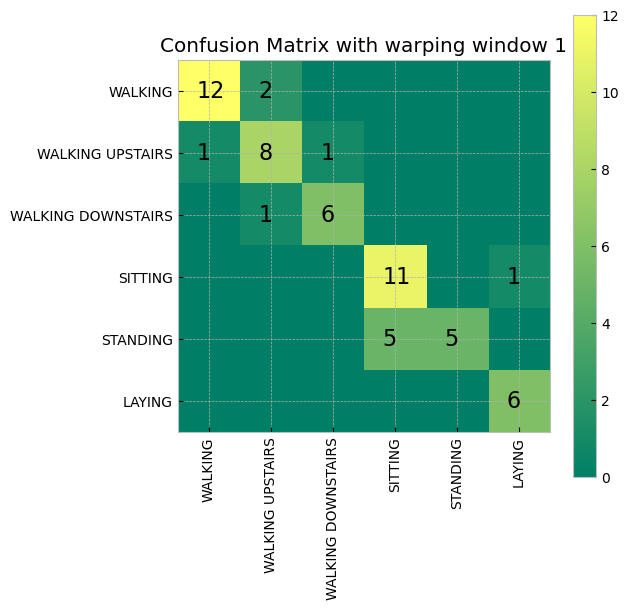

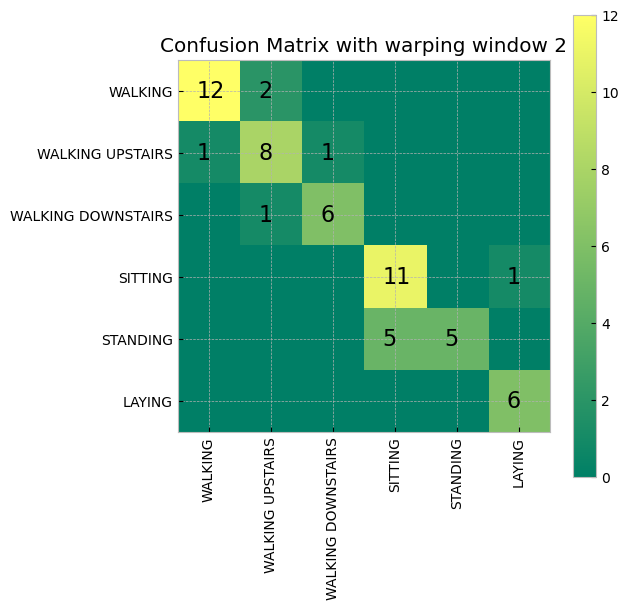

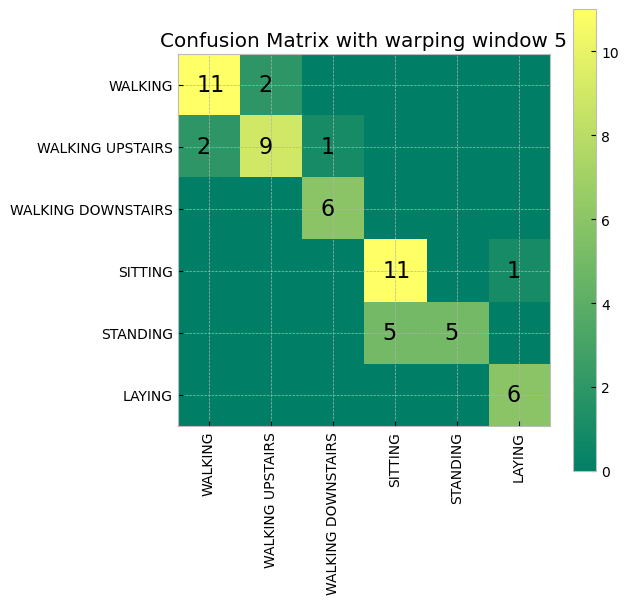

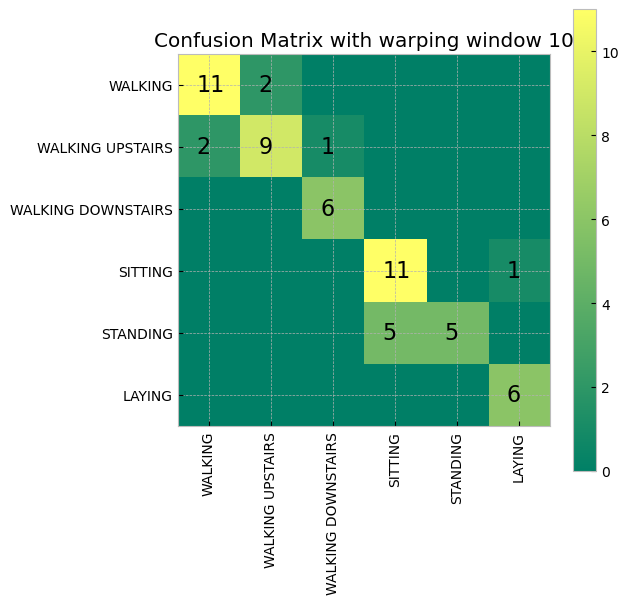

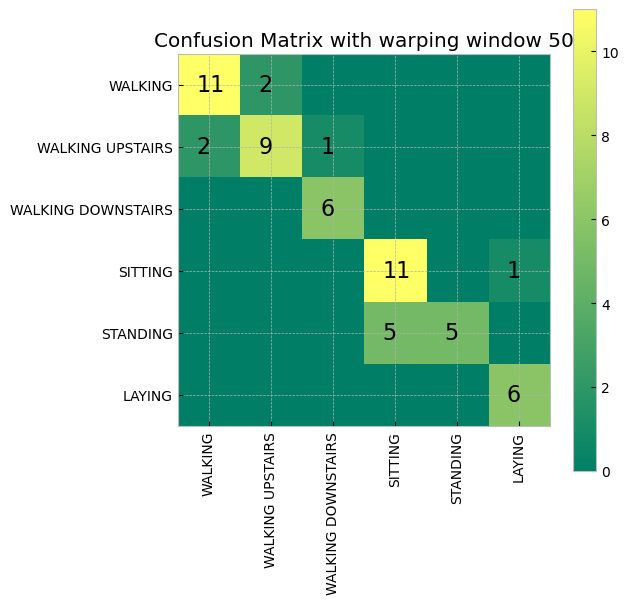

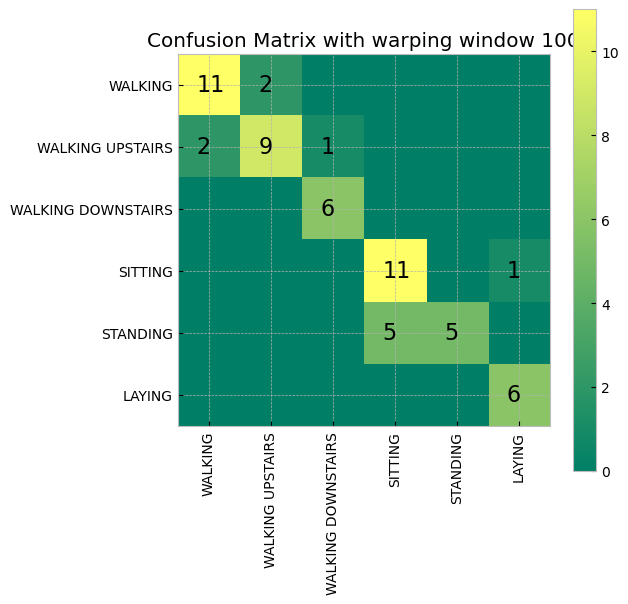

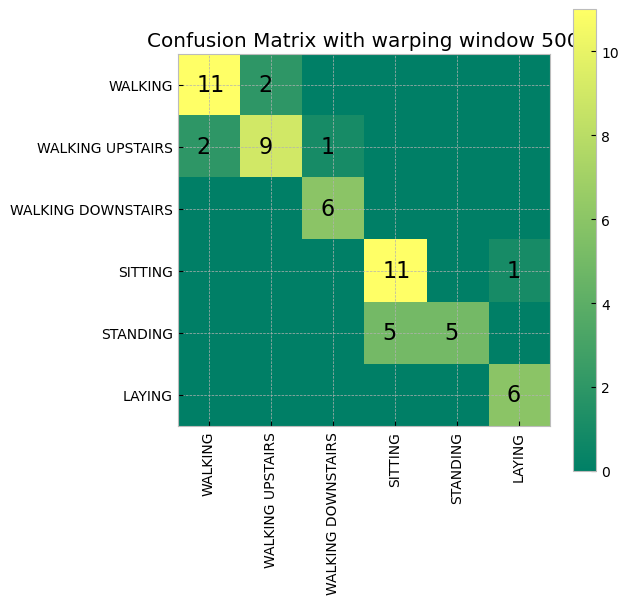

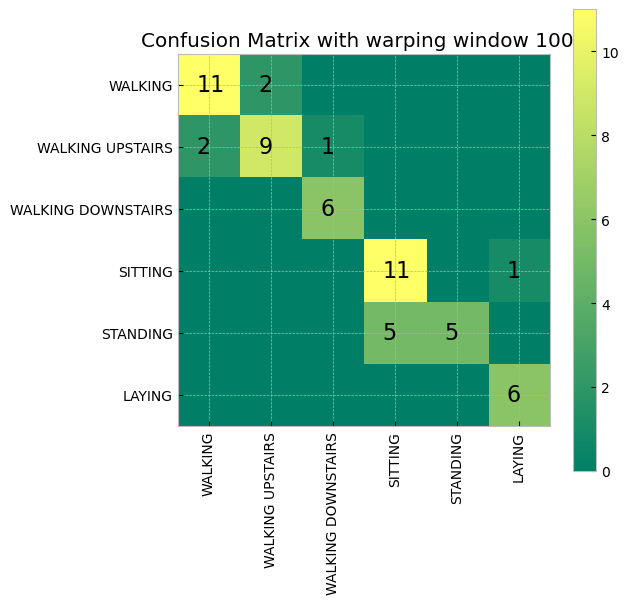

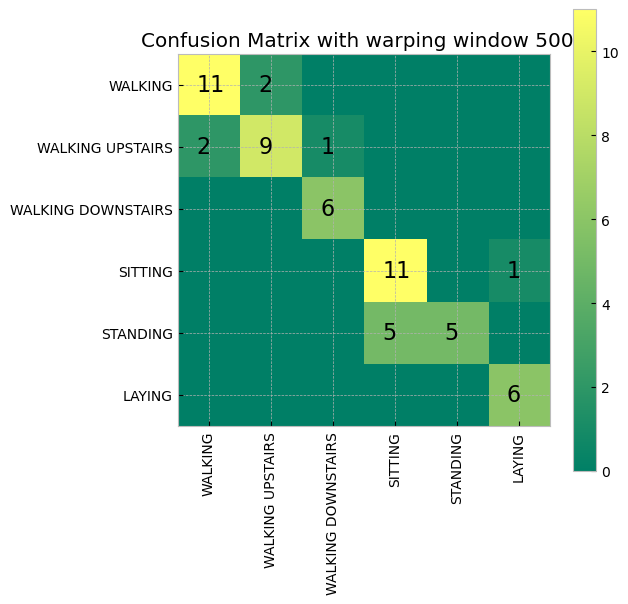

In [11]:
import time

time_taken = []
windows = [1,2,5,10,50,100,500,1000,5000]

for w in windows:
    begin = time.time()
    
    t = KnnDtw(n_neighbors = 1, max_warping_window = w)
    t.fit(x_train[::50], y_train[::50])
    label, proba = t.predict(x_test[::50])
    
    end = time.time()
    time_taken.append(end-begin)
    
    draw_confusion_matrix(label,y_test[::50],w)

# fig = plt.figure(figsize=(12,5))
# plt.plot(windows, [t/400. for t in time_taken], lw=4)
# plt.title('DTW Execution Time with \nvarying Max Warping Window')
# plt.ylabel('Execution Time (seconds)')
# plt.xlabel('Max Warping Window')
# plt.xscale('log')